In [1]:
%cd C:\Users\sowjanya\Desktop\Parkinson_ML\Parkinson_ML\Parkinson_MLDL

C:\Users\sowjanya\Desktop\Parkinson_ML\Parkinson_ML\Parkinson_MLDL


In [2]:
!pip install lime

In [3]:
import numpy as np
import pandas as pd

import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.python.keras.layers import Dense
from tensorflow.keras import Sequential
from keras import regularizers
from keras.metrics import binary_accuracy
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score,precision_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler

from sklearn import preprocessing
from sklearn.metrics import precision_recall_curve, auc, roc_curve, f1_score
from sklearn.metrics import matthews_corrcoef
from numpy import sqrt
from numpy import argmax 
import matplotlib.pyplot as plt

from tensorflow.python.keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from keras.regularizers import l2

# import lime
# import lime.lime_tabular

Using TensorFlow backend.


In [4]:
data = pd.read_csv('train_data.txt', sep=",", header=None)
data.columns = ["Subject id", "Jitter (local)" ,"Jitter (local, absolute)" ,"Jitter (rap)" ,"Jitter (ppq5)", "Jitter (ddp)", "Shimmer (local)", "Shimmer (local, dB)" ,"Shimmer (apq3)", "Shimmer (apq5)", "Shimmer (apq11)", "Shimmer (dda)", "AC" ,"NTH" ,"HTN", "Median pitch", "Mean pitch", "Standard deviation", "Minimum pitch", "Maximum pitch", "Number of pulses", "Number of periods", "Mean period", "Standard deviation of period", "Fraction of locally unvoiced frames", "Number of voice breaks", "Degree of voice breaks", "UPDRS", "class information"]
data.shape

(1040, 29)

In [5]:
d = {}
for x in data["Subject id"]:
    d[x] = d.get(x, 0)+1
d

{1: 26,
 2: 26,
 3: 26,
 4: 26,
 5: 26,
 6: 26,
 7: 26,
 8: 26,
 9: 26,
 10: 26,
 11: 26,
 12: 26,
 13: 26,
 14: 26,
 15: 26,
 16: 26,
 17: 26,
 18: 26,
 19: 26,
 20: 26,
 21: 26,
 22: 26,
 23: 26,
 24: 26,
 25: 26,
 26: 26,
 27: 26,
 28: 26,
 29: 26,
 30: 26,
 31: 26,
 32: 26,
 33: 26,
 34: 26,
 35: 26,
 36: 26,
 37: 26,
 38: 26,
 39: 26,
 40: 26}

In [6]:
data.head()
data.isnull().sum()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1040 entries, 0 to 1039
Data columns (total 29 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Subject id                           1040 non-null   int64  
 1   Jitter (local)                       1040 non-null   float64
 2   Jitter (local, absolute)             1040 non-null   float64
 3   Jitter (rap)                         1040 non-null   float64
 4   Jitter (ppq5)                        1040 non-null   float64
 5   Jitter (ddp)                         1040 non-null   float64
 6   Shimmer (local)                      1040 non-null   float64
 7   Shimmer (local, dB)                  1040 non-null   float64
 8   Shimmer (apq3)                       1040 non-null   float64
 9   Shimmer (apq5)                       1040 non-null   float64
 10  Shimmer (apq11)                      1040 non-null   float64
 11  Shimmer (dda)                 

In [7]:
uniqueness = data.select_dtypes(include=['O'])
uniqueness.apply(pd.Series.nunique)

Series([], dtype: float64)

In [8]:
y_updrs = data.UPDRS # for regression
y_class_info = data["class information"]#for classification
data_x = data.drop(labels=['UPDRS', "Subject id", "class information"], axis=1, inplace = False)
print(data_x.shape, y_updrs.shape, y_class_info.shape)

(1040, 26) (1040,) (1040,)


In [9]:
def nature_updrs_class():
    classinfo_UPDRS = data[['UPDRS', 'class information']].copy()
    classinfo_UPDRS.iloc[1,1]
    d = {}
    for i in range(classinfo_UPDRS.shape[0]):
        class_ = classinfo_UPDRS.iloc[i,1]
        updrs  = classinfo_UPDRS.iloc[i,0]
        if class_ in d:
            if updrs not in d[class_]:
                d[class_].append(updrs)
        else:
            d[class_] = [updrs]
    for it in d:
        d[it].sort()
    print("no. of 0s = ",classinfo_UPDRS['class information'].to_list().count(0), "No of 1s = ",classinfo_UPDRS['class information'].to_list().count(1))
    return d

print(nature_updrs_class())


no. of 0s =  520 No of 1s =  520
{1: [5, 8, 11, 12, 16, 20, 23, 24, 26, 31, 32, 40, 46, 55], 0: [1]}


In [13]:
type(data_x)

pandas.core.frame.DataFrame

In [14]:
#before 52,26,13,1 o/p layer = sigmoid with 1 neuron
#hyperparameters for model.compile
batch_size = 20
no_epochs = 2000
optimizer_func = "adam"
loss_func = "binary_crossentropy"
valid_split = 0.20

#hyperparameters for Kfold CV
fold_no = 1
total_folds = 10

# Initialising the ANN
def create_model():
    model = Sequential()
    # Input layer
    model.add(Dense(52, kernel_initializer='normal', activation='relu', input_dim = 26,))
    model.add(Dense(26, kernel_initializer='normal', activation='relu'))
    model.add(Dense(13, kernel_initializer='normal', activation='relu'))
    # Ouput layer
    model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
    
    model.compile(optimizer = optimizer_func, loss = loss_func, metrics = ['accuracy'])
    
    return model

In [15]:
#without data shuffling
# from keras.wrappers.scikit_learn import KerasClassifier
# from sklearn.model_selection import cross_val_score


#datacopying and normalization

data_x_nn = data_x.copy(deep=True)
target_y_nn = y_class_info.copy(deep=True)
nm = MinMaxScaler()
data_x_nn = nm.fit_transform(data_x_nn)


#Kfold Validator definition
kfold = KFold(n_splits= total_folds, shuffle=True, random_state=42)
acc_per_fold = []
loss_per_fold = []


for train_index, test_index in kfold.split(data_x_nn, target_y_nn):

    model = create_model()

    print('\nTraining for fold no ...  :' ,fold_no, "/",total_folds,"\n")

    history = model.fit(data_x_nn[train_index],
                        target_y_nn[train_index],
                        batch_size = batch_size, 
                        epochs = no_epochs,
                        verbose=2,
                        validation_split = valid_split)
    
    scores = model.evaluate(data_x_nn[test_index], target_y_nn[test_index], verbose=0)
    #print("Score for fold",fold_no,", ", model.metrics_names[0], " of " ,scores[0],"  ",model.metrics_names[1]," of, ",scores[1]*100,"%")
    
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])
    fold_no+=1
    
# neural_network = KerasClassifier(build_fn=create_model,epochs=1000, batch_size=10, verbose=2)
# cross_val_score(neural_network,X_train_nn, y_train_nn, cv=3)

# y_pred = model.predict(X_test_nn)
# y_predm = [1 if x>0.5 else 0 for x in y_pred]
# acc = accuracy_score(y_test_nn, y_predm)
# print('Test Accuracy = %.2f' % acc)

print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print("> Fold ",i+1," - Loss: ",loss_per_fold[i],"  - Accuracy: ", acc_per_fold[i],"%")
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print('> Accuracy: ',np.mean(acc_per_fold),' (+- ',np.std(acc_per_fold),')')
print('> Loss: ', np.mean(loss_per_fold))
print('------------------------------------------------------------------------')

# bacc = binary_accuracy(y_test_nn, y_pred, threshold=0.5)
# print('Test Accuracy = %.2f' % bacc*100)


Training for fold no ...  : 1 / 10 

Train on 748 samples, validate on 188 samples
Epoch 1/2000
748/748 - 1s - loss: 0.6913 - accuracy: 0.6110 - val_loss: 0.7107 - val_accuracy: 0.0000e+00
Epoch 2/2000
748/748 - 0s - loss: 0.6828 - accuracy: 0.6270 - val_loss: 0.7950 - val_accuracy: 0.0000e+00
Epoch 3/2000
748/748 - 0s - loss: 0.6621 - accuracy: 0.6270 - val_loss: 0.9849 - val_accuracy: 0.0000e+00
Epoch 4/2000
748/748 - 0s - loss: 0.6560 - accuracy: 0.6270 - val_loss: 0.9832 - val_accuracy: 0.0000e+00
Epoch 5/2000
748/748 - 0s - loss: 0.6492 - accuracy: 0.6270 - val_loss: 0.9805 - val_accuracy: 0.0000e+00
Epoch 6/2000
748/748 - 0s - loss: 0.6424 - accuracy: 0.6270 - val_loss: 0.9671 - val_accuracy: 0.0000e+00
Epoch 7/2000
748/748 - 0s - loss: 0.6383 - accuracy: 0.6430 - val_loss: 1.0609 - val_accuracy: 0.0532
Epoch 8/2000
748/748 - 0s - loss: 0.6285 - accuracy: 0.6631 - val_loss: 0.8464 - val_accuracy: 0.2234
Epoch 9/2000
748/748 - 0s - loss: 0.6292 - accuracy: 0.6698 - val_loss: 1.14

Epoch 80/2000
748/748 - 0s - loss: 0.5120 - accuracy: 0.7447 - val_loss: 1.0527 - val_accuracy: 0.2819
Epoch 81/2000
748/748 - 0s - loss: 0.5076 - accuracy: 0.7406 - val_loss: 1.2101 - val_accuracy: 0.2553
Epoch 82/2000
748/748 - 0s - loss: 0.5106 - accuracy: 0.7433 - val_loss: 1.2920 - val_accuracy: 0.2287
Epoch 83/2000
748/748 - 0s - loss: 0.5094 - accuracy: 0.7540 - val_loss: 0.9787 - val_accuracy: 0.3564
Epoch 84/2000
748/748 - 0s - loss: 0.5029 - accuracy: 0.7406 - val_loss: 1.0938 - val_accuracy: 0.3085
Epoch 85/2000
748/748 - 0s - loss: 0.5073 - accuracy: 0.7447 - val_loss: 0.9205 - val_accuracy: 0.3989
Epoch 86/2000
748/748 - 0s - loss: 0.5015 - accuracy: 0.7473 - val_loss: 0.9655 - val_accuracy: 0.3617
Epoch 87/2000
748/748 - 0s - loss: 0.5119 - accuracy: 0.7500 - val_loss: 1.3751 - val_accuracy: 0.2181
Epoch 88/2000
748/748 - 0s - loss: 0.5110 - accuracy: 0.7420 - val_loss: 0.7894 - val_accuracy: 0.4468
Epoch 89/2000
748/748 - 0s - loss: 0.5040 - accuracy: 0.7433 - val_loss: 

Epoch 159/2000
748/748 - 0s - loss: 0.4246 - accuracy: 0.8075 - val_loss: 0.8745 - val_accuracy: 0.5106
Epoch 160/2000
748/748 - 0s - loss: 0.4245 - accuracy: 0.8021 - val_loss: 1.0377 - val_accuracy: 0.4043
Epoch 161/2000
748/748 - 0s - loss: 0.4249 - accuracy: 0.7968 - val_loss: 1.1850 - val_accuracy: 0.3351
Epoch 162/2000
748/748 - 0s - loss: 0.4206 - accuracy: 0.7941 - val_loss: 0.9469 - val_accuracy: 0.4521
Epoch 163/2000
748/748 - 0s - loss: 0.4192 - accuracy: 0.8021 - val_loss: 1.0763 - val_accuracy: 0.3883
Epoch 164/2000
748/748 - 0s - loss: 0.4268 - accuracy: 0.8061 - val_loss: 1.0453 - val_accuracy: 0.3883
Epoch 165/2000
748/748 - 0s - loss: 0.4176 - accuracy: 0.8021 - val_loss: 1.0980 - val_accuracy: 0.3670
Epoch 166/2000
748/748 - 0s - loss: 0.4176 - accuracy: 0.7995 - val_loss: 1.3727 - val_accuracy: 0.2979
Epoch 167/2000
748/748 - 0s - loss: 0.4271 - accuracy: 0.7955 - val_loss: 0.9063 - val_accuracy: 0.5106
Epoch 168/2000
748/748 - 0s - loss: 0.4081 - accuracy: 0.8182 - 

Epoch 238/2000
748/748 - 0s - loss: 0.3285 - accuracy: 0.8570 - val_loss: 1.2019 - val_accuracy: 0.4362
Epoch 239/2000
748/748 - 0s - loss: 0.3263 - accuracy: 0.8570 - val_loss: 1.5332 - val_accuracy: 0.3085
Epoch 240/2000
748/748 - 0s - loss: 0.3263 - accuracy: 0.8690 - val_loss: 0.7522 - val_accuracy: 0.6223
Epoch 241/2000
748/748 - 0s - loss: 0.3350 - accuracy: 0.8463 - val_loss: 1.0560 - val_accuracy: 0.5000
Epoch 242/2000
748/748 - 0s - loss: 0.3095 - accuracy: 0.8717 - val_loss: 1.2742 - val_accuracy: 0.4202
Epoch 243/2000
748/748 - 0s - loss: 0.3095 - accuracy: 0.8623 - val_loss: 1.1313 - val_accuracy: 0.4628
Epoch 244/2000
748/748 - 0s - loss: 0.3140 - accuracy: 0.8703 - val_loss: 1.1421 - val_accuracy: 0.4521
Epoch 245/2000
748/748 - 0s - loss: 0.3114 - accuracy: 0.8730 - val_loss: 1.2963 - val_accuracy: 0.4096
Epoch 246/2000
748/748 - 0s - loss: 0.3119 - accuracy: 0.8676 - val_loss: 1.1500 - val_accuracy: 0.4628
Epoch 247/2000
748/748 - 0s - loss: 0.3161 - accuracy: 0.8690 - 

Epoch 317/2000
748/748 - 0s - loss: 0.2609 - accuracy: 0.8944 - val_loss: 1.2190 - val_accuracy: 0.4894
Epoch 318/2000
748/748 - 0s - loss: 0.2484 - accuracy: 0.9024 - val_loss: 1.2992 - val_accuracy: 0.4894
Epoch 319/2000
748/748 - 0s - loss: 0.2564 - accuracy: 0.8930 - val_loss: 1.1833 - val_accuracy: 0.4894
Epoch 320/2000
748/748 - 0s - loss: 0.2433 - accuracy: 0.9024 - val_loss: 1.4208 - val_accuracy: 0.4255
Epoch 321/2000
748/748 - 0s - loss: 0.2463 - accuracy: 0.9024 - val_loss: 1.5273 - val_accuracy: 0.4043
Epoch 322/2000
748/748 - 0s - loss: 0.2414 - accuracy: 0.9091 - val_loss: 1.2451 - val_accuracy: 0.4894
Epoch 323/2000
748/748 - 0s - loss: 0.2482 - accuracy: 0.9037 - val_loss: 1.4064 - val_accuracy: 0.4628
Epoch 324/2000
748/748 - 0s - loss: 0.2519 - accuracy: 0.9064 - val_loss: 1.2173 - val_accuracy: 0.5000
Epoch 325/2000
748/748 - 0s - loss: 0.2401 - accuracy: 0.9131 - val_loss: 1.3216 - val_accuracy: 0.4521
Epoch 326/2000
748/748 - 0s - loss: 0.2362 - accuracy: 0.9171 - 

Epoch 396/2000
748/748 - 0s - loss: 0.1890 - accuracy: 0.9265 - val_loss: 1.3875 - val_accuracy: 0.5000
Epoch 397/2000
748/748 - 0s - loss: 0.1886 - accuracy: 0.9265 - val_loss: 1.4292 - val_accuracy: 0.4734
Epoch 398/2000
748/748 - 0s - loss: 0.1873 - accuracy: 0.9318 - val_loss: 1.4304 - val_accuracy: 0.4787
Epoch 399/2000
748/748 - 0s - loss: 0.1844 - accuracy: 0.9291 - val_loss: 1.3794 - val_accuracy: 0.5106
Epoch 400/2000
748/748 - 0s - loss: 0.1935 - accuracy: 0.9291 - val_loss: 1.4999 - val_accuracy: 0.4628
Epoch 401/2000
748/748 - 0s - loss: 0.2067 - accuracy: 0.9184 - val_loss: 1.2818 - val_accuracy: 0.5319
Epoch 402/2000
748/748 - 0s - loss: 0.1906 - accuracy: 0.9184 - val_loss: 1.4879 - val_accuracy: 0.4787
Epoch 403/2000
748/748 - 0s - loss: 0.1821 - accuracy: 0.9291 - val_loss: 1.4643 - val_accuracy: 0.4734
Epoch 404/2000
748/748 - 0s - loss: 0.1809 - accuracy: 0.9332 - val_loss: 1.9694 - val_accuracy: 0.3777
Epoch 405/2000
748/748 - 0s - loss: 0.1899 - accuracy: 0.9171 - 

Epoch 475/2000
748/748 - 0s - loss: 0.1396 - accuracy: 0.9479 - val_loss: 1.9494 - val_accuracy: 0.4202
Epoch 476/2000
748/748 - 0s - loss: 0.1497 - accuracy: 0.9385 - val_loss: 2.2087 - val_accuracy: 0.3670
Epoch 477/2000
748/748 - 0s - loss: 0.2017 - accuracy: 0.9131 - val_loss: 1.3907 - val_accuracy: 0.4947
Epoch 478/2000
748/748 - 0s - loss: 0.1668 - accuracy: 0.9318 - val_loss: 1.9751 - val_accuracy: 0.4149
Epoch 479/2000
748/748 - 0s - loss: 0.1413 - accuracy: 0.9545 - val_loss: 1.9348 - val_accuracy: 0.4202
Epoch 480/2000
748/748 - 0s - loss: 0.1587 - accuracy: 0.9439 - val_loss: 1.8758 - val_accuracy: 0.4362
Epoch 481/2000
748/748 - 0s - loss: 0.1738 - accuracy: 0.9358 - val_loss: 1.3842 - val_accuracy: 0.5426
Epoch 482/2000
748/748 - 0s - loss: 0.1833 - accuracy: 0.9184 - val_loss: 1.8103 - val_accuracy: 0.4362
Epoch 483/2000
748/748 - 0s - loss: 0.1412 - accuracy: 0.9505 - val_loss: 2.1851 - val_accuracy: 0.3989
Epoch 484/2000
748/748 - 0s - loss: 0.1485 - accuracy: 0.9465 - 

Epoch 554/2000
748/748 - 0s - loss: 0.1085 - accuracy: 0.9612 - val_loss: 1.9945 - val_accuracy: 0.4681
Epoch 555/2000
748/748 - 0s - loss: 0.1268 - accuracy: 0.9492 - val_loss: 2.3145 - val_accuracy: 0.4149
Epoch 556/2000
748/748 - 0s - loss: 0.1076 - accuracy: 0.9572 - val_loss: 2.4024 - val_accuracy: 0.4149
Epoch 557/2000
748/748 - 0s - loss: 0.1261 - accuracy: 0.9425 - val_loss: 1.8492 - val_accuracy: 0.5053
Epoch 558/2000
748/748 - 0s - loss: 0.1471 - accuracy: 0.9385 - val_loss: 1.9958 - val_accuracy: 0.4787
Epoch 559/2000
748/748 - 0s - loss: 0.2224 - accuracy: 0.9091 - val_loss: 2.1111 - val_accuracy: 0.4043
Epoch 560/2000
748/748 - 0s - loss: 0.2757 - accuracy: 0.8917 - val_loss: 1.9861 - val_accuracy: 0.4255
Epoch 561/2000
748/748 - 0s - loss: 0.1790 - accuracy: 0.9184 - val_loss: 2.0045 - val_accuracy: 0.4468
Epoch 562/2000
748/748 - 0s - loss: 0.2134 - accuracy: 0.9278 - val_loss: 3.5991 - val_accuracy: 0.2553
Epoch 563/2000
748/748 - 0s - loss: 0.3943 - accuracy: 0.8543 - 

Epoch 633/2000
748/748 - 0s - loss: 0.3519 - accuracy: 0.8864 - val_loss: 1.6952 - val_accuracy: 0.4255
Epoch 634/2000
748/748 - 0s - loss: 0.3797 - accuracy: 0.8516 - val_loss: 1.6827 - val_accuracy: 0.3777
Epoch 635/2000
748/748 - 0s - loss: 0.2048 - accuracy: 0.9171 - val_loss: 1.3021 - val_accuracy: 0.5638
Epoch 636/2000
748/748 - 0s - loss: 0.1504 - accuracy: 0.9372 - val_loss: 1.8086 - val_accuracy: 0.5053
Epoch 637/2000
748/748 - 0s - loss: 0.0993 - accuracy: 0.9719 - val_loss: 1.9223 - val_accuracy: 0.4734
Epoch 638/2000
748/748 - 0s - loss: 0.0945 - accuracy: 0.9559 - val_loss: 2.1761 - val_accuracy: 0.4309
Epoch 639/2000
748/748 - 0s - loss: 0.0813 - accuracy: 0.9733 - val_loss: 1.8914 - val_accuracy: 0.5106
Epoch 640/2000
748/748 - 0s - loss: 0.0857 - accuracy: 0.9693 - val_loss: 2.2176 - val_accuracy: 0.4309
Epoch 641/2000
748/748 - 0s - loss: 0.0991 - accuracy: 0.9626 - val_loss: 2.3087 - val_accuracy: 0.4468
Epoch 642/2000
748/748 - 0s - loss: 0.1883 - accuracy: 0.9305 - 

Epoch 712/2000
748/748 - 0s - loss: 0.2253 - accuracy: 0.9211 - val_loss: 2.0050 - val_accuracy: 0.5106
Epoch 713/2000
748/748 - 0s - loss: 0.2943 - accuracy: 0.9144 - val_loss: 1.4239 - val_accuracy: 0.6011
Epoch 714/2000
748/748 - 0s - loss: 0.1578 - accuracy: 0.9452 - val_loss: 2.8635 - val_accuracy: 0.3936
Epoch 715/2000
748/748 - 0s - loss: 0.1048 - accuracy: 0.9666 - val_loss: 2.0501 - val_accuracy: 0.5213
Epoch 716/2000
748/748 - 0s - loss: 0.0841 - accuracy: 0.9652 - val_loss: 2.3558 - val_accuracy: 0.5000
Epoch 717/2000
748/748 - 0s - loss: 0.0616 - accuracy: 0.9773 - val_loss: 2.4043 - val_accuracy: 0.4787
Epoch 718/2000
748/748 - 0s - loss: 0.0636 - accuracy: 0.9786 - val_loss: 2.7937 - val_accuracy: 0.4309
Epoch 719/2000
748/748 - 0s - loss: 0.0622 - accuracy: 0.9786 - val_loss: 2.4653 - val_accuracy: 0.4840
Epoch 720/2000
748/748 - 0s - loss: 0.0603 - accuracy: 0.9786 - val_loss: 2.6788 - val_accuracy: 0.4734
Epoch 721/2000
748/748 - 0s - loss: 0.0590 - accuracy: 0.9813 - 

Epoch 791/2000
748/748 - 0s - loss: 0.0553 - accuracy: 0.9799 - val_loss: 2.8421 - val_accuracy: 0.5000
Epoch 792/2000
748/748 - 0s - loss: 0.0492 - accuracy: 0.9826 - val_loss: 2.8152 - val_accuracy: 0.5106
Epoch 793/2000
748/748 - 0s - loss: 0.0550 - accuracy: 0.9773 - val_loss: 3.2177 - val_accuracy: 0.4202
Epoch 794/2000
748/748 - 0s - loss: 0.0509 - accuracy: 0.9799 - val_loss: 3.1258 - val_accuracy: 0.4787
Epoch 795/2000
748/748 - 0s - loss: 0.0460 - accuracy: 0.9853 - val_loss: 3.1404 - val_accuracy: 0.4468
Epoch 796/2000
748/748 - 0s - loss: 0.0537 - accuracy: 0.9773 - val_loss: 2.6557 - val_accuracy: 0.5213
Epoch 797/2000
748/748 - 0s - loss: 0.0482 - accuracy: 0.9840 - val_loss: 3.1061 - val_accuracy: 0.4840
Epoch 798/2000
748/748 - 0s - loss: 0.0483 - accuracy: 0.9840 - val_loss: 2.7763 - val_accuracy: 0.5319
Epoch 799/2000
748/748 - 0s - loss: 0.0627 - accuracy: 0.9719 - val_loss: 2.6081 - val_accuracy: 0.5213
Epoch 800/2000
748/748 - 0s - loss: 0.0667 - accuracy: 0.9719 - 

Epoch 870/2000
748/748 - 0s - loss: 0.1605 - accuracy: 0.9452 - val_loss: 2.6599 - val_accuracy: 0.5000
Epoch 871/2000
748/748 - 0s - loss: 0.2235 - accuracy: 0.9064 - val_loss: 1.5429 - val_accuracy: 0.6702
Epoch 872/2000
748/748 - 0s - loss: 0.2488 - accuracy: 0.9265 - val_loss: 3.3694 - val_accuracy: 0.4149
Epoch 873/2000
748/748 - 0s - loss: 0.0980 - accuracy: 0.9572 - val_loss: 2.4390 - val_accuracy: 0.5160
Epoch 874/2000
748/748 - 0s - loss: 0.0640 - accuracy: 0.9813 - val_loss: 3.1446 - val_accuracy: 0.4681
Epoch 875/2000
748/748 - 0s - loss: 0.0402 - accuracy: 0.9866 - val_loss: 3.0720 - val_accuracy: 0.4840
Epoch 876/2000
748/748 - 0s - loss: 0.0400 - accuracy: 0.9866 - val_loss: 3.0262 - val_accuracy: 0.4947
Epoch 877/2000
748/748 - 0s - loss: 0.0385 - accuracy: 0.9853 - val_loss: 3.2799 - val_accuracy: 0.4787
Epoch 878/2000
748/748 - 0s - loss: 0.0398 - accuracy: 0.9880 - val_loss: 3.2867 - val_accuracy: 0.4521
Epoch 879/2000
748/748 - 0s - loss: 0.0387 - accuracy: 0.9893 - 

Epoch 949/2000
748/748 - 0s - loss: 0.0817 - accuracy: 0.9666 - val_loss: 2.5781 - val_accuracy: 0.4202
Epoch 950/2000
748/748 - 0s - loss: 0.0651 - accuracy: 0.9733 - val_loss: 2.4300 - val_accuracy: 0.4734
Epoch 951/2000
748/748 - 0s - loss: 0.0592 - accuracy: 0.9799 - val_loss: 2.2666 - val_accuracy: 0.5266
Epoch 952/2000
748/748 - 0s - loss: 0.0575 - accuracy: 0.9786 - val_loss: 2.2042 - val_accuracy: 0.5426
Epoch 953/2000
748/748 - 0s - loss: 0.0705 - accuracy: 0.9733 - val_loss: 2.9446 - val_accuracy: 0.3936
Epoch 954/2000
748/748 - 0s - loss: 0.0846 - accuracy: 0.9639 - val_loss: 2.4057 - val_accuracy: 0.4894
Epoch 955/2000
748/748 - 0s - loss: 0.0654 - accuracy: 0.9799 - val_loss: 2.3950 - val_accuracy: 0.5053
Epoch 956/2000
748/748 - 0s - loss: 0.0791 - accuracy: 0.9719 - val_loss: 2.9110 - val_accuracy: 0.4043
Epoch 957/2000
748/748 - 0s - loss: 0.0632 - accuracy: 0.9733 - val_loss: 3.2845 - val_accuracy: 0.3777
Epoch 958/2000
748/748 - 0s - loss: 0.1076 - accuracy: 0.9586 - 

Epoch 1028/2000
748/748 - 0s - loss: 0.0306 - accuracy: 0.9893 - val_loss: 3.3633 - val_accuracy: 0.4681
Epoch 1029/2000
748/748 - 0s - loss: 0.0296 - accuracy: 0.9893 - val_loss: 3.3193 - val_accuracy: 0.4947
Epoch 1030/2000
748/748 - 0s - loss: 0.0287 - accuracy: 0.9880 - val_loss: 3.3413 - val_accuracy: 0.5000
Epoch 1031/2000
748/748 - 0s - loss: 0.0301 - accuracy: 0.9906 - val_loss: 3.3616 - val_accuracy: 0.4894
Epoch 1032/2000
748/748 - 0s - loss: 0.0287 - accuracy: 0.9893 - val_loss: 3.6351 - val_accuracy: 0.4362
Epoch 1033/2000
748/748 - 0s - loss: 0.0302 - accuracy: 0.9893 - val_loss: 3.6275 - val_accuracy: 0.4521
Epoch 1034/2000
748/748 - 0s - loss: 0.0338 - accuracy: 0.9880 - val_loss: 3.6101 - val_accuracy: 0.4574
Epoch 1035/2000
748/748 - 0s - loss: 0.0401 - accuracy: 0.9893 - val_loss: 3.8941 - val_accuracy: 0.4043
Epoch 1036/2000
748/748 - 0s - loss: 0.0315 - accuracy: 0.9880 - val_loss: 3.7291 - val_accuracy: 0.4362
Epoch 1037/2000
748/748 - 0s - loss: 0.0328 - accuracy:

Epoch 1107/2000
748/748 - 0s - loss: 0.0241 - accuracy: 0.9920 - val_loss: 3.7489 - val_accuracy: 0.5266
Epoch 1108/2000
748/748 - 0s - loss: 0.0239 - accuracy: 0.9920 - val_loss: 3.9845 - val_accuracy: 0.4734
Epoch 1109/2000
748/748 - 0s - loss: 0.0230 - accuracy: 0.9906 - val_loss: 3.7499 - val_accuracy: 0.5160
Epoch 1110/2000
748/748 - 0s - loss: 0.0240 - accuracy: 0.9933 - val_loss: 4.2894 - val_accuracy: 0.4521
Epoch 1111/2000
748/748 - 0s - loss: 0.0234 - accuracy: 0.9920 - val_loss: 3.9897 - val_accuracy: 0.4840
Epoch 1112/2000
748/748 - 0s - loss: 0.0237 - accuracy: 0.9906 - val_loss: 3.9057 - val_accuracy: 0.5053
Epoch 1113/2000
748/748 - 0s - loss: 0.0224 - accuracy: 0.9920 - val_loss: 3.8390 - val_accuracy: 0.5266
Epoch 1114/2000
748/748 - 0s - loss: 0.0221 - accuracy: 0.9920 - val_loss: 4.1736 - val_accuracy: 0.4734
Epoch 1115/2000
748/748 - 0s - loss: 0.0233 - accuracy: 0.9893 - val_loss: 3.7905 - val_accuracy: 0.5053
Epoch 1116/2000
748/748 - 0s - loss: 0.0228 - accuracy:

Epoch 1186/2000
748/748 - 0s - loss: 0.0190 - accuracy: 0.9906 - val_loss: 4.1547 - val_accuracy: 0.4947
Epoch 1187/2000
748/748 - 0s - loss: 0.0186 - accuracy: 0.9933 - val_loss: 4.4432 - val_accuracy: 0.4628
Epoch 1188/2000
748/748 - 0s - loss: 0.0234 - accuracy: 0.9920 - val_loss: 4.2371 - val_accuracy: 0.4894
Epoch 1189/2000
748/748 - 0s - loss: 0.0301 - accuracy: 0.9880 - val_loss: 4.3374 - val_accuracy: 0.5000
Epoch 1190/2000
748/748 - 0s - loss: 0.0814 - accuracy: 0.9706 - val_loss: 6.0813 - val_accuracy: 0.2979
Epoch 1191/2000
748/748 - 0s - loss: 0.1764 - accuracy: 0.9318 - val_loss: 2.5615 - val_accuracy: 0.6277
Epoch 1192/2000
748/748 - 0s - loss: 0.2858 - accuracy: 0.9078 - val_loss: 4.5839 - val_accuracy: 0.3404
Epoch 1193/2000
748/748 - 0s - loss: 0.4147 - accuracy: 0.8757 - val_loss: 2.6138 - val_accuracy: 0.4787
Epoch 1194/2000
748/748 - 0s - loss: 0.0710 - accuracy: 0.9746 - val_loss: 2.8329 - val_accuracy: 0.5479
Epoch 1195/2000
748/748 - 0s - loss: 0.0534 - accuracy:

Epoch 1265/2000
748/748 - 0s - loss: 0.0154 - accuracy: 0.9960 - val_loss: 4.4690 - val_accuracy: 0.4894
Epoch 1266/2000
748/748 - 0s - loss: 0.0155 - accuracy: 0.9947 - val_loss: 4.1720 - val_accuracy: 0.5266
Epoch 1267/2000
748/748 - 0s - loss: 0.0155 - accuracy: 0.9947 - val_loss: 4.3632 - val_accuracy: 0.5213
Epoch 1268/2000
748/748 - 0s - loss: 0.0156 - accuracy: 0.9960 - val_loss: 4.6002 - val_accuracy: 0.4947
Epoch 1269/2000
748/748 - 0s - loss: 0.0221 - accuracy: 0.9920 - val_loss: 4.0968 - val_accuracy: 0.5319
Epoch 1270/2000
748/748 - 0s - loss: 0.0183 - accuracy: 0.9947 - val_loss: 4.3965 - val_accuracy: 0.4947
Epoch 1271/2000
748/748 - 0s - loss: 0.0175 - accuracy: 0.9933 - val_loss: 4.3749 - val_accuracy: 0.5053
Epoch 1272/2000
748/748 - 0s - loss: 0.0156 - accuracy: 0.9973 - val_loss: 4.5199 - val_accuracy: 0.5000
Epoch 1273/2000
748/748 - 0s - loss: 0.0153 - accuracy: 0.9960 - val_loss: 4.4979 - val_accuracy: 0.4894
Epoch 1274/2000
748/748 - 0s - loss: 0.0150 - accuracy:

748/748 - 0s - loss: 0.0136 - accuracy: 0.9973 - val_loss: 3.8678 - val_accuracy: 0.5957
Epoch 1344/2000
748/748 - 0s - loss: 0.0151 - accuracy: 0.9947 - val_loss: 4.5774 - val_accuracy: 0.4894
Epoch 1345/2000
748/748 - 0s - loss: 0.0136 - accuracy: 0.9960 - val_loss: 4.2452 - val_accuracy: 0.5213
Epoch 1346/2000
748/748 - 0s - loss: 0.0174 - accuracy: 0.9973 - val_loss: 4.9183 - val_accuracy: 0.4521
Epoch 1347/2000
748/748 - 0s - loss: 0.4065 - accuracy: 0.9078 - val_loss: 3.7552 - val_accuracy: 0.5000
Epoch 1348/2000
748/748 - 0s - loss: 0.2457 - accuracy: 0.9144 - val_loss: 3.4987 - val_accuracy: 0.5160
Epoch 1349/2000
748/748 - 0s - loss: 0.0932 - accuracy: 0.9652 - val_loss: 3.7001 - val_accuracy: 0.4894
Epoch 1350/2000
748/748 - 0s - loss: 0.0801 - accuracy: 0.9733 - val_loss: 2.9995 - val_accuracy: 0.5745
Epoch 1351/2000
748/748 - 0s - loss: 0.0474 - accuracy: 0.9813 - val_loss: 4.8692 - val_accuracy: 0.4149
Epoch 1352/2000
748/748 - 0s - loss: 0.0294 - accuracy: 0.9920 - val_lo

Epoch 1422/2000
748/748 - 0s - loss: 0.0108 - accuracy: 0.9973 - val_loss: 5.2185 - val_accuracy: 0.4787
Epoch 1423/2000
748/748 - 0s - loss: 0.0115 - accuracy: 0.9960 - val_loss: 5.1858 - val_accuracy: 0.4787
Epoch 1424/2000
748/748 - 0s - loss: 0.0101 - accuracy: 0.9973 - val_loss: 5.0393 - val_accuracy: 0.5053
Epoch 1425/2000
748/748 - 0s - loss: 0.0118 - accuracy: 0.9973 - val_loss: 5.2034 - val_accuracy: 0.4840
Epoch 1426/2000
748/748 - 0s - loss: 0.0103 - accuracy: 0.9973 - val_loss: 5.0695 - val_accuracy: 0.5053
Epoch 1427/2000
748/748 - 0s - loss: 0.0101 - accuracy: 0.9987 - val_loss: 4.4480 - val_accuracy: 0.5372
Epoch 1428/2000
748/748 - 0s - loss: 0.0115 - accuracy: 0.9987 - val_loss: 5.5736 - val_accuracy: 0.4681
Epoch 1429/2000
748/748 - 0s - loss: 0.0123 - accuracy: 0.9973 - val_loss: 4.5487 - val_accuracy: 0.5479
Epoch 1430/2000
748/748 - 0s - loss: 0.0112 - accuracy: 0.9973 - val_loss: 4.8691 - val_accuracy: 0.5213
Epoch 1431/2000
748/748 - 0s - loss: 0.0108 - accuracy:

Epoch 1501/2000
748/748 - 0s - loss: 0.0077 - accuracy: 0.9987 - val_loss: 5.8409 - val_accuracy: 0.4681
Epoch 1502/2000
748/748 - 0s - loss: 0.0078 - accuracy: 0.9987 - val_loss: 5.7232 - val_accuracy: 0.4628
Epoch 1503/2000
748/748 - 0s - loss: 0.0080 - accuracy: 0.9987 - val_loss: 4.7756 - val_accuracy: 0.5532
Epoch 1504/2000
748/748 - 0s - loss: 0.0080 - accuracy: 0.9987 - val_loss: 6.2824 - val_accuracy: 0.4309
Epoch 1505/2000
748/748 - 0s - loss: 0.1928 - accuracy: 0.9586 - val_loss: 10.5619 - val_accuracy: 0.2340
Epoch 1506/2000
748/748 - 0s - loss: 1.1791 - accuracy: 0.6778 - val_loss: 1.3603 - val_accuracy: 0.6330
Epoch 1507/2000
748/748 - 0s - loss: 0.5014 - accuracy: 0.7447 - val_loss: 1.3948 - val_accuracy: 0.5372
Epoch 1508/2000
748/748 - 0s - loss: 0.3822 - accuracy: 0.8128 - val_loss: 1.8366 - val_accuracy: 0.3511
Epoch 1509/2000
748/748 - 0s - loss: 0.3325 - accuracy: 0.8543 - val_loss: 1.6930 - val_accuracy: 0.3777
Epoch 1510/2000
748/748 - 0s - loss: 0.2946 - accuracy

Epoch 1580/2000
748/748 - 0s - loss: 0.0086 - accuracy: 0.9987 - val_loss: 4.5307 - val_accuracy: 0.4947
Epoch 1581/2000
748/748 - 0s - loss: 0.0086 - accuracy: 0.9987 - val_loss: 4.4673 - val_accuracy: 0.4947
Epoch 1582/2000
748/748 - 0s - loss: 0.0085 - accuracy: 0.9987 - val_loss: 4.5725 - val_accuracy: 0.4947
Epoch 1583/2000
748/748 - 0s - loss: 0.0082 - accuracy: 0.9973 - val_loss: 4.7356 - val_accuracy: 0.4947
Epoch 1584/2000
748/748 - 0s - loss: 0.0113 - accuracy: 0.9987 - val_loss: 5.0058 - val_accuracy: 0.4947
Epoch 1585/2000
748/748 - 0s - loss: 0.0183 - accuracy: 0.9973 - val_loss: 4.0188 - val_accuracy: 0.5745
Epoch 1586/2000
748/748 - 0s - loss: 0.0089 - accuracy: 0.9987 - val_loss: 4.5908 - val_accuracy: 0.5160
Epoch 1587/2000
748/748 - 0s - loss: 0.0078 - accuracy: 0.9973 - val_loss: 4.5010 - val_accuracy: 0.5160
Epoch 1588/2000
748/748 - 0s - loss: 0.0074 - accuracy: 0.9987 - val_loss: 4.7580 - val_accuracy: 0.4947
Epoch 1589/2000
748/748 - 0s - loss: 0.0072 - accuracy:

Epoch 1659/2000
748/748 - 0s - loss: 0.0056 - accuracy: 0.9987 - val_loss: 4.8710 - val_accuracy: 0.5266
Epoch 1660/2000
748/748 - 0s - loss: 0.0046 - accuracy: 1.0000 - val_loss: 5.3626 - val_accuracy: 0.4947
Epoch 1661/2000
748/748 - 0s - loss: 0.0051 - accuracy: 0.9987 - val_loss: 5.0020 - val_accuracy: 0.5213
Epoch 1662/2000
748/748 - 0s - loss: 0.0054 - accuracy: 0.9987 - val_loss: 4.8557 - val_accuracy: 0.5160
Epoch 1663/2000
748/748 - 0s - loss: 0.0046 - accuracy: 0.9987 - val_loss: 4.5209 - val_accuracy: 0.5372
Epoch 1664/2000
748/748 - 0s - loss: 0.0061 - accuracy: 0.9987 - val_loss: 5.2721 - val_accuracy: 0.5000
Epoch 1665/2000
748/748 - 0s - loss: 0.0055 - accuracy: 0.9973 - val_loss: 4.9979 - val_accuracy: 0.5053
Epoch 1666/2000
748/748 - 0s - loss: 0.0052 - accuracy: 0.9987 - val_loss: 4.8622 - val_accuracy: 0.5053
Epoch 1667/2000
748/748 - 0s - loss: 0.0049 - accuracy: 0.9987 - val_loss: 4.7228 - val_accuracy: 0.5266
Epoch 1668/2000
748/748 - 0s - loss: 0.0080 - accuracy:

Epoch 1738/2000
748/748 - 0s - loss: 0.1066 - accuracy: 0.9652 - val_loss: 4.0714 - val_accuracy: 0.5106
Epoch 1739/2000
748/748 - 0s - loss: 0.0386 - accuracy: 0.9840 - val_loss: 4.5777 - val_accuracy: 0.4894
Epoch 1740/2000
748/748 - 0s - loss: 0.0330 - accuracy: 0.9906 - val_loss: 4.2956 - val_accuracy: 0.5372
Epoch 1741/2000
748/748 - 0s - loss: 0.0106 - accuracy: 0.9987 - val_loss: 5.1638 - val_accuracy: 0.4894
Epoch 1742/2000
748/748 - 0s - loss: 0.0073 - accuracy: 0.9987 - val_loss: 4.8047 - val_accuracy: 0.5266
Epoch 1743/2000
748/748 - 0s - loss: 0.0059 - accuracy: 0.9987 - val_loss: 4.9912 - val_accuracy: 0.5213
Epoch 1744/2000
748/748 - 0s - loss: 0.0057 - accuracy: 0.9987 - val_loss: 4.6800 - val_accuracy: 0.5319
Epoch 1745/2000
748/748 - 0s - loss: 0.0057 - accuracy: 0.9987 - val_loss: 4.4249 - val_accuracy: 0.5585
Epoch 1746/2000
748/748 - 0s - loss: 0.0059 - accuracy: 0.9987 - val_loss: 4.6204 - val_accuracy: 0.5372
Epoch 1747/2000
748/748 - 0s - loss: 0.0054 - accuracy:

Epoch 1817/2000
748/748 - 0s - loss: 0.0038 - accuracy: 1.0000 - val_loss: 4.5780 - val_accuracy: 0.5691
Epoch 1818/2000
748/748 - 0s - loss: 0.0040 - accuracy: 0.9987 - val_loss: 4.6894 - val_accuracy: 0.5585
Epoch 1819/2000
748/748 - 0s - loss: 0.0036 - accuracy: 1.0000 - val_loss: 4.8309 - val_accuracy: 0.5532
Epoch 1820/2000
748/748 - 0s - loss: 0.0038 - accuracy: 1.0000 - val_loss: 5.5804 - val_accuracy: 0.5213
Epoch 1821/2000
748/748 - 0s - loss: 0.0029 - accuracy: 1.0000 - val_loss: 5.2919 - val_accuracy: 0.5372
Epoch 1822/2000
748/748 - 0s - loss: 0.0028 - accuracy: 1.0000 - val_loss: 5.1976 - val_accuracy: 0.5372
Epoch 1823/2000
748/748 - 0s - loss: 0.0028 - accuracy: 1.0000 - val_loss: 5.4129 - val_accuracy: 0.5213
Epoch 1824/2000
748/748 - 0s - loss: 0.0027 - accuracy: 1.0000 - val_loss: 5.4230 - val_accuracy: 0.5319
Epoch 1825/2000
748/748 - 0s - loss: 0.0027 - accuracy: 1.0000 - val_loss: 4.8913 - val_accuracy: 0.5532
Epoch 1826/2000
748/748 - 0s - loss: 0.0028 - accuracy:

Epoch 1896/2000
748/748 - 0s - loss: 0.0027 - accuracy: 1.0000 - val_loss: 5.7073 - val_accuracy: 0.5213
Epoch 1897/2000
748/748 - 0s - loss: 0.0026 - accuracy: 1.0000 - val_loss: 5.2738 - val_accuracy: 0.5532
Epoch 1898/2000
748/748 - 0s - loss: 0.0022 - accuracy: 1.0000 - val_loss: 5.5531 - val_accuracy: 0.5372
Epoch 1899/2000
748/748 - 0s - loss: 0.0024 - accuracy: 1.0000 - val_loss: 5.7608 - val_accuracy: 0.5213
Epoch 1900/2000
748/748 - 0s - loss: 0.0021 - accuracy: 1.0000 - val_loss: 5.5761 - val_accuracy: 0.5372
Epoch 1901/2000
748/748 - 0s - loss: 0.0020 - accuracy: 1.0000 - val_loss: 5.1588 - val_accuracy: 0.5532
Epoch 1902/2000
748/748 - 0s - loss: 0.0032 - accuracy: 1.0000 - val_loss: 6.3427 - val_accuracy: 0.5053
Epoch 1903/2000
748/748 - 0s - loss: 0.0031 - accuracy: 1.0000 - val_loss: 5.0309 - val_accuracy: 0.5745
Epoch 1904/2000
748/748 - 0s - loss: 0.0033 - accuracy: 1.0000 - val_loss: 4.9680 - val_accuracy: 0.5638
Epoch 1905/2000
748/748 - 0s - loss: 0.0040 - accuracy:

Epoch 1975/2000
748/748 - 0s - loss: 0.0023 - accuracy: 1.0000 - val_loss: 5.0900 - val_accuracy: 0.5426
Epoch 1976/2000
748/748 - 0s - loss: 0.0019 - accuracy: 1.0000 - val_loss: 5.1341 - val_accuracy: 0.5372
Epoch 1977/2000
748/748 - 0s - loss: 0.0020 - accuracy: 1.0000 - val_loss: 5.0583 - val_accuracy: 0.5426
Epoch 1978/2000
748/748 - 0s - loss: 0.0020 - accuracy: 1.0000 - val_loss: 4.9860 - val_accuracy: 0.5426
Epoch 1979/2000
748/748 - 0s - loss: 0.0018 - accuracy: 1.0000 - val_loss: 5.2326 - val_accuracy: 0.5319
Epoch 1980/2000
748/748 - 0s - loss: 0.0019 - accuracy: 1.0000 - val_loss: 5.1842 - val_accuracy: 0.5372
Epoch 1981/2000
748/748 - 0s - loss: 0.0018 - accuracy: 1.0000 - val_loss: 5.2248 - val_accuracy: 0.5372
Epoch 1982/2000
748/748 - 0s - loss: 0.0020 - accuracy: 1.0000 - val_loss: 5.3746 - val_accuracy: 0.5213
Epoch 1983/2000
748/748 - 0s - loss: 0.0020 - accuracy: 1.0000 - val_loss: 4.7749 - val_accuracy: 0.5798
Epoch 1984/2000
748/748 - 0s - loss: 0.0033 - accuracy:

Epoch 54/2000
748/748 - 0s - loss: 0.5210 - accuracy: 0.7380 - val_loss: 1.0539 - val_accuracy: 0.3457
Epoch 55/2000
748/748 - 0s - loss: 0.5194 - accuracy: 0.7460 - val_loss: 1.1124 - val_accuracy: 0.3085
Epoch 56/2000
748/748 - 0s - loss: 0.5239 - accuracy: 0.7259 - val_loss: 1.0659 - val_accuracy: 0.3138
Epoch 57/2000
748/748 - 0s - loss: 0.5190 - accuracy: 0.7340 - val_loss: 0.9535 - val_accuracy: 0.3830
Epoch 58/2000
748/748 - 0s - loss: 0.5167 - accuracy: 0.7420 - val_loss: 1.0399 - val_accuracy: 0.3404
Epoch 59/2000
748/748 - 0s - loss: 0.5169 - accuracy: 0.7460 - val_loss: 1.1222 - val_accuracy: 0.3032
Epoch 60/2000
748/748 - 0s - loss: 0.5274 - accuracy: 0.7326 - val_loss: 1.0626 - val_accuracy: 0.3191
Epoch 61/2000
748/748 - 0s - loss: 0.5128 - accuracy: 0.7447 - val_loss: 1.0285 - val_accuracy: 0.3564
Epoch 62/2000
748/748 - 0s - loss: 0.5122 - accuracy: 0.7420 - val_loss: 0.8867 - val_accuracy: 0.4415
Epoch 63/2000
748/748 - 0s - loss: 0.5106 - accuracy: 0.7473 - val_loss: 

Epoch 134/2000
748/748 - 0s - loss: 0.4497 - accuracy: 0.7861 - val_loss: 1.4207 - val_accuracy: 0.2606
Epoch 135/2000
748/748 - 0s - loss: 0.4561 - accuracy: 0.7834 - val_loss: 1.0773 - val_accuracy: 0.4096
Epoch 136/2000
748/748 - 0s - loss: 0.4413 - accuracy: 0.7981 - val_loss: 1.1104 - val_accuracy: 0.3989
Epoch 137/2000
748/748 - 0s - loss: 0.4440 - accuracy: 0.7888 - val_loss: 1.2107 - val_accuracy: 0.3617
Epoch 138/2000
748/748 - 0s - loss: 0.4459 - accuracy: 0.7848 - val_loss: 1.2076 - val_accuracy: 0.3670
Epoch 139/2000
748/748 - 0s - loss: 0.4400 - accuracy: 0.8021 - val_loss: 1.3334 - val_accuracy: 0.2926
Epoch 140/2000
748/748 - 0s - loss: 0.4431 - accuracy: 0.7955 - val_loss: 1.0722 - val_accuracy: 0.4255
Epoch 141/2000
748/748 - 0s - loss: 0.4381 - accuracy: 0.8008 - val_loss: 1.2266 - val_accuracy: 0.3511
Epoch 142/2000
748/748 - 0s - loss: 0.4452 - accuracy: 0.7888 - val_loss: 1.1676 - val_accuracy: 0.3883
Epoch 143/2000
748/748 - 0s - loss: 0.4332 - accuracy: 0.8088 - 

Epoch 213/2000
748/748 - 0s - loss: 0.3675 - accuracy: 0.8489 - val_loss: 1.3604 - val_accuracy: 0.3564
Epoch 214/2000
748/748 - 0s - loss: 0.3770 - accuracy: 0.8409 - val_loss: 1.1370 - val_accuracy: 0.4521
Epoch 215/2000
748/748 - 0s - loss: 0.3672 - accuracy: 0.8516 - val_loss: 1.1224 - val_accuracy: 0.4574
Epoch 216/2000
748/748 - 0s - loss: 0.3581 - accuracy: 0.8516 - val_loss: 1.1336 - val_accuracy: 0.4574
Epoch 217/2000
748/748 - 0s - loss: 0.3572 - accuracy: 0.8543 - val_loss: 1.0612 - val_accuracy: 0.4787
Epoch 218/2000
748/748 - 0s - loss: 0.3446 - accuracy: 0.8650 - val_loss: 1.1551 - val_accuracy: 0.4521
Epoch 219/2000
748/748 - 0s - loss: 0.3449 - accuracy: 0.8570 - val_loss: 1.2641 - val_accuracy: 0.4096
Epoch 220/2000
748/748 - 0s - loss: 0.3439 - accuracy: 0.8676 - val_loss: 1.2789 - val_accuracy: 0.4043
Epoch 221/2000
748/748 - 0s - loss: 0.3485 - accuracy: 0.8583 - val_loss: 1.4044 - val_accuracy: 0.3777
Epoch 222/2000
748/748 - 0s - loss: 0.3456 - accuracy: 0.8570 - 

Epoch 292/2000
748/748 - 0s - loss: 0.2895 - accuracy: 0.8890 - val_loss: 1.5315 - val_accuracy: 0.3723
Epoch 293/2000
748/748 - 0s - loss: 0.2970 - accuracy: 0.8717 - val_loss: 1.3555 - val_accuracy: 0.4149
Epoch 294/2000
748/748 - 0s - loss: 0.2847 - accuracy: 0.8904 - val_loss: 1.5019 - val_accuracy: 0.3723
Epoch 295/2000
748/748 - 0s - loss: 0.3109 - accuracy: 0.8770 - val_loss: 1.4283 - val_accuracy: 0.3830
Epoch 296/2000
748/748 - 0s - loss: 0.2780 - accuracy: 0.8944 - val_loss: 1.2506 - val_accuracy: 0.4096
Epoch 297/2000
748/748 - 0s - loss: 0.2809 - accuracy: 0.9024 - val_loss: 1.5299 - val_accuracy: 0.3670
Epoch 298/2000
748/748 - 0s - loss: 0.2861 - accuracy: 0.8904 - val_loss: 1.5244 - val_accuracy: 0.3617
Epoch 299/2000
748/748 - 0s - loss: 0.2868 - accuracy: 0.8890 - val_loss: 1.6072 - val_accuracy: 0.3511
Epoch 300/2000
748/748 - 0s - loss: 0.2878 - accuracy: 0.8783 - val_loss: 1.1999 - val_accuracy: 0.4574
Epoch 301/2000
748/748 - 0s - loss: 0.2931 - accuracy: 0.8877 - 

Epoch 371/2000
748/748 - 0s - loss: 0.2784 - accuracy: 0.8957 - val_loss: 1.3901 - val_accuracy: 0.3989
Epoch 372/2000
748/748 - 0s - loss: 0.2363 - accuracy: 0.9144 - val_loss: 1.5645 - val_accuracy: 0.3723
Epoch 373/2000
748/748 - 0s - loss: 0.2275 - accuracy: 0.9184 - val_loss: 1.6216 - val_accuracy: 0.3670
Epoch 374/2000
748/748 - 0s - loss: 0.2395 - accuracy: 0.9104 - val_loss: 1.6536 - val_accuracy: 0.3617
Epoch 375/2000
748/748 - 0s - loss: 0.2317 - accuracy: 0.9144 - val_loss: 1.3977 - val_accuracy: 0.3936
Epoch 376/2000
748/748 - 0s - loss: 0.2301 - accuracy: 0.9171 - val_loss: 1.6091 - val_accuracy: 0.3883
Epoch 377/2000
748/748 - 0s - loss: 0.2482 - accuracy: 0.9104 - val_loss: 1.4378 - val_accuracy: 0.4096
Epoch 378/2000
748/748 - 0s - loss: 0.2313 - accuracy: 0.9144 - val_loss: 1.2083 - val_accuracy: 0.4894
Epoch 379/2000
748/748 - 0s - loss: 0.2310 - accuracy: 0.9211 - val_loss: 1.4722 - val_accuracy: 0.3989
Epoch 380/2000
748/748 - 0s - loss: 0.2403 - accuracy: 0.9078 - 

Epoch 450/2000
748/748 - 0s - loss: 0.2017 - accuracy: 0.9265 - val_loss: 1.7758 - val_accuracy: 0.3777
Epoch 451/2000
748/748 - 0s - loss: 0.2116 - accuracy: 0.9225 - val_loss: 1.5658 - val_accuracy: 0.3936
Epoch 452/2000
748/748 - 0s - loss: 0.2030 - accuracy: 0.9238 - val_loss: 1.3488 - val_accuracy: 0.4415
Epoch 453/2000
748/748 - 0s - loss: 0.1938 - accuracy: 0.9318 - val_loss: 1.5217 - val_accuracy: 0.4309
Epoch 454/2000
748/748 - 0s - loss: 0.1890 - accuracy: 0.9305 - val_loss: 1.4450 - val_accuracy: 0.4415
Epoch 455/2000
748/748 - 0s - loss: 0.2284 - accuracy: 0.9051 - val_loss: 1.8022 - val_accuracy: 0.3457
Epoch 456/2000
748/748 - 0s - loss: 0.2050 - accuracy: 0.9318 - val_loss: 1.7707 - val_accuracy: 0.3723
Epoch 457/2000
748/748 - 0s - loss: 0.1979 - accuracy: 0.9265 - val_loss: 1.5131 - val_accuracy: 0.4096
Epoch 458/2000
748/748 - 0s - loss: 0.1824 - accuracy: 0.9372 - val_loss: 1.7701 - val_accuracy: 0.3883
Epoch 459/2000
748/748 - 0s - loss: 0.2037 - accuracy: 0.9211 - 

Epoch 529/2000
748/748 - 0s - loss: 0.1676 - accuracy: 0.9372 - val_loss: 1.6222 - val_accuracy: 0.4149
Epoch 530/2000
748/748 - 0s - loss: 0.1523 - accuracy: 0.9479 - val_loss: 1.8880 - val_accuracy: 0.3936
Epoch 531/2000
748/748 - 0s - loss: 0.1608 - accuracy: 0.9358 - val_loss: 1.9187 - val_accuracy: 0.3936
Epoch 532/2000
748/748 - 0s - loss: 0.1755 - accuracy: 0.9265 - val_loss: 2.2227 - val_accuracy: 0.3830
Epoch 533/2000
748/748 - 0s - loss: 0.1855 - accuracy: 0.9251 - val_loss: 1.4885 - val_accuracy: 0.4415
Epoch 534/2000
748/748 - 0s - loss: 0.1575 - accuracy: 0.9398 - val_loss: 1.7121 - val_accuracy: 0.4255
Epoch 535/2000
748/748 - 0s - loss: 0.1513 - accuracy: 0.9412 - val_loss: 1.7383 - val_accuracy: 0.4096
Epoch 536/2000
748/748 - 0s - loss: 0.1548 - accuracy: 0.9492 - val_loss: 2.1286 - val_accuracy: 0.3830
Epoch 537/2000
748/748 - 0s - loss: 0.1567 - accuracy: 0.9385 - val_loss: 1.9933 - val_accuracy: 0.3936
Epoch 538/2000
748/748 - 0s - loss: 0.1539 - accuracy: 0.9412 - 

Epoch 608/2000
748/748 - 0s - loss: 0.1223 - accuracy: 0.9559 - val_loss: 2.0001 - val_accuracy: 0.4521
Epoch 609/2000
748/748 - 0s - loss: 0.1216 - accuracy: 0.9559 - val_loss: 1.9858 - val_accuracy: 0.4628
Epoch 610/2000
748/748 - 0s - loss: 0.1246 - accuracy: 0.9505 - val_loss: 2.8009 - val_accuracy: 0.3564
Epoch 611/2000
748/748 - 0s - loss: 0.1226 - accuracy: 0.9492 - val_loss: 2.6568 - val_accuracy: 0.3777
Epoch 612/2000
748/748 - 0s - loss: 0.1389 - accuracy: 0.9452 - val_loss: 2.0819 - val_accuracy: 0.4202
Epoch 613/2000
748/748 - 0s - loss: 0.1273 - accuracy: 0.9519 - val_loss: 2.6280 - val_accuracy: 0.3830
Epoch 614/2000
748/748 - 0s - loss: 0.1339 - accuracy: 0.9532 - val_loss: 1.6977 - val_accuracy: 0.4894
Epoch 615/2000
748/748 - 0s - loss: 0.1337 - accuracy: 0.9479 - val_loss: 2.5081 - val_accuracy: 0.3936
Epoch 616/2000
748/748 - 0s - loss: 0.1303 - accuracy: 0.9532 - val_loss: 1.8655 - val_accuracy: 0.4787
Epoch 617/2000
748/748 - 0s - loss: 0.1241 - accuracy: 0.9572 - 

Epoch 687/2000
748/748 - 0s - loss: 0.1646 - accuracy: 0.9332 - val_loss: 1.8289 - val_accuracy: 0.4894
Epoch 688/2000
748/748 - 0s - loss: 0.1259 - accuracy: 0.9532 - val_loss: 1.9125 - val_accuracy: 0.4574
Epoch 689/2000
748/748 - 0s - loss: 0.1035 - accuracy: 0.9652 - val_loss: 2.1488 - val_accuracy: 0.4574
Epoch 690/2000
748/748 - 0s - loss: 0.0964 - accuracy: 0.9733 - val_loss: 2.2470 - val_accuracy: 0.4681
Epoch 691/2000
748/748 - 0s - loss: 0.0921 - accuracy: 0.9693 - val_loss: 2.3169 - val_accuracy: 0.4255
Epoch 692/2000
748/748 - 0s - loss: 0.0880 - accuracy: 0.9679 - val_loss: 2.8567 - val_accuracy: 0.3989
Epoch 693/2000
748/748 - 0s - loss: 0.0907 - accuracy: 0.9666 - val_loss: 2.3068 - val_accuracy: 0.4521
Epoch 694/2000
748/748 - 0s - loss: 0.0905 - accuracy: 0.9693 - val_loss: 2.5490 - val_accuracy: 0.4521
Epoch 695/2000
748/748 - 0s - loss: 0.1101 - accuracy: 0.9612 - val_loss: 2.5210 - val_accuracy: 0.4309
Epoch 696/2000
748/748 - 0s - loss: 0.0987 - accuracy: 0.9626 - 

Epoch 766/2000
748/748 - 0s - loss: 0.0905 - accuracy: 0.9652 - val_loss: 3.0526 - val_accuracy: 0.4096
Epoch 767/2000
748/748 - 0s - loss: 0.0833 - accuracy: 0.9733 - val_loss: 2.7040 - val_accuracy: 0.4574
Epoch 768/2000
748/748 - 0s - loss: 0.0904 - accuracy: 0.9652 - val_loss: 2.2548 - val_accuracy: 0.4894
Epoch 769/2000
748/748 - 0s - loss: 0.1087 - accuracy: 0.9612 - val_loss: 3.4546 - val_accuracy: 0.3511
Epoch 770/2000
748/748 - 0s - loss: 0.1092 - accuracy: 0.9572 - val_loss: 3.5195 - val_accuracy: 0.3830
Epoch 771/2000
748/748 - 0s - loss: 0.1553 - accuracy: 0.9265 - val_loss: 2.6007 - val_accuracy: 0.4362
Epoch 772/2000
748/748 - 0s - loss: 0.1028 - accuracy: 0.9612 - val_loss: 3.3408 - val_accuracy: 0.3670
Epoch 773/2000
748/748 - 0s - loss: 0.0931 - accuracy: 0.9666 - val_loss: 2.2687 - val_accuracy: 0.4734
Epoch 774/2000
748/748 - 0s - loss: 0.0899 - accuracy: 0.9746 - val_loss: 2.8110 - val_accuracy: 0.4362
Epoch 775/2000
748/748 - 0s - loss: 0.0821 - accuracy: 0.9719 - 

Epoch 845/2000
748/748 - 0s - loss: 0.0650 - accuracy: 0.9773 - val_loss: 3.1535 - val_accuracy: 0.4202
Epoch 846/2000
748/748 - 0s - loss: 0.0651 - accuracy: 0.9799 - val_loss: 4.0866 - val_accuracy: 0.3723
Epoch 847/2000
748/748 - 0s - loss: 0.0915 - accuracy: 0.9639 - val_loss: 3.4479 - val_accuracy: 0.3989
Epoch 848/2000
748/748 - 0s - loss: 0.0743 - accuracy: 0.9706 - val_loss: 2.8803 - val_accuracy: 0.4415
Epoch 849/2000
748/748 - 0s - loss: 0.0641 - accuracy: 0.9826 - val_loss: 3.7048 - val_accuracy: 0.4043
Epoch 850/2000
748/748 - 0s - loss: 0.0676 - accuracy: 0.9759 - val_loss: 3.0959 - val_accuracy: 0.4840
Epoch 851/2000
748/748 - 0s - loss: 0.0714 - accuracy: 0.9746 - val_loss: 3.1857 - val_accuracy: 0.4521
Epoch 852/2000
748/748 - 0s - loss: 0.0612 - accuracy: 0.9746 - val_loss: 3.5247 - val_accuracy: 0.4255
Epoch 853/2000
748/748 - 0s - loss: 0.0710 - accuracy: 0.9733 - val_loss: 3.1778 - val_accuracy: 0.4362
Epoch 854/2000
748/748 - 0s - loss: 0.0698 - accuracy: 0.9799 - 

Epoch 924/2000
748/748 - 0s - loss: 0.0602 - accuracy: 0.9733 - val_loss: 2.7723 - val_accuracy: 0.5160
Epoch 925/2000
748/748 - 0s - loss: 0.0748 - accuracy: 0.9733 - val_loss: 4.2941 - val_accuracy: 0.3617
Epoch 926/2000
748/748 - 0s - loss: 0.0934 - accuracy: 0.9693 - val_loss: 2.7097 - val_accuracy: 0.5053
Epoch 927/2000
748/748 - 0s - loss: 0.1208 - accuracy: 0.9612 - val_loss: 3.3713 - val_accuracy: 0.4681
Epoch 928/2000
748/748 - 0s - loss: 0.1699 - accuracy: 0.9305 - val_loss: 3.5653 - val_accuracy: 0.3723
Epoch 929/2000
748/748 - 0s - loss: 0.1756 - accuracy: 0.9398 - val_loss: 3.5181 - val_accuracy: 0.4309
Epoch 930/2000
748/748 - 0s - loss: 0.1370 - accuracy: 0.9425 - val_loss: 2.8111 - val_accuracy: 0.5426
Epoch 931/2000
748/748 - 0s - loss: 0.0887 - accuracy: 0.9639 - val_loss: 2.7492 - val_accuracy: 0.4894
Epoch 932/2000
748/748 - 0s - loss: 0.0791 - accuracy: 0.9693 - val_loss: 2.6561 - val_accuracy: 0.5053
Epoch 933/2000
748/748 - 0s - loss: 0.0838 - accuracy: 0.9626 - 

Epoch 1003/2000
748/748 - 0s - loss: 0.1128 - accuracy: 0.9626 - val_loss: 5.1572 - val_accuracy: 0.3351
Epoch 1004/2000
748/748 - 0s - loss: 0.2847 - accuracy: 0.8917 - val_loss: 2.6019 - val_accuracy: 0.5319
Epoch 1005/2000
748/748 - 0s - loss: 0.2281 - accuracy: 0.9211 - val_loss: 4.3876 - val_accuracy: 0.3723
Epoch 1006/2000
748/748 - 0s - loss: 0.1430 - accuracy: 0.9492 - val_loss: 2.6517 - val_accuracy: 0.4840
Epoch 1007/2000
748/748 - 0s - loss: 0.1046 - accuracy: 0.9559 - val_loss: 2.8817 - val_accuracy: 0.5053
Epoch 1008/2000
748/748 - 0s - loss: 0.0668 - accuracy: 0.9799 - val_loss: 3.8969 - val_accuracy: 0.4149
Epoch 1009/2000
748/748 - 0s - loss: 0.0946 - accuracy: 0.9612 - val_loss: 3.1796 - val_accuracy: 0.4734
Epoch 1010/2000
748/748 - 0s - loss: 0.0941 - accuracy: 0.9612 - val_loss: 3.2799 - val_accuracy: 0.4628
Epoch 1011/2000
748/748 - 0s - loss: 0.0735 - accuracy: 0.9719 - val_loss: 3.8458 - val_accuracy: 0.4255
Epoch 1012/2000
748/748 - 0s - loss: 0.0879 - accuracy:

Epoch 1082/2000
748/748 - 0s - loss: 0.0419 - accuracy: 0.9866 - val_loss: 3.8854 - val_accuracy: 0.4415
Epoch 1083/2000
748/748 - 0s - loss: 0.0479 - accuracy: 0.9840 - val_loss: 3.8859 - val_accuracy: 0.4362
Epoch 1084/2000
748/748 - 0s - loss: 0.0403 - accuracy: 0.9880 - val_loss: 3.5465 - val_accuracy: 0.4628
Epoch 1085/2000
748/748 - 0s - loss: 0.0417 - accuracy: 0.9880 - val_loss: 3.9022 - val_accuracy: 0.4415
Epoch 1086/2000
748/748 - 0s - loss: 0.0428 - accuracy: 0.9866 - val_loss: 3.6663 - val_accuracy: 0.4734
Epoch 1087/2000
748/748 - 0s - loss: 0.0381 - accuracy: 0.9880 - val_loss: 3.7825 - val_accuracy: 0.4574
Epoch 1088/2000
748/748 - 0s - loss: 0.0548 - accuracy: 0.9799 - val_loss: 3.7795 - val_accuracy: 0.4415
Epoch 1089/2000
748/748 - 0s - loss: 0.0560 - accuracy: 0.9813 - val_loss: 3.6048 - val_accuracy: 0.4681
Epoch 1090/2000
748/748 - 0s - loss: 0.0514 - accuracy: 0.9813 - val_loss: 4.1357 - val_accuracy: 0.4415
Epoch 1091/2000
748/748 - 0s - loss: 0.0893 - accuracy:

Epoch 1161/2000
748/748 - 0s - loss: 0.0441 - accuracy: 0.9893 - val_loss: 3.7432 - val_accuracy: 0.4574
Epoch 1162/2000
748/748 - 0s - loss: 0.0387 - accuracy: 0.9853 - val_loss: 3.1146 - val_accuracy: 0.5000
Epoch 1163/2000
748/748 - 0s - loss: 0.0383 - accuracy: 0.9880 - val_loss: 3.6202 - val_accuracy: 0.4521
Epoch 1164/2000
748/748 - 0s - loss: 0.0402 - accuracy: 0.9880 - val_loss: 3.6250 - val_accuracy: 0.4628
Epoch 1165/2000
748/748 - 0s - loss: 0.0394 - accuracy: 0.9826 - val_loss: 3.5059 - val_accuracy: 0.4628
Epoch 1166/2000
748/748 - 0s - loss: 0.0517 - accuracy: 0.9813 - val_loss: 4.9288 - val_accuracy: 0.3830
Epoch 1167/2000
748/748 - 0s - loss: 0.0570 - accuracy: 0.9799 - val_loss: 3.0554 - val_accuracy: 0.4947
Epoch 1168/2000
748/748 - 0s - loss: 0.0434 - accuracy: 0.9866 - val_loss: 3.9355 - val_accuracy: 0.4468
Epoch 1169/2000
748/748 - 0s - loss: 0.0364 - accuracy: 0.9893 - val_loss: 3.5433 - val_accuracy: 0.4734
Epoch 1170/2000
748/748 - 0s - loss: 0.0363 - accuracy:

Epoch 1240/2000
748/748 - 0s - loss: 0.0356 - accuracy: 0.9880 - val_loss: 3.2004 - val_accuracy: 0.5213
Epoch 1241/2000
748/748 - 0s - loss: 0.0403 - accuracy: 0.9880 - val_loss: 3.4415 - val_accuracy: 0.4894
Epoch 1242/2000
748/748 - 0s - loss: 0.0332 - accuracy: 0.9933 - val_loss: 3.8243 - val_accuracy: 0.4681
Epoch 1243/2000
748/748 - 0s - loss: 0.0318 - accuracy: 0.9893 - val_loss: 3.5546 - val_accuracy: 0.4947
Epoch 1244/2000
748/748 - 0s - loss: 0.0368 - accuracy: 0.9906 - val_loss: 4.1854 - val_accuracy: 0.4415
Epoch 1245/2000
748/748 - 0s - loss: 0.0317 - accuracy: 0.9893 - val_loss: 4.1737 - val_accuracy: 0.4362
Epoch 1246/2000
748/748 - 0s - loss: 0.0342 - accuracy: 0.9866 - val_loss: 3.3904 - val_accuracy: 0.5000
Epoch 1247/2000
748/748 - 0s - loss: 0.0409 - accuracy: 0.9866 - val_loss: 3.7444 - val_accuracy: 0.4894
Epoch 1248/2000
748/748 - 0s - loss: 0.0943 - accuracy: 0.9572 - val_loss: 4.2607 - val_accuracy: 0.4574
Epoch 1249/2000
748/748 - 0s - loss: 0.0912 - accuracy:

Epoch 1319/2000
748/748 - 0s - loss: 0.0273 - accuracy: 0.9906 - val_loss: 4.1172 - val_accuracy: 0.4734
Epoch 1320/2000
748/748 - 0s - loss: 0.0286 - accuracy: 0.9920 - val_loss: 4.3084 - val_accuracy: 0.4628
Epoch 1321/2000
748/748 - 0s - loss: 0.0291 - accuracy: 0.9933 - val_loss: 4.6923 - val_accuracy: 0.4468
Epoch 1322/2000
748/748 - 0s - loss: 0.0340 - accuracy: 0.9853 - val_loss: 4.2782 - val_accuracy: 0.4681
Epoch 1323/2000
748/748 - 0s - loss: 0.0430 - accuracy: 0.9813 - val_loss: 4.1846 - val_accuracy: 0.4521
Epoch 1324/2000
748/748 - 0s - loss: 0.0605 - accuracy: 0.9799 - val_loss: 5.2905 - val_accuracy: 0.4096
Epoch 1325/2000
748/748 - 0s - loss: 0.0478 - accuracy: 0.9880 - val_loss: 4.1923 - val_accuracy: 0.4734
Epoch 1326/2000
748/748 - 0s - loss: 0.0326 - accuracy: 0.9853 - val_loss: 3.7051 - val_accuracy: 0.5000
Epoch 1327/2000
748/748 - 0s - loss: 0.0326 - accuracy: 0.9920 - val_loss: 5.0587 - val_accuracy: 0.4362
Epoch 1328/2000
748/748 - 0s - loss: 0.0351 - accuracy:

748/748 - 0s - loss: 0.0990 - accuracy: 0.9572 - val_loss: 3.8926 - val_accuracy: 0.4840
Epoch 1398/2000
748/748 - 0s - loss: 0.0511 - accuracy: 0.9840 - val_loss: 4.5318 - val_accuracy: 0.4362
Epoch 1399/2000
748/748 - 0s - loss: 0.0340 - accuracy: 0.9893 - val_loss: 4.2977 - val_accuracy: 0.4681
Epoch 1400/2000
748/748 - 0s - loss: 0.0308 - accuracy: 0.9906 - val_loss: 5.1871 - val_accuracy: 0.4149
Epoch 1401/2000
748/748 - 0s - loss: 0.0307 - accuracy: 0.9906 - val_loss: 4.8125 - val_accuracy: 0.4309
Epoch 1402/2000
748/748 - 0s - loss: 0.0268 - accuracy: 0.9933 - val_loss: 4.7509 - val_accuracy: 0.4255
Epoch 1403/2000
748/748 - 0s - loss: 0.0348 - accuracy: 0.9893 - val_loss: 4.1445 - val_accuracy: 0.4734
Epoch 1404/2000
748/748 - 0s - loss: 0.0285 - accuracy: 0.9906 - val_loss: 4.6519 - val_accuracy: 0.4468
Epoch 1405/2000
748/748 - 0s - loss: 0.0252 - accuracy: 0.9920 - val_loss: 4.3846 - val_accuracy: 0.4734
Epoch 1406/2000
748/748 - 0s - loss: 0.0275 - accuracy: 0.9947 - val_lo

Epoch 1476/2000
748/748 - 0s - loss: 0.0245 - accuracy: 0.9906 - val_loss: 4.6492 - val_accuracy: 0.4574
Epoch 1477/2000
748/748 - 0s - loss: 0.0241 - accuracy: 0.9920 - val_loss: 4.6531 - val_accuracy: 0.4628
Epoch 1478/2000
748/748 - 0s - loss: 0.0223 - accuracy: 0.9947 - val_loss: 4.0270 - val_accuracy: 0.4894
Epoch 1479/2000
748/748 - 0s - loss: 0.0221 - accuracy: 0.9960 - val_loss: 5.7978 - val_accuracy: 0.4202
Epoch 1480/2000
748/748 - 0s - loss: 0.0261 - accuracy: 0.9947 - val_loss: 4.0403 - val_accuracy: 0.4947
Epoch 1481/2000
748/748 - 0s - loss: 0.0251 - accuracy: 0.9920 - val_loss: 4.5613 - val_accuracy: 0.4734
Epoch 1482/2000
748/748 - 0s - loss: 0.0248 - accuracy: 0.9920 - val_loss: 4.9402 - val_accuracy: 0.4521
Epoch 1483/2000
748/748 - 0s - loss: 0.0246 - accuracy: 0.9933 - val_loss: 5.9234 - val_accuracy: 0.4149
Epoch 1484/2000
748/748 - 0s - loss: 0.0289 - accuracy: 0.9960 - val_loss: 4.0238 - val_accuracy: 0.5160
Epoch 1485/2000
748/748 - 0s - loss: 0.0269 - accuracy:

748/748 - 0s - loss: 0.0256 - accuracy: 0.9947 - val_loss: 4.7018 - val_accuracy: 0.4628
Epoch 1555/2000
748/748 - 0s - loss: 0.0254 - accuracy: 0.9920 - val_loss: 4.4715 - val_accuracy: 0.4840
Epoch 1556/2000
748/748 - 0s - loss: 0.0222 - accuracy: 0.9947 - val_loss: 5.2622 - val_accuracy: 0.4415
Epoch 1557/2000
748/748 - 0s - loss: 0.0307 - accuracy: 0.9920 - val_loss: 5.5996 - val_accuracy: 0.4309
Epoch 1558/2000
748/748 - 0s - loss: 0.0367 - accuracy: 0.9893 - val_loss: 5.4486 - val_accuracy: 0.4415
Epoch 1559/2000
748/748 - 0s - loss: 0.0561 - accuracy: 0.9826 - val_loss: 4.6251 - val_accuracy: 0.4734
Epoch 1560/2000
748/748 - 0s - loss: 0.1291 - accuracy: 0.9545 - val_loss: 4.8197 - val_accuracy: 0.4468
Epoch 1561/2000
748/748 - 0s - loss: 0.2139 - accuracy: 0.9278 - val_loss: 7.3916 - val_accuracy: 0.3191
Epoch 1562/2000
748/748 - 0s - loss: 0.2861 - accuracy: 0.9198 - val_loss: 4.2835 - val_accuracy: 0.4521
Epoch 1563/2000
748/748 - 0s - loss: 0.2574 - accuracy: 0.9184 - val_lo

Epoch 1633/2000
748/748 - 0s - loss: 0.0424 - accuracy: 0.9826 - val_loss: 4.6047 - val_accuracy: 0.4787
Epoch 1634/2000
748/748 - 0s - loss: 0.0269 - accuracy: 0.9947 - val_loss: 4.9337 - val_accuracy: 0.4628
Epoch 1635/2000
748/748 - 0s - loss: 0.0209 - accuracy: 0.9947 - val_loss: 4.4307 - val_accuracy: 0.4947
Epoch 1636/2000
748/748 - 0s - loss: 0.0219 - accuracy: 0.9933 - val_loss: 4.8111 - val_accuracy: 0.4734
Epoch 1637/2000
748/748 - 0s - loss: 0.0209 - accuracy: 0.9933 - val_loss: 4.0832 - val_accuracy: 0.5053
Epoch 1638/2000
748/748 - 0s - loss: 0.0249 - accuracy: 0.9920 - val_loss: 5.8062 - val_accuracy: 0.4309
Epoch 1639/2000
748/748 - 0s - loss: 0.0279 - accuracy: 0.9933 - val_loss: 4.8763 - val_accuracy: 0.4628
Epoch 1640/2000
748/748 - 0s - loss: 0.0248 - accuracy: 0.9880 - val_loss: 5.1963 - val_accuracy: 0.4574
Epoch 1641/2000
748/748 - 0s - loss: 0.0235 - accuracy: 0.9933 - val_loss: 4.6204 - val_accuracy: 0.4840
Epoch 1642/2000
748/748 - 0s - loss: 0.0204 - accuracy:

Epoch 1712/2000
748/748 - 0s - loss: 0.0917 - accuracy: 0.9639 - val_loss: 6.3587 - val_accuracy: 0.3777
Epoch 1713/2000
748/748 - 0s - loss: 0.0385 - accuracy: 0.9906 - val_loss: 4.4542 - val_accuracy: 0.5000
Epoch 1714/2000
748/748 - 0s - loss: 0.0278 - accuracy: 0.9920 - val_loss: 5.4514 - val_accuracy: 0.4415
Epoch 1715/2000
748/748 - 0s - loss: 0.0222 - accuracy: 0.9933 - val_loss: 4.6471 - val_accuracy: 0.4840
Epoch 1716/2000
748/748 - 0s - loss: 0.0211 - accuracy: 0.9947 - val_loss: 5.4606 - val_accuracy: 0.4362
Epoch 1717/2000
748/748 - 0s - loss: 0.0226 - accuracy: 0.9933 - val_loss: 5.4160 - val_accuracy: 0.4521
Epoch 1718/2000
748/748 - 0s - loss: 0.0240 - accuracy: 0.9933 - val_loss: 6.1511 - val_accuracy: 0.4043
Epoch 1719/2000
748/748 - 0s - loss: 0.0236 - accuracy: 0.9920 - val_loss: 5.8474 - val_accuracy: 0.4202
Epoch 1720/2000
748/748 - 0s - loss: 0.0249 - accuracy: 0.9933 - val_loss: 5.3584 - val_accuracy: 0.4415
Epoch 1721/2000
748/748 - 0s - loss: 0.0200 - accuracy:

Epoch 1791/2000
748/748 - 0s - loss: 0.0198 - accuracy: 0.9933 - val_loss: 5.5637 - val_accuracy: 0.4521
Epoch 1792/2000
748/748 - 0s - loss: 0.0200 - accuracy: 0.9947 - val_loss: 5.2951 - val_accuracy: 0.4681
Epoch 1793/2000
748/748 - 0s - loss: 0.0177 - accuracy: 0.9960 - val_loss: 5.7581 - val_accuracy: 0.4415
Epoch 1794/2000
748/748 - 0s - loss: 0.0221 - accuracy: 0.9933 - val_loss: 4.1026 - val_accuracy: 0.5266
Epoch 1795/2000
748/748 - 0s - loss: 0.0616 - accuracy: 0.9746 - val_loss: 7.1791 - val_accuracy: 0.3830
Epoch 1796/2000
748/748 - 0s - loss: 0.0269 - accuracy: 0.9933 - val_loss: 5.8676 - val_accuracy: 0.4362
Epoch 1797/2000
748/748 - 0s - loss: 0.0192 - accuracy: 0.9947 - val_loss: 6.6570 - val_accuracy: 0.3830
Epoch 1798/2000
748/748 - 0s - loss: 0.0227 - accuracy: 0.9933 - val_loss: 4.9498 - val_accuracy: 0.4840
Epoch 1799/2000
748/748 - 0s - loss: 0.0185 - accuracy: 0.9947 - val_loss: 5.0780 - val_accuracy: 0.4947
Epoch 1800/2000
748/748 - 0s - loss: 0.0198 - accuracy:

Epoch 1870/2000
748/748 - 0s - loss: 0.0158 - accuracy: 0.9973 - val_loss: 6.2644 - val_accuracy: 0.4255
Epoch 1871/2000
748/748 - 0s - loss: 0.0154 - accuracy: 0.9960 - val_loss: 5.2862 - val_accuracy: 0.4787
Epoch 1872/2000
748/748 - 0s - loss: 0.0140 - accuracy: 0.9973 - val_loss: 5.5781 - val_accuracy: 0.4734
Epoch 1873/2000
748/748 - 0s - loss: 0.0153 - accuracy: 0.9973 - val_loss: 6.2504 - val_accuracy: 0.4309
Epoch 1874/2000
748/748 - 0s - loss: 0.0163 - accuracy: 0.9947 - val_loss: 5.3701 - val_accuracy: 0.4840
Epoch 1875/2000
748/748 - 0s - loss: 0.0267 - accuracy: 0.9920 - val_loss: 7.6206 - val_accuracy: 0.3777
Epoch 1876/2000
748/748 - 0s - loss: 0.0312 - accuracy: 0.9893 - val_loss: 5.4834 - val_accuracy: 0.4787
Epoch 1877/2000
748/748 - 0s - loss: 0.0556 - accuracy: 0.9773 - val_loss: 6.1988 - val_accuracy: 0.4362
Epoch 1878/2000
748/748 - 0s - loss: 0.0407 - accuracy: 0.9880 - val_loss: 7.1148 - val_accuracy: 0.4096
Epoch 1879/2000
748/748 - 0s - loss: 0.0273 - accuracy:

Epoch 1949/2000
748/748 - 0s - loss: 0.0193 - accuracy: 0.9933 - val_loss: 5.3458 - val_accuracy: 0.4947
Epoch 1950/2000
748/748 - 0s - loss: 0.0153 - accuracy: 0.9960 - val_loss: 5.5636 - val_accuracy: 0.4681
Epoch 1951/2000
748/748 - 0s - loss: 0.0132 - accuracy: 0.9973 - val_loss: 5.5661 - val_accuracy: 0.4787
Epoch 1952/2000
748/748 - 0s - loss: 0.0134 - accuracy: 0.9973 - val_loss: 5.6972 - val_accuracy: 0.4681
Epoch 1953/2000
748/748 - 0s - loss: 0.0148 - accuracy: 0.9973 - val_loss: 5.5744 - val_accuracy: 0.4840
Epoch 1954/2000
748/748 - 0s - loss: 0.0133 - accuracy: 0.9973 - val_loss: 5.7925 - val_accuracy: 0.4574
Epoch 1955/2000
748/748 - 0s - loss: 0.0146 - accuracy: 0.9973 - val_loss: 4.9906 - val_accuracy: 0.5160
Epoch 1956/2000
748/748 - 0s - loss: 0.0167 - accuracy: 0.9947 - val_loss: 5.5640 - val_accuracy: 0.4787
Epoch 1957/2000
748/748 - 0s - loss: 0.0133 - accuracy: 0.9973 - val_loss: 5.5929 - val_accuracy: 0.4681
Epoch 1958/2000
748/748 - 0s - loss: 0.0127 - accuracy:

Epoch 27/2000
748/748 - 0s - loss: 0.5405 - accuracy: 0.7233 - val_loss: 0.9721 - val_accuracy: 0.3191
Epoch 28/2000
748/748 - 0s - loss: 0.5422 - accuracy: 0.7259 - val_loss: 1.0672 - val_accuracy: 0.2394
Epoch 29/2000
748/748 - 0s - loss: 0.5407 - accuracy: 0.7286 - val_loss: 1.0302 - val_accuracy: 0.2713
Epoch 30/2000
748/748 - 0s - loss: 0.5314 - accuracy: 0.7326 - val_loss: 0.8645 - val_accuracy: 0.3883
Epoch 31/2000
748/748 - 0s - loss: 0.5312 - accuracy: 0.7299 - val_loss: 0.9666 - val_accuracy: 0.3085
Epoch 32/2000
748/748 - 0s - loss: 0.5289 - accuracy: 0.7313 - val_loss: 1.0393 - val_accuracy: 0.2766
Epoch 33/2000
748/748 - 0s - loss: 0.5352 - accuracy: 0.7246 - val_loss: 1.0726 - val_accuracy: 0.2394
Epoch 34/2000
748/748 - 0s - loss: 0.5265 - accuracy: 0.7340 - val_loss: 1.0380 - val_accuracy: 0.2553
Epoch 35/2000
748/748 - 0s - loss: 0.5232 - accuracy: 0.7366 - val_loss: 1.2583 - val_accuracy: 0.1809
Epoch 36/2000
748/748 - 0s - loss: 0.5221 - accuracy: 0.7380 - val_loss: 

Epoch 107/2000
748/748 - 0s - loss: 0.4256 - accuracy: 0.8008 - val_loss: 1.2481 - val_accuracy: 0.3511
Epoch 108/2000
748/748 - 0s - loss: 0.4291 - accuracy: 0.8061 - val_loss: 1.1677 - val_accuracy: 0.3351
Epoch 109/2000
748/748 - 0s - loss: 0.4251 - accuracy: 0.7941 - val_loss: 0.9606 - val_accuracy: 0.4468
Epoch 110/2000
748/748 - 0s - loss: 0.4215 - accuracy: 0.7995 - val_loss: 1.1376 - val_accuracy: 0.3883
Epoch 111/2000
748/748 - 0s - loss: 0.4220 - accuracy: 0.8021 - val_loss: 1.1616 - val_accuracy: 0.3830
Epoch 112/2000
748/748 - 0s - loss: 0.4238 - accuracy: 0.7955 - val_loss: 1.0601 - val_accuracy: 0.4202
Epoch 113/2000
748/748 - 0s - loss: 0.4247 - accuracy: 0.7861 - val_loss: 1.0044 - val_accuracy: 0.4362
Epoch 114/2000
748/748 - 0s - loss: 0.4242 - accuracy: 0.7941 - val_loss: 1.0210 - val_accuracy: 0.4362
Epoch 115/2000
748/748 - 0s - loss: 0.4152 - accuracy: 0.8048 - val_loss: 1.0718 - val_accuracy: 0.4309
Epoch 116/2000
748/748 - 0s - loss: 0.4153 - accuracy: 0.8075 - 

Epoch 186/2000
748/748 - 0s - loss: 0.3285 - accuracy: 0.8556 - val_loss: 1.2913 - val_accuracy: 0.4255
Epoch 187/2000
748/748 - 0s - loss: 0.3288 - accuracy: 0.8529 - val_loss: 1.1320 - val_accuracy: 0.4894
Epoch 188/2000
748/748 - 0s - loss: 0.3220 - accuracy: 0.8476 - val_loss: 0.8957 - val_accuracy: 0.5479
Epoch 189/2000
748/748 - 0s - loss: 0.3366 - accuracy: 0.8422 - val_loss: 1.1569 - val_accuracy: 0.4787
Epoch 190/2000
748/748 - 0s - loss: 0.3174 - accuracy: 0.8610 - val_loss: 1.2433 - val_accuracy: 0.4574
Epoch 191/2000
748/748 - 0s - loss: 0.3145 - accuracy: 0.8636 - val_loss: 1.4876 - val_accuracy: 0.3670
Epoch 192/2000
748/748 - 0s - loss: 0.3313 - accuracy: 0.8463 - val_loss: 1.1667 - val_accuracy: 0.4521
Epoch 193/2000
748/748 - 0s - loss: 0.3126 - accuracy: 0.8663 - val_loss: 1.1679 - val_accuracy: 0.4681
Epoch 194/2000
748/748 - 0s - loss: 0.3108 - accuracy: 0.8663 - val_loss: 1.0299 - val_accuracy: 0.5106
Epoch 195/2000
748/748 - 0s - loss: 0.3082 - accuracy: 0.8663 - 

Epoch 265/2000
748/748 - 0s - loss: 0.2443 - accuracy: 0.8957 - val_loss: 1.4847 - val_accuracy: 0.4574
Epoch 266/2000
748/748 - 0s - loss: 0.2372 - accuracy: 0.8971 - val_loss: 1.7229 - val_accuracy: 0.4096
Epoch 267/2000
748/748 - 0s - loss: 0.2546 - accuracy: 0.8757 - val_loss: 1.3623 - val_accuracy: 0.4894
Epoch 268/2000
748/748 - 0s - loss: 0.2529 - accuracy: 0.8930 - val_loss: 1.2555 - val_accuracy: 0.5213
Epoch 269/2000
748/748 - 0s - loss: 0.2373 - accuracy: 0.8917 - val_loss: 1.2802 - val_accuracy: 0.5532
Epoch 270/2000
748/748 - 0s - loss: 0.2290 - accuracy: 0.9011 - val_loss: 1.7657 - val_accuracy: 0.4043
Epoch 271/2000
748/748 - 0s - loss: 0.2441 - accuracy: 0.9011 - val_loss: 1.4756 - val_accuracy: 0.4734
Epoch 272/2000
748/748 - 0s - loss: 0.2309 - accuracy: 0.8984 - val_loss: 1.6066 - val_accuracy: 0.4521
Epoch 273/2000
748/748 - 0s - loss: 0.2435 - accuracy: 0.9037 - val_loss: 1.6200 - val_accuracy: 0.4309
Epoch 274/2000
748/748 - 0s - loss: 0.2728 - accuracy: 0.8810 - 

Epoch 344/2000
748/748 - 0s - loss: 0.1728 - accuracy: 0.9291 - val_loss: 1.8445 - val_accuracy: 0.4840
Epoch 345/2000
748/748 - 0s - loss: 0.1676 - accuracy: 0.9318 - val_loss: 1.8620 - val_accuracy: 0.4628
Epoch 346/2000
748/748 - 0s - loss: 0.1710 - accuracy: 0.9332 - val_loss: 1.7746 - val_accuracy: 0.4840
Epoch 347/2000
748/748 - 0s - loss: 0.1782 - accuracy: 0.9305 - val_loss: 1.7726 - val_accuracy: 0.4947
Epoch 348/2000
748/748 - 0s - loss: 0.1872 - accuracy: 0.9144 - val_loss: 1.4108 - val_accuracy: 0.5638
Epoch 349/2000
748/748 - 0s - loss: 0.1850 - accuracy: 0.9118 - val_loss: 0.9653 - val_accuracy: 0.7021
Epoch 350/2000
748/748 - 0s - loss: 0.1922 - accuracy: 0.9144 - val_loss: 1.9570 - val_accuracy: 0.4894
Epoch 351/2000
748/748 - 0s - loss: 0.1685 - accuracy: 0.9265 - val_loss: 1.8294 - val_accuracy: 0.4840
Epoch 352/2000
748/748 - 0s - loss: 0.1624 - accuracy: 0.9345 - val_loss: 1.8650 - val_accuracy: 0.4681
Epoch 353/2000
748/748 - 0s - loss: 0.1699 - accuracy: 0.9439 - 

Epoch 423/2000
748/748 - 0s - loss: 0.1388 - accuracy: 0.9425 - val_loss: 2.6772 - val_accuracy: 0.4362
Epoch 424/2000
748/748 - 0s - loss: 0.1317 - accuracy: 0.9479 - val_loss: 2.6279 - val_accuracy: 0.4415
Epoch 425/2000
748/748 - 0s - loss: 0.1255 - accuracy: 0.9519 - val_loss: 2.5823 - val_accuracy: 0.4255
Epoch 426/2000
748/748 - 0s - loss: 0.1203 - accuracy: 0.9545 - val_loss: 2.6975 - val_accuracy: 0.4202
Epoch 427/2000
748/748 - 0s - loss: 0.1212 - accuracy: 0.9519 - val_loss: 2.2077 - val_accuracy: 0.4787
Epoch 428/2000
748/748 - 0s - loss: 0.1234 - accuracy: 0.9505 - val_loss: 2.6798 - val_accuracy: 0.4362
Epoch 429/2000
748/748 - 0s - loss: 0.1440 - accuracy: 0.9358 - val_loss: 3.0606 - val_accuracy: 0.3723
Epoch 430/2000
748/748 - 0s - loss: 0.1158 - accuracy: 0.9599 - val_loss: 3.0490 - val_accuracy: 0.3777
Epoch 431/2000
748/748 - 0s - loss: 0.1312 - accuracy: 0.9505 - val_loss: 2.5749 - val_accuracy: 0.4574
Epoch 432/2000
748/748 - 0s - loss: 0.1214 - accuracy: 0.9505 - 

Epoch 502/2000
748/748 - 0s - loss: 0.1687 - accuracy: 0.9385 - val_loss: 4.2723 - val_accuracy: 0.3617
Epoch 503/2000
748/748 - 0s - loss: 0.1855 - accuracy: 0.9305 - val_loss: 2.4922 - val_accuracy: 0.5266
Epoch 504/2000
748/748 - 0s - loss: 0.1269 - accuracy: 0.9465 - val_loss: 2.2721 - val_accuracy: 0.5798
Epoch 505/2000
748/748 - 0s - loss: 0.1846 - accuracy: 0.9345 - val_loss: 2.2396 - val_accuracy: 0.5691
Epoch 506/2000
748/748 - 0s - loss: 0.1663 - accuracy: 0.9398 - val_loss: 3.0716 - val_accuracy: 0.4043
Epoch 507/2000
748/748 - 0s - loss: 0.1054 - accuracy: 0.9545 - val_loss: 3.2118 - val_accuracy: 0.4255
Epoch 508/2000
748/748 - 0s - loss: 0.0860 - accuracy: 0.9706 - val_loss: 2.4103 - val_accuracy: 0.5319
Epoch 509/2000
748/748 - 0s - loss: 0.0927 - accuracy: 0.9679 - val_loss: 3.8705 - val_accuracy: 0.3723
Epoch 510/2000
748/748 - 0s - loss: 0.1428 - accuracy: 0.9439 - val_loss: 3.7638 - val_accuracy: 0.3777
Epoch 511/2000
748/748 - 0s - loss: 0.0967 - accuracy: 0.9652 - 

Epoch 581/2000
748/748 - 0s - loss: 0.0515 - accuracy: 0.9906 - val_loss: 3.4956 - val_accuracy: 0.4628
Epoch 582/2000
748/748 - 0s - loss: 0.0557 - accuracy: 0.9906 - val_loss: 2.7311 - val_accuracy: 0.5479
Epoch 583/2000
748/748 - 0s - loss: 0.0716 - accuracy: 0.9746 - val_loss: 3.5886 - val_accuracy: 0.4521
Epoch 584/2000
748/748 - 0s - loss: 0.0767 - accuracy: 0.9746 - val_loss: 2.9118 - val_accuracy: 0.5106
Epoch 585/2000
748/748 - 0s - loss: 0.0729 - accuracy: 0.9652 - val_loss: 3.1855 - val_accuracy: 0.5000
Epoch 586/2000
748/748 - 0s - loss: 0.0697 - accuracy: 0.9813 - val_loss: 3.7118 - val_accuracy: 0.4521
Epoch 587/2000
748/748 - 0s - loss: 0.0529 - accuracy: 0.9866 - val_loss: 3.4121 - val_accuracy: 0.4734
Epoch 588/2000
748/748 - 0s - loss: 0.0558 - accuracy: 0.9853 - val_loss: 3.4117 - val_accuracy: 0.4734
Epoch 589/2000
748/748 - 0s - loss: 0.0719 - accuracy: 0.9719 - val_loss: 2.3009 - val_accuracy: 0.6223
Epoch 590/2000
748/748 - 0s - loss: 0.0679 - accuracy: 0.9773 - 

Epoch 660/2000
748/748 - 0s - loss: 0.0510 - accuracy: 0.9853 - val_loss: 3.8965 - val_accuracy: 0.4574
Epoch 661/2000
748/748 - 0s - loss: 0.0549 - accuracy: 0.9853 - val_loss: 3.7294 - val_accuracy: 0.4734
Epoch 662/2000
748/748 - 0s - loss: 0.0479 - accuracy: 0.9866 - val_loss: 4.2686 - val_accuracy: 0.4309
Epoch 663/2000
748/748 - 0s - loss: 0.0486 - accuracy: 0.9853 - val_loss: 3.5757 - val_accuracy: 0.4894
Epoch 664/2000
748/748 - 0s - loss: 0.0406 - accuracy: 0.9893 - val_loss: 3.8951 - val_accuracy: 0.4628
Epoch 665/2000
748/748 - 0s - loss: 0.0311 - accuracy: 0.9947 - val_loss: 3.7106 - val_accuracy: 0.4840
Epoch 666/2000
748/748 - 0s - loss: 0.0353 - accuracy: 0.9947 - val_loss: 4.1228 - val_accuracy: 0.4362
Epoch 667/2000
748/748 - 0s - loss: 0.0353 - accuracy: 0.9920 - val_loss: 4.1304 - val_accuracy: 0.4415
Epoch 668/2000
748/748 - 0s - loss: 0.0316 - accuracy: 0.9947 - val_loss: 3.8402 - val_accuracy: 0.4628
Epoch 669/2000
748/748 - 0s - loss: 0.0333 - accuracy: 0.9933 - 

Epoch 739/2000
748/748 - 0s - loss: 0.0260 - accuracy: 0.9947 - val_loss: 4.1589 - val_accuracy: 0.4894
Epoch 740/2000
748/748 - 0s - loss: 0.0214 - accuracy: 0.9973 - val_loss: 3.9811 - val_accuracy: 0.5213
Epoch 741/2000
748/748 - 0s - loss: 0.0233 - accuracy: 0.9960 - val_loss: 3.9219 - val_accuracy: 0.5053
Epoch 742/2000
748/748 - 0s - loss: 0.0250 - accuracy: 0.9973 - val_loss: 4.4347 - val_accuracy: 0.4734
Epoch 743/2000
748/748 - 0s - loss: 0.0197 - accuracy: 1.0000 - val_loss: 3.8571 - val_accuracy: 0.4947
Epoch 744/2000
748/748 - 0s - loss: 0.0190 - accuracy: 1.0000 - val_loss: 4.3797 - val_accuracy: 0.4628
Epoch 745/2000
748/748 - 0s - loss: 0.0298 - accuracy: 0.9933 - val_loss: 4.7692 - val_accuracy: 0.4574
Epoch 746/2000
748/748 - 0s - loss: 0.0256 - accuracy: 0.9960 - val_loss: 4.0285 - val_accuracy: 0.5106
Epoch 747/2000
748/748 - 0s - loss: 0.0212 - accuracy: 0.9973 - val_loss: 4.9570 - val_accuracy: 0.4468
Epoch 748/2000
748/748 - 0s - loss: 0.0298 - accuracy: 0.9947 - 

Epoch 818/2000
748/748 - 0s - loss: 0.0202 - accuracy: 0.9973 - val_loss: 4.6943 - val_accuracy: 0.4681
Epoch 819/2000
748/748 - 0s - loss: 0.0196 - accuracy: 0.9987 - val_loss: 4.9325 - val_accuracy: 0.4628
Epoch 820/2000
748/748 - 0s - loss: 0.0125 - accuracy: 1.0000 - val_loss: 4.3017 - val_accuracy: 0.5213
Epoch 821/2000
748/748 - 0s - loss: 0.0125 - accuracy: 1.0000 - val_loss: 4.7072 - val_accuracy: 0.5053
Epoch 822/2000
748/748 - 0s - loss: 0.0121 - accuracy: 1.0000 - val_loss: 4.8680 - val_accuracy: 0.4734
Epoch 823/2000
748/748 - 0s - loss: 0.0116 - accuracy: 1.0000 - val_loss: 5.5508 - val_accuracy: 0.4255
Epoch 824/2000
748/748 - 0s - loss: 0.0133 - accuracy: 1.0000 - val_loss: 5.3764 - val_accuracy: 0.4415
Epoch 825/2000
748/748 - 0s - loss: 0.0119 - accuracy: 1.0000 - val_loss: 4.7774 - val_accuracy: 0.4947
Epoch 826/2000
748/748 - 0s - loss: 0.0115 - accuracy: 1.0000 - val_loss: 4.9127 - val_accuracy: 0.4681
Epoch 827/2000
748/748 - 0s - loss: 0.0114 - accuracy: 1.0000 - 

Epoch 897/2000
748/748 - 0s - loss: 0.0088 - accuracy: 1.0000 - val_loss: 5.3297 - val_accuracy: 0.4628
Epoch 898/2000
748/748 - 0s - loss: 0.0084 - accuracy: 1.0000 - val_loss: 4.7443 - val_accuracy: 0.5000
Epoch 899/2000
748/748 - 0s - loss: 0.0094 - accuracy: 1.0000 - val_loss: 5.5939 - val_accuracy: 0.4521
Epoch 900/2000
748/748 - 0s - loss: 0.0105 - accuracy: 1.0000 - val_loss: 5.1283 - val_accuracy: 0.4787
Epoch 901/2000
748/748 - 0s - loss: 0.0096 - accuracy: 1.0000 - val_loss: 4.3900 - val_accuracy: 0.5266
Epoch 902/2000
748/748 - 0s - loss: 0.0102 - accuracy: 1.0000 - val_loss: 4.5927 - val_accuracy: 0.5106
Epoch 903/2000
748/748 - 0s - loss: 0.0096 - accuracy: 1.0000 - val_loss: 4.6041 - val_accuracy: 0.5213
Epoch 904/2000
748/748 - 0s - loss: 0.0100 - accuracy: 1.0000 - val_loss: 5.5162 - val_accuracy: 0.4468
Epoch 905/2000
748/748 - 0s - loss: 0.0230 - accuracy: 0.9947 - val_loss: 5.4716 - val_accuracy: 0.4734
Epoch 906/2000
748/748 - 0s - loss: 0.0494 - accuracy: 0.9746 - 

Epoch 976/2000
748/748 - 0s - loss: 0.0063 - accuracy: 1.0000 - val_loss: 5.4845 - val_accuracy: 0.4734
Epoch 977/2000
748/748 - 0s - loss: 0.0060 - accuracy: 1.0000 - val_loss: 5.5995 - val_accuracy: 0.4681
Epoch 978/2000
748/748 - 0s - loss: 0.0186 - accuracy: 0.9947 - val_loss: 6.4651 - val_accuracy: 0.4202
Epoch 979/2000
748/748 - 0s - loss: 0.0130 - accuracy: 1.0000 - val_loss: 5.1585 - val_accuracy: 0.5106
Epoch 980/2000
748/748 - 0s - loss: 0.0103 - accuracy: 1.0000 - val_loss: 4.8708 - val_accuracy: 0.5213
Epoch 981/2000
748/748 - 0s - loss: 0.0112 - accuracy: 0.9973 - val_loss: 5.2445 - val_accuracy: 0.4947
Epoch 982/2000
748/748 - 0s - loss: 0.0328 - accuracy: 0.9947 - val_loss: 4.8984 - val_accuracy: 0.5213
Epoch 983/2000
748/748 - 0s - loss: 0.0196 - accuracy: 0.9947 - val_loss: 5.5323 - val_accuracy: 0.5000
Epoch 984/2000
748/748 - 0s - loss: 0.0405 - accuracy: 0.9840 - val_loss: 4.9673 - val_accuracy: 0.5053
Epoch 985/2000
748/748 - 0s - loss: 0.2155 - accuracy: 0.9452 - 

Epoch 1055/2000
748/748 - 0s - loss: 0.0051 - accuracy: 1.0000 - val_loss: 5.2712 - val_accuracy: 0.5000
Epoch 1056/2000
748/748 - 0s - loss: 0.0052 - accuracy: 1.0000 - val_loss: 5.0637 - val_accuracy: 0.5106
Epoch 1057/2000
748/748 - 0s - loss: 0.0056 - accuracy: 1.0000 - val_loss: 5.4601 - val_accuracy: 0.4947
Epoch 1058/2000
748/748 - 0s - loss: 0.0051 - accuracy: 1.0000 - val_loss: 5.3891 - val_accuracy: 0.4947
Epoch 1059/2000
748/748 - 0s - loss: 0.0046 - accuracy: 1.0000 - val_loss: 4.9452 - val_accuracy: 0.5319
Epoch 1060/2000
748/748 - 0s - loss: 0.0049 - accuracy: 1.0000 - val_loss: 5.4877 - val_accuracy: 0.4894
Epoch 1061/2000
748/748 - 0s - loss: 0.0047 - accuracy: 1.0000 - val_loss: 5.2703 - val_accuracy: 0.5053
Epoch 1062/2000
748/748 - 0s - loss: 0.0051 - accuracy: 1.0000 - val_loss: 5.3286 - val_accuracy: 0.5000
Epoch 1063/2000
748/748 - 0s - loss: 0.0251 - accuracy: 0.9947 - val_loss: 4.6722 - val_accuracy: 0.5851
Epoch 1064/2000
748/748 - 0s - loss: 0.0430 - accuracy:

Epoch 1134/2000
748/748 - 0s - loss: 0.0257 - accuracy: 0.9947 - val_loss: 5.8600 - val_accuracy: 0.4255
Epoch 1135/2000
748/748 - 0s - loss: 0.0094 - accuracy: 1.0000 - val_loss: 5.2250 - val_accuracy: 0.4681
Epoch 1136/2000
748/748 - 0s - loss: 0.0072 - accuracy: 1.0000 - val_loss: 5.0281 - val_accuracy: 0.4734
Epoch 1137/2000
748/748 - 0s - loss: 0.0071 - accuracy: 1.0000 - val_loss: 5.0200 - val_accuracy: 0.4787
Epoch 1138/2000
748/748 - 0s - loss: 0.0065 - accuracy: 1.0000 - val_loss: 5.3503 - val_accuracy: 0.4681
Epoch 1139/2000
748/748 - 0s - loss: 0.0070 - accuracy: 1.0000 - val_loss: 5.6571 - val_accuracy: 0.4628
Epoch 1140/2000
748/748 - 0s - loss: 0.0075 - accuracy: 1.0000 - val_loss: 5.1608 - val_accuracy: 0.4734
Epoch 1141/2000
748/748 - 0s - loss: 0.0064 - accuracy: 1.0000 - val_loss: 5.3121 - val_accuracy: 0.4681
Epoch 1142/2000
748/748 - 0s - loss: 0.0060 - accuracy: 1.0000 - val_loss: 5.2651 - val_accuracy: 0.4681
Epoch 1143/2000
748/748 - 0s - loss: 0.0057 - accuracy:

Epoch 1213/2000
748/748 - 0s - loss: 0.4850 - accuracy: 0.8971 - val_loss: 4.4899 - val_accuracy: 0.5479
Epoch 1214/2000
748/748 - 0s - loss: 0.3091 - accuracy: 0.9184 - val_loss: 5.4000 - val_accuracy: 0.4787
Epoch 1215/2000
748/748 - 0s - loss: 0.0983 - accuracy: 0.9612 - val_loss: 4.8615 - val_accuracy: 0.5319
Epoch 1216/2000
748/748 - 0s - loss: 0.0392 - accuracy: 0.9880 - val_loss: 4.5978 - val_accuracy: 0.5213
Epoch 1217/2000
748/748 - 0s - loss: 0.0198 - accuracy: 0.9933 - val_loss: 3.9889 - val_accuracy: 0.5585
Epoch 1218/2000
748/748 - 0s - loss: 0.0137 - accuracy: 1.0000 - val_loss: 5.1056 - val_accuracy: 0.4787
Epoch 1219/2000
748/748 - 0s - loss: 0.0108 - accuracy: 1.0000 - val_loss: 4.1924 - val_accuracy: 0.5372
Epoch 1220/2000
748/748 - 0s - loss: 0.0363 - accuracy: 0.9893 - val_loss: 4.9112 - val_accuracy: 0.5160
Epoch 1221/2000
748/748 - 0s - loss: 0.0161 - accuracy: 0.9987 - val_loss: 4.7309 - val_accuracy: 0.5266
Epoch 1222/2000
748/748 - 0s - loss: 0.0073 - accuracy:

Epoch 1292/2000
748/748 - 0s - loss: 0.0029 - accuracy: 1.0000 - val_loss: 5.4870 - val_accuracy: 0.4787
Epoch 1293/2000
748/748 - 0s - loss: 0.0028 - accuracy: 1.0000 - val_loss: 5.6722 - val_accuracy: 0.4787
Epoch 1294/2000
748/748 - 0s - loss: 0.0029 - accuracy: 1.0000 - val_loss: 5.6869 - val_accuracy: 0.4787
Epoch 1295/2000
748/748 - 0s - loss: 0.0028 - accuracy: 1.0000 - val_loss: 5.6025 - val_accuracy: 0.4787
Epoch 1296/2000
748/748 - 0s - loss: 0.0030 - accuracy: 1.0000 - val_loss: 5.7389 - val_accuracy: 0.4734
Epoch 1297/2000
748/748 - 0s - loss: 0.0034 - accuracy: 1.0000 - val_loss: 5.0623 - val_accuracy: 0.5160
Epoch 1298/2000
748/748 - 0s - loss: 0.0048 - accuracy: 1.0000 - val_loss: 5.8036 - val_accuracy: 0.4787
Epoch 1299/2000
748/748 - 0s - loss: 0.0130 - accuracy: 0.9933 - val_loss: 6.9676 - val_accuracy: 0.4202
Epoch 1300/2000
748/748 - 0s - loss: 0.2003 - accuracy: 0.9465 - val_loss: 6.4470 - val_accuracy: 0.4415
Epoch 1301/2000
748/748 - 0s - loss: 0.2965 - accuracy:

Epoch 1371/2000
748/748 - 0s - loss: 0.0043 - accuracy: 1.0000 - val_loss: 5.9647 - val_accuracy: 0.4734
Epoch 1372/2000
748/748 - 0s - loss: 0.0033 - accuracy: 1.0000 - val_loss: 5.6291 - val_accuracy: 0.5000
Epoch 1373/2000
748/748 - 0s - loss: 0.0036 - accuracy: 1.0000 - val_loss: 5.7718 - val_accuracy: 0.4947
Epoch 1374/2000
748/748 - 0s - loss: 0.0024 - accuracy: 1.0000 - val_loss: 5.6452 - val_accuracy: 0.4947
Epoch 1375/2000
748/748 - 0s - loss: 0.0025 - accuracy: 1.0000 - val_loss: 5.8397 - val_accuracy: 0.4840
Epoch 1376/2000
748/748 - 0s - loss: 0.0023 - accuracy: 1.0000 - val_loss: 6.2492 - val_accuracy: 0.4521
Epoch 1377/2000
748/748 - 0s - loss: 0.0026 - accuracy: 1.0000 - val_loss: 5.6048 - val_accuracy: 0.4947
Epoch 1378/2000
748/748 - 0s - loss: 0.0025 - accuracy: 1.0000 - val_loss: 5.6931 - val_accuracy: 0.5000
Epoch 1379/2000
748/748 - 0s - loss: 0.0050 - accuracy: 1.0000 - val_loss: 4.4838 - val_accuracy: 0.5638
Epoch 1380/2000
748/748 - 0s - loss: 0.3137 - accuracy:

Epoch 1450/2000
748/748 - 0s - loss: 0.0024 - accuracy: 1.0000 - val_loss: 5.1696 - val_accuracy: 0.4947
Epoch 1451/2000
748/748 - 0s - loss: 0.0025 - accuracy: 1.0000 - val_loss: 5.2201 - val_accuracy: 0.4894
Epoch 1452/2000
748/748 - 0s - loss: 0.0024 - accuracy: 1.0000 - val_loss: 5.3202 - val_accuracy: 0.4894
Epoch 1453/2000
748/748 - 0s - loss: 0.0023 - accuracy: 1.0000 - val_loss: 5.2386 - val_accuracy: 0.4894
Epoch 1454/2000
748/748 - 0s - loss: 0.0025 - accuracy: 1.0000 - val_loss: 5.0356 - val_accuracy: 0.5106
Epoch 1455/2000
748/748 - 0s - loss: 0.0024 - accuracy: 1.0000 - val_loss: 5.1902 - val_accuracy: 0.4947
Epoch 1456/2000
748/748 - 0s - loss: 0.0024 - accuracy: 1.0000 - val_loss: 5.4115 - val_accuracy: 0.4894
Epoch 1457/2000
748/748 - 0s - loss: 0.0025 - accuracy: 1.0000 - val_loss: 5.3176 - val_accuracy: 0.4947
Epoch 1458/2000
748/748 - 0s - loss: 0.0022 - accuracy: 1.0000 - val_loss: 5.2172 - val_accuracy: 0.5000
Epoch 1459/2000
748/748 - 0s - loss: 0.0022 - accuracy:

Epoch 1529/2000
748/748 - 0s - loss: 0.0024 - accuracy: 1.0000 - val_loss: 5.4135 - val_accuracy: 0.4840
Epoch 1530/2000
748/748 - 0s - loss: 0.0024 - accuracy: 1.0000 - val_loss: 5.1845 - val_accuracy: 0.4894
Epoch 1531/2000
748/748 - 0s - loss: 0.0024 - accuracy: 1.0000 - val_loss: 5.1995 - val_accuracy: 0.4947
Epoch 1532/2000
748/748 - 0s - loss: 0.0023 - accuracy: 1.0000 - val_loss: 5.1790 - val_accuracy: 0.4947
Epoch 1533/2000
748/748 - 0s - loss: 0.0022 - accuracy: 1.0000 - val_loss: 5.2319 - val_accuracy: 0.4947
Epoch 1534/2000
748/748 - 0s - loss: 0.0022 - accuracy: 1.0000 - val_loss: 5.4568 - val_accuracy: 0.4894
Epoch 1535/2000
748/748 - 0s - loss: 0.0021 - accuracy: 1.0000 - val_loss: 5.4138 - val_accuracy: 0.4894
Epoch 1536/2000
748/748 - 0s - loss: 0.0020 - accuracy: 1.0000 - val_loss: 5.4915 - val_accuracy: 0.4840
Epoch 1537/2000
748/748 - 0s - loss: 0.0019 - accuracy: 1.0000 - val_loss: 5.4758 - val_accuracy: 0.4840
Epoch 1538/2000
748/748 - 0s - loss: 0.0019 - accuracy:

Epoch 1608/2000
748/748 - 0s - loss: 0.0032 - accuracy: 1.0000 - val_loss: 4.8834 - val_accuracy: 0.4787
Epoch 1609/2000
748/748 - 0s - loss: 0.0028 - accuracy: 1.0000 - val_loss: 4.8597 - val_accuracy: 0.4787
Epoch 1610/2000
748/748 - 0s - loss: 0.0028 - accuracy: 1.0000 - val_loss: 4.6090 - val_accuracy: 0.5000
Epoch 1611/2000
748/748 - 0s - loss: 0.0029 - accuracy: 1.0000 - val_loss: 4.7550 - val_accuracy: 0.4894
Epoch 1612/2000
748/748 - 0s - loss: 0.0026 - accuracy: 1.0000 - val_loss: 5.1629 - val_accuracy: 0.4681
Epoch 1613/2000
748/748 - 0s - loss: 0.0025 - accuracy: 1.0000 - val_loss: 5.1211 - val_accuracy: 0.4681
Epoch 1614/2000
748/748 - 0s - loss: 0.0025 - accuracy: 1.0000 - val_loss: 5.1862 - val_accuracy: 0.4681
Epoch 1615/2000
748/748 - 0s - loss: 0.0023 - accuracy: 1.0000 - val_loss: 4.9587 - val_accuracy: 0.4787
Epoch 1616/2000
748/748 - 0s - loss: 0.0023 - accuracy: 1.0000 - val_loss: 4.9795 - val_accuracy: 0.4840
Epoch 1617/2000
748/748 - 0s - loss: 0.0022 - accuracy:

748/748 - 0s - loss: 0.0019 - accuracy: 1.0000 - val_loss: 5.6418 - val_accuracy: 0.4628
Epoch 1687/2000
748/748 - 0s - loss: 0.0018 - accuracy: 1.0000 - val_loss: 5.3865 - val_accuracy: 0.4894
Epoch 1688/2000
748/748 - 0s - loss: 0.0019 - accuracy: 1.0000 - val_loss: 5.3951 - val_accuracy: 0.4840
Epoch 1689/2000
748/748 - 0s - loss: 0.0018 - accuracy: 1.0000 - val_loss: 5.5712 - val_accuracy: 0.4787
Epoch 1690/2000
748/748 - 0s - loss: 0.0017 - accuracy: 1.0000 - val_loss: 5.7305 - val_accuracy: 0.4628
Epoch 1691/2000
748/748 - 0s - loss: 0.0017 - accuracy: 1.0000 - val_loss: 5.6539 - val_accuracy: 0.4734
Epoch 1692/2000
748/748 - 0s - loss: 0.0015 - accuracy: 1.0000 - val_loss: 5.5701 - val_accuracy: 0.4734
Epoch 1693/2000
748/748 - 0s - loss: 0.0016 - accuracy: 1.0000 - val_loss: 5.5627 - val_accuracy: 0.4840
Epoch 1694/2000
748/748 - 0s - loss: 0.0015 - accuracy: 1.0000 - val_loss: 5.6622 - val_accuracy: 0.4681
Epoch 1695/2000
748/748 - 0s - loss: 0.0014 - accuracy: 1.0000 - val_lo

Epoch 1765/2000
748/748 - 0s - loss: 0.0010 - accuracy: 1.0000 - val_loss: 5.8915 - val_accuracy: 0.4840
Epoch 1766/2000
748/748 - 0s - loss: 0.0011 - accuracy: 1.0000 - val_loss: 5.8499 - val_accuracy: 0.4894
Epoch 1767/2000
748/748 - 0s - loss: 0.0011 - accuracy: 1.0000 - val_loss: 5.8194 - val_accuracy: 0.4787
Epoch 1768/2000
748/748 - 0s - loss: 0.0011 - accuracy: 1.0000 - val_loss: 5.6365 - val_accuracy: 0.4947
Epoch 1769/2000
748/748 - 0s - loss: 0.0011 - accuracy: 1.0000 - val_loss: 5.6184 - val_accuracy: 0.4894
Epoch 1770/2000
748/748 - 0s - loss: 0.0010 - accuracy: 1.0000 - val_loss: 5.9847 - val_accuracy: 0.4734
Epoch 1771/2000
748/748 - 0s - loss: 0.0010 - accuracy: 1.0000 - val_loss: 5.6550 - val_accuracy: 0.5000
Epoch 1772/2000
748/748 - 0s - loss: 9.9008e-04 - accuracy: 1.0000 - val_loss: 5.6333 - val_accuracy: 0.4947
Epoch 1773/2000
748/748 - 0s - loss: 9.5885e-04 - accuracy: 1.0000 - val_loss: 5.6636 - val_accuracy: 0.4947
Epoch 1774/2000
748/748 - 0s - loss: 9.9956e-04

Epoch 1843/2000
748/748 - 0s - loss: 8.7184e-04 - accuracy: 1.0000 - val_loss: 5.6977 - val_accuracy: 0.5053
Epoch 1844/2000
748/748 - 0s - loss: 7.8672e-04 - accuracy: 1.0000 - val_loss: 5.6888 - val_accuracy: 0.4947
Epoch 1845/2000
748/748 - 0s - loss: 8.2694e-04 - accuracy: 1.0000 - val_loss: 5.9068 - val_accuracy: 0.4894
Epoch 1846/2000
748/748 - 0s - loss: 8.1190e-04 - accuracy: 1.0000 - val_loss: 5.5961 - val_accuracy: 0.5053
Epoch 1847/2000
748/748 - 0s - loss: 7.8055e-04 - accuracy: 1.0000 - val_loss: 5.7456 - val_accuracy: 0.5053
Epoch 1848/2000
748/748 - 0s - loss: 7.5754e-04 - accuracy: 1.0000 - val_loss: 5.8468 - val_accuracy: 0.4894
Epoch 1849/2000
748/748 - 0s - loss: 8.7449e-04 - accuracy: 1.0000 - val_loss: 5.7868 - val_accuracy: 0.5053
Epoch 1850/2000
748/748 - 0s - loss: 7.4216e-04 - accuracy: 1.0000 - val_loss: 5.7960 - val_accuracy: 0.5053
Epoch 1851/2000
748/748 - 0s - loss: 7.1332e-04 - accuracy: 1.0000 - val_loss: 5.8355 - val_accuracy: 0.4947
Epoch 1852/2000
748

Epoch 1920/2000
748/748 - 0s - loss: 0.0012 - accuracy: 1.0000 - val_loss: 5.3451 - val_accuracy: 0.4681
Epoch 1921/2000
748/748 - 0s - loss: 0.0011 - accuracy: 1.0000 - val_loss: 5.3056 - val_accuracy: 0.4681
Epoch 1922/2000
748/748 - 0s - loss: 0.0011 - accuracy: 1.0000 - val_loss: 5.3717 - val_accuracy: 0.4681
Epoch 1923/2000
748/748 - 0s - loss: 0.0011 - accuracy: 1.0000 - val_loss: 5.2078 - val_accuracy: 0.4734
Epoch 1924/2000
748/748 - 0s - loss: 0.0010 - accuracy: 1.0000 - val_loss: 5.4590 - val_accuracy: 0.4681
Epoch 1925/2000
748/748 - 0s - loss: 0.0011 - accuracy: 1.0000 - val_loss: 5.2942 - val_accuracy: 0.4787
Epoch 1926/2000
748/748 - 0s - loss: 0.0010 - accuracy: 1.0000 - val_loss: 5.5388 - val_accuracy: 0.4628
Epoch 1927/2000
748/748 - 0s - loss: 9.9565e-04 - accuracy: 1.0000 - val_loss: 5.4498 - val_accuracy: 0.4681
Epoch 1928/2000
748/748 - 0s - loss: 9.4317e-04 - accuracy: 1.0000 - val_loss: 5.4481 - val_accuracy: 0.4681
Epoch 1929/2000
748/748 - 0s - loss: 9.4446e-04

Epoch 1996/2000
748/748 - 0s - loss: 4.1475e-04 - accuracy: 1.0000 - val_loss: 6.3470 - val_accuracy: 0.4947
Epoch 1997/2000
748/748 - 0s - loss: 3.7491e-04 - accuracy: 1.0000 - val_loss: 6.3367 - val_accuracy: 0.4840
Epoch 1998/2000
748/748 - 0s - loss: 3.8411e-04 - accuracy: 1.0000 - val_loss: 6.4340 - val_accuracy: 0.4840
Epoch 1999/2000
748/748 - 0s - loss: 3.6257e-04 - accuracy: 1.0000 - val_loss: 6.2061 - val_accuracy: 0.4947
Epoch 2000/2000
748/748 - 0s - loss: 3.7207e-04 - accuracy: 1.0000 - val_loss: 6.5284 - val_accuracy: 0.4787

Training for fold no ...  : 4 / 10 

Train on 748 samples, validate on 188 samples
Epoch 1/2000
748/748 - 1s - loss: 0.6909 - accuracy: 0.6083 - val_loss: 0.7168 - val_accuracy: 0.0000e+00
Epoch 2/2000
748/748 - 0s - loss: 0.6816 - accuracy: 0.6217 - val_loss: 0.8028 - val_accuracy: 0.0000e+00
Epoch 3/2000
748/748 - 0s - loss: 0.6679 - accuracy: 0.6217 - val_loss: 0.9287 - val_accuracy: 0.0000e+00
Epoch 4/2000
748/748 - 0s - loss: 0.6621 - accuracy: 

Epoch 75/2000
748/748 - 0s - loss: 0.4954 - accuracy: 0.7406 - val_loss: 1.0623 - val_accuracy: 0.3351
Epoch 76/2000
748/748 - 0s - loss: 0.4896 - accuracy: 0.7500 - val_loss: 0.9699 - val_accuracy: 0.4043
Epoch 77/2000
748/748 - 0s - loss: 0.4966 - accuracy: 0.7406 - val_loss: 1.2176 - val_accuracy: 0.2500
Epoch 78/2000
748/748 - 0s - loss: 0.4930 - accuracy: 0.7433 - val_loss: 0.9919 - val_accuracy: 0.3883
Epoch 79/2000
748/748 - 0s - loss: 0.4994 - accuracy: 0.7420 - val_loss: 1.1049 - val_accuracy: 0.2926
Epoch 80/2000
748/748 - 0s - loss: 0.4848 - accuracy: 0.7513 - val_loss: 1.2381 - val_accuracy: 0.2447
Epoch 81/2000
748/748 - 0s - loss: 0.4906 - accuracy: 0.7380 - val_loss: 0.8861 - val_accuracy: 0.4309
Epoch 82/2000
748/748 - 0s - loss: 0.4878 - accuracy: 0.7513 - val_loss: 1.0407 - val_accuracy: 0.3617
Epoch 83/2000
748/748 - 0s - loss: 0.4918 - accuracy: 0.7487 - val_loss: 1.1406 - val_accuracy: 0.3191
Epoch 84/2000
748/748 - 0s - loss: 0.4998 - accuracy: 0.7513 - val_loss: 

Epoch 155/2000
748/748 - 0s - loss: 0.3834 - accuracy: 0.8235 - val_loss: 1.1929 - val_accuracy: 0.4043
Epoch 156/2000
748/748 - 0s - loss: 0.3844 - accuracy: 0.8235 - val_loss: 0.9684 - val_accuracy: 0.4840
Epoch 157/2000
748/748 - 0s - loss: 0.3831 - accuracy: 0.8155 - val_loss: 1.3217 - val_accuracy: 0.3511
Epoch 158/2000
748/748 - 0s - loss: 0.3826 - accuracy: 0.8262 - val_loss: 1.0483 - val_accuracy: 0.4681
Epoch 159/2000
748/748 - 0s - loss: 0.3840 - accuracy: 0.8061 - val_loss: 1.0434 - val_accuracy: 0.4628
Epoch 160/2000
748/748 - 0s - loss: 0.3816 - accuracy: 0.8209 - val_loss: 0.9134 - val_accuracy: 0.5106
Epoch 161/2000
748/748 - 0s - loss: 0.3819 - accuracy: 0.8289 - val_loss: 1.2384 - val_accuracy: 0.3989
Epoch 162/2000
748/748 - 0s - loss: 0.3788 - accuracy: 0.8262 - val_loss: 1.1784 - val_accuracy: 0.4362
Epoch 163/2000
748/748 - 0s - loss: 0.3757 - accuracy: 0.8289 - val_loss: 1.3203 - val_accuracy: 0.3936
Epoch 164/2000
748/748 - 0s - loss: 0.3808 - accuracy: 0.8182 - 

Epoch 234/2000
748/748 - 0s - loss: 0.3323 - accuracy: 0.8636 - val_loss: 1.1573 - val_accuracy: 0.4894
Epoch 235/2000
748/748 - 0s - loss: 0.3166 - accuracy: 0.8636 - val_loss: 1.5578 - val_accuracy: 0.3989
Epoch 236/2000
748/748 - 0s - loss: 0.3162 - accuracy: 0.8570 - val_loss: 1.0181 - val_accuracy: 0.5479
Epoch 237/2000
748/748 - 0s - loss: 0.3193 - accuracy: 0.8596 - val_loss: 1.5808 - val_accuracy: 0.3989
Epoch 238/2000
748/748 - 0s - loss: 0.3220 - accuracy: 0.8396 - val_loss: 1.3556 - val_accuracy: 0.4255
Epoch 239/2000
748/748 - 0s - loss: 0.3143 - accuracy: 0.8610 - val_loss: 1.1657 - val_accuracy: 0.4894
Epoch 240/2000
748/748 - 0s - loss: 0.3229 - accuracy: 0.8663 - val_loss: 1.2846 - val_accuracy: 0.4574
Epoch 241/2000
748/748 - 0s - loss: 0.3196 - accuracy: 0.8489 - val_loss: 1.2215 - val_accuracy: 0.4734
Epoch 242/2000
748/748 - 0s - loss: 0.3110 - accuracy: 0.8596 - val_loss: 1.0719 - val_accuracy: 0.5160
Epoch 243/2000
748/748 - 0s - loss: 0.3238 - accuracy: 0.8543 - 

Epoch 313/2000
748/748 - 0s - loss: 0.2614 - accuracy: 0.8824 - val_loss: 1.6026 - val_accuracy: 0.4202
Epoch 314/2000
748/748 - 0s - loss: 0.2650 - accuracy: 0.8864 - val_loss: 1.3869 - val_accuracy: 0.4840
Epoch 315/2000
748/748 - 0s - loss: 0.2599 - accuracy: 0.8810 - val_loss: 1.9881 - val_accuracy: 0.3830
Epoch 316/2000
748/748 - 0s - loss: 0.2669 - accuracy: 0.8864 - val_loss: 1.7784 - val_accuracy: 0.4043
Epoch 317/2000
748/748 - 0s - loss: 0.2674 - accuracy: 0.8757 - val_loss: 1.3814 - val_accuracy: 0.4947
Epoch 318/2000
748/748 - 0s - loss: 0.2642 - accuracy: 0.8824 - val_loss: 1.3561 - val_accuracy: 0.4947
Epoch 319/2000
748/748 - 0s - loss: 0.2659 - accuracy: 0.8824 - val_loss: 1.3483 - val_accuracy: 0.4947
Epoch 320/2000
748/748 - 0s - loss: 0.2880 - accuracy: 0.8743 - val_loss: 2.1955 - val_accuracy: 0.3404
Epoch 321/2000
748/748 - 0s - loss: 0.2684 - accuracy: 0.8864 - val_loss: 1.6070 - val_accuracy: 0.4362
Epoch 322/2000
748/748 - 0s - loss: 0.2624 - accuracy: 0.8783 - 

Epoch 392/2000
748/748 - 0s - loss: 0.2402 - accuracy: 0.8984 - val_loss: 1.8727 - val_accuracy: 0.4255
Epoch 393/2000
748/748 - 0s - loss: 0.2147 - accuracy: 0.9064 - val_loss: 1.8611 - val_accuracy: 0.4309
Epoch 394/2000
748/748 - 0s - loss: 0.2208 - accuracy: 0.9011 - val_loss: 1.6210 - val_accuracy: 0.4840
Epoch 395/2000
748/748 - 0s - loss: 0.2242 - accuracy: 0.9024 - val_loss: 1.5744 - val_accuracy: 0.5000
Epoch 396/2000
748/748 - 0s - loss: 0.2388 - accuracy: 0.8971 - val_loss: 1.3693 - val_accuracy: 0.5160
Epoch 397/2000
748/748 - 0s - loss: 0.2589 - accuracy: 0.8783 - val_loss: 1.6528 - val_accuracy: 0.4681
Epoch 398/2000
748/748 - 0s - loss: 0.2577 - accuracy: 0.8930 - val_loss: 1.7481 - val_accuracy: 0.4468
Epoch 399/2000
748/748 - 0s - loss: 0.2178 - accuracy: 0.9024 - val_loss: 1.5952 - val_accuracy: 0.4681
Epoch 400/2000
748/748 - 0s - loss: 0.2172 - accuracy: 0.8984 - val_loss: 1.9698 - val_accuracy: 0.4149
Epoch 401/2000
748/748 - 0s - loss: 0.2219 - accuracy: 0.9011 - 

Epoch 471/2000
748/748 - 0s - loss: 0.1983 - accuracy: 0.9184 - val_loss: 2.0409 - val_accuracy: 0.4681
Epoch 472/2000
748/748 - 0s - loss: 0.1958 - accuracy: 0.9184 - val_loss: 1.9301 - val_accuracy: 0.4468
Epoch 473/2000
748/748 - 0s - loss: 0.1959 - accuracy: 0.9104 - val_loss: 1.6557 - val_accuracy: 0.5106
Epoch 474/2000
748/748 - 0s - loss: 0.2200 - accuracy: 0.9011 - val_loss: 2.0574 - val_accuracy: 0.4574
Epoch 475/2000
748/748 - 0s - loss: 0.2268 - accuracy: 0.9037 - val_loss: 2.1877 - val_accuracy: 0.4309
Epoch 476/2000
748/748 - 0s - loss: 0.2075 - accuracy: 0.9131 - val_loss: 1.8612 - val_accuracy: 0.4734
Epoch 477/2000
748/748 - 0s - loss: 0.1998 - accuracy: 0.9144 - val_loss: 1.9790 - val_accuracy: 0.4628
Epoch 478/2000
748/748 - 0s - loss: 0.1948 - accuracy: 0.9171 - val_loss: 2.0531 - val_accuracy: 0.4309
Epoch 479/2000
748/748 - 0s - loss: 0.2100 - accuracy: 0.9131 - val_loss: 2.3204 - val_accuracy: 0.3883
Epoch 480/2000
748/748 - 0s - loss: 0.2487 - accuracy: 0.8877 - 

Epoch 550/2000
748/748 - 0s - loss: 0.1848 - accuracy: 0.9225 - val_loss: 2.3478 - val_accuracy: 0.4202
Epoch 551/2000
748/748 - 0s - loss: 0.1745 - accuracy: 0.9291 - val_loss: 2.1639 - val_accuracy: 0.4734
Epoch 552/2000
748/748 - 0s - loss: 0.1807 - accuracy: 0.9238 - val_loss: 2.1495 - val_accuracy: 0.4734
Epoch 553/2000
748/748 - 0s - loss: 0.1755 - accuracy: 0.9225 - val_loss: 2.2606 - val_accuracy: 0.4628
Epoch 554/2000
748/748 - 0s - loss: 0.1678 - accuracy: 0.9345 - val_loss: 2.1028 - val_accuracy: 0.4894
Epoch 555/2000
748/748 - 0s - loss: 0.1703 - accuracy: 0.9265 - val_loss: 2.7899 - val_accuracy: 0.3617
Epoch 556/2000
748/748 - 0s - loss: 0.2130 - accuracy: 0.9037 - val_loss: 3.1149 - val_accuracy: 0.3245
Epoch 557/2000
748/748 - 0s - loss: 0.1923 - accuracy: 0.9198 - val_loss: 2.2436 - val_accuracy: 0.4894
Epoch 558/2000
748/748 - 0s - loss: 0.1754 - accuracy: 0.9265 - val_loss: 2.2887 - val_accuracy: 0.4521
Epoch 559/2000
748/748 - 0s - loss: 0.1711 - accuracy: 0.9291 - 

Epoch 629/2000
748/748 - 0s - loss: 0.1501 - accuracy: 0.9452 - val_loss: 1.8536 - val_accuracy: 0.5638
Epoch 630/2000
748/748 - 0s - loss: 0.1627 - accuracy: 0.9251 - val_loss: 2.4700 - val_accuracy: 0.4468
Epoch 631/2000
748/748 - 0s - loss: 0.1557 - accuracy: 0.9398 - val_loss: 2.3944 - val_accuracy: 0.4787
Epoch 632/2000
748/748 - 0s - loss: 0.1511 - accuracy: 0.9358 - val_loss: 2.7069 - val_accuracy: 0.4309
Epoch 633/2000
748/748 - 0s - loss: 0.1518 - accuracy: 0.9412 - val_loss: 2.3520 - val_accuracy: 0.5266
Epoch 634/2000
748/748 - 0s - loss: 0.1650 - accuracy: 0.9318 - val_loss: 3.1977 - val_accuracy: 0.3883
Epoch 635/2000
748/748 - 0s - loss: 0.1844 - accuracy: 0.9238 - val_loss: 2.8359 - val_accuracy: 0.3936
Epoch 636/2000
748/748 - 0s - loss: 0.1684 - accuracy: 0.9265 - val_loss: 2.6446 - val_accuracy: 0.4894
Epoch 637/2000
748/748 - 0s - loss: 0.1522 - accuracy: 0.9492 - val_loss: 2.1907 - val_accuracy: 0.5160
Epoch 638/2000
748/748 - 0s - loss: 0.1520 - accuracy: 0.9385 - 

Epoch 708/2000
748/748 - 0s - loss: 0.1371 - accuracy: 0.9452 - val_loss: 2.6906 - val_accuracy: 0.4734
Epoch 709/2000
748/748 - 0s - loss: 0.1273 - accuracy: 0.9545 - val_loss: 2.2074 - val_accuracy: 0.4947
Epoch 710/2000
748/748 - 0s - loss: 0.1300 - accuracy: 0.9479 - val_loss: 2.4092 - val_accuracy: 0.4947
Epoch 711/2000
748/748 - 0s - loss: 0.1329 - accuracy: 0.9559 - val_loss: 1.9854 - val_accuracy: 0.5426
Epoch 712/2000
748/748 - 0s - loss: 0.1361 - accuracy: 0.9479 - val_loss: 2.8500 - val_accuracy: 0.4574
Epoch 713/2000
748/748 - 0s - loss: 0.1523 - accuracy: 0.9278 - val_loss: 2.6231 - val_accuracy: 0.4840
Epoch 714/2000
748/748 - 0s - loss: 0.1321 - accuracy: 0.9505 - val_loss: 2.1769 - val_accuracy: 0.5319
Epoch 715/2000
748/748 - 0s - loss: 0.1688 - accuracy: 0.9238 - val_loss: 2.2837 - val_accuracy: 0.5160
Epoch 716/2000
748/748 - 0s - loss: 0.1288 - accuracy: 0.9599 - val_loss: 2.1813 - val_accuracy: 0.5213
Epoch 717/2000
748/748 - 0s - loss: 0.1338 - accuracy: 0.9452 - 

Epoch 787/2000
748/748 - 0s - loss: 0.1493 - accuracy: 0.9385 - val_loss: 2.3204 - val_accuracy: 0.5160
Epoch 788/2000
748/748 - 0s - loss: 0.1403 - accuracy: 0.9385 - val_loss: 3.4596 - val_accuracy: 0.3883
Epoch 789/2000
748/748 - 0s - loss: 0.1337 - accuracy: 0.9479 - val_loss: 2.5621 - val_accuracy: 0.5000
Epoch 790/2000
748/748 - 0s - loss: 0.1091 - accuracy: 0.9559 - val_loss: 2.7141 - val_accuracy: 0.5000
Epoch 791/2000
748/748 - 0s - loss: 0.1355 - accuracy: 0.9505 - val_loss: 2.3894 - val_accuracy: 0.5160
Epoch 792/2000
748/748 - 0s - loss: 0.1511 - accuracy: 0.9291 - val_loss: 2.7348 - val_accuracy: 0.4734
Epoch 793/2000
748/748 - 0s - loss: 0.1322 - accuracy: 0.9425 - val_loss: 2.8275 - val_accuracy: 0.5053
Epoch 794/2000
748/748 - 0s - loss: 0.1048 - accuracy: 0.9612 - val_loss: 2.7235 - val_accuracy: 0.5106
Epoch 795/2000
748/748 - 0s - loss: 0.1144 - accuracy: 0.9505 - val_loss: 3.1763 - val_accuracy: 0.4574
Epoch 796/2000
748/748 - 0s - loss: 0.1186 - accuracy: 0.9465 - 

Epoch 866/2000
748/748 - 0s - loss: 0.1113 - accuracy: 0.9572 - val_loss: 3.1279 - val_accuracy: 0.4734
Epoch 867/2000
748/748 - 0s - loss: 0.0925 - accuracy: 0.9626 - val_loss: 3.0212 - val_accuracy: 0.4628
Epoch 868/2000
748/748 - 0s - loss: 0.0990 - accuracy: 0.9666 - val_loss: 3.2345 - val_accuracy: 0.4681
Epoch 869/2000
748/748 - 0s - loss: 0.1018 - accuracy: 0.9572 - val_loss: 3.0205 - val_accuracy: 0.4787
Epoch 870/2000
748/748 - 0s - loss: 0.1123 - accuracy: 0.9492 - val_loss: 2.0862 - val_accuracy: 0.6064
Epoch 871/2000
748/748 - 0s - loss: 0.1037 - accuracy: 0.9519 - val_loss: 2.7816 - val_accuracy: 0.4894
Epoch 872/2000
748/748 - 0s - loss: 0.0972 - accuracy: 0.9599 - val_loss: 2.7459 - val_accuracy: 0.4947
Epoch 873/2000
748/748 - 0s - loss: 0.1043 - accuracy: 0.9586 - val_loss: 2.5842 - val_accuracy: 0.5106
Epoch 874/2000
748/748 - 0s - loss: 0.1012 - accuracy: 0.9652 - val_loss: 2.5669 - val_accuracy: 0.5213
Epoch 875/2000
748/748 - 0s - loss: 0.0982 - accuracy: 0.9652 - 

Epoch 945/2000
748/748 - 0s - loss: 0.0883 - accuracy: 0.9693 - val_loss: 3.0642 - val_accuracy: 0.5000
Epoch 946/2000
748/748 - 0s - loss: 0.0829 - accuracy: 0.9733 - val_loss: 3.4621 - val_accuracy: 0.4681
Epoch 947/2000
748/748 - 0s - loss: 0.0958 - accuracy: 0.9586 - val_loss: 2.8503 - val_accuracy: 0.5106
Epoch 948/2000
748/748 - 0s - loss: 0.0867 - accuracy: 0.9679 - val_loss: 2.6538 - val_accuracy: 0.5479
Epoch 949/2000
748/748 - 0s - loss: 0.1208 - accuracy: 0.9492 - val_loss: 2.6301 - val_accuracy: 0.5266
Epoch 950/2000
748/748 - 0s - loss: 0.1758 - accuracy: 0.9225 - val_loss: 2.6779 - val_accuracy: 0.5532
Epoch 951/2000
748/748 - 0s - loss: 0.2135 - accuracy: 0.9131 - val_loss: 2.8095 - val_accuracy: 0.5053
Epoch 952/2000
748/748 - 0s - loss: 0.1241 - accuracy: 0.9532 - val_loss: 2.9678 - val_accuracy: 0.5000
Epoch 953/2000
748/748 - 0s - loss: 0.0944 - accuracy: 0.9679 - val_loss: 2.9663 - val_accuracy: 0.5053
Epoch 954/2000
748/748 - 0s - loss: 0.1222 - accuracy: 0.9572 - 

Epoch 1024/2000
748/748 - 0s - loss: 0.0724 - accuracy: 0.9693 - val_loss: 2.9123 - val_accuracy: 0.5053
Epoch 1025/2000
748/748 - 0s - loss: 0.0847 - accuracy: 0.9693 - val_loss: 2.9174 - val_accuracy: 0.5160
Epoch 1026/2000
748/748 - 0s - loss: 0.0774 - accuracy: 0.9733 - val_loss: 3.5009 - val_accuracy: 0.4521
Epoch 1027/2000
748/748 - 0s - loss: 0.1109 - accuracy: 0.9559 - val_loss: 2.7964 - val_accuracy: 0.5213
Epoch 1028/2000
748/748 - 0s - loss: 0.0956 - accuracy: 0.9599 - val_loss: 3.0580 - val_accuracy: 0.4787
Epoch 1029/2000
748/748 - 0s - loss: 0.0845 - accuracy: 0.9706 - val_loss: 2.8751 - val_accuracy: 0.5053
Epoch 1030/2000
748/748 - 0s - loss: 0.0832 - accuracy: 0.9639 - val_loss: 3.7851 - val_accuracy: 0.4362
Epoch 1031/2000
748/748 - 0s - loss: 0.0850 - accuracy: 0.9693 - val_loss: 2.9739 - val_accuracy: 0.5000
Epoch 1032/2000
748/748 - 0s - loss: 0.0915 - accuracy: 0.9586 - val_loss: 2.8876 - val_accuracy: 0.5053
Epoch 1033/2000
748/748 - 0s - loss: 0.1008 - accuracy:

748/748 - 0s - loss: 0.0611 - accuracy: 0.9786 - val_loss: 2.9622 - val_accuracy: 0.5160
Epoch 1103/2000
748/748 - 0s - loss: 0.0635 - accuracy: 0.9786 - val_loss: 3.2903 - val_accuracy: 0.4894
Epoch 1104/2000
748/748 - 0s - loss: 0.0637 - accuracy: 0.9773 - val_loss: 3.0343 - val_accuracy: 0.5160
Epoch 1105/2000
748/748 - 0s - loss: 0.0648 - accuracy: 0.9719 - val_loss: 3.0335 - val_accuracy: 0.5160
Epoch 1106/2000
748/748 - 0s - loss: 0.0704 - accuracy: 0.9666 - val_loss: 3.4874 - val_accuracy: 0.4947
Epoch 1107/2000
748/748 - 0s - loss: 0.0763 - accuracy: 0.9746 - val_loss: 3.4199 - val_accuracy: 0.5160
Epoch 1108/2000
748/748 - 0s - loss: 0.1014 - accuracy: 0.9612 - val_loss: 2.7953 - val_accuracy: 0.5160
Epoch 1109/2000
748/748 - 0s - loss: 0.0630 - accuracy: 0.9773 - val_loss: 2.9206 - val_accuracy: 0.5266
Epoch 1110/2000
748/748 - 0s - loss: 0.0650 - accuracy: 0.9719 - val_loss: 3.4104 - val_accuracy: 0.4734
Epoch 1111/2000
748/748 - 0s - loss: 0.1153 - accuracy: 0.9599 - val_lo

Epoch 1181/2000
748/748 - 0s - loss: 0.1021 - accuracy: 0.9666 - val_loss: 2.8683 - val_accuracy: 0.5426
Epoch 1182/2000
748/748 - 0s - loss: 0.1849 - accuracy: 0.9398 - val_loss: 3.1916 - val_accuracy: 0.5213
Epoch 1183/2000
748/748 - 0s - loss: 0.1491 - accuracy: 0.9505 - val_loss: 3.5918 - val_accuracy: 0.4840
Epoch 1184/2000
748/748 - 0s - loss: 0.1132 - accuracy: 0.9612 - val_loss: 3.5604 - val_accuracy: 0.4840
Epoch 1185/2000
748/748 - 0s - loss: 0.0971 - accuracy: 0.9666 - val_loss: 3.3251 - val_accuracy: 0.4947
Epoch 1186/2000
748/748 - 0s - loss: 0.1058 - accuracy: 0.9559 - val_loss: 3.2996 - val_accuracy: 0.4894
Epoch 1187/2000
748/748 - 0s - loss: 0.0874 - accuracy: 0.9626 - val_loss: 3.9061 - val_accuracy: 0.4574
Epoch 1188/2000
748/748 - 0s - loss: 0.0666 - accuracy: 0.9719 - val_loss: 3.3627 - val_accuracy: 0.5053
Epoch 1189/2000
748/748 - 0s - loss: 0.0531 - accuracy: 0.9813 - val_loss: 3.5118 - val_accuracy: 0.5053
Epoch 1190/2000
748/748 - 0s - loss: 0.0512 - accuracy:

Epoch 1260/2000
748/748 - 0s - loss: 0.0506 - accuracy: 0.9786 - val_loss: 3.1412 - val_accuracy: 0.5319
Epoch 1261/2000
748/748 - 0s - loss: 0.0563 - accuracy: 0.9773 - val_loss: 3.3014 - val_accuracy: 0.5053
Epoch 1262/2000
748/748 - 0s - loss: 0.0458 - accuracy: 0.9880 - val_loss: 3.4953 - val_accuracy: 0.5000
Epoch 1263/2000
748/748 - 0s - loss: 0.0450 - accuracy: 0.9880 - val_loss: 2.9196 - val_accuracy: 0.5638
Epoch 1264/2000
748/748 - 0s - loss: 0.0493 - accuracy: 0.9853 - val_loss: 3.6469 - val_accuracy: 0.4840
Epoch 1265/2000
748/748 - 0s - loss: 0.0415 - accuracy: 0.9880 - val_loss: 3.6033 - val_accuracy: 0.4840
Epoch 1266/2000
748/748 - 0s - loss: 0.0503 - accuracy: 0.9840 - val_loss: 3.7983 - val_accuracy: 0.4947
Epoch 1267/2000
748/748 - 0s - loss: 0.0470 - accuracy: 0.9866 - val_loss: 3.3574 - val_accuracy: 0.5213
Epoch 1268/2000
748/748 - 0s - loss: 0.0401 - accuracy: 0.9906 - val_loss: 3.1451 - val_accuracy: 0.5266
Epoch 1269/2000
748/748 - 0s - loss: 0.0437 - accuracy:

Epoch 1339/2000
748/748 - 0s - loss: 0.0443 - accuracy: 0.9813 - val_loss: 3.6322 - val_accuracy: 0.5160
Epoch 1340/2000
748/748 - 0s - loss: 0.0434 - accuracy: 0.9840 - val_loss: 3.1149 - val_accuracy: 0.5638
Epoch 1341/2000
748/748 - 0s - loss: 0.0471 - accuracy: 0.9866 - val_loss: 2.9975 - val_accuracy: 0.5745
Epoch 1342/2000
748/748 - 0s - loss: 0.1085 - accuracy: 0.9572 - val_loss: 2.8626 - val_accuracy: 0.6011
Epoch 1343/2000
748/748 - 0s - loss: 0.1791 - accuracy: 0.9398 - val_loss: 3.6492 - val_accuracy: 0.5000
Epoch 1344/2000
748/748 - 0s - loss: 0.1384 - accuracy: 0.9398 - val_loss: 4.2210 - val_accuracy: 0.4628
Epoch 1345/2000
748/748 - 0s - loss: 0.3728 - accuracy: 0.9051 - val_loss: 2.8739 - val_accuracy: 0.5585
Epoch 1346/2000
748/748 - 0s - loss: 0.1264 - accuracy: 0.9545 - val_loss: 2.9868 - val_accuracy: 0.5319
Epoch 1347/2000
748/748 - 0s - loss: 0.0775 - accuracy: 0.9706 - val_loss: 2.8105 - val_accuracy: 0.5691
Epoch 1348/2000
748/748 - 0s - loss: 0.0620 - accuracy:

748/748 - 0s - loss: 0.0339 - accuracy: 0.9880 - val_loss: 3.4417 - val_accuracy: 0.5372
Epoch 1418/2000
748/748 - 0s - loss: 0.0350 - accuracy: 0.9906 - val_loss: 3.3983 - val_accuracy: 0.5479
Epoch 1419/2000
748/748 - 0s - loss: 0.0489 - accuracy: 0.9813 - val_loss: 3.6421 - val_accuracy: 0.5213
Epoch 1420/2000
748/748 - 0s - loss: 0.0411 - accuracy: 0.9880 - val_loss: 4.0640 - val_accuracy: 0.5053
Epoch 1421/2000
748/748 - 0s - loss: 0.0323 - accuracy: 0.9893 - val_loss: 3.4720 - val_accuracy: 0.5532
Epoch 1422/2000
748/748 - 0s - loss: 0.0409 - accuracy: 0.9840 - val_loss: 3.9624 - val_accuracy: 0.5053
Epoch 1423/2000
748/748 - 0s - loss: 0.0355 - accuracy: 0.9893 - val_loss: 3.7690 - val_accuracy: 0.5372
Epoch 1424/2000
748/748 - 0s - loss: 0.0330 - accuracy: 0.9906 - val_loss: 4.2361 - val_accuracy: 0.4840
Epoch 1425/2000
748/748 - 0s - loss: 0.0370 - accuracy: 0.9880 - val_loss: 3.5256 - val_accuracy: 0.5479
Epoch 1426/2000
748/748 - 0s - loss: 0.0286 - accuracy: 0.9906 - val_lo

Epoch 1496/2000
748/748 - 0s - loss: 0.0512 - accuracy: 0.9773 - val_loss: 3.3698 - val_accuracy: 0.5532
Epoch 1497/2000
748/748 - 0s - loss: 0.0559 - accuracy: 0.9786 - val_loss: 3.2655 - val_accuracy: 0.5851
Epoch 1498/2000
748/748 - 0s - loss: 0.2041 - accuracy: 0.9345 - val_loss: 4.7886 - val_accuracy: 0.4149
Epoch 1499/2000
748/748 - 0s - loss: 0.0951 - accuracy: 0.9639 - val_loss: 3.4846 - val_accuracy: 0.5479
Epoch 1500/2000
748/748 - 0s - loss: 0.0367 - accuracy: 0.9906 - val_loss: 3.4726 - val_accuracy: 0.5638
Epoch 1501/2000
748/748 - 0s - loss: 0.0637 - accuracy: 0.9840 - val_loss: 4.2003 - val_accuracy: 0.4947
Epoch 1502/2000
748/748 - 0s - loss: 0.0607 - accuracy: 0.9840 - val_loss: 4.3155 - val_accuracy: 0.4840
Epoch 1503/2000
748/748 - 0s - loss: 0.0451 - accuracy: 0.9853 - val_loss: 4.3177 - val_accuracy: 0.4894
Epoch 1504/2000
748/748 - 0s - loss: 0.0560 - accuracy: 0.9826 - val_loss: 4.1357 - val_accuracy: 0.4947
Epoch 1505/2000
748/748 - 0s - loss: 0.1350 - accuracy:

Epoch 1575/2000
748/748 - 0s - loss: 0.0252 - accuracy: 0.9933 - val_loss: 4.0548 - val_accuracy: 0.5266
Epoch 1576/2000
748/748 - 0s - loss: 0.0195 - accuracy: 0.9947 - val_loss: 4.4164 - val_accuracy: 0.5106
Epoch 1577/2000
748/748 - 0s - loss: 0.0245 - accuracy: 0.9933 - val_loss: 3.3968 - val_accuracy: 0.5798
Epoch 1578/2000
748/748 - 0s - loss: 0.0230 - accuracy: 0.9960 - val_loss: 3.9433 - val_accuracy: 0.5372
Epoch 1579/2000
748/748 - 0s - loss: 0.0198 - accuracy: 0.9973 - val_loss: 4.1977 - val_accuracy: 0.5213
Epoch 1580/2000
748/748 - 0s - loss: 0.0173 - accuracy: 0.9960 - val_loss: 4.3684 - val_accuracy: 0.5213
Epoch 1581/2000
748/748 - 0s - loss: 0.0165 - accuracy: 0.9960 - val_loss: 4.3934 - val_accuracy: 0.5213
Epoch 1582/2000
748/748 - 0s - loss: 0.0167 - accuracy: 0.9960 - val_loss: 4.2427 - val_accuracy: 0.5106
Epoch 1583/2000
748/748 - 0s - loss: 0.0181 - accuracy: 0.9973 - val_loss: 4.3280 - val_accuracy: 0.5213
Epoch 1584/2000
748/748 - 0s - loss: 0.0183 - accuracy:

Epoch 1654/2000
748/748 - 0s - loss: 0.0422 - accuracy: 0.9813 - val_loss: 4.3434 - val_accuracy: 0.5053
Epoch 1655/2000
748/748 - 0s - loss: 0.1898 - accuracy: 0.9452 - val_loss: 3.8856 - val_accuracy: 0.5372
Epoch 1656/2000
748/748 - 0s - loss: 0.2961 - accuracy: 0.9238 - val_loss: 3.9740 - val_accuracy: 0.5000
Epoch 1657/2000
748/748 - 0s - loss: 0.2283 - accuracy: 0.9278 - val_loss: 5.8736 - val_accuracy: 0.4202
Epoch 1658/2000
748/748 - 0s - loss: 0.1961 - accuracy: 0.9479 - val_loss: 4.3824 - val_accuracy: 0.5106
Epoch 1659/2000
748/748 - 0s - loss: 0.0859 - accuracy: 0.9733 - val_loss: 4.0779 - val_accuracy: 0.5160
Epoch 1660/2000
748/748 - 0s - loss: 0.0291 - accuracy: 0.9906 - val_loss: 4.2646 - val_accuracy: 0.5000
Epoch 1661/2000
748/748 - 0s - loss: 0.0266 - accuracy: 0.9920 - val_loss: 4.1197 - val_accuracy: 0.5053
Epoch 1662/2000
748/748 - 0s - loss: 0.0220 - accuracy: 0.9933 - val_loss: 4.4019 - val_accuracy: 0.4947
Epoch 1663/2000
748/748 - 0s - loss: 0.0193 - accuracy:

Epoch 1733/2000
748/748 - 0s - loss: 0.0168 - accuracy: 0.9947 - val_loss: 4.5998 - val_accuracy: 0.5106
Epoch 1734/2000
748/748 - 0s - loss: 0.0146 - accuracy: 0.9987 - val_loss: 4.6868 - val_accuracy: 0.5053
Epoch 1735/2000
748/748 - 0s - loss: 0.0118 - accuracy: 0.9987 - val_loss: 4.7001 - val_accuracy: 0.5000
Epoch 1736/2000
748/748 - 0s - loss: 0.0145 - accuracy: 0.9973 - val_loss: 4.6377 - val_accuracy: 0.5160
Epoch 1737/2000
748/748 - 0s - loss: 0.0147 - accuracy: 0.9960 - val_loss: 5.0744 - val_accuracy: 0.4734
Epoch 1738/2000
748/748 - 0s - loss: 0.0136 - accuracy: 0.9987 - val_loss: 4.7154 - val_accuracy: 0.5053
Epoch 1739/2000
748/748 - 0s - loss: 0.0109 - accuracy: 0.9987 - val_loss: 4.3960 - val_accuracy: 0.5266
Epoch 1740/2000
748/748 - 0s - loss: 0.0125 - accuracy: 0.9960 - val_loss: 4.7103 - val_accuracy: 0.5053
Epoch 1741/2000
748/748 - 0s - loss: 0.0159 - accuracy: 0.9920 - val_loss: 5.1263 - val_accuracy: 0.4681
Epoch 1742/2000
748/748 - 0s - loss: 0.0246 - accuracy:

Epoch 1812/2000
748/748 - 0s - loss: 0.0150 - accuracy: 0.9987 - val_loss: 4.5912 - val_accuracy: 0.4787
Epoch 1813/2000
748/748 - 0s - loss: 0.0134 - accuracy: 0.9973 - val_loss: 4.4067 - val_accuracy: 0.4840
Epoch 1814/2000
748/748 - 0s - loss: 0.0144 - accuracy: 0.9987 - val_loss: 4.1723 - val_accuracy: 0.5053
Epoch 1815/2000
748/748 - 0s - loss: 0.0132 - accuracy: 0.9960 - val_loss: 4.2781 - val_accuracy: 0.4894
Epoch 1816/2000
748/748 - 0s - loss: 0.0115 - accuracy: 0.9973 - val_loss: 4.4978 - val_accuracy: 0.4787
Epoch 1817/2000
748/748 - 0s - loss: 0.0175 - accuracy: 0.9960 - val_loss: 4.1967 - val_accuracy: 0.5213
Epoch 1818/2000
748/748 - 0s - loss: 0.0132 - accuracy: 0.9987 - val_loss: 4.7115 - val_accuracy: 0.4787
Epoch 1819/2000
748/748 - 0s - loss: 0.0109 - accuracy: 0.9973 - val_loss: 4.4718 - val_accuracy: 0.4734
Epoch 1820/2000
748/748 - 0s - loss: 0.0107 - accuracy: 0.9987 - val_loss: 4.7187 - val_accuracy: 0.4787
Epoch 1821/2000
748/748 - 0s - loss: 0.0116 - accuracy:

748/748 - 0s - loss: 0.0097 - accuracy: 0.9987 - val_loss: 4.4851 - val_accuracy: 0.5266
Epoch 1891/2000
748/748 - 0s - loss: 0.0126 - accuracy: 0.9973 - val_loss: 4.7255 - val_accuracy: 0.5160
Epoch 1892/2000
748/748 - 0s - loss: 0.0089 - accuracy: 0.9973 - val_loss: 4.8527 - val_accuracy: 0.5160
Epoch 1893/2000
748/748 - 0s - loss: 0.0095 - accuracy: 0.9973 - val_loss: 5.2090 - val_accuracy: 0.5053
Epoch 1894/2000
748/748 - 0s - loss: 0.0109 - accuracy: 0.9987 - val_loss: 4.5880 - val_accuracy: 0.5266
Epoch 1895/2000
748/748 - 0s - loss: 0.0076 - accuracy: 0.9987 - val_loss: 4.6586 - val_accuracy: 0.5266
Epoch 1896/2000
748/748 - 0s - loss: 0.0109 - accuracy: 0.9960 - val_loss: 4.5673 - val_accuracy: 0.5372
Epoch 1897/2000
748/748 - 0s - loss: 0.0075 - accuracy: 0.9973 - val_loss: 4.7388 - val_accuracy: 0.5319
Epoch 1898/2000
748/748 - 0s - loss: 0.0085 - accuracy: 0.9973 - val_loss: 4.7454 - val_accuracy: 0.5213
Epoch 1899/2000
748/748 - 0s - loss: 0.0104 - accuracy: 0.9973 - val_lo

Epoch 1969/2000
748/748 - 0s - loss: 0.0108 - accuracy: 0.9973 - val_loss: 4.2262 - val_accuracy: 0.5372
Epoch 1970/2000
748/748 - 0s - loss: 0.0088 - accuracy: 0.9973 - val_loss: 4.1347 - val_accuracy: 0.5372
Epoch 1971/2000
748/748 - 0s - loss: 0.0075 - accuracy: 0.9987 - val_loss: 4.1799 - val_accuracy: 0.5426
Epoch 1972/2000
748/748 - 0s - loss: 0.0209 - accuracy: 0.9960 - val_loss: 4.2369 - val_accuracy: 0.5426
Epoch 1973/2000
748/748 - 0s - loss: 0.0114 - accuracy: 0.9960 - val_loss: 4.8191 - val_accuracy: 0.5106
Epoch 1974/2000
748/748 - 0s - loss: 0.0059 - accuracy: 1.0000 - val_loss: 4.7241 - val_accuracy: 0.5106
Epoch 1975/2000
748/748 - 0s - loss: 0.0065 - accuracy: 0.9987 - val_loss: 4.6972 - val_accuracy: 0.5213
Epoch 1976/2000
748/748 - 0s - loss: 0.0138 - accuracy: 0.9960 - val_loss: 4.6208 - val_accuracy: 0.5372
Epoch 1977/2000
748/748 - 0s - loss: 0.0173 - accuracy: 0.9960 - val_loss: 4.4823 - val_accuracy: 0.5372
Epoch 1978/2000
748/748 - 0s - loss: 0.0220 - accuracy:

Epoch 47/2000
748/748 - 0s - loss: 0.5066 - accuracy: 0.7433 - val_loss: 0.9604 - val_accuracy: 0.3670
Epoch 48/2000
748/748 - 0s - loss: 0.5062 - accuracy: 0.7460 - val_loss: 1.1172 - val_accuracy: 0.2447
Epoch 49/2000
748/748 - 0s - loss: 0.5091 - accuracy: 0.7406 - val_loss: 0.8720 - val_accuracy: 0.4255
Epoch 50/2000
748/748 - 0s - loss: 0.5180 - accuracy: 0.7206 - val_loss: 1.1192 - val_accuracy: 0.2500
Epoch 51/2000
748/748 - 0s - loss: 0.5033 - accuracy: 0.7420 - val_loss: 1.1035 - val_accuracy: 0.2713
Epoch 52/2000
748/748 - 0s - loss: 0.5005 - accuracy: 0.7527 - val_loss: 0.8955 - val_accuracy: 0.3883
Epoch 53/2000
748/748 - 0s - loss: 0.5011 - accuracy: 0.7473 - val_loss: 0.9454 - val_accuracy: 0.3777
Epoch 54/2000
748/748 - 0s - loss: 0.4965 - accuracy: 0.7513 - val_loss: 1.1684 - val_accuracy: 0.2553
Epoch 55/2000
748/748 - 0s - loss: 0.4985 - accuracy: 0.7487 - val_loss: 1.1784 - val_accuracy: 0.2553
Epoch 56/2000
748/748 - 0s - loss: 0.4982 - accuracy: 0.7433 - val_loss: 

Epoch 127/2000
748/748 - 0s - loss: 0.4027 - accuracy: 0.8102 - val_loss: 0.8466 - val_accuracy: 0.5213
Epoch 128/2000
748/748 - 0s - loss: 0.4072 - accuracy: 0.8088 - val_loss: 1.4114 - val_accuracy: 0.3191
Epoch 129/2000
748/748 - 0s - loss: 0.4071 - accuracy: 0.8008 - val_loss: 1.3014 - val_accuracy: 0.3511
Epoch 130/2000
748/748 - 0s - loss: 0.4019 - accuracy: 0.8048 - val_loss: 1.1444 - val_accuracy: 0.4202
Epoch 131/2000
748/748 - 0s - loss: 0.4044 - accuracy: 0.8061 - val_loss: 1.7361 - val_accuracy: 0.2447
Epoch 132/2000
748/748 - 0s - loss: 0.4151 - accuracy: 0.8048 - val_loss: 0.9471 - val_accuracy: 0.5053
Epoch 133/2000
748/748 - 0s - loss: 0.3980 - accuracy: 0.8048 - val_loss: 1.4352 - val_accuracy: 0.3298
Epoch 134/2000
748/748 - 0s - loss: 0.4128 - accuracy: 0.8035 - val_loss: 0.9917 - val_accuracy: 0.5213
Epoch 135/2000
748/748 - 0s - loss: 0.4182 - accuracy: 0.8008 - val_loss: 1.1343 - val_accuracy: 0.4202
Epoch 136/2000
748/748 - 0s - loss: 0.3948 - accuracy: 0.8075 - 

Epoch 206/2000
748/748 - 0s - loss: 0.3164 - accuracy: 0.8690 - val_loss: 1.2699 - val_accuracy: 0.4734
Epoch 207/2000
748/748 - 0s - loss: 0.3198 - accuracy: 0.8503 - val_loss: 1.4428 - val_accuracy: 0.4043
Epoch 208/2000
748/748 - 0s - loss: 0.3169 - accuracy: 0.8650 - val_loss: 1.3159 - val_accuracy: 0.4628
Epoch 209/2000
748/748 - 0s - loss: 0.3149 - accuracy: 0.8663 - val_loss: 1.5482 - val_accuracy: 0.3883
Epoch 210/2000
748/748 - 0s - loss: 0.3133 - accuracy: 0.8529 - val_loss: 1.2926 - val_accuracy: 0.4947
Epoch 211/2000
748/748 - 0s - loss: 0.3095 - accuracy: 0.8770 - val_loss: 1.1041 - val_accuracy: 0.5106
Epoch 212/2000
748/748 - 0s - loss: 0.3279 - accuracy: 0.8623 - val_loss: 1.7173 - val_accuracy: 0.3404
Epoch 213/2000
748/748 - 0s - loss: 0.3531 - accuracy: 0.8489 - val_loss: 1.3649 - val_accuracy: 0.4202
Epoch 214/2000
748/748 - 0s - loss: 0.3434 - accuracy: 0.8463 - val_loss: 1.3600 - val_accuracy: 0.4468
Epoch 215/2000
748/748 - 0s - loss: 0.3057 - accuracy: 0.8717 - 

Epoch 285/2000
748/748 - 0s - loss: 0.2488 - accuracy: 0.8957 - val_loss: 1.7853 - val_accuracy: 0.4362
Epoch 286/2000
748/748 - 0s - loss: 0.2478 - accuracy: 0.8904 - val_loss: 2.0726 - val_accuracy: 0.3723
Epoch 287/2000
748/748 - 0s - loss: 0.2735 - accuracy: 0.8770 - val_loss: 1.6725 - val_accuracy: 0.4681
Epoch 288/2000
748/748 - 0s - loss: 0.2475 - accuracy: 0.8997 - val_loss: 1.7139 - val_accuracy: 0.4628
Epoch 289/2000
748/748 - 0s - loss: 0.2393 - accuracy: 0.8917 - val_loss: 1.9729 - val_accuracy: 0.4149
Epoch 290/2000
748/748 - 0s - loss: 0.2390 - accuracy: 0.9011 - val_loss: 1.4358 - val_accuracy: 0.4947
Epoch 291/2000
748/748 - 0s - loss: 0.2528 - accuracy: 0.8890 - val_loss: 1.6042 - val_accuracy: 0.4628
Epoch 292/2000
748/748 - 0s - loss: 0.2471 - accuracy: 0.8997 - val_loss: 1.8494 - val_accuracy: 0.4362
Epoch 293/2000
748/748 - 0s - loss: 0.2563 - accuracy: 0.8864 - val_loss: 1.6568 - val_accuracy: 0.4681
Epoch 294/2000
748/748 - 0s - loss: 0.2448 - accuracy: 0.8957 - 

Epoch 364/2000
748/748 - 0s - loss: 0.1939 - accuracy: 0.9118 - val_loss: 1.6364 - val_accuracy: 0.5372
Epoch 365/2000
748/748 - 0s - loss: 0.2127 - accuracy: 0.9144 - val_loss: 2.1712 - val_accuracy: 0.4255
Epoch 366/2000
748/748 - 0s - loss: 0.2171 - accuracy: 0.8930 - val_loss: 2.3147 - val_accuracy: 0.4415
Epoch 367/2000
748/748 - 0s - loss: 0.2011 - accuracy: 0.9158 - val_loss: 2.4373 - val_accuracy: 0.4096
Epoch 368/2000
748/748 - 0s - loss: 0.2273 - accuracy: 0.9118 - val_loss: 2.5059 - val_accuracy: 0.4096
Epoch 369/2000
748/748 - 0s - loss: 0.2106 - accuracy: 0.9091 - val_loss: 1.4870 - val_accuracy: 0.5745
Epoch 370/2000
748/748 - 0s - loss: 0.1901 - accuracy: 0.9291 - val_loss: 2.1371 - val_accuracy: 0.4574
Epoch 371/2000
748/748 - 0s - loss: 0.1982 - accuracy: 0.9211 - val_loss: 2.2333 - val_accuracy: 0.4468
Epoch 372/2000
748/748 - 0s - loss: 0.1940 - accuracy: 0.9184 - val_loss: 2.1190 - val_accuracy: 0.4521
Epoch 373/2000
748/748 - 0s - loss: 0.2037 - accuracy: 0.9251 - 

Epoch 443/2000
748/748 - 0s - loss: 0.1677 - accuracy: 0.9318 - val_loss: 2.8046 - val_accuracy: 0.4255
Epoch 444/2000
748/748 - 0s - loss: 0.1627 - accuracy: 0.9332 - val_loss: 2.3818 - val_accuracy: 0.4574
Epoch 445/2000
748/748 - 0s - loss: 0.1538 - accuracy: 0.9439 - val_loss: 2.7429 - val_accuracy: 0.4096
Epoch 446/2000
748/748 - 0s - loss: 0.1807 - accuracy: 0.9251 - val_loss: 2.8207 - val_accuracy: 0.4309
Epoch 447/2000
748/748 - 0s - loss: 0.1846 - accuracy: 0.9184 - val_loss: 3.9117 - val_accuracy: 0.3404
Epoch 448/2000
748/748 - 0s - loss: 0.2018 - accuracy: 0.9118 - val_loss: 3.2023 - val_accuracy: 0.3830
Epoch 449/2000
748/748 - 0s - loss: 0.1845 - accuracy: 0.9144 - val_loss: 2.2126 - val_accuracy: 0.4787
Epoch 450/2000
748/748 - 0s - loss: 0.1894 - accuracy: 0.9118 - val_loss: 2.1270 - val_accuracy: 0.5053
Epoch 451/2000
748/748 - 0s - loss: 0.1665 - accuracy: 0.9318 - val_loss: 2.4517 - val_accuracy: 0.4628
Epoch 452/2000
748/748 - 0s - loss: 0.1592 - accuracy: 0.9305 - 

Epoch 522/2000
748/748 - 0s - loss: 0.1560 - accuracy: 0.9265 - val_loss: 2.7175 - val_accuracy: 0.4787
Epoch 523/2000
748/748 - 0s - loss: 0.1425 - accuracy: 0.9332 - val_loss: 2.9994 - val_accuracy: 0.4681
Epoch 524/2000
748/748 - 0s - loss: 0.1680 - accuracy: 0.9251 - val_loss: 2.9568 - val_accuracy: 0.4415
Epoch 525/2000
748/748 - 0s - loss: 0.1476 - accuracy: 0.9465 - val_loss: 2.8703 - val_accuracy: 0.4840
Epoch 526/2000
748/748 - 0s - loss: 0.1180 - accuracy: 0.9666 - val_loss: 2.8606 - val_accuracy: 0.4628
Epoch 527/2000
748/748 - 0s - loss: 0.1213 - accuracy: 0.9586 - val_loss: 2.7276 - val_accuracy: 0.4734
Epoch 528/2000
748/748 - 0s - loss: 0.1159 - accuracy: 0.9586 - val_loss: 3.1712 - val_accuracy: 0.4255
Epoch 529/2000
748/748 - 0s - loss: 0.1311 - accuracy: 0.9452 - val_loss: 2.7298 - val_accuracy: 0.5053
Epoch 530/2000
748/748 - 0s - loss: 0.1542 - accuracy: 0.9492 - val_loss: 2.2262 - val_accuracy: 0.5266
Epoch 531/2000
748/748 - 0s - loss: 0.1402 - accuracy: 0.9358 - 

Epoch 601/2000
748/748 - 0s - loss: 0.0890 - accuracy: 0.9719 - val_loss: 2.8019 - val_accuracy: 0.5532
Epoch 602/2000
748/748 - 0s - loss: 0.0882 - accuracy: 0.9679 - val_loss: 2.8796 - val_accuracy: 0.5372
Epoch 603/2000
748/748 - 0s - loss: 0.0991 - accuracy: 0.9612 - val_loss: 2.5843 - val_accuracy: 0.5851
Epoch 604/2000
748/748 - 0s - loss: 0.1199 - accuracy: 0.9559 - val_loss: 2.9891 - val_accuracy: 0.5266
Epoch 605/2000
748/748 - 0s - loss: 0.1147 - accuracy: 0.9572 - val_loss: 3.9864 - val_accuracy: 0.4521
Epoch 606/2000
748/748 - 0s - loss: 0.1130 - accuracy: 0.9545 - val_loss: 3.3920 - val_accuracy: 0.4840
Epoch 607/2000
748/748 - 0s - loss: 0.1018 - accuracy: 0.9626 - val_loss: 2.9936 - val_accuracy: 0.5266
Epoch 608/2000
748/748 - 0s - loss: 0.1507 - accuracy: 0.9345 - val_loss: 3.2951 - val_accuracy: 0.5213
Epoch 609/2000
748/748 - 0s - loss: 0.0985 - accuracy: 0.9599 - val_loss: 3.9544 - val_accuracy: 0.4521
Epoch 610/2000
748/748 - 0s - loss: 0.1101 - accuracy: 0.9586 - 

Epoch 680/2000
748/748 - 0s - loss: 0.1231 - accuracy: 0.9519 - val_loss: 4.5984 - val_accuracy: 0.4628
Epoch 681/2000
748/748 - 0s - loss: 0.0805 - accuracy: 0.9719 - val_loss: 3.3532 - val_accuracy: 0.5479
Epoch 682/2000
748/748 - 0s - loss: 0.0656 - accuracy: 0.9759 - val_loss: 3.7969 - val_accuracy: 0.5053
Epoch 683/2000
748/748 - 0s - loss: 0.0732 - accuracy: 0.9733 - val_loss: 3.8257 - val_accuracy: 0.5053
Epoch 684/2000
748/748 - 0s - loss: 0.0712 - accuracy: 0.9759 - val_loss: 4.3612 - val_accuracy: 0.4787
Epoch 685/2000
748/748 - 0s - loss: 0.0684 - accuracy: 0.9773 - val_loss: 3.9664 - val_accuracy: 0.5106
Epoch 686/2000
748/748 - 0s - loss: 0.0668 - accuracy: 0.9799 - val_loss: 4.5749 - val_accuracy: 0.4787
Epoch 687/2000
748/748 - 0s - loss: 0.0796 - accuracy: 0.9719 - val_loss: 4.1239 - val_accuracy: 0.4947
Epoch 688/2000
748/748 - 0s - loss: 0.0976 - accuracy: 0.9572 - val_loss: 3.4117 - val_accuracy: 0.5691
Epoch 689/2000
748/748 - 0s - loss: 0.0686 - accuracy: 0.9746 - 

Epoch 759/2000
748/748 - 0s - loss: 0.0548 - accuracy: 0.9880 - val_loss: 4.4730 - val_accuracy: 0.4787
Epoch 760/2000
748/748 - 0s - loss: 0.0536 - accuracy: 0.9799 - val_loss: 4.8579 - val_accuracy: 0.4574
Epoch 761/2000
748/748 - 0s - loss: 0.0526 - accuracy: 0.9853 - val_loss: 5.0659 - val_accuracy: 0.4574
Epoch 762/2000
748/748 - 0s - loss: 0.0498 - accuracy: 0.9880 - val_loss: 4.2754 - val_accuracy: 0.5000
Epoch 763/2000
748/748 - 0s - loss: 0.0444 - accuracy: 0.9880 - val_loss: 3.9919 - val_accuracy: 0.5213
Epoch 764/2000
748/748 - 0s - loss: 0.0500 - accuracy: 0.9853 - val_loss: 4.7920 - val_accuracy: 0.4734
Epoch 765/2000
748/748 - 0s - loss: 0.0443 - accuracy: 0.9906 - val_loss: 4.4823 - val_accuracy: 0.4787
Epoch 766/2000
748/748 - 0s - loss: 0.0675 - accuracy: 0.9773 - val_loss: 4.8900 - val_accuracy: 0.4628
Epoch 767/2000
748/748 - 0s - loss: 0.0454 - accuracy: 0.9866 - val_loss: 4.6844 - val_accuracy: 0.4734
Epoch 768/2000
748/748 - 0s - loss: 0.0434 - accuracy: 0.9880 - 

Epoch 838/2000
748/748 - 0s - loss: 0.0359 - accuracy: 0.9906 - val_loss: 4.6407 - val_accuracy: 0.5213
Epoch 839/2000
748/748 - 0s - loss: 0.0321 - accuracy: 0.9933 - val_loss: 5.4103 - val_accuracy: 0.4947
Epoch 840/2000
748/748 - 0s - loss: 0.0274 - accuracy: 0.9960 - val_loss: 5.3254 - val_accuracy: 0.5266
Epoch 841/2000
748/748 - 0s - loss: 0.0526 - accuracy: 0.9786 - val_loss: 5.2368 - val_accuracy: 0.5106
Epoch 842/2000
748/748 - 0s - loss: 0.1448 - accuracy: 0.9519 - val_loss: 2.4223 - val_accuracy: 0.7021
Epoch 843/2000
748/748 - 0s - loss: 0.2819 - accuracy: 0.9078 - val_loss: 5.1556 - val_accuracy: 0.4734
Epoch 844/2000
748/748 - 0s - loss: 0.1290 - accuracy: 0.9412 - val_loss: 4.2475 - val_accuracy: 0.5319
Epoch 845/2000
748/748 - 0s - loss: 0.1549 - accuracy: 0.9372 - val_loss: 4.2731 - val_accuracy: 0.5851
Epoch 846/2000
748/748 - 0s - loss: 0.0970 - accuracy: 0.9706 - val_loss: 3.0371 - val_accuracy: 0.6223
Epoch 847/2000
748/748 - 0s - loss: 0.0723 - accuracy: 0.9693 - 

Epoch 917/2000
748/748 - 0s - loss: 0.0235 - accuracy: 0.9947 - val_loss: 4.9319 - val_accuracy: 0.5213
Epoch 918/2000
748/748 - 0s - loss: 0.0306 - accuracy: 0.9920 - val_loss: 7.0048 - val_accuracy: 0.4043
Epoch 919/2000
748/748 - 0s - loss: 0.2516 - accuracy: 0.9332 - val_loss: 6.8519 - val_accuracy: 0.4149
Epoch 920/2000
748/748 - 0s - loss: 0.1209 - accuracy: 0.9572 - val_loss: 3.8057 - val_accuracy: 0.5798
Epoch 921/2000
748/748 - 0s - loss: 0.0694 - accuracy: 0.9746 - val_loss: 4.9537 - val_accuracy: 0.4894
Epoch 922/2000
748/748 - 0s - loss: 0.0444 - accuracy: 0.9880 - val_loss: 4.5347 - val_accuracy: 0.5319
Epoch 923/2000
748/748 - 0s - loss: 0.0578 - accuracy: 0.9853 - val_loss: 4.8266 - val_accuracy: 0.5266
Epoch 924/2000
748/748 - 0s - loss: 0.0257 - accuracy: 0.9973 - val_loss: 5.0893 - val_accuracy: 0.4894
Epoch 925/2000
748/748 - 0s - loss: 0.0239 - accuracy: 0.9947 - val_loss: 4.6575 - val_accuracy: 0.5426
Epoch 926/2000
748/748 - 0s - loss: 0.0245 - accuracy: 0.9947 - 

Epoch 996/2000
748/748 - 0s - loss: 0.0203 - accuracy: 0.9960 - val_loss: 5.1302 - val_accuracy: 0.5372
Epoch 997/2000
748/748 - 0s - loss: 0.0189 - accuracy: 0.9960 - val_loss: 5.4491 - val_accuracy: 0.5160
Epoch 998/2000
748/748 - 0s - loss: 0.0175 - accuracy: 0.9973 - val_loss: 5.8114 - val_accuracy: 0.4947
Epoch 999/2000
748/748 - 0s - loss: 0.0209 - accuracy: 0.9973 - val_loss: 5.0226 - val_accuracy: 0.5585
Epoch 1000/2000
748/748 - 0s - loss: 0.0175 - accuracy: 0.9960 - val_loss: 5.5919 - val_accuracy: 0.5106
Epoch 1001/2000
748/748 - 0s - loss: 0.0186 - accuracy: 0.9973 - val_loss: 5.6361 - val_accuracy: 0.5000
Epoch 1002/2000
748/748 - 0s - loss: 0.0160 - accuracy: 0.9987 - val_loss: 5.5690 - val_accuracy: 0.5106
Epoch 1003/2000
748/748 - 0s - loss: 0.0188 - accuracy: 0.9973 - val_loss: 6.0418 - val_accuracy: 0.4947
Epoch 1004/2000
748/748 - 0s - loss: 0.0206 - accuracy: 0.9947 - val_loss: 5.4990 - val_accuracy: 0.5213
Epoch 1005/2000
748/748 - 0s - loss: 0.0191 - accuracy: 0.9

748/748 - 0s - loss: 0.0124 - accuracy: 0.9987 - val_loss: 6.3904 - val_accuracy: 0.4787
Epoch 1075/2000
748/748 - 0s - loss: 0.0163 - accuracy: 0.9987 - val_loss: 5.9584 - val_accuracy: 0.5053
Epoch 1076/2000
748/748 - 0s - loss: 0.0131 - accuracy: 0.9987 - val_loss: 6.2253 - val_accuracy: 0.5053
Epoch 1077/2000
748/748 - 0s - loss: 0.0187 - accuracy: 0.9960 - val_loss: 5.9898 - val_accuracy: 0.4947
Epoch 1078/2000
748/748 - 0s - loss: 0.0212 - accuracy: 0.9906 - val_loss: 6.4586 - val_accuracy: 0.4894
Epoch 1079/2000
748/748 - 0s - loss: 0.0264 - accuracy: 0.9920 - val_loss: 5.9200 - val_accuracy: 0.5213
Epoch 1080/2000
748/748 - 0s - loss: 0.0312 - accuracy: 0.9906 - val_loss: 6.3526 - val_accuracy: 0.5000
Epoch 1081/2000
748/748 - 0s - loss: 0.1127 - accuracy: 0.9545 - val_loss: 6.2389 - val_accuracy: 0.5053
Epoch 1082/2000
748/748 - 0s - loss: 0.1161 - accuracy: 0.9572 - val_loss: 6.2570 - val_accuracy: 0.4574
Epoch 1083/2000
748/748 - 0s - loss: 0.0742 - accuracy: 0.9679 - val_lo

Epoch 1153/2000
748/748 - 0s - loss: 0.1036 - accuracy: 0.9559 - val_loss: 2.7283 - val_accuracy: 0.6755
Epoch 1154/2000
748/748 - 0s - loss: 0.6700 - accuracy: 0.8917 - val_loss: 7.7276 - val_accuracy: 0.4309
Epoch 1155/2000
748/748 - 0s - loss: 0.4532 - accuracy: 0.9051 - val_loss: 4.9890 - val_accuracy: 0.5638
Epoch 1156/2000
748/748 - 0s - loss: 0.1166 - accuracy: 0.9559 - val_loss: 5.5905 - val_accuracy: 0.4947
Epoch 1157/2000
748/748 - 0s - loss: 0.0399 - accuracy: 0.9853 - val_loss: 5.6637 - val_accuracy: 0.5000
Epoch 1158/2000
748/748 - 0s - loss: 0.0290 - accuracy: 0.9906 - val_loss: 5.7066 - val_accuracy: 0.5000
Epoch 1159/2000
748/748 - 0s - loss: 0.0181 - accuracy: 0.9987 - val_loss: 5.1688 - val_accuracy: 0.5372
Epoch 1160/2000
748/748 - 0s - loss: 0.0147 - accuracy: 0.9987 - val_loss: 5.6714 - val_accuracy: 0.5160
Epoch 1161/2000
748/748 - 0s - loss: 0.0140 - accuracy: 0.9987 - val_loss: 5.5511 - val_accuracy: 0.5319
Epoch 1162/2000
748/748 - 0s - loss: 0.0130 - accuracy:

748/748 - 0s - loss: 0.0114 - accuracy: 0.9987 - val_loss: 6.0743 - val_accuracy: 0.5213
Epoch 1232/2000
748/748 - 0s - loss: 0.0130 - accuracy: 0.9987 - val_loss: 5.8004 - val_accuracy: 0.5160
Epoch 1233/2000
748/748 - 0s - loss: 0.0111 - accuracy: 0.9987 - val_loss: 5.5449 - val_accuracy: 0.5426
Epoch 1234/2000
748/748 - 0s - loss: 0.0116 - accuracy: 0.9987 - val_loss: 5.5881 - val_accuracy: 0.5319
Epoch 1235/2000
748/748 - 0s - loss: 0.0102 - accuracy: 0.9987 - val_loss: 5.3419 - val_accuracy: 0.5585
Epoch 1236/2000
748/748 - 0s - loss: 0.0114 - accuracy: 0.9987 - val_loss: 5.9323 - val_accuracy: 0.5266
Epoch 1237/2000
748/748 - 0s - loss: 0.0101 - accuracy: 0.9987 - val_loss: 5.6997 - val_accuracy: 0.5266
Epoch 1238/2000
748/748 - 0s - loss: 0.0095 - accuracy: 0.9987 - val_loss: 5.7932 - val_accuracy: 0.5213
Epoch 1239/2000
748/748 - 0s - loss: 0.0108 - accuracy: 0.9987 - val_loss: 6.2825 - val_accuracy: 0.4947
Epoch 1240/2000
748/748 - 0s - loss: 0.0108 - accuracy: 0.9987 - val_lo

Epoch 1310/2000
748/748 - 0s - loss: 0.0118 - accuracy: 0.9960 - val_loss: 6.4170 - val_accuracy: 0.5160
Epoch 1311/2000
748/748 - 0s - loss: 0.0078 - accuracy: 1.0000 - val_loss: 6.5658 - val_accuracy: 0.4947
Epoch 1312/2000
748/748 - 0s - loss: 0.0074 - accuracy: 0.9987 - val_loss: 6.8045 - val_accuracy: 0.4894
Epoch 1313/2000
748/748 - 0s - loss: 0.0129 - accuracy: 0.9987 - val_loss: 5.5067 - val_accuracy: 0.5585
Epoch 1314/2000
748/748 - 0s - loss: 0.0096 - accuracy: 0.9973 - val_loss: 6.5264 - val_accuracy: 0.5106
Epoch 1315/2000
748/748 - 0s - loss: 0.0095 - accuracy: 0.9987 - val_loss: 6.7114 - val_accuracy: 0.5160
Epoch 1316/2000
748/748 - 0s - loss: 0.0078 - accuracy: 1.0000 - val_loss: 6.7885 - val_accuracy: 0.4947
Epoch 1317/2000
748/748 - 0s - loss: 0.0070 - accuracy: 0.9987 - val_loss: 6.6577 - val_accuracy: 0.5053
Epoch 1318/2000
748/748 - 0s - loss: 0.0080 - accuracy: 1.0000 - val_loss: 7.1758 - val_accuracy: 0.4787
Epoch 1319/2000
748/748 - 0s - loss: 0.0084 - accuracy:

Epoch 1389/2000
748/748 - 0s - loss: 0.0390 - accuracy: 0.9826 - val_loss: 5.8274 - val_accuracy: 0.5479
Epoch 1390/2000
748/748 - 0s - loss: 0.2489 - accuracy: 0.9305 - val_loss: 7.7520 - val_accuracy: 0.4521
Epoch 1391/2000
748/748 - 0s - loss: 0.1954 - accuracy: 0.9398 - val_loss: 7.3958 - val_accuracy: 0.4362
Epoch 1392/2000
748/748 - 0s - loss: 0.0308 - accuracy: 0.9906 - val_loss: 5.6268 - val_accuracy: 0.5426
Epoch 1393/2000
748/748 - 0s - loss: 0.0222 - accuracy: 0.9947 - val_loss: 6.6515 - val_accuracy: 0.4947
Epoch 1394/2000
748/748 - 0s - loss: 0.0280 - accuracy: 0.9933 - val_loss: 6.9067 - val_accuracy: 0.4787
Epoch 1395/2000
748/748 - 0s - loss: 0.0166 - accuracy: 0.9947 - val_loss: 5.5411 - val_accuracy: 0.5426
Epoch 1396/2000
748/748 - 0s - loss: 0.0119 - accuracy: 0.9973 - val_loss: 5.8118 - val_accuracy: 0.5319
Epoch 1397/2000
748/748 - 0s - loss: 0.0093 - accuracy: 1.0000 - val_loss: 5.9290 - val_accuracy: 0.5426
Epoch 1398/2000
748/748 - 0s - loss: 0.0093 - accuracy:

Epoch 1468/2000
748/748 - 0s - loss: 0.0068 - accuracy: 1.0000 - val_loss: 6.3713 - val_accuracy: 0.5426
Epoch 1469/2000
748/748 - 0s - loss: 0.0053 - accuracy: 1.0000 - val_loss: 6.9872 - val_accuracy: 0.5213
Epoch 1470/2000
748/748 - 0s - loss: 0.0046 - accuracy: 1.0000 - val_loss: 7.1107 - val_accuracy: 0.5160
Epoch 1471/2000
748/748 - 0s - loss: 0.0051 - accuracy: 1.0000 - val_loss: 6.5274 - val_accuracy: 0.5319
Epoch 1472/2000
748/748 - 0s - loss: 0.0044 - accuracy: 1.0000 - val_loss: 6.5338 - val_accuracy: 0.5372
Epoch 1473/2000
748/748 - 0s - loss: 0.0056 - accuracy: 1.0000 - val_loss: 7.0726 - val_accuracy: 0.5213
Epoch 1474/2000
748/748 - 0s - loss: 0.0068 - accuracy: 0.9987 - val_loss: 6.6975 - val_accuracy: 0.5372
Epoch 1475/2000
748/748 - 0s - loss: 0.0047 - accuracy: 1.0000 - val_loss: 7.0662 - val_accuracy: 0.5213
Epoch 1476/2000
748/748 - 0s - loss: 0.0051 - accuracy: 1.0000 - val_loss: 6.9121 - val_accuracy: 0.5319
Epoch 1477/2000
748/748 - 0s - loss: 0.0069 - accuracy:

748/748 - 0s - loss: 0.0061 - accuracy: 1.0000 - val_loss: 6.2983 - val_accuracy: 0.5426
Epoch 1547/2000
748/748 - 0s - loss: 0.0057 - accuracy: 1.0000 - val_loss: 6.9142 - val_accuracy: 0.5213
Epoch 1548/2000
748/748 - 0s - loss: 0.0048 - accuracy: 1.0000 - val_loss: 6.7706 - val_accuracy: 0.5266
Epoch 1549/2000
748/748 - 0s - loss: 0.0041 - accuracy: 1.0000 - val_loss: 6.9398 - val_accuracy: 0.5213
Epoch 1550/2000
748/748 - 0s - loss: 0.0036 - accuracy: 1.0000 - val_loss: 6.9346 - val_accuracy: 0.5213
Epoch 1551/2000
748/748 - 0s - loss: 0.0038 - accuracy: 1.0000 - val_loss: 6.9006 - val_accuracy: 0.5213
Epoch 1552/2000
748/748 - 0s - loss: 0.0038 - accuracy: 1.0000 - val_loss: 6.7995 - val_accuracy: 0.5266
Epoch 1553/2000
748/748 - 0s - loss: 0.0036 - accuracy: 1.0000 - val_loss: 6.5666 - val_accuracy: 0.5426
Epoch 1554/2000
748/748 - 0s - loss: 0.0034 - accuracy: 1.0000 - val_loss: 6.8540 - val_accuracy: 0.5266
Epoch 1555/2000
748/748 - 0s - loss: 0.0035 - accuracy: 1.0000 - val_lo

Epoch 1625/2000
748/748 - 0s - loss: 0.2374 - accuracy: 0.9211 - val_loss: 3.6248 - val_accuracy: 0.6330
Epoch 1626/2000
748/748 - 0s - loss: 0.1836 - accuracy: 0.9238 - val_loss: 4.0872 - val_accuracy: 0.6011
Epoch 1627/2000
748/748 - 0s - loss: 0.0604 - accuracy: 0.9813 - val_loss: 5.1530 - val_accuracy: 0.5266
Epoch 1628/2000
748/748 - 0s - loss: 0.0312 - accuracy: 0.9906 - val_loss: 5.5490 - val_accuracy: 0.5053
Epoch 1629/2000
748/748 - 0s - loss: 0.0267 - accuracy: 0.9947 - val_loss: 5.7954 - val_accuracy: 0.4947
Epoch 1630/2000
748/748 - 0s - loss: 0.0173 - accuracy: 1.0000 - val_loss: 5.0398 - val_accuracy: 0.5426
Epoch 1631/2000
748/748 - 0s - loss: 0.0262 - accuracy: 0.9920 - val_loss: 5.4769 - val_accuracy: 0.5266
Epoch 1632/2000
748/748 - 0s - loss: 0.0237 - accuracy: 0.9947 - val_loss: 5.2920 - val_accuracy: 0.5426
Epoch 1633/2000
748/748 - 0s - loss: 0.0139 - accuracy: 1.0000 - val_loss: 5.7278 - val_accuracy: 0.5319
Epoch 1634/2000
748/748 - 0s - loss: 0.0173 - accuracy:

Epoch 1704/2000
748/748 - 0s - loss: 0.0039 - accuracy: 1.0000 - val_loss: 5.8585 - val_accuracy: 0.5372
Epoch 1705/2000
748/748 - 0s - loss: 0.0039 - accuracy: 1.0000 - val_loss: 5.9530 - val_accuracy: 0.5319
Epoch 1706/2000
748/748 - 0s - loss: 0.0039 - accuracy: 1.0000 - val_loss: 6.0090 - val_accuracy: 0.5372
Epoch 1707/2000
748/748 - 0s - loss: 0.0038 - accuracy: 1.0000 - val_loss: 5.9292 - val_accuracy: 0.5372
Epoch 1708/2000
748/748 - 0s - loss: 0.0037 - accuracy: 1.0000 - val_loss: 5.9780 - val_accuracy: 0.5372
Epoch 1709/2000
748/748 - 0s - loss: 0.0036 - accuracy: 1.0000 - val_loss: 5.9111 - val_accuracy: 0.5372
Epoch 1710/2000
748/748 - 0s - loss: 0.0034 - accuracy: 1.0000 - val_loss: 6.0522 - val_accuracy: 0.5372
Epoch 1711/2000
748/748 - 0s - loss: 0.0035 - accuracy: 1.0000 - val_loss: 5.8627 - val_accuracy: 0.5372
Epoch 1712/2000
748/748 - 0s - loss: 0.0034 - accuracy: 1.0000 - val_loss: 5.8437 - val_accuracy: 0.5372
Epoch 1713/2000
748/748 - 0s - loss: 0.0033 - accuracy:

Epoch 1783/2000
748/748 - 0s - loss: 0.0025 - accuracy: 1.0000 - val_loss: 6.2354 - val_accuracy: 0.5479
Epoch 1784/2000
748/748 - 0s - loss: 0.0028 - accuracy: 1.0000 - val_loss: 6.3102 - val_accuracy: 0.5479
Epoch 1785/2000
748/748 - 0s - loss: 0.0031 - accuracy: 1.0000 - val_loss: 7.3601 - val_accuracy: 0.5213
Epoch 1786/2000
748/748 - 0s - loss: 0.0031 - accuracy: 1.0000 - val_loss: 7.2176 - val_accuracy: 0.5213
Epoch 1787/2000
748/748 - 0s - loss: 0.0026 - accuracy: 1.0000 - val_loss: 7.0275 - val_accuracy: 0.5319
Epoch 1788/2000
748/748 - 0s - loss: 0.0021 - accuracy: 1.0000 - val_loss: 6.8932 - val_accuracy: 0.5319
Epoch 1789/2000
748/748 - 0s - loss: 0.0021 - accuracy: 1.0000 - val_loss: 6.9924 - val_accuracy: 0.5319
Epoch 1790/2000
748/748 - 0s - loss: 0.0021 - accuracy: 1.0000 - val_loss: 7.0745 - val_accuracy: 0.5319
Epoch 1791/2000
748/748 - 0s - loss: 0.0022 - accuracy: 1.0000 - val_loss: 7.0253 - val_accuracy: 0.5319
Epoch 1792/2000
748/748 - 0s - loss: 0.0019 - accuracy:

Epoch 1862/2000
748/748 - 0s - loss: 0.0683 - accuracy: 0.9880 - val_loss: 5.1319 - val_accuracy: 0.6170
Epoch 1863/2000
748/748 - 0s - loss: 0.2112 - accuracy: 0.9492 - val_loss: 7.0694 - val_accuracy: 0.5053
Epoch 1864/2000
748/748 - 0s - loss: 0.1878 - accuracy: 0.9465 - val_loss: 4.6309 - val_accuracy: 0.5745
Epoch 1865/2000
748/748 - 0s - loss: 0.2009 - accuracy: 0.9358 - val_loss: 5.8311 - val_accuracy: 0.5106
Epoch 1866/2000
748/748 - 0s - loss: 0.1848 - accuracy: 0.9439 - val_loss: 5.1038 - val_accuracy: 0.5319
Epoch 1867/2000
748/748 - 0s - loss: 0.1280 - accuracy: 0.9559 - val_loss: 4.7233 - val_accuracy: 0.5638
Epoch 1868/2000
748/748 - 0s - loss: 0.0338 - accuracy: 0.9893 - val_loss: 5.8664 - val_accuracy: 0.5053
Epoch 1869/2000
748/748 - 0s - loss: 0.0193 - accuracy: 0.9960 - val_loss: 5.4321 - val_accuracy: 0.5372
Epoch 1870/2000
748/748 - 0s - loss: 0.0087 - accuracy: 1.0000 - val_loss: 5.5452 - val_accuracy: 0.5319
Epoch 1871/2000
748/748 - 0s - loss: 0.0075 - accuracy:

748/748 - 0s - loss: 0.0035 - accuracy: 1.0000 - val_loss: 5.8243 - val_accuracy: 0.5372
Epoch 1941/2000
748/748 - 0s - loss: 0.0034 - accuracy: 1.0000 - val_loss: 5.9461 - val_accuracy: 0.5372
Epoch 1942/2000
748/748 - 0s - loss: 0.0032 - accuracy: 1.0000 - val_loss: 6.0309 - val_accuracy: 0.5319
Epoch 1943/2000
748/748 - 0s - loss: 0.0031 - accuracy: 1.0000 - val_loss: 6.2504 - val_accuracy: 0.5266
Epoch 1944/2000
748/748 - 0s - loss: 0.0031 - accuracy: 1.0000 - val_loss: 6.1476 - val_accuracy: 0.5319
Epoch 1945/2000
748/748 - 0s - loss: 0.0029 - accuracy: 1.0000 - val_loss: 6.0075 - val_accuracy: 0.5372
Epoch 1946/2000
748/748 - 0s - loss: 0.0030 - accuracy: 1.0000 - val_loss: 6.0683 - val_accuracy: 0.5372
Epoch 1947/2000
748/748 - 0s - loss: 0.0028 - accuracy: 1.0000 - val_loss: 6.3486 - val_accuracy: 0.5266
Epoch 1948/2000
748/748 - 0s - loss: 0.0027 - accuracy: 1.0000 - val_loss: 6.2244 - val_accuracy: 0.5319
Epoch 1949/2000
748/748 - 0s - loss: 0.0027 - accuracy: 1.0000 - val_lo

Epoch 18/2000
748/748 - 0s - loss: 0.5748 - accuracy: 0.7059 - val_loss: 1.2141 - val_accuracy: 0.2181
Epoch 19/2000
748/748 - 0s - loss: 0.5787 - accuracy: 0.6952 - val_loss: 0.9526 - val_accuracy: 0.3511
Epoch 20/2000
748/748 - 0s - loss: 0.5847 - accuracy: 0.6925 - val_loss: 0.7856 - val_accuracy: 0.4681
Epoch 21/2000
748/748 - 0s - loss: 0.5739 - accuracy: 0.6965 - val_loss: 1.0595 - val_accuracy: 0.2819
Epoch 22/2000
748/748 - 0s - loss: 0.5658 - accuracy: 0.7233 - val_loss: 1.0178 - val_accuracy: 0.3245
Epoch 23/2000
748/748 - 0s - loss: 0.5620 - accuracy: 0.7045 - val_loss: 0.7803 - val_accuracy: 0.4787
Epoch 24/2000
748/748 - 0s - loss: 0.5609 - accuracy: 0.7112 - val_loss: 0.9989 - val_accuracy: 0.3351
Epoch 25/2000
748/748 - 0s - loss: 0.5577 - accuracy: 0.7126 - val_loss: 1.0487 - val_accuracy: 0.3032
Epoch 26/2000
748/748 - 0s - loss: 0.5564 - accuracy: 0.7152 - val_loss: 1.0196 - val_accuracy: 0.3351
Epoch 27/2000
748/748 - 0s - loss: 0.5596 - accuracy: 0.7179 - val_loss: 

Epoch 98/2000
748/748 - 0s - loss: 0.4048 - accuracy: 0.8048 - val_loss: 1.0556 - val_accuracy: 0.5053
Epoch 99/2000
748/748 - 0s - loss: 0.4116 - accuracy: 0.8035 - val_loss: 1.3214 - val_accuracy: 0.4415
Epoch 100/2000
748/748 - 0s - loss: 0.4013 - accuracy: 0.8102 - val_loss: 1.2439 - val_accuracy: 0.4521
Epoch 101/2000
748/748 - 0s - loss: 0.4126 - accuracy: 0.8102 - val_loss: 1.3082 - val_accuracy: 0.4362
Epoch 102/2000
748/748 - 0s - loss: 0.4075 - accuracy: 0.7995 - val_loss: 1.4067 - val_accuracy: 0.4149
Epoch 103/2000
748/748 - 0s - loss: 0.4110 - accuracy: 0.8008 - val_loss: 1.2391 - val_accuracy: 0.4468
Epoch 104/2000
748/748 - 0s - loss: 0.3924 - accuracy: 0.8168 - val_loss: 1.2445 - val_accuracy: 0.4468
Epoch 105/2000
748/748 - 0s - loss: 0.3957 - accuracy: 0.8142 - val_loss: 0.9429 - val_accuracy: 0.5745
Epoch 106/2000
748/748 - 0s - loss: 0.3973 - accuracy: 0.8142 - val_loss: 1.0246 - val_accuracy: 0.5426
Epoch 107/2000
748/748 - 0s - loss: 0.3977 - accuracy: 0.8195 - va

Epoch 177/2000
748/748 - 0s - loss: 0.2944 - accuracy: 0.8770 - val_loss: 1.2937 - val_accuracy: 0.5426
Epoch 178/2000
748/748 - 0s - loss: 0.3026 - accuracy: 0.8570 - val_loss: 1.0855 - val_accuracy: 0.5798
Epoch 179/2000
748/748 - 0s - loss: 0.3043 - accuracy: 0.8770 - val_loss: 1.4905 - val_accuracy: 0.4894
Epoch 180/2000
748/748 - 0s - loss: 0.2953 - accuracy: 0.8743 - val_loss: 1.5256 - val_accuracy: 0.4734
Epoch 181/2000
748/748 - 0s - loss: 0.2843 - accuracy: 0.8837 - val_loss: 0.9561 - val_accuracy: 0.6489
Epoch 182/2000
748/748 - 0s - loss: 0.3168 - accuracy: 0.8623 - val_loss: 1.5366 - val_accuracy: 0.4734
Epoch 183/2000
748/748 - 0s - loss: 0.3039 - accuracy: 0.8690 - val_loss: 0.9115 - val_accuracy: 0.6383
Epoch 184/2000
748/748 - 0s - loss: 0.2911 - accuracy: 0.8690 - val_loss: 1.0858 - val_accuracy: 0.5904
Epoch 185/2000
748/748 - 0s - loss: 0.3026 - accuracy: 0.8650 - val_loss: 1.4058 - val_accuracy: 0.5106
Epoch 186/2000
748/748 - 0s - loss: 0.3140 - accuracy: 0.8583 - 

Epoch 256/2000
748/748 - 0s - loss: 0.2082 - accuracy: 0.9184 - val_loss: 1.3785 - val_accuracy: 0.5798
Epoch 257/2000
748/748 - 0s - loss: 0.1961 - accuracy: 0.9265 - val_loss: 1.5154 - val_accuracy: 0.5745
Epoch 258/2000
748/748 - 0s - loss: 0.1946 - accuracy: 0.9251 - val_loss: 1.5842 - val_accuracy: 0.5479
Epoch 259/2000
748/748 - 0s - loss: 0.2226 - accuracy: 0.9144 - val_loss: 1.3993 - val_accuracy: 0.5904
Epoch 260/2000
748/748 - 0s - loss: 0.2005 - accuracy: 0.9171 - val_loss: 1.3328 - val_accuracy: 0.5957
Epoch 261/2000
748/748 - 0s - loss: 0.1869 - accuracy: 0.9291 - val_loss: 1.8250 - val_accuracy: 0.4947
Epoch 262/2000
748/748 - 0s - loss: 0.1971 - accuracy: 0.9184 - val_loss: 1.5491 - val_accuracy: 0.5638
Epoch 263/2000
748/748 - 0s - loss: 0.2172 - accuracy: 0.9131 - val_loss: 1.4043 - val_accuracy: 0.5745
Epoch 264/2000
748/748 - 0s - loss: 0.1895 - accuracy: 0.9318 - val_loss: 1.6639 - val_accuracy: 0.5372
Epoch 265/2000
748/748 - 0s - loss: 0.1892 - accuracy: 0.9345 - 

Epoch 335/2000
748/748 - 0s - loss: 0.1182 - accuracy: 0.9572 - val_loss: 2.8258 - val_accuracy: 0.4681
Epoch 336/2000
748/748 - 0s - loss: 0.1277 - accuracy: 0.9479 - val_loss: 2.1700 - val_accuracy: 0.5266
Epoch 337/2000
748/748 - 0s - loss: 0.1309 - accuracy: 0.9532 - val_loss: 1.4749 - val_accuracy: 0.6330
Epoch 338/2000
748/748 - 0s - loss: 0.1569 - accuracy: 0.9372 - val_loss: 1.9951 - val_accuracy: 0.5319
Epoch 339/2000
748/748 - 0s - loss: 0.1304 - accuracy: 0.9519 - val_loss: 2.6635 - val_accuracy: 0.4628
Epoch 340/2000
748/748 - 0s - loss: 0.1505 - accuracy: 0.9345 - val_loss: 2.2619 - val_accuracy: 0.5106
Epoch 341/2000
748/748 - 0s - loss: 0.1264 - accuracy: 0.9532 - val_loss: 2.6381 - val_accuracy: 0.4681
Epoch 342/2000
748/748 - 0s - loss: 0.1206 - accuracy: 0.9572 - val_loss: 1.9566 - val_accuracy: 0.5745
Epoch 343/2000
748/748 - 0s - loss: 0.1168 - accuracy: 0.9532 - val_loss: 2.5116 - val_accuracy: 0.5000
Epoch 344/2000
748/748 - 0s - loss: 0.1109 - accuracy: 0.9545 - 

Epoch 414/2000
748/748 - 0s - loss: 0.1021 - accuracy: 0.9586 - val_loss: 3.5764 - val_accuracy: 0.4574
Epoch 415/2000
748/748 - 0s - loss: 0.0833 - accuracy: 0.9733 - val_loss: 2.9110 - val_accuracy: 0.5053
Epoch 416/2000
748/748 - 0s - loss: 0.0742 - accuracy: 0.9733 - val_loss: 3.3926 - val_accuracy: 0.4681
Epoch 417/2000
748/748 - 0s - loss: 0.0811 - accuracy: 0.9719 - val_loss: 2.8809 - val_accuracy: 0.5426
Epoch 418/2000
748/748 - 0s - loss: 0.0759 - accuracy: 0.9773 - val_loss: 2.9294 - val_accuracy: 0.5372
Epoch 419/2000
748/748 - 0s - loss: 0.0732 - accuracy: 0.9786 - val_loss: 3.2001 - val_accuracy: 0.5266
Epoch 420/2000
748/748 - 0s - loss: 0.0743 - accuracy: 0.9786 - val_loss: 3.4916 - val_accuracy: 0.4574
Epoch 421/2000
748/748 - 0s - loss: 0.0819 - accuracy: 0.9759 - val_loss: 3.1458 - val_accuracy: 0.5000
Epoch 422/2000
748/748 - 0s - loss: 0.0752 - accuracy: 0.9706 - val_loss: 3.2772 - val_accuracy: 0.4947
Epoch 423/2000
748/748 - 0s - loss: 0.1209 - accuracy: 0.9532 - 

Epoch 493/2000
748/748 - 0s - loss: 0.0482 - accuracy: 0.9866 - val_loss: 3.4465 - val_accuracy: 0.4947
Epoch 494/2000
748/748 - 0s - loss: 0.0457 - accuracy: 0.9893 - val_loss: 3.0839 - val_accuracy: 0.5479
Epoch 495/2000
748/748 - 0s - loss: 0.0532 - accuracy: 0.9746 - val_loss: 3.9040 - val_accuracy: 0.4628
Epoch 496/2000
748/748 - 0s - loss: 0.0602 - accuracy: 0.9799 - val_loss: 3.2880 - val_accuracy: 0.5266
Epoch 497/2000
748/748 - 0s - loss: 0.0517 - accuracy: 0.9799 - val_loss: 3.5729 - val_accuracy: 0.4947
Epoch 498/2000
748/748 - 0s - loss: 0.0426 - accuracy: 0.9880 - val_loss: 2.9948 - val_accuracy: 0.5851
Epoch 499/2000
748/748 - 0s - loss: 0.0542 - accuracy: 0.9813 - val_loss: 3.3310 - val_accuracy: 0.5053
Epoch 500/2000
748/748 - 0s - loss: 0.0536 - accuracy: 0.9866 - val_loss: 3.3614 - val_accuracy: 0.5160
Epoch 501/2000
748/748 - 0s - loss: 0.0645 - accuracy: 0.9746 - val_loss: 2.6950 - val_accuracy: 0.6383
Epoch 502/2000
748/748 - 0s - loss: 0.0611 - accuracy: 0.9799 - 

Epoch 572/2000
748/748 - 0s - loss: 0.3271 - accuracy: 0.9171 - val_loss: 5.1568 - val_accuracy: 0.4309
Epoch 573/2000
748/748 - 0s - loss: 0.2885 - accuracy: 0.9158 - val_loss: 4.3905 - val_accuracy: 0.4468
Epoch 574/2000
748/748 - 0s - loss: 0.2287 - accuracy: 0.9358 - val_loss: 2.8204 - val_accuracy: 0.5638
Epoch 575/2000
748/748 - 0s - loss: 0.1411 - accuracy: 0.9425 - val_loss: 4.0501 - val_accuracy: 0.4628
Epoch 576/2000
748/748 - 0s - loss: 0.0831 - accuracy: 0.9746 - val_loss: 3.5114 - val_accuracy: 0.5213
Epoch 577/2000
748/748 - 0s - loss: 0.0567 - accuracy: 0.9826 - val_loss: 3.1854 - val_accuracy: 0.5691
Epoch 578/2000
748/748 - 0s - loss: 0.0452 - accuracy: 0.9906 - val_loss: 3.7514 - val_accuracy: 0.4947
Epoch 579/2000
748/748 - 0s - loss: 0.0360 - accuracy: 0.9920 - val_loss: 3.3447 - val_accuracy: 0.5160
Epoch 580/2000
748/748 - 0s - loss: 0.0398 - accuracy: 0.9893 - val_loss: 3.4080 - val_accuracy: 0.5266
Epoch 581/2000
748/748 - 0s - loss: 0.0329 - accuracy: 0.9933 - 

Epoch 651/2000
748/748 - 0s - loss: 0.0248 - accuracy: 0.9987 - val_loss: 3.3369 - val_accuracy: 0.5585
Epoch 652/2000
748/748 - 0s - loss: 0.0261 - accuracy: 0.9960 - val_loss: 3.3102 - val_accuracy: 0.5479
Epoch 653/2000
748/748 - 0s - loss: 0.0245 - accuracy: 0.9920 - val_loss: 3.6177 - val_accuracy: 0.5160
Epoch 654/2000
748/748 - 0s - loss: 0.0223 - accuracy: 0.9987 - val_loss: 3.8378 - val_accuracy: 0.5106
Epoch 655/2000
748/748 - 0s - loss: 0.0236 - accuracy: 0.9933 - val_loss: 4.1246 - val_accuracy: 0.4947
Epoch 656/2000
748/748 - 0s - loss: 0.0265 - accuracy: 0.9947 - val_loss: 3.8741 - val_accuracy: 0.5000
Epoch 657/2000
748/748 - 0s - loss: 0.0280 - accuracy: 0.9933 - val_loss: 3.8176 - val_accuracy: 0.5372
Epoch 658/2000
748/748 - 0s - loss: 0.0651 - accuracy: 0.9759 - val_loss: 3.5008 - val_accuracy: 0.5479
Epoch 659/2000
748/748 - 0s - loss: 0.0407 - accuracy: 0.9893 - val_loss: 4.0099 - val_accuracy: 0.5106
Epoch 660/2000
748/748 - 0s - loss: 0.0253 - accuracy: 0.9920 - 

Epoch 730/2000
748/748 - 0s - loss: 0.0573 - accuracy: 0.9786 - val_loss: 3.7766 - val_accuracy: 0.5213
Epoch 731/2000
748/748 - 0s - loss: 0.0276 - accuracy: 0.9947 - val_loss: 3.8503 - val_accuracy: 0.5000
Epoch 732/2000
748/748 - 0s - loss: 0.0249 - accuracy: 0.9920 - val_loss: 4.1882 - val_accuracy: 0.4681
Epoch 733/2000
748/748 - 0s - loss: 0.0214 - accuracy: 0.9973 - val_loss: 3.6061 - val_accuracy: 0.4947
Epoch 734/2000
748/748 - 0s - loss: 0.0228 - accuracy: 0.9973 - val_loss: 4.0407 - val_accuracy: 0.4787
Epoch 735/2000
748/748 - 0s - loss: 0.0193 - accuracy: 0.9973 - val_loss: 4.0293 - val_accuracy: 0.4894
Epoch 736/2000
748/748 - 0s - loss: 0.0200 - accuracy: 0.9973 - val_loss: 3.6292 - val_accuracy: 0.5426
Epoch 737/2000
748/748 - 0s - loss: 0.0206 - accuracy: 0.9960 - val_loss: 3.2289 - val_accuracy: 0.5691
Epoch 738/2000
748/748 - 0s - loss: 0.0223 - accuracy: 0.9973 - val_loss: 4.0839 - val_accuracy: 0.4787
Epoch 739/2000
748/748 - 0s - loss: 0.0185 - accuracy: 0.9973 - 

Epoch 809/2000
748/748 - 0s - loss: 0.0270 - accuracy: 0.9933 - val_loss: 3.6140 - val_accuracy: 0.5319
Epoch 810/2000
748/748 - 0s - loss: 0.0146 - accuracy: 0.9987 - val_loss: 3.4242 - val_accuracy: 0.5745
Epoch 811/2000
748/748 - 0s - loss: 0.0171 - accuracy: 0.9973 - val_loss: 4.1924 - val_accuracy: 0.5053
Epoch 812/2000
748/748 - 0s - loss: 0.0138 - accuracy: 0.9960 - val_loss: 3.9157 - val_accuracy: 0.5106
Epoch 813/2000
748/748 - 0s - loss: 0.0129 - accuracy: 0.9987 - val_loss: 4.0697 - val_accuracy: 0.5106
Epoch 814/2000
748/748 - 0s - loss: 0.0186 - accuracy: 0.9960 - val_loss: 3.5148 - val_accuracy: 0.5904
Epoch 815/2000
748/748 - 0s - loss: 0.0122 - accuracy: 0.9987 - val_loss: 4.2392 - val_accuracy: 0.4894
Epoch 816/2000
748/748 - 0s - loss: 0.0112 - accuracy: 0.9987 - val_loss: 4.2221 - val_accuracy: 0.5000
Epoch 817/2000
748/748 - 0s - loss: 0.0115 - accuracy: 0.9987 - val_loss: 4.3127 - val_accuracy: 0.4840
Epoch 818/2000
748/748 - 0s - loss: 0.0142 - accuracy: 0.9960 - 

Epoch 888/2000
748/748 - 0s - loss: 0.0112 - accuracy: 0.9987 - val_loss: 5.0075 - val_accuracy: 0.4787
Epoch 889/2000
748/748 - 0s - loss: 0.0104 - accuracy: 0.9973 - val_loss: 4.1133 - val_accuracy: 0.5426
Epoch 890/2000
748/748 - 0s - loss: 0.0079 - accuracy: 0.9987 - val_loss: 4.7633 - val_accuracy: 0.5000
Epoch 891/2000
748/748 - 0s - loss: 0.0095 - accuracy: 0.9987 - val_loss: 3.9404 - val_accuracy: 0.5638
Epoch 892/2000
748/748 - 0s - loss: 0.0193 - accuracy: 0.9933 - val_loss: 4.5773 - val_accuracy: 0.5213
Epoch 893/2000
748/748 - 0s - loss: 0.0385 - accuracy: 0.9880 - val_loss: 4.4836 - val_accuracy: 0.5638
Epoch 894/2000
748/748 - 0s - loss: 0.0778 - accuracy: 0.9666 - val_loss: 4.8154 - val_accuracy: 0.5000
Epoch 895/2000
748/748 - 0s - loss: 0.0550 - accuracy: 0.9840 - val_loss: 3.9501 - val_accuracy: 0.5479
Epoch 896/2000
748/748 - 0s - loss: 0.0389 - accuracy: 0.9880 - val_loss: 3.6524 - val_accuracy: 0.5851
Epoch 897/2000
748/748 - 0s - loss: 0.1145 - accuracy: 0.9652 - 

Epoch 967/2000
748/748 - 0s - loss: 0.0678 - accuracy: 0.9773 - val_loss: 6.8709 - val_accuracy: 0.4202
Epoch 968/2000
748/748 - 0s - loss: 0.2047 - accuracy: 0.9586 - val_loss: 6.6856 - val_accuracy: 0.4681
Epoch 969/2000
748/748 - 0s - loss: 0.5937 - accuracy: 0.8944 - val_loss: 5.0716 - val_accuracy: 0.4362
Epoch 970/2000
748/748 - 0s - loss: 0.1482 - accuracy: 0.9372 - val_loss: 4.2716 - val_accuracy: 0.5213
Epoch 971/2000
748/748 - 0s - loss: 0.0783 - accuracy: 0.9706 - val_loss: 3.4616 - val_accuracy: 0.5426
Epoch 972/2000
748/748 - 0s - loss: 0.0261 - accuracy: 0.9933 - val_loss: 4.4975 - val_accuracy: 0.4894
Epoch 973/2000
748/748 - 0s - loss: 0.0140 - accuracy: 1.0000 - val_loss: 4.0312 - val_accuracy: 0.5479
Epoch 974/2000
748/748 - 0s - loss: 0.0125 - accuracy: 0.9973 - val_loss: 4.5017 - val_accuracy: 0.5053
Epoch 975/2000
748/748 - 0s - loss: 0.0107 - accuracy: 0.9987 - val_loss: 4.1751 - val_accuracy: 0.5372
Epoch 976/2000
748/748 - 0s - loss: 0.0098 - accuracy: 1.0000 - 

Epoch 1046/2000
748/748 - 0s - loss: 0.0096 - accuracy: 1.0000 - val_loss: 4.3877 - val_accuracy: 0.5106
Epoch 1047/2000
748/748 - 0s - loss: 0.0111 - accuracy: 1.0000 - val_loss: 4.0316 - val_accuracy: 0.5319
Epoch 1048/2000
748/748 - 0s - loss: 0.0082 - accuracy: 1.0000 - val_loss: 4.2754 - val_accuracy: 0.5160
Epoch 1049/2000
748/748 - 0s - loss: 0.0077 - accuracy: 0.9987 - val_loss: 4.2844 - val_accuracy: 0.5213
Epoch 1050/2000
748/748 - 0s - loss: 0.0079 - accuracy: 0.9987 - val_loss: 4.0030 - val_accuracy: 0.5532
Epoch 1051/2000
748/748 - 0s - loss: 0.0093 - accuracy: 0.9973 - val_loss: 4.5597 - val_accuracy: 0.5160
Epoch 1052/2000
748/748 - 0s - loss: 0.0077 - accuracy: 0.9987 - val_loss: 4.3981 - val_accuracy: 0.5213
Epoch 1053/2000
748/748 - 0s - loss: 0.0066 - accuracy: 1.0000 - val_loss: 4.2565 - val_accuracy: 0.5266
Epoch 1054/2000
748/748 - 0s - loss: 0.0065 - accuracy: 0.9987 - val_loss: 4.2510 - val_accuracy: 0.5479
Epoch 1055/2000
748/748 - 0s - loss: 0.0059 - accuracy:

Epoch 1125/2000
748/748 - 0s - loss: 0.0036 - accuracy: 1.0000 - val_loss: 4.4583 - val_accuracy: 0.5745
Epoch 1126/2000
748/748 - 0s - loss: 0.0041 - accuracy: 1.0000 - val_loss: 4.8707 - val_accuracy: 0.5000
Epoch 1127/2000
748/748 - 0s - loss: 0.0055 - accuracy: 0.9987 - val_loss: 5.0139 - val_accuracy: 0.5106
Epoch 1128/2000
748/748 - 0s - loss: 0.0046 - accuracy: 0.9987 - val_loss: 5.0207 - val_accuracy: 0.5106
Epoch 1129/2000
748/748 - 0s - loss: 0.0040 - accuracy: 0.9987 - val_loss: 4.5360 - val_accuracy: 0.5691
Epoch 1130/2000
748/748 - 0s - loss: 0.0047 - accuracy: 1.0000 - val_loss: 4.9006 - val_accuracy: 0.5213
Epoch 1131/2000
748/748 - 0s - loss: 0.0040 - accuracy: 1.0000 - val_loss: 5.1614 - val_accuracy: 0.5053
Epoch 1132/2000
748/748 - 0s - loss: 0.0054 - accuracy: 0.9987 - val_loss: 4.4283 - val_accuracy: 0.5638
Epoch 1133/2000
748/748 - 0s - loss: 0.0136 - accuracy: 0.9947 - val_loss: 3.8338 - val_accuracy: 0.6064
Epoch 1134/2000
748/748 - 0s - loss: 0.1503 - accuracy:

Epoch 1204/2000
748/748 - 0s - loss: 0.0040 - accuracy: 1.0000 - val_loss: 4.8503 - val_accuracy: 0.5585
Epoch 1205/2000
748/748 - 0s - loss: 0.0048 - accuracy: 0.9987 - val_loss: 5.0744 - val_accuracy: 0.5106
Epoch 1206/2000
748/748 - 0s - loss: 0.0052 - accuracy: 0.9987 - val_loss: 5.0459 - val_accuracy: 0.5106
Epoch 1207/2000
748/748 - 0s - loss: 0.0040 - accuracy: 1.0000 - val_loss: 5.2108 - val_accuracy: 0.4947
Epoch 1208/2000
748/748 - 0s - loss: 0.0044 - accuracy: 0.9987 - val_loss: 5.8119 - val_accuracy: 0.4734
Epoch 1209/2000
748/748 - 0s - loss: 0.0031 - accuracy: 1.0000 - val_loss: 5.2200 - val_accuracy: 0.5106
Epoch 1210/2000
748/748 - 0s - loss: 0.0026 - accuracy: 1.0000 - val_loss: 5.2234 - val_accuracy: 0.5106
Epoch 1211/2000
748/748 - 0s - loss: 0.0027 - accuracy: 1.0000 - val_loss: 5.3644 - val_accuracy: 0.5000
Epoch 1212/2000
748/748 - 0s - loss: 0.0037 - accuracy: 1.0000 - val_loss: 4.8457 - val_accuracy: 0.5372
Epoch 1213/2000
748/748 - 0s - loss: 0.0041 - accuracy:

Epoch 1283/2000
748/748 - 0s - loss: 0.0028 - accuracy: 1.0000 - val_loss: 4.6322 - val_accuracy: 0.5532
Epoch 1284/2000
748/748 - 0s - loss: 0.0056 - accuracy: 0.9987 - val_loss: 5.1071 - val_accuracy: 0.4947
Epoch 1285/2000
748/748 - 0s - loss: 0.0031 - accuracy: 1.0000 - val_loss: 4.7344 - val_accuracy: 0.5319
Epoch 1286/2000
748/748 - 0s - loss: 0.0039 - accuracy: 0.9987 - val_loss: 4.4826 - val_accuracy: 0.5691
Epoch 1287/2000
748/748 - 0s - loss: 0.0041 - accuracy: 1.0000 - val_loss: 5.4041 - val_accuracy: 0.4894
Epoch 1288/2000
748/748 - 0s - loss: 0.0046 - accuracy: 1.0000 - val_loss: 5.5487 - val_accuracy: 0.4787
Epoch 1289/2000
748/748 - 0s - loss: 0.0047 - accuracy: 0.9987 - val_loss: 4.7633 - val_accuracy: 0.5426
Epoch 1290/2000
748/748 - 0s - loss: 0.0029 - accuracy: 1.0000 - val_loss: 4.6951 - val_accuracy: 0.5479
Epoch 1291/2000
748/748 - 0s - loss: 0.0024 - accuracy: 1.0000 - val_loss: 5.1044 - val_accuracy: 0.4947
Epoch 1292/2000
748/748 - 0s - loss: 0.0022 - accuracy:

Epoch 1362/2000
748/748 - 0s - loss: 0.0097 - accuracy: 1.0000 - val_loss: 4.1802 - val_accuracy: 0.5372
Epoch 1363/2000
748/748 - 0s - loss: 0.0077 - accuracy: 1.0000 - val_loss: 4.2312 - val_accuracy: 0.5372
Epoch 1364/2000
748/748 - 0s - loss: 0.0066 - accuracy: 1.0000 - val_loss: 4.4379 - val_accuracy: 0.5319
Epoch 1365/2000
748/748 - 0s - loss: 0.0061 - accuracy: 1.0000 - val_loss: 4.5900 - val_accuracy: 0.5319
Epoch 1366/2000
748/748 - 0s - loss: 0.0061 - accuracy: 1.0000 - val_loss: 4.5675 - val_accuracy: 0.5319
Epoch 1367/2000
748/748 - 0s - loss: 0.0062 - accuracy: 1.0000 - val_loss: 4.7003 - val_accuracy: 0.5213
Epoch 1368/2000
748/748 - 0s - loss: 0.0051 - accuracy: 1.0000 - val_loss: 4.6261 - val_accuracy: 0.5266
Epoch 1369/2000
748/748 - 0s - loss: 0.0048 - accuracy: 1.0000 - val_loss: 4.4893 - val_accuracy: 0.5426
Epoch 1370/2000
748/748 - 0s - loss: 0.0045 - accuracy: 1.0000 - val_loss: 4.5102 - val_accuracy: 0.5372
Epoch 1371/2000
748/748 - 0s - loss: 0.0041 - accuracy:

Epoch 1441/2000
748/748 - 0s - loss: 0.0030 - accuracy: 1.0000 - val_loss: 4.5332 - val_accuracy: 0.5160
Epoch 1442/2000
748/748 - 0s - loss: 0.0030 - accuracy: 1.0000 - val_loss: 4.3024 - val_accuracy: 0.5638
Epoch 1443/2000
748/748 - 0s - loss: 0.0031 - accuracy: 1.0000 - val_loss: 4.6437 - val_accuracy: 0.5053
Epoch 1444/2000
748/748 - 0s - loss: 0.0026 - accuracy: 1.0000 - val_loss: 4.6574 - val_accuracy: 0.5160
Epoch 1445/2000
748/748 - 0s - loss: 0.0026 - accuracy: 1.0000 - val_loss: 4.5277 - val_accuracy: 0.5266
Epoch 1446/2000
748/748 - 0s - loss: 0.0025 - accuracy: 1.0000 - val_loss: 4.7197 - val_accuracy: 0.5106
Epoch 1447/2000
748/748 - 0s - loss: 0.0030 - accuracy: 1.0000 - val_loss: 4.6882 - val_accuracy: 0.5106
Epoch 1448/2000
748/748 - 0s - loss: 0.0024 - accuracy: 1.0000 - val_loss: 4.8297 - val_accuracy: 0.5053
Epoch 1449/2000
748/748 - 0s - loss: 0.0025 - accuracy: 1.0000 - val_loss: 4.4383 - val_accuracy: 0.5585
Epoch 1450/2000
748/748 - 0s - loss: 0.0028 - accuracy:

748/748 - 0s - loss: 0.0040 - accuracy: 1.0000 - val_loss: 4.3518 - val_accuracy: 0.5691
Epoch 1520/2000
748/748 - 0s - loss: 0.0034 - accuracy: 1.0000 - val_loss: 4.6007 - val_accuracy: 0.5372
Epoch 1521/2000
748/748 - 0s - loss: 0.0049 - accuracy: 0.9987 - val_loss: 5.1039 - val_accuracy: 0.5000
Epoch 1522/2000
748/748 - 0s - loss: 0.0030 - accuracy: 1.0000 - val_loss: 5.0185 - val_accuracy: 0.5160
Epoch 1523/2000
748/748 - 0s - loss: 0.0027 - accuracy: 1.0000 - val_loss: 4.6632 - val_accuracy: 0.5426
Epoch 1524/2000
748/748 - 0s - loss: 0.0027 - accuracy: 1.0000 - val_loss: 4.8545 - val_accuracy: 0.5266
Epoch 1525/2000
748/748 - 0s - loss: 0.0022 - accuracy: 1.0000 - val_loss: 4.7654 - val_accuracy: 0.5319
Epoch 1526/2000
748/748 - 0s - loss: 0.0029 - accuracy: 1.0000 - val_loss: 5.2713 - val_accuracy: 0.5000
Epoch 1527/2000
748/748 - 0s - loss: 0.0026 - accuracy: 1.0000 - val_loss: 4.8620 - val_accuracy: 0.5372
Epoch 1528/2000
748/748 - 0s - loss: 0.0023 - accuracy: 1.0000 - val_lo

Epoch 1598/2000
748/748 - 0s - loss: 0.0020 - accuracy: 1.0000 - val_loss: 4.8597 - val_accuracy: 0.5479
Epoch 1599/2000
748/748 - 0s - loss: 0.0164 - accuracy: 0.9933 - val_loss: 6.3590 - val_accuracy: 0.4681
Epoch 1600/2000
748/748 - 0s - loss: 0.1355 - accuracy: 0.9612 - val_loss: 3.5042 - val_accuracy: 0.6170
Epoch 1601/2000
748/748 - 0s - loss: 0.1148 - accuracy: 0.9586 - val_loss: 6.6416 - val_accuracy: 0.4096
Epoch 1602/2000
748/748 - 0s - loss: 0.1245 - accuracy: 0.9652 - val_loss: 5.1888 - val_accuracy: 0.5319
Epoch 1603/2000
748/748 - 0s - loss: 0.0907 - accuracy: 0.9652 - val_loss: 4.9888 - val_accuracy: 0.4574
Epoch 1604/2000
748/748 - 0s - loss: 0.0296 - accuracy: 0.9880 - val_loss: 4.9912 - val_accuracy: 0.5000
Epoch 1605/2000
748/748 - 0s - loss: 0.0331 - accuracy: 0.9893 - val_loss: 4.5780 - val_accuracy: 0.5266
Epoch 1606/2000
748/748 - 0s - loss: 0.0353 - accuracy: 0.9853 - val_loss: 4.9867 - val_accuracy: 0.5213
Epoch 1607/2000
748/748 - 0s - loss: 0.0101 - accuracy:

Epoch 1677/2000
748/748 - 0s - loss: 0.0018 - accuracy: 1.0000 - val_loss: 4.7701 - val_accuracy: 0.5585
Epoch 1678/2000
748/748 - 0s - loss: 0.0013 - accuracy: 1.0000 - val_loss: 5.0585 - val_accuracy: 0.5213
Epoch 1679/2000
748/748 - 0s - loss: 0.0014 - accuracy: 1.0000 - val_loss: 5.1047 - val_accuracy: 0.5160
Epoch 1680/2000
748/748 - 0s - loss: 0.0013 - accuracy: 1.0000 - val_loss: 4.8058 - val_accuracy: 0.5585
Epoch 1681/2000
748/748 - 0s - loss: 0.0020 - accuracy: 1.0000 - val_loss: 5.1421 - val_accuracy: 0.5160
Epoch 1682/2000
748/748 - 0s - loss: 0.0015 - accuracy: 1.0000 - val_loss: 4.9614 - val_accuracy: 0.5426
Epoch 1683/2000
748/748 - 0s - loss: 0.0013 - accuracy: 1.0000 - val_loss: 4.7967 - val_accuracy: 0.5745
Epoch 1684/2000
748/748 - 0s - loss: 0.0014 - accuracy: 1.0000 - val_loss: 5.1635 - val_accuracy: 0.5266
Epoch 1685/2000
748/748 - 0s - loss: 0.0011 - accuracy: 1.0000 - val_loss: 5.1205 - val_accuracy: 0.5319
Epoch 1686/2000
748/748 - 0s - loss: 0.0012 - accuracy:

Epoch 1755/2000
748/748 - 0s - loss: 0.0013 - accuracy: 1.0000 - val_loss: 5.4483 - val_accuracy: 0.5319
Epoch 1756/2000
748/748 - 0s - loss: 0.0013 - accuracy: 1.0000 - val_loss: 5.4070 - val_accuracy: 0.5319
Epoch 1757/2000
748/748 - 0s - loss: 0.0014 - accuracy: 1.0000 - val_loss: 5.2476 - val_accuracy: 0.5426
Epoch 1758/2000
748/748 - 0s - loss: 0.0014 - accuracy: 1.0000 - val_loss: 5.4332 - val_accuracy: 0.5319
Epoch 1759/2000
748/748 - 0s - loss: 0.0013 - accuracy: 1.0000 - val_loss: 5.2825 - val_accuracy: 0.5426
Epoch 1760/2000
748/748 - 0s - loss: 0.0013 - accuracy: 1.0000 - val_loss: 5.4581 - val_accuracy: 0.5372
Epoch 1761/2000
748/748 - 0s - loss: 0.0016 - accuracy: 1.0000 - val_loss: 5.6168 - val_accuracy: 0.5319
Epoch 1762/2000
748/748 - 0s - loss: 0.0021 - accuracy: 1.0000 - val_loss: 5.3435 - val_accuracy: 0.5479
Epoch 1763/2000
748/748 - 0s - loss: 0.0016 - accuracy: 1.0000 - val_loss: 5.3450 - val_accuracy: 0.5532
Epoch 1764/2000
748/748 - 0s - loss: 0.0011 - accuracy:

Epoch 1833/2000
748/748 - 0s - loss: 9.5895e-04 - accuracy: 1.0000 - val_loss: 5.1520 - val_accuracy: 0.5479
Epoch 1834/2000
748/748 - 0s - loss: 9.8055e-04 - accuracy: 1.0000 - val_loss: 5.2905 - val_accuracy: 0.5372
Epoch 1835/2000
748/748 - 0s - loss: 9.5524e-04 - accuracy: 1.0000 - val_loss: 5.2244 - val_accuracy: 0.5479
Epoch 1836/2000
748/748 - 0s - loss: 9.8094e-04 - accuracy: 1.0000 - val_loss: 5.1873 - val_accuracy: 0.5426
Epoch 1837/2000
748/748 - 0s - loss: 9.0585e-04 - accuracy: 1.0000 - val_loss: 5.3569 - val_accuracy: 0.5319
Epoch 1838/2000
748/748 - 0s - loss: 8.8656e-04 - accuracy: 1.0000 - val_loss: 5.2024 - val_accuracy: 0.5426
Epoch 1839/2000
748/748 - 0s - loss: 0.0011 - accuracy: 1.0000 - val_loss: 5.0756 - val_accuracy: 0.5851
Epoch 1840/2000
748/748 - 0s - loss: 9.5144e-04 - accuracy: 1.0000 - val_loss: 5.5050 - val_accuracy: 0.5266
Epoch 1841/2000
748/748 - 0s - loss: 8.2185e-04 - accuracy: 1.0000 - val_loss: 5.3141 - val_accuracy: 0.5372
Epoch 1842/2000
748/748

Epoch 1910/2000
748/748 - 0s - loss: 0.0050 - accuracy: 1.0000 - val_loss: 5.4812 - val_accuracy: 0.5319
Epoch 1911/2000
748/748 - 0s - loss: 0.0405 - accuracy: 0.9826 - val_loss: 7.0348 - val_accuracy: 0.4309
Epoch 1912/2000
748/748 - 0s - loss: 0.0878 - accuracy: 0.9706 - val_loss: 8.7878 - val_accuracy: 0.3830
Epoch 1913/2000
748/748 - 0s - loss: 0.1830 - accuracy: 0.9545 - val_loss: 3.8874 - val_accuracy: 0.5798
Epoch 1914/2000
748/748 - 0s - loss: 0.0607 - accuracy: 0.9799 - val_loss: 4.0698 - val_accuracy: 0.5745
Epoch 1915/2000
748/748 - 0s - loss: 0.0279 - accuracy: 0.9893 - val_loss: 5.1443 - val_accuracy: 0.5053
Epoch 1916/2000
748/748 - 0s - loss: 0.0093 - accuracy: 0.9987 - val_loss: 4.1889 - val_accuracy: 0.5745
Epoch 1917/2000
748/748 - 0s - loss: 0.0053 - accuracy: 1.0000 - val_loss: 4.5805 - val_accuracy: 0.5319
Epoch 1918/2000
748/748 - 0s - loss: 0.0034 - accuracy: 1.0000 - val_loss: 4.5999 - val_accuracy: 0.5372
Epoch 1919/2000
748/748 - 0s - loss: 0.0030 - accuracy:

Epoch 1988/2000
748/748 - 0s - loss: 0.0013 - accuracy: 1.0000 - val_loss: 4.7578 - val_accuracy: 0.5532
Epoch 1989/2000
748/748 - 0s - loss: 0.0012 - accuracy: 1.0000 - val_loss: 4.9465 - val_accuracy: 0.5266
Epoch 1990/2000
748/748 - 0s - loss: 0.0012 - accuracy: 1.0000 - val_loss: 4.9135 - val_accuracy: 0.5372
Epoch 1991/2000
748/748 - 0s - loss: 0.0012 - accuracy: 1.0000 - val_loss: 4.8591 - val_accuracy: 0.5426
Epoch 1992/2000
748/748 - 0s - loss: 0.0012 - accuracy: 1.0000 - val_loss: 4.7205 - val_accuracy: 0.5745
Epoch 1993/2000
748/748 - 0s - loss: 0.0017 - accuracy: 1.0000 - val_loss: 4.6258 - val_accuracy: 0.5957
Epoch 1994/2000
748/748 - 0s - loss: 0.0014 - accuracy: 1.0000 - val_loss: 4.8358 - val_accuracy: 0.5585
Epoch 1995/2000
748/748 - 0s - loss: 0.0012 - accuracy: 1.0000 - val_loss: 4.9049 - val_accuracy: 0.5426
Epoch 1996/2000
748/748 - 0s - loss: 0.0011 - accuracy: 1.0000 - val_loss: 4.9581 - val_accuracy: 0.5372
Epoch 1997/2000
748/748 - 0s - loss: 0.0010 - accuracy:

Epoch 67/2000
748/748 - 0s - loss: 0.5160 - accuracy: 0.7487 - val_loss: 1.1317 - val_accuracy: 0.2979
Epoch 68/2000
748/748 - 0s - loss: 0.5206 - accuracy: 0.7366 - val_loss: 1.0146 - val_accuracy: 0.3511
Epoch 69/2000
748/748 - 0s - loss: 0.5137 - accuracy: 0.7460 - val_loss: 0.9668 - val_accuracy: 0.3723
Epoch 70/2000
748/748 - 0s - loss: 0.5148 - accuracy: 0.7420 - val_loss: 0.8390 - val_accuracy: 0.4362
Epoch 71/2000
748/748 - 0s - loss: 0.5132 - accuracy: 0.7433 - val_loss: 0.9471 - val_accuracy: 0.3830
Epoch 72/2000
748/748 - 0s - loss: 0.5135 - accuracy: 0.7420 - val_loss: 1.0093 - val_accuracy: 0.3564
Epoch 73/2000
748/748 - 0s - loss: 0.5101 - accuracy: 0.7380 - val_loss: 0.8217 - val_accuracy: 0.4468
Epoch 74/2000
748/748 - 0s - loss: 0.5185 - accuracy: 0.7487 - val_loss: 0.9642 - val_accuracy: 0.3936
Epoch 75/2000
748/748 - 0s - loss: 0.5090 - accuracy: 0.7447 - val_loss: 1.0647 - val_accuracy: 0.3404
Epoch 76/2000
748/748 - 0s - loss: 0.5055 - accuracy: 0.7460 - val_loss: 

Epoch 147/2000
748/748 - 0s - loss: 0.4409 - accuracy: 0.7901 - val_loss: 0.8885 - val_accuracy: 0.5106
Epoch 148/2000
748/748 - 0s - loss: 0.4533 - accuracy: 0.7781 - val_loss: 1.1366 - val_accuracy: 0.3670
Epoch 149/2000
748/748 - 0s - loss: 0.4449 - accuracy: 0.7901 - val_loss: 1.0349 - val_accuracy: 0.4149
Epoch 150/2000
748/748 - 0s - loss: 0.4456 - accuracy: 0.7807 - val_loss: 0.9202 - val_accuracy: 0.4894
Epoch 151/2000
748/748 - 0s - loss: 0.4433 - accuracy: 0.7767 - val_loss: 1.0130 - val_accuracy: 0.4362
Epoch 152/2000
748/748 - 0s - loss: 0.4407 - accuracy: 0.7901 - val_loss: 1.0494 - val_accuracy: 0.4255
Epoch 153/2000
748/748 - 0s - loss: 0.4381 - accuracy: 0.7834 - val_loss: 1.1276 - val_accuracy: 0.3777
Epoch 154/2000
748/748 - 0s - loss: 0.4441 - accuracy: 0.7821 - val_loss: 0.9311 - val_accuracy: 0.4787
Epoch 155/2000
748/748 - 0s - loss: 0.4380 - accuracy: 0.7928 - val_loss: 0.8651 - val_accuracy: 0.5266
Epoch 156/2000
748/748 - 0s - loss: 0.4356 - accuracy: 0.7861 - 

Epoch 226/2000
748/748 - 0s - loss: 0.3647 - accuracy: 0.8302 - val_loss: 1.1497 - val_accuracy: 0.4574
Epoch 227/2000
748/748 - 0s - loss: 0.3499 - accuracy: 0.8329 - val_loss: 0.9094 - val_accuracy: 0.5372
Epoch 228/2000
748/748 - 0s - loss: 0.3550 - accuracy: 0.8369 - val_loss: 1.2364 - val_accuracy: 0.4521
Epoch 229/2000
748/748 - 0s - loss: 0.3508 - accuracy: 0.8422 - val_loss: 1.0403 - val_accuracy: 0.5106
Epoch 230/2000
748/748 - 0s - loss: 0.3520 - accuracy: 0.8409 - val_loss: 1.3640 - val_accuracy: 0.4202
Epoch 231/2000
748/748 - 0s - loss: 0.3533 - accuracy: 0.8436 - val_loss: 1.1314 - val_accuracy: 0.4734
Epoch 232/2000
748/748 - 0s - loss: 0.3570 - accuracy: 0.8329 - val_loss: 0.5943 - val_accuracy: 0.6862
Epoch 233/2000
748/748 - 0s - loss: 0.3638 - accuracy: 0.8369 - val_loss: 1.1921 - val_accuracy: 0.4681
Epoch 234/2000
748/748 - 0s - loss: 0.3474 - accuracy: 0.8382 - val_loss: 0.8500 - val_accuracy: 0.5798
Epoch 235/2000
748/748 - 0s - loss: 0.3521 - accuracy: 0.8396 - 

Epoch 305/2000
748/748 - 0s - loss: 0.2879 - accuracy: 0.8730 - val_loss: 1.3245 - val_accuracy: 0.5053
Epoch 306/2000
748/748 - 0s - loss: 0.2972 - accuracy: 0.8583 - val_loss: 1.8510 - val_accuracy: 0.3883
Epoch 307/2000
748/748 - 0s - loss: 0.2967 - accuracy: 0.8743 - val_loss: 1.6649 - val_accuracy: 0.4574
Epoch 308/2000
748/748 - 0s - loss: 0.3026 - accuracy: 0.8529 - val_loss: 1.4292 - val_accuracy: 0.4840
Epoch 309/2000
748/748 - 0s - loss: 0.2830 - accuracy: 0.8676 - val_loss: 1.4092 - val_accuracy: 0.4894
Epoch 310/2000
748/748 - 0s - loss: 0.2786 - accuracy: 0.8690 - val_loss: 1.0820 - val_accuracy: 0.5745
Epoch 311/2000
748/748 - 0s - loss: 0.2695 - accuracy: 0.8757 - val_loss: 1.3089 - val_accuracy: 0.5213
Epoch 312/2000
748/748 - 0s - loss: 0.2779 - accuracy: 0.8703 - val_loss: 1.1597 - val_accuracy: 0.5372
Epoch 313/2000
748/748 - 0s - loss: 0.2845 - accuracy: 0.8757 - val_loss: 1.4368 - val_accuracy: 0.5053
Epoch 314/2000
748/748 - 0s - loss: 0.2759 - accuracy: 0.8717 - 

Epoch 384/2000
748/748 - 0s - loss: 0.2283 - accuracy: 0.9024 - val_loss: 1.0827 - val_accuracy: 0.6383
Epoch 385/2000
748/748 - 0s - loss: 0.2252 - accuracy: 0.8917 - val_loss: 1.5523 - val_accuracy: 0.5319
Epoch 386/2000
748/748 - 0s - loss: 0.2323 - accuracy: 0.8971 - val_loss: 1.2336 - val_accuracy: 0.6011
Epoch 387/2000
748/748 - 0s - loss: 0.2228 - accuracy: 0.9078 - val_loss: 1.3845 - val_accuracy: 0.5479
Epoch 388/2000
748/748 - 0s - loss: 0.2261 - accuracy: 0.9024 - val_loss: 1.8179 - val_accuracy: 0.4787
Epoch 389/2000
748/748 - 0s - loss: 0.2198 - accuracy: 0.9104 - val_loss: 1.6004 - val_accuracy: 0.5106
Epoch 390/2000
748/748 - 0s - loss: 0.2227 - accuracy: 0.8957 - val_loss: 1.8396 - val_accuracy: 0.4947
Epoch 391/2000
748/748 - 0s - loss: 0.2271 - accuracy: 0.8917 - val_loss: 1.5630 - val_accuracy: 0.5160
Epoch 392/2000
748/748 - 0s - loss: 0.2200 - accuracy: 0.8997 - val_loss: 1.8487 - val_accuracy: 0.5000
Epoch 393/2000
748/748 - 0s - loss: 0.2212 - accuracy: 0.9024 - 

Epoch 463/2000
748/748 - 0s - loss: 0.1706 - accuracy: 0.9225 - val_loss: 1.7639 - val_accuracy: 0.5479
Epoch 464/2000
748/748 - 0s - loss: 0.1765 - accuracy: 0.9278 - val_loss: 1.9046 - val_accuracy: 0.5213
Epoch 465/2000
748/748 - 0s - loss: 0.2012 - accuracy: 0.9131 - val_loss: 2.4163 - val_accuracy: 0.4468
Epoch 466/2000
748/748 - 0s - loss: 0.1884 - accuracy: 0.9078 - val_loss: 2.5543 - val_accuracy: 0.4415
Epoch 467/2000
748/748 - 0s - loss: 0.1888 - accuracy: 0.9158 - val_loss: 1.5306 - val_accuracy: 0.5851
Epoch 468/2000
748/748 - 0s - loss: 0.1716 - accuracy: 0.9251 - val_loss: 1.5069 - val_accuracy: 0.5851
Epoch 469/2000
748/748 - 0s - loss: 0.1760 - accuracy: 0.9291 - val_loss: 1.6573 - val_accuracy: 0.5745
Epoch 470/2000
748/748 - 0s - loss: 0.1643 - accuracy: 0.9278 - val_loss: 1.9761 - val_accuracy: 0.5000
Epoch 471/2000
748/748 - 0s - loss: 0.1959 - accuracy: 0.9104 - val_loss: 0.9984 - val_accuracy: 0.6968
Epoch 472/2000
748/748 - 0s - loss: 0.1961 - accuracy: 0.9131 - 

Epoch 542/2000
748/748 - 0s - loss: 0.1360 - accuracy: 0.9519 - val_loss: 2.6860 - val_accuracy: 0.4947
Epoch 543/2000
748/748 - 0s - loss: 0.1355 - accuracy: 0.9425 - val_loss: 2.0097 - val_accuracy: 0.5638
Epoch 544/2000
748/748 - 0s - loss: 0.1395 - accuracy: 0.9425 - val_loss: 2.2783 - val_accuracy: 0.5106
Epoch 545/2000
748/748 - 0s - loss: 0.1291 - accuracy: 0.9492 - val_loss: 3.0210 - val_accuracy: 0.4521
Epoch 546/2000
748/748 - 0s - loss: 0.1627 - accuracy: 0.9278 - val_loss: 2.1128 - val_accuracy: 0.5372
Epoch 547/2000
748/748 - 0s - loss: 0.1264 - accuracy: 0.9465 - val_loss: 2.8576 - val_accuracy: 0.4787
Epoch 548/2000
748/748 - 0s - loss: 0.1459 - accuracy: 0.9465 - val_loss: 1.7382 - val_accuracy: 0.6064
Epoch 549/2000
748/748 - 0s - loss: 0.1614 - accuracy: 0.9318 - val_loss: 2.5426 - val_accuracy: 0.5000
Epoch 550/2000
748/748 - 0s - loss: 0.1455 - accuracy: 0.9452 - val_loss: 1.9460 - val_accuracy: 0.5691
Epoch 551/2000
748/748 - 0s - loss: 0.1443 - accuracy: 0.9492 - 

Epoch 621/2000
748/748 - 0s - loss: 0.1123 - accuracy: 0.9572 - val_loss: 2.2928 - val_accuracy: 0.5585
Epoch 622/2000
748/748 - 0s - loss: 0.0999 - accuracy: 0.9679 - val_loss: 2.6564 - val_accuracy: 0.5160
Epoch 623/2000
748/748 - 0s - loss: 0.0902 - accuracy: 0.9706 - val_loss: 2.6134 - val_accuracy: 0.5372
Epoch 624/2000
748/748 - 0s - loss: 0.1067 - accuracy: 0.9612 - val_loss: 3.1045 - val_accuracy: 0.4947
Epoch 625/2000
748/748 - 0s - loss: 0.1206 - accuracy: 0.9519 - val_loss: 2.9367 - val_accuracy: 0.5053
Epoch 626/2000
748/748 - 0s - loss: 0.0915 - accuracy: 0.9639 - val_loss: 2.6758 - val_accuracy: 0.5213
Epoch 627/2000
748/748 - 0s - loss: 0.0931 - accuracy: 0.9679 - val_loss: 3.2355 - val_accuracy: 0.4947
Epoch 628/2000
748/748 - 0s - loss: 0.0988 - accuracy: 0.9666 - val_loss: 2.8206 - val_accuracy: 0.5106
Epoch 629/2000
748/748 - 0s - loss: 0.0926 - accuracy: 0.9612 - val_loss: 2.7228 - val_accuracy: 0.5319
Epoch 630/2000
748/748 - 0s - loss: 0.1305 - accuracy: 0.9439 - 

Epoch 700/2000
748/748 - 0s - loss: 0.1886 - accuracy: 0.9265 - val_loss: 2.7015 - val_accuracy: 0.5638
Epoch 701/2000
748/748 - 0s - loss: 0.0891 - accuracy: 0.9639 - val_loss: 3.1296 - val_accuracy: 0.5160
Epoch 702/2000
748/748 - 0s - loss: 0.0804 - accuracy: 0.9746 - val_loss: 3.2029 - val_accuracy: 0.5106
Epoch 703/2000
748/748 - 0s - loss: 0.0842 - accuracy: 0.9693 - val_loss: 2.8957 - val_accuracy: 0.5372
Epoch 704/2000
748/748 - 0s - loss: 0.0742 - accuracy: 0.9719 - val_loss: 2.7992 - val_accuracy: 0.5585
Epoch 705/2000
748/748 - 0s - loss: 0.0739 - accuracy: 0.9746 - val_loss: 3.1579 - val_accuracy: 0.5213
Epoch 706/2000
748/748 - 0s - loss: 0.0800 - accuracy: 0.9773 - val_loss: 2.8624 - val_accuracy: 0.5585
Epoch 707/2000
748/748 - 0s - loss: 0.0709 - accuracy: 0.9799 - val_loss: 3.3481 - val_accuracy: 0.5160
Epoch 708/2000
748/748 - 0s - loss: 0.0736 - accuracy: 0.9799 - val_loss: 3.5737 - val_accuracy: 0.4894
Epoch 709/2000
748/748 - 0s - loss: 0.0711 - accuracy: 0.9773 - 

Epoch 779/2000
748/748 - 0s - loss: 0.0652 - accuracy: 0.9813 - val_loss: 3.2709 - val_accuracy: 0.5266
Epoch 780/2000
748/748 - 0s - loss: 0.0501 - accuracy: 0.9826 - val_loss: 3.8338 - val_accuracy: 0.4894
Epoch 781/2000
748/748 - 0s - loss: 0.0590 - accuracy: 0.9853 - val_loss: 3.3540 - val_accuracy: 0.5372
Epoch 782/2000
748/748 - 0s - loss: 0.0549 - accuracy: 0.9799 - val_loss: 3.2320 - val_accuracy: 0.5319
Epoch 783/2000
748/748 - 0s - loss: 0.0559 - accuracy: 0.9840 - val_loss: 3.9502 - val_accuracy: 0.5000
Epoch 784/2000
748/748 - 0s - loss: 0.0652 - accuracy: 0.9786 - val_loss: 3.8352 - val_accuracy: 0.5106
Epoch 785/2000
748/748 - 0s - loss: 0.0675 - accuracy: 0.9733 - val_loss: 4.1086 - val_accuracy: 0.4840
Epoch 786/2000
748/748 - 0s - loss: 0.0857 - accuracy: 0.9706 - val_loss: 2.7454 - val_accuracy: 0.5957
Epoch 787/2000
748/748 - 0s - loss: 0.0858 - accuracy: 0.9746 - val_loss: 3.6744 - val_accuracy: 0.5266
Epoch 788/2000
748/748 - 0s - loss: 0.0552 - accuracy: 0.9826 - 

Epoch 858/2000
748/748 - 0s - loss: 0.0424 - accuracy: 0.9866 - val_loss: 3.6583 - val_accuracy: 0.5372
Epoch 859/2000
748/748 - 0s - loss: 0.0696 - accuracy: 0.9759 - val_loss: 3.6260 - val_accuracy: 0.5266
Epoch 860/2000
748/748 - 0s - loss: 0.0418 - accuracy: 0.9893 - val_loss: 3.9510 - val_accuracy: 0.5000
Epoch 861/2000
748/748 - 0s - loss: 0.0479 - accuracy: 0.9853 - val_loss: 3.6002 - val_accuracy: 0.5160
Epoch 862/2000
748/748 - 0s - loss: 0.0428 - accuracy: 0.9893 - val_loss: 2.9737 - val_accuracy: 0.5851
Epoch 863/2000
748/748 - 0s - loss: 0.0610 - accuracy: 0.9786 - val_loss: 3.4416 - val_accuracy: 0.5372
Epoch 864/2000
748/748 - 0s - loss: 0.0513 - accuracy: 0.9840 - val_loss: 3.2790 - val_accuracy: 0.5532
Epoch 865/2000
748/748 - 0s - loss: 0.0445 - accuracy: 0.9906 - val_loss: 4.0343 - val_accuracy: 0.4894
Epoch 866/2000
748/748 - 0s - loss: 0.0434 - accuracy: 0.9880 - val_loss: 3.7386 - val_accuracy: 0.5160
Epoch 867/2000
748/748 - 0s - loss: 0.0514 - accuracy: 0.9853 - 

Epoch 937/2000
748/748 - 0s - loss: 0.0332 - accuracy: 0.9947 - val_loss: 3.4017 - val_accuracy: 0.5585
Epoch 938/2000
748/748 - 0s - loss: 0.0324 - accuracy: 0.9906 - val_loss: 3.8264 - val_accuracy: 0.5372
Epoch 939/2000
748/748 - 0s - loss: 0.0285 - accuracy: 0.9947 - val_loss: 3.5583 - val_accuracy: 0.5585
Epoch 940/2000
748/748 - 0s - loss: 0.0327 - accuracy: 0.9947 - val_loss: 3.9965 - val_accuracy: 0.5266
Epoch 941/2000
748/748 - 0s - loss: 0.0303 - accuracy: 0.9960 - val_loss: 3.7162 - val_accuracy: 0.5532
Epoch 942/2000
748/748 - 0s - loss: 0.0284 - accuracy: 0.9920 - val_loss: 4.1965 - val_accuracy: 0.5000
Epoch 943/2000
748/748 - 0s - loss: 0.0349 - accuracy: 0.9933 - val_loss: 3.8065 - val_accuracy: 0.5372
Epoch 944/2000
748/748 - 0s - loss: 0.0401 - accuracy: 0.9906 - val_loss: 3.6683 - val_accuracy: 0.5532
Epoch 945/2000
748/748 - 0s - loss: 0.0292 - accuracy: 0.9947 - val_loss: 4.1312 - val_accuracy: 0.5160
Epoch 946/2000
748/748 - 0s - loss: 0.0345 - accuracy: 0.9920 - 

Epoch 1016/2000
748/748 - 0s - loss: 0.0591 - accuracy: 0.9840 - val_loss: 4.2047 - val_accuracy: 0.5266
Epoch 1017/2000
748/748 - 0s - loss: 0.0631 - accuracy: 0.9719 - val_loss: 4.0987 - val_accuracy: 0.5160
Epoch 1018/2000
748/748 - 0s - loss: 0.0548 - accuracy: 0.9799 - val_loss: 4.8564 - val_accuracy: 0.4787
Epoch 1019/2000
748/748 - 0s - loss: 0.0618 - accuracy: 0.9746 - val_loss: 3.7458 - val_accuracy: 0.5585
Epoch 1020/2000
748/748 - 0s - loss: 0.0434 - accuracy: 0.9866 - val_loss: 3.9255 - val_accuracy: 0.5319
Epoch 1021/2000
748/748 - 0s - loss: 0.0421 - accuracy: 0.9893 - val_loss: 4.3880 - val_accuracy: 0.5106
Epoch 1022/2000
748/748 - 0s - loss: 0.0433 - accuracy: 0.9840 - val_loss: 4.2153 - val_accuracy: 0.5106
Epoch 1023/2000
748/748 - 0s - loss: 0.0468 - accuracy: 0.9813 - val_loss: 3.6591 - val_accuracy: 0.5532
Epoch 1024/2000
748/748 - 0s - loss: 0.0439 - accuracy: 0.9866 - val_loss: 3.7826 - val_accuracy: 0.5479
Epoch 1025/2000
748/748 - 0s - loss: 0.0293 - accuracy:

Epoch 1095/2000
748/748 - 0s - loss: 0.0873 - accuracy: 0.9693 - val_loss: 3.4753 - val_accuracy: 0.5904
Epoch 1096/2000
748/748 - 0s - loss: 0.1035 - accuracy: 0.9519 - val_loss: 3.3495 - val_accuracy: 0.6011
Epoch 1097/2000
748/748 - 0s - loss: 0.0942 - accuracy: 0.9626 - val_loss: 3.8931 - val_accuracy: 0.5426
Epoch 1098/2000
748/748 - 0s - loss: 0.0451 - accuracy: 0.9840 - val_loss: 3.5506 - val_accuracy: 0.5585
Epoch 1099/2000
748/748 - 0s - loss: 0.0453 - accuracy: 0.9799 - val_loss: 4.1200 - val_accuracy: 0.5266
Epoch 1100/2000
748/748 - 0s - loss: 0.0344 - accuracy: 0.9920 - val_loss: 4.4803 - val_accuracy: 0.4947
Epoch 1101/2000
748/748 - 0s - loss: 0.0386 - accuracy: 0.9840 - val_loss: 3.6558 - val_accuracy: 0.5479
Epoch 1102/2000
748/748 - 0s - loss: 0.0238 - accuracy: 0.9960 - val_loss: 4.3077 - val_accuracy: 0.5053
Epoch 1103/2000
748/748 - 0s - loss: 0.0271 - accuracy: 0.9960 - val_loss: 4.2733 - val_accuracy: 0.5213
Epoch 1104/2000
748/748 - 0s - loss: 0.0261 - accuracy:

748/748 - 0s - loss: 0.0144 - accuracy: 0.9987 - val_loss: 4.0606 - val_accuracy: 0.5426
Epoch 1174/2000
748/748 - 0s - loss: 0.0141 - accuracy: 0.9973 - val_loss: 4.0966 - val_accuracy: 0.5532
Epoch 1175/2000
748/748 - 0s - loss: 0.0207 - accuracy: 0.9933 - val_loss: 4.5163 - val_accuracy: 0.5053
Epoch 1176/2000
748/748 - 0s - loss: 0.0201 - accuracy: 0.9973 - val_loss: 4.5863 - val_accuracy: 0.5000
Epoch 1177/2000
748/748 - 0s - loss: 0.0837 - accuracy: 0.9706 - val_loss: 5.9738 - val_accuracy: 0.3830
Epoch 1178/2000
748/748 - 0s - loss: 0.2845 - accuracy: 0.9158 - val_loss: 3.9198 - val_accuracy: 0.5106
Epoch 1179/2000
748/748 - 0s - loss: 0.2051 - accuracy: 0.9345 - val_loss: 3.5460 - val_accuracy: 0.5691
Epoch 1180/2000
748/748 - 0s - loss: 0.0566 - accuracy: 0.9826 - val_loss: 3.7423 - val_accuracy: 0.5266
Epoch 1181/2000
748/748 - 0s - loss: 0.1283 - accuracy: 0.9599 - val_loss: 3.9068 - val_accuracy: 0.5266
Epoch 1182/2000
748/748 - 0s - loss: 0.0705 - accuracy: 0.9786 - val_lo

Epoch 1252/2000
748/748 - 0s - loss: 0.0667 - accuracy: 0.9799 - val_loss: 3.4725 - val_accuracy: 0.6011
Epoch 1253/2000
748/748 - 0s - loss: 0.1789 - accuracy: 0.9425 - val_loss: 3.3185 - val_accuracy: 0.5691
Epoch 1254/2000
748/748 - 0s - loss: 0.2224 - accuracy: 0.9372 - val_loss: 3.6123 - val_accuracy: 0.5426
Epoch 1255/2000
748/748 - 0s - loss: 0.0979 - accuracy: 0.9666 - val_loss: 3.3644 - val_accuracy: 0.5638
Epoch 1256/2000
748/748 - 0s - loss: 0.0520 - accuracy: 0.9813 - val_loss: 3.6768 - val_accuracy: 0.5479
Epoch 1257/2000
748/748 - 0s - loss: 0.0237 - accuracy: 0.9947 - val_loss: 4.1571 - val_accuracy: 0.5053
Epoch 1258/2000
748/748 - 0s - loss: 0.0262 - accuracy: 0.9920 - val_loss: 3.8614 - val_accuracy: 0.5319
Epoch 1259/2000
748/748 - 0s - loss: 0.0167 - accuracy: 0.9987 - val_loss: 4.2855 - val_accuracy: 0.5000
Epoch 1260/2000
748/748 - 0s - loss: 0.0218 - accuracy: 0.9973 - val_loss: 4.0254 - val_accuracy: 0.5266
Epoch 1261/2000
748/748 - 0s - loss: 0.0147 - accuracy:

Epoch 1331/2000
748/748 - 0s - loss: 0.0142 - accuracy: 0.9987 - val_loss: 3.8655 - val_accuracy: 0.5319
Epoch 1332/2000
748/748 - 0s - loss: 0.0136 - accuracy: 0.9987 - val_loss: 4.0636 - val_accuracy: 0.5266
Epoch 1333/2000
748/748 - 0s - loss: 0.0111 - accuracy: 0.9987 - val_loss: 4.1607 - val_accuracy: 0.5106
Epoch 1334/2000
748/748 - 0s - loss: 0.0109 - accuracy: 0.9987 - val_loss: 3.8604 - val_accuracy: 0.5426
Epoch 1335/2000
748/748 - 0s - loss: 0.0115 - accuracy: 0.9987 - val_loss: 3.8915 - val_accuracy: 0.5372
Epoch 1336/2000
748/748 - 0s - loss: 0.0100 - accuracy: 0.9987 - val_loss: 3.8768 - val_accuracy: 0.5479
Epoch 1337/2000
748/748 - 0s - loss: 0.0114 - accuracy: 0.9987 - val_loss: 4.2914 - val_accuracy: 0.5053
Epoch 1338/2000
748/748 - 0s - loss: 0.0115 - accuracy: 0.9987 - val_loss: 4.0137 - val_accuracy: 0.5266
Epoch 1339/2000
748/748 - 0s - loss: 0.0122 - accuracy: 0.9973 - val_loss: 3.8208 - val_accuracy: 0.5532
Epoch 1340/2000
748/748 - 0s - loss: 0.0116 - accuracy:

Epoch 1410/2000
748/748 - 0s - loss: 0.0107 - accuracy: 0.9973 - val_loss: 4.4990 - val_accuracy: 0.4947
Epoch 1411/2000
748/748 - 0s - loss: 0.0118 - accuracy: 0.9987 - val_loss: 4.4096 - val_accuracy: 0.5053
Epoch 1412/2000
748/748 - 0s - loss: 0.0089 - accuracy: 0.9987 - val_loss: 4.1950 - val_accuracy: 0.5319
Epoch 1413/2000
748/748 - 0s - loss: 0.0121 - accuracy: 0.9987 - val_loss: 3.9519 - val_accuracy: 0.5585
Epoch 1414/2000
748/748 - 0s - loss: 0.0136 - accuracy: 0.9973 - val_loss: 4.2025 - val_accuracy: 0.5319
Epoch 1415/2000
748/748 - 0s - loss: 0.0107 - accuracy: 0.9987 - val_loss: 4.4207 - val_accuracy: 0.5053
Epoch 1416/2000
748/748 - 0s - loss: 0.0160 - accuracy: 0.9947 - val_loss: 4.4815 - val_accuracy: 0.5000
Epoch 1417/2000
748/748 - 0s - loss: 0.0138 - accuracy: 0.9960 - val_loss: 2.7921 - val_accuracy: 0.6383
Epoch 1418/2000
748/748 - 0s - loss: 0.1734 - accuracy: 0.9559 - val_loss: 5.2338 - val_accuracy: 0.4415
Epoch 1419/2000
748/748 - 0s - loss: 0.1188 - accuracy:

748/748 - 0s - loss: 0.0174 - accuracy: 0.9960 - val_loss: 4.1578 - val_accuracy: 0.5160
Epoch 1489/2000
748/748 - 0s - loss: 0.0098 - accuracy: 0.9987 - val_loss: 4.4534 - val_accuracy: 0.5000
Epoch 1490/2000
748/748 - 0s - loss: 0.0086 - accuracy: 0.9973 - val_loss: 4.5826 - val_accuracy: 0.4947
Epoch 1491/2000
748/748 - 0s - loss: 0.0102 - accuracy: 0.9987 - val_loss: 4.2077 - val_accuracy: 0.5319
Epoch 1492/2000
748/748 - 0s - loss: 0.0075 - accuracy: 0.9987 - val_loss: 4.3793 - val_accuracy: 0.5106
Epoch 1493/2000
748/748 - 0s - loss: 0.0074 - accuracy: 0.9973 - val_loss: 4.4323 - val_accuracy: 0.5106
Epoch 1494/2000
748/748 - 0s - loss: 0.0071 - accuracy: 0.9987 - val_loss: 4.6427 - val_accuracy: 0.4840
Epoch 1495/2000
748/748 - 0s - loss: 0.0074 - accuracy: 0.9987 - val_loss: 4.5845 - val_accuracy: 0.4894
Epoch 1496/2000
748/748 - 0s - loss: 0.0077 - accuracy: 0.9987 - val_loss: 4.5437 - val_accuracy: 0.4947
Epoch 1497/2000
748/748 - 0s - loss: 0.0132 - accuracy: 0.9973 - val_lo

Epoch 1567/2000
748/748 - 0s - loss: 0.0182 - accuracy: 0.9947 - val_loss: 4.9866 - val_accuracy: 0.4840
Epoch 1568/2000
748/748 - 0s - loss: 0.0266 - accuracy: 0.9906 - val_loss: 4.6802 - val_accuracy: 0.5213
Epoch 1569/2000
748/748 - 0s - loss: 0.1552 - accuracy: 0.9572 - val_loss: 5.1392 - val_accuracy: 0.4574
Epoch 1570/2000
748/748 - 0s - loss: 0.4158 - accuracy: 0.9011 - val_loss: 4.5600 - val_accuracy: 0.4415
Epoch 1571/2000
748/748 - 0s - loss: 0.1464 - accuracy: 0.9372 - val_loss: 3.0128 - val_accuracy: 0.5638
Epoch 1572/2000
748/748 - 0s - loss: 0.0890 - accuracy: 0.9719 - val_loss: 4.0632 - val_accuracy: 0.4894
Epoch 1573/2000
748/748 - 0s - loss: 0.0882 - accuracy: 0.9612 - val_loss: 3.2144 - val_accuracy: 0.5479
Epoch 1574/2000
748/748 - 0s - loss: 0.0877 - accuracy: 0.9746 - val_loss: 3.4699 - val_accuracy: 0.5372
Epoch 1575/2000
748/748 - 0s - loss: 0.0454 - accuracy: 0.9826 - val_loss: 3.4478 - val_accuracy: 0.5266
Epoch 1576/2000
748/748 - 0s - loss: 0.0222 - accuracy:

Epoch 1646/2000
748/748 - 0s - loss: 0.0879 - accuracy: 0.9799 - val_loss: 4.6915 - val_accuracy: 0.5000
Epoch 1647/2000
748/748 - 0s - loss: 0.5945 - accuracy: 0.8797 - val_loss: 5.0289 - val_accuracy: 0.3883
Epoch 1648/2000
748/748 - 0s - loss: 0.1708 - accuracy: 0.9358 - val_loss: 3.3053 - val_accuracy: 0.5266
Epoch 1649/2000
748/748 - 0s - loss: 0.0551 - accuracy: 0.9826 - val_loss: 3.1103 - val_accuracy: 0.5426
Epoch 1650/2000
748/748 - 0s - loss: 0.0265 - accuracy: 0.9987 - val_loss: 3.5645 - val_accuracy: 0.5266
Epoch 1651/2000
748/748 - 0s - loss: 0.0176 - accuracy: 0.9973 - val_loss: 3.2991 - val_accuracy: 0.5372
Epoch 1652/2000
748/748 - 0s - loss: 0.0144 - accuracy: 0.9987 - val_loss: 3.7669 - val_accuracy: 0.5106
Epoch 1653/2000
748/748 - 0s - loss: 0.0130 - accuracy: 0.9987 - val_loss: 3.6646 - val_accuracy: 0.5372
Epoch 1654/2000
748/748 - 0s - loss: 0.0104 - accuracy: 1.0000 - val_loss: 3.7386 - val_accuracy: 0.5372
Epoch 1655/2000
748/748 - 0s - loss: 0.0098 - accuracy:

748/748 - 0s - loss: 0.2077 - accuracy: 0.9425 - val_loss: 4.9996 - val_accuracy: 0.4468
Epoch 1725/2000
748/748 - 0s - loss: 0.2014 - accuracy: 0.9465 - val_loss: 3.3014 - val_accuracy: 0.5479
Epoch 1726/2000
748/748 - 0s - loss: 0.1016 - accuracy: 0.9786 - val_loss: 3.6747 - val_accuracy: 0.5106
Epoch 1727/2000
748/748 - 0s - loss: 0.0489 - accuracy: 0.9853 - val_loss: 2.5077 - val_accuracy: 0.6223
Epoch 1728/2000
748/748 - 0s - loss: 0.0463 - accuracy: 0.9840 - val_loss: 3.7863 - val_accuracy: 0.5266
Epoch 1729/2000
748/748 - 0s - loss: 0.0290 - accuracy: 0.9906 - val_loss: 3.8986 - val_accuracy: 0.4840
Epoch 1730/2000
748/748 - 0s - loss: 0.0103 - accuracy: 0.9987 - val_loss: 3.7758 - val_accuracy: 0.4894
Epoch 1731/2000
748/748 - 0s - loss: 0.0077 - accuracy: 0.9987 - val_loss: 3.6574 - val_accuracy: 0.5319
Epoch 1732/2000
748/748 - 0s - loss: 0.0070 - accuracy: 0.9987 - val_loss: 3.9312 - val_accuracy: 0.4947
Epoch 1733/2000
748/748 - 0s - loss: 0.0073 - accuracy: 0.9987 - val_lo

Epoch 1803/2000
748/748 - 0s - loss: 0.0114 - accuracy: 0.9987 - val_loss: 4.0648 - val_accuracy: 0.4894
Epoch 1804/2000
748/748 - 0s - loss: 0.0082 - accuracy: 0.9987 - val_loss: 3.6618 - val_accuracy: 0.5319
Epoch 1805/2000
748/748 - 0s - loss: 0.0071 - accuracy: 1.0000 - val_loss: 3.8709 - val_accuracy: 0.5053
Epoch 1806/2000
748/748 - 0s - loss: 0.0066 - accuracy: 0.9987 - val_loss: 4.1443 - val_accuracy: 0.4787
Epoch 1807/2000
748/748 - 0s - loss: 0.0065 - accuracy: 0.9987 - val_loss: 4.5091 - val_accuracy: 0.4681
Epoch 1808/2000
748/748 - 0s - loss: 0.0062 - accuracy: 0.9987 - val_loss: 4.0534 - val_accuracy: 0.4947
Epoch 1809/2000
748/748 - 0s - loss: 0.0055 - accuracy: 0.9987 - val_loss: 4.2444 - val_accuracy: 0.4894
Epoch 1810/2000
748/748 - 0s - loss: 0.0050 - accuracy: 0.9987 - val_loss: 4.2846 - val_accuracy: 0.4840
Epoch 1811/2000
748/748 - 0s - loss: 0.0045 - accuracy: 0.9987 - val_loss: 4.0977 - val_accuracy: 0.5053
Epoch 1812/2000
748/748 - 0s - loss: 0.0051 - accuracy:

748/748 - 0s - loss: 0.0060 - accuracy: 0.9987 - val_loss: 3.8862 - val_accuracy: 0.5213
Epoch 1882/2000
748/748 - 0s - loss: 0.0061 - accuracy: 1.0000 - val_loss: 3.9811 - val_accuracy: 0.5053
Epoch 1883/2000
748/748 - 0s - loss: 0.0049 - accuracy: 0.9987 - val_loss: 4.2607 - val_accuracy: 0.4947
Epoch 1884/2000
748/748 - 0s - loss: 0.0044 - accuracy: 0.9987 - val_loss: 4.1919 - val_accuracy: 0.5000
Epoch 1885/2000
748/748 - 0s - loss: 0.0038 - accuracy: 1.0000 - val_loss: 4.4022 - val_accuracy: 0.4840
Epoch 1886/2000
748/748 - 0s - loss: 0.0051 - accuracy: 0.9987 - val_loss: 4.2659 - val_accuracy: 0.5000
Epoch 1887/2000
748/748 - 0s - loss: 0.0043 - accuracy: 0.9987 - val_loss: 4.1831 - val_accuracy: 0.5053
Epoch 1888/2000
748/748 - 0s - loss: 0.0042 - accuracy: 0.9987 - val_loss: 4.3328 - val_accuracy: 0.5000
Epoch 1889/2000
748/748 - 0s - loss: 0.0049 - accuracy: 0.9987 - val_loss: 4.2327 - val_accuracy: 0.5106
Epoch 1890/2000
748/748 - 0s - loss: 0.0047 - accuracy: 0.9987 - val_lo

Epoch 1960/2000
748/748 - 0s - loss: 0.0100 - accuracy: 1.0000 - val_loss: 4.2054 - val_accuracy: 0.5000
Epoch 1961/2000
748/748 - 0s - loss: 0.0057 - accuracy: 0.9987 - val_loss: 4.1120 - val_accuracy: 0.5213
Epoch 1962/2000
748/748 - 0s - loss: 0.0043 - accuracy: 1.0000 - val_loss: 3.9382 - val_accuracy: 0.5532
Epoch 1963/2000
748/748 - 0s - loss: 0.0037 - accuracy: 1.0000 - val_loss: 4.4715 - val_accuracy: 0.4947
Epoch 1964/2000
748/748 - 0s - loss: 0.0038 - accuracy: 1.0000 - val_loss: 4.1052 - val_accuracy: 0.5372
Epoch 1965/2000
748/748 - 0s - loss: 0.0052 - accuracy: 0.9973 - val_loss: 4.0504 - val_accuracy: 0.5479
Epoch 1966/2000
748/748 - 0s - loss: 0.0051 - accuracy: 1.0000 - val_loss: 4.4880 - val_accuracy: 0.4947
Epoch 1967/2000
748/748 - 0s - loss: 0.0028 - accuracy: 1.0000 - val_loss: 4.5061 - val_accuracy: 0.4947
Epoch 1968/2000
748/748 - 0s - loss: 0.0033 - accuracy: 1.0000 - val_loss: 4.3056 - val_accuracy: 0.5266
Epoch 1969/2000
748/748 - 0s - loss: 0.0025 - accuracy:

Epoch 38/2000
748/748 - 0s - loss: 0.5463 - accuracy: 0.7206 - val_loss: 0.9808 - val_accuracy: 0.3138
Epoch 39/2000
748/748 - 0s - loss: 0.5457 - accuracy: 0.7152 - val_loss: 1.0145 - val_accuracy: 0.2766
Epoch 40/2000
748/748 - 0s - loss: 0.5388 - accuracy: 0.7206 - val_loss: 0.9453 - val_accuracy: 0.3457
Epoch 41/2000
748/748 - 0s - loss: 0.5371 - accuracy: 0.7206 - val_loss: 0.9180 - val_accuracy: 0.3564
Epoch 42/2000
748/748 - 0s - loss: 0.5410 - accuracy: 0.7273 - val_loss: 1.1629 - val_accuracy: 0.2074
Epoch 43/2000
748/748 - 0s - loss: 0.5378 - accuracy: 0.7233 - val_loss: 1.1363 - val_accuracy: 0.2128
Epoch 44/2000
748/748 - 0s - loss: 0.5346 - accuracy: 0.7193 - val_loss: 0.9938 - val_accuracy: 0.2926
Epoch 45/2000
748/748 - 0s - loss: 0.5285 - accuracy: 0.7326 - val_loss: 0.9140 - val_accuracy: 0.3670
Epoch 46/2000
748/748 - 0s - loss: 0.5271 - accuracy: 0.7353 - val_loss: 1.0146 - val_accuracy: 0.2713
Epoch 47/2000
748/748 - 0s - loss: 0.5241 - accuracy: 0.7313 - val_loss: 

Epoch 118/2000
748/748 - 0s - loss: 0.4486 - accuracy: 0.7754 - val_loss: 0.9110 - val_accuracy: 0.4787
Epoch 119/2000
748/748 - 0s - loss: 0.4386 - accuracy: 0.7968 - val_loss: 1.0618 - val_accuracy: 0.3883
Epoch 120/2000
748/748 - 0s - loss: 0.4360 - accuracy: 0.7914 - val_loss: 0.7911 - val_accuracy: 0.5426
Epoch 121/2000
748/748 - 0s - loss: 0.4418 - accuracy: 0.7874 - val_loss: 0.9402 - val_accuracy: 0.4734
Epoch 122/2000
748/748 - 0s - loss: 0.4400 - accuracy: 0.7914 - val_loss: 1.1458 - val_accuracy: 0.3617
Epoch 123/2000
748/748 - 0s - loss: 0.4368 - accuracy: 0.7955 - val_loss: 0.7440 - val_accuracy: 0.5904
Epoch 124/2000
748/748 - 0s - loss: 0.4372 - accuracy: 0.7914 - val_loss: 1.1633 - val_accuracy: 0.3298
Epoch 125/2000
748/748 - 0s - loss: 0.4402 - accuracy: 0.7941 - val_loss: 1.0126 - val_accuracy: 0.4415
Epoch 126/2000
748/748 - 0s - loss: 0.4462 - accuracy: 0.7941 - val_loss: 1.2277 - val_accuracy: 0.3298
Epoch 127/2000
748/748 - 0s - loss: 0.4377 - accuracy: 0.7941 - 

Epoch 197/2000
748/748 - 0s - loss: 0.3671 - accuracy: 0.8409 - val_loss: 1.0807 - val_accuracy: 0.4362
Epoch 198/2000
748/748 - 0s - loss: 0.3653 - accuracy: 0.8503 - val_loss: 1.1816 - val_accuracy: 0.3883
Epoch 199/2000
748/748 - 0s - loss: 0.3605 - accuracy: 0.8503 - val_loss: 1.2180 - val_accuracy: 0.3777
Epoch 200/2000
748/748 - 0s - loss: 0.3652 - accuracy: 0.8422 - val_loss: 0.9811 - val_accuracy: 0.5053
Epoch 201/2000
748/748 - 0s - loss: 0.3564 - accuracy: 0.8489 - val_loss: 1.3098 - val_accuracy: 0.3723
Epoch 202/2000
748/748 - 0s - loss: 0.3706 - accuracy: 0.8262 - val_loss: 1.1788 - val_accuracy: 0.4096
Epoch 203/2000
748/748 - 0s - loss: 0.3735 - accuracy: 0.8436 - val_loss: 0.8679 - val_accuracy: 0.5638
Epoch 204/2000
748/748 - 0s - loss: 0.3609 - accuracy: 0.8503 - val_loss: 1.1990 - val_accuracy: 0.3989
Epoch 205/2000
748/748 - 0s - loss: 0.3639 - accuracy: 0.8476 - val_loss: 1.0538 - val_accuracy: 0.4628
Epoch 206/2000
748/748 - 0s - loss: 0.3600 - accuracy: 0.8489 - 

Epoch 276/2000
748/748 - 0s - loss: 0.3061 - accuracy: 0.8703 - val_loss: 1.2376 - val_accuracy: 0.4255
Epoch 277/2000
748/748 - 0s - loss: 0.2994 - accuracy: 0.8663 - val_loss: 1.1580 - val_accuracy: 0.4468
Epoch 278/2000
748/748 - 0s - loss: 0.3033 - accuracy: 0.8770 - val_loss: 1.1666 - val_accuracy: 0.4309
Epoch 279/2000
748/748 - 0s - loss: 0.3002 - accuracy: 0.8717 - val_loss: 1.1626 - val_accuracy: 0.4415
Epoch 280/2000
748/748 - 0s - loss: 0.2943 - accuracy: 0.8810 - val_loss: 1.3636 - val_accuracy: 0.3883
Epoch 281/2000
748/748 - 0s - loss: 0.2979 - accuracy: 0.8770 - val_loss: 1.0912 - val_accuracy: 0.4734
Epoch 282/2000
748/748 - 0s - loss: 0.2947 - accuracy: 0.8676 - val_loss: 1.0927 - val_accuracy: 0.4574
Epoch 283/2000
748/748 - 0s - loss: 0.2852 - accuracy: 0.8770 - val_loss: 1.0794 - val_accuracy: 0.4787
Epoch 284/2000
748/748 - 0s - loss: 0.2913 - accuracy: 0.8797 - val_loss: 0.9581 - val_accuracy: 0.5213
Epoch 285/2000
748/748 - 0s - loss: 0.2968 - accuracy: 0.8690 - 

Epoch 355/2000
748/748 - 0s - loss: 0.2441 - accuracy: 0.8957 - val_loss: 1.5879 - val_accuracy: 0.3936
Epoch 356/2000
748/748 - 0s - loss: 0.2426 - accuracy: 0.9024 - val_loss: 1.1555 - val_accuracy: 0.4840
Epoch 357/2000
748/748 - 0s - loss: 0.2353 - accuracy: 0.9118 - val_loss: 1.4177 - val_accuracy: 0.4309
Epoch 358/2000
748/748 - 0s - loss: 0.2367 - accuracy: 0.9011 - val_loss: 1.4596 - val_accuracy: 0.4309
Epoch 359/2000
748/748 - 0s - loss: 0.2365 - accuracy: 0.9011 - val_loss: 1.1278 - val_accuracy: 0.5053
Epoch 360/2000
748/748 - 0s - loss: 0.2494 - accuracy: 0.8890 - val_loss: 1.4000 - val_accuracy: 0.4309
Epoch 361/2000
748/748 - 0s - loss: 0.2421 - accuracy: 0.8930 - val_loss: 1.3040 - val_accuracy: 0.4681
Epoch 362/2000
748/748 - 0s - loss: 0.2428 - accuracy: 0.8957 - val_loss: 1.1914 - val_accuracy: 0.4734
Epoch 363/2000
748/748 - 0s - loss: 0.2295 - accuracy: 0.9078 - val_loss: 1.2627 - val_accuracy: 0.4521
Epoch 364/2000
748/748 - 0s - loss: 0.2337 - accuracy: 0.8984 - 

Epoch 434/2000
748/748 - 0s - loss: 0.2031 - accuracy: 0.9171 - val_loss: 1.7885 - val_accuracy: 0.4415
Epoch 435/2000
748/748 - 0s - loss: 0.2099 - accuracy: 0.9118 - val_loss: 1.7155 - val_accuracy: 0.4362
Epoch 436/2000
748/748 - 0s - loss: 0.1871 - accuracy: 0.9198 - val_loss: 1.7022 - val_accuracy: 0.4415
Epoch 437/2000
748/748 - 0s - loss: 0.1820 - accuracy: 0.9265 - val_loss: 1.7922 - val_accuracy: 0.4202
Epoch 438/2000
748/748 - 0s - loss: 0.1934 - accuracy: 0.9184 - val_loss: 1.5878 - val_accuracy: 0.4681
Epoch 439/2000
748/748 - 0s - loss: 0.1875 - accuracy: 0.9265 - val_loss: 1.4722 - val_accuracy: 0.4947
Epoch 440/2000
748/748 - 0s - loss: 0.2030 - accuracy: 0.9184 - val_loss: 1.4640 - val_accuracy: 0.5266
Epoch 441/2000
748/748 - 0s - loss: 0.1847 - accuracy: 0.9198 - val_loss: 1.8729 - val_accuracy: 0.4362
Epoch 442/2000
748/748 - 0s - loss: 0.1954 - accuracy: 0.9184 - val_loss: 1.6846 - val_accuracy: 0.4574
Epoch 443/2000
748/748 - 0s - loss: 0.1829 - accuracy: 0.9238 - 

Epoch 513/2000
748/748 - 0s - loss: 0.1879 - accuracy: 0.9171 - val_loss: 1.6732 - val_accuracy: 0.5106
Epoch 514/2000
748/748 - 0s - loss: 0.1692 - accuracy: 0.9305 - val_loss: 1.9387 - val_accuracy: 0.4787
Epoch 515/2000
748/748 - 0s - loss: 0.1497 - accuracy: 0.9439 - val_loss: 2.1485 - val_accuracy: 0.4521
Epoch 516/2000
748/748 - 0s - loss: 0.1854 - accuracy: 0.9184 - val_loss: 1.7513 - val_accuracy: 0.4894
Epoch 517/2000
748/748 - 0s - loss: 0.1608 - accuracy: 0.9385 - val_loss: 1.4080 - val_accuracy: 0.5053
Epoch 518/2000
748/748 - 0s - loss: 0.1706 - accuracy: 0.9305 - val_loss: 1.9939 - val_accuracy: 0.4521
Epoch 519/2000
748/748 - 0s - loss: 0.1610 - accuracy: 0.9385 - val_loss: 1.9205 - val_accuracy: 0.4681
Epoch 520/2000
748/748 - 0s - loss: 0.1519 - accuracy: 0.9398 - val_loss: 1.8630 - val_accuracy: 0.4787
Epoch 521/2000
748/748 - 0s - loss: 0.1527 - accuracy: 0.9372 - val_loss: 1.6290 - val_accuracy: 0.4947
Epoch 522/2000
748/748 - 0s - loss: 0.1533 - accuracy: 0.9385 - 

Epoch 592/2000
748/748 - 0s - loss: 0.1274 - accuracy: 0.9505 - val_loss: 1.8244 - val_accuracy: 0.4894
Epoch 593/2000
748/748 - 0s - loss: 0.1188 - accuracy: 0.9572 - val_loss: 1.5913 - val_accuracy: 0.5266
Epoch 594/2000
748/748 - 0s - loss: 0.1204 - accuracy: 0.9465 - val_loss: 1.7620 - val_accuracy: 0.5053
Epoch 595/2000
748/748 - 0s - loss: 0.1252 - accuracy: 0.9519 - val_loss: 2.0862 - val_accuracy: 0.4734
Epoch 596/2000
748/748 - 0s - loss: 0.1245 - accuracy: 0.9479 - val_loss: 1.8039 - val_accuracy: 0.5053
Epoch 597/2000
748/748 - 0s - loss: 0.1305 - accuracy: 0.9452 - val_loss: 1.6120 - val_accuracy: 0.5160
Epoch 598/2000
748/748 - 0s - loss: 0.1234 - accuracy: 0.9545 - val_loss: 1.8148 - val_accuracy: 0.5160
Epoch 599/2000
748/748 - 0s - loss: 0.1143 - accuracy: 0.9505 - val_loss: 1.3827 - val_accuracy: 0.5638
Epoch 600/2000
748/748 - 0s - loss: 0.1205 - accuracy: 0.9532 - val_loss: 1.5080 - val_accuracy: 0.5638
Epoch 601/2000
748/748 - 0s - loss: 0.1609 - accuracy: 0.9358 - 

Epoch 671/2000
748/748 - 0s - loss: 0.1405 - accuracy: 0.9479 - val_loss: 2.5260 - val_accuracy: 0.4468
Epoch 672/2000
748/748 - 0s - loss: 0.1890 - accuracy: 0.9211 - val_loss: 2.3824 - val_accuracy: 0.4415
Epoch 673/2000
748/748 - 0s - loss: 0.1348 - accuracy: 0.9412 - val_loss: 2.2262 - val_accuracy: 0.4681
Epoch 674/2000
748/748 - 0s - loss: 0.1065 - accuracy: 0.9545 - val_loss: 2.2748 - val_accuracy: 0.4309
Epoch 675/2000
748/748 - 0s - loss: 0.1228 - accuracy: 0.9479 - val_loss: 2.2683 - val_accuracy: 0.4681
Epoch 676/2000
748/748 - 0s - loss: 0.1043 - accuracy: 0.9586 - val_loss: 2.5943 - val_accuracy: 0.4255
Epoch 677/2000
748/748 - 0s - loss: 0.0985 - accuracy: 0.9639 - val_loss: 1.8484 - val_accuracy: 0.5106
Epoch 678/2000
748/748 - 0s - loss: 0.0846 - accuracy: 0.9719 - val_loss: 1.8322 - val_accuracy: 0.5372
Epoch 679/2000
748/748 - 0s - loss: 0.0937 - accuracy: 0.9652 - val_loss: 2.0904 - val_accuracy: 0.4894
Epoch 680/2000
748/748 - 0s - loss: 0.0846 - accuracy: 0.9693 - 

Epoch 750/2000
748/748 - 0s - loss: 0.0682 - accuracy: 0.9759 - val_loss: 2.1078 - val_accuracy: 0.5426
Epoch 751/2000
748/748 - 0s - loss: 0.0689 - accuracy: 0.9759 - val_loss: 2.4345 - val_accuracy: 0.5213
Epoch 752/2000
748/748 - 0s - loss: 0.0716 - accuracy: 0.9773 - val_loss: 2.5634 - val_accuracy: 0.4894
Epoch 753/2000
748/748 - 0s - loss: 0.0780 - accuracy: 0.9773 - val_loss: 2.4608 - val_accuracy: 0.4894
Epoch 754/2000
748/748 - 0s - loss: 0.0679 - accuracy: 0.9759 - val_loss: 2.2100 - val_accuracy: 0.5319
Epoch 755/2000
748/748 - 0s - loss: 0.0662 - accuracy: 0.9759 - val_loss: 2.2437 - val_accuracy: 0.5266
Epoch 756/2000
748/748 - 0s - loss: 0.0820 - accuracy: 0.9693 - val_loss: 2.4313 - val_accuracy: 0.4947
Epoch 757/2000
748/748 - 0s - loss: 0.0821 - accuracy: 0.9706 - val_loss: 2.2200 - val_accuracy: 0.5213
Epoch 758/2000
748/748 - 0s - loss: 0.0749 - accuracy: 0.9746 - val_loss: 2.3855 - val_accuracy: 0.5160
Epoch 759/2000
748/748 - 0s - loss: 0.0586 - accuracy: 0.9840 - 

Epoch 829/2000
748/748 - 0s - loss: 0.0790 - accuracy: 0.9706 - val_loss: 1.9000 - val_accuracy: 0.6117
Epoch 830/2000
748/748 - 0s - loss: 0.0704 - accuracy: 0.9813 - val_loss: 2.9667 - val_accuracy: 0.4574
Epoch 831/2000
748/748 - 0s - loss: 0.0552 - accuracy: 0.9840 - val_loss: 2.6740 - val_accuracy: 0.5000
Epoch 832/2000
748/748 - 0s - loss: 0.0801 - accuracy: 0.9652 - val_loss: 2.0059 - val_accuracy: 0.5585
Epoch 833/2000
748/748 - 0s - loss: 0.0774 - accuracy: 0.9719 - val_loss: 2.4600 - val_accuracy: 0.5319
Epoch 834/2000
748/748 - 0s - loss: 0.0523 - accuracy: 0.9826 - val_loss: 2.9726 - val_accuracy: 0.4628
Epoch 835/2000
748/748 - 0s - loss: 0.0740 - accuracy: 0.9733 - val_loss: 2.1247 - val_accuracy: 0.5745
Epoch 836/2000
748/748 - 0s - loss: 0.0528 - accuracy: 0.9853 - val_loss: 2.7110 - val_accuracy: 0.4894
Epoch 837/2000
748/748 - 0s - loss: 0.0529 - accuracy: 0.9840 - val_loss: 2.1588 - val_accuracy: 0.5532
Epoch 838/2000
748/748 - 0s - loss: 0.0430 - accuracy: 0.9893 - 

Epoch 908/2000
748/748 - 0s - loss: 0.0337 - accuracy: 0.9920 - val_loss: 3.0484 - val_accuracy: 0.4787
Epoch 909/2000
748/748 - 0s - loss: 0.0397 - accuracy: 0.9920 - val_loss: 2.8471 - val_accuracy: 0.5053
Epoch 910/2000
748/748 - 0s - loss: 0.0320 - accuracy: 0.9947 - val_loss: 2.3266 - val_accuracy: 0.5745
Epoch 911/2000
748/748 - 0s - loss: 0.0316 - accuracy: 0.9933 - val_loss: 3.1255 - val_accuracy: 0.4734
Epoch 912/2000
748/748 - 0s - loss: 0.0378 - accuracy: 0.9920 - val_loss: 2.4513 - val_accuracy: 0.5532
Epoch 913/2000
748/748 - 0s - loss: 0.0347 - accuracy: 0.9920 - val_loss: 2.7455 - val_accuracy: 0.5319
Epoch 914/2000
748/748 - 0s - loss: 0.0307 - accuracy: 0.9933 - val_loss: 2.5428 - val_accuracy: 0.5213
Epoch 915/2000
748/748 - 0s - loss: 0.0311 - accuracy: 0.9973 - val_loss: 2.4233 - val_accuracy: 0.5745
Epoch 916/2000
748/748 - 0s - loss: 0.0347 - accuracy: 0.9893 - val_loss: 2.5460 - val_accuracy: 0.5426
Epoch 917/2000
748/748 - 0s - loss: 0.0411 - accuracy: 0.9853 - 

Epoch 987/2000
748/748 - 0s - loss: 0.0455 - accuracy: 0.9853 - val_loss: 4.6833 - val_accuracy: 0.3830
Epoch 988/2000
748/748 - 0s - loss: 0.0483 - accuracy: 0.9880 - val_loss: 3.0679 - val_accuracy: 0.5160
Epoch 989/2000
748/748 - 0s - loss: 0.0511 - accuracy: 0.9799 - val_loss: 3.7599 - val_accuracy: 0.4787
Epoch 990/2000
748/748 - 0s - loss: 0.0226 - accuracy: 0.9960 - val_loss: 2.8359 - val_accuracy: 0.5213
Epoch 991/2000
748/748 - 0s - loss: 0.0231 - accuracy: 0.9960 - val_loss: 3.4151 - val_accuracy: 0.4947
Epoch 992/2000
748/748 - 0s - loss: 0.0237 - accuracy: 0.9973 - val_loss: 3.0833 - val_accuracy: 0.5053
Epoch 993/2000
748/748 - 0s - loss: 0.0261 - accuracy: 0.9920 - val_loss: 3.3930 - val_accuracy: 0.4734
Epoch 994/2000
748/748 - 0s - loss: 0.0346 - accuracy: 0.9893 - val_loss: 3.4832 - val_accuracy: 0.4787
Epoch 995/2000
748/748 - 0s - loss: 0.0271 - accuracy: 0.9920 - val_loss: 2.7190 - val_accuracy: 0.5638
Epoch 996/2000
748/748 - 0s - loss: 0.0232 - accuracy: 0.9973 - 

748/748 - 0s - loss: 0.0151 - accuracy: 0.9987 - val_loss: 2.7627 - val_accuracy: 0.5691
Epoch 1066/2000
748/748 - 0s - loss: 0.0175 - accuracy: 0.9973 - val_loss: 4.3245 - val_accuracy: 0.4309
Epoch 1067/2000
748/748 - 0s - loss: 0.0209 - accuracy: 0.9960 - val_loss: 3.3141 - val_accuracy: 0.5266
Epoch 1068/2000
748/748 - 1s - loss: 0.0256 - accuracy: 0.9920 - val_loss: 3.7860 - val_accuracy: 0.5053
Epoch 1069/2000
748/748 - 0s - loss: 0.0455 - accuracy: 0.9866 - val_loss: 3.4185 - val_accuracy: 0.5053
Epoch 1070/2000
748/748 - 0s - loss: 0.0399 - accuracy: 0.9906 - val_loss: 3.2858 - val_accuracy: 0.5479
Epoch 1071/2000
748/748 - 0s - loss: 0.0392 - accuracy: 0.9880 - val_loss: 2.7902 - val_accuracy: 0.5638
Epoch 1072/2000
748/748 - 0s - loss: 0.2325 - accuracy: 0.9265 - val_loss: 5.0444 - val_accuracy: 0.4202
Epoch 1073/2000
748/748 - 0s - loss: 0.4025 - accuracy: 0.9051 - val_loss: 3.5509 - val_accuracy: 0.4840
Epoch 1074/2000
748/748 - 1s - loss: 0.1362 - accuracy: 0.9532 - val_lo

Epoch 1144/2000
748/748 - 0s - loss: 0.2706 - accuracy: 0.9158 - val_loss: 3.7328 - val_accuracy: 0.4681
Epoch 1145/2000
748/748 - 0s - loss: 0.0910 - accuracy: 0.9746 - val_loss: 3.2320 - val_accuracy: 0.5053
Epoch 1146/2000
748/748 - 0s - loss: 0.0890 - accuracy: 0.9679 - val_loss: 4.0246 - val_accuracy: 0.4521
Epoch 1147/2000
748/748 - 0s - loss: 0.0759 - accuracy: 0.9759 - val_loss: 2.4417 - val_accuracy: 0.6223
Epoch 1148/2000
748/748 - 0s - loss: 0.0547 - accuracy: 0.9786 - val_loss: 3.2033 - val_accuracy: 0.5372
Epoch 1149/2000
748/748 - 0s - loss: 0.0190 - accuracy: 0.9973 - val_loss: 3.2934 - val_accuracy: 0.5213
Epoch 1150/2000
748/748 - 0s - loss: 0.0182 - accuracy: 0.9960 - val_loss: 3.3876 - val_accuracy: 0.5106
Epoch 1151/2000
748/748 - 0s - loss: 0.0154 - accuracy: 0.9973 - val_loss: 3.4309 - val_accuracy: 0.5160
Epoch 1152/2000
748/748 - 0s - loss: 0.0142 - accuracy: 0.9973 - val_loss: 3.3279 - val_accuracy: 0.5266
Epoch 1153/2000
748/748 - 0s - loss: 0.0143 - accuracy:

748/748 - 0s - loss: 0.0204 - accuracy: 0.9947 - val_loss: 4.1270 - val_accuracy: 0.4787
Epoch 1223/2000
748/748 - 0s - loss: 0.0605 - accuracy: 0.9719 - val_loss: 2.9851 - val_accuracy: 0.5319
Epoch 1224/2000
748/748 - 0s - loss: 0.4295 - accuracy: 0.9024 - val_loss: 4.3029 - val_accuracy: 0.4947
Epoch 1225/2000
748/748 - 0s - loss: 0.1509 - accuracy: 0.9439 - val_loss: 2.9287 - val_accuracy: 0.5904
Epoch 1226/2000
748/748 - 0s - loss: 0.5429 - accuracy: 0.9158 - val_loss: 6.0014 - val_accuracy: 0.3883
Epoch 1227/2000
748/748 - 0s - loss: 0.3433 - accuracy: 0.9091 - val_loss: 3.8474 - val_accuracy: 0.5213
Epoch 1228/2000
748/748 - 0s - loss: 0.1308 - accuracy: 0.9572 - val_loss: 3.6786 - val_accuracy: 0.5106
Epoch 1229/2000
748/748 - 0s - loss: 0.0660 - accuracy: 0.9773 - val_loss: 2.6062 - val_accuracy: 0.5638
Epoch 1230/2000
748/748 - 0s - loss: 0.0304 - accuracy: 0.9906 - val_loss: 3.1351 - val_accuracy: 0.5266
Epoch 1231/2000
748/748 - 0s - loss: 0.0173 - accuracy: 0.9973 - val_lo

Epoch 1301/2000
748/748 - 0s - loss: 0.0093 - accuracy: 0.9987 - val_loss: 3.4625 - val_accuracy: 0.5585
Epoch 1302/2000
748/748 - 0s - loss: 0.0103 - accuracy: 0.9973 - val_loss: 3.7672 - val_accuracy: 0.5319
Epoch 1303/2000
748/748 - 0s - loss: 0.0085 - accuracy: 0.9987 - val_loss: 3.4630 - val_accuracy: 0.5585
Epoch 1304/2000
748/748 - 0s - loss: 0.0148 - accuracy: 0.9973 - val_loss: 3.4230 - val_accuracy: 0.5691
Epoch 1305/2000
748/748 - 0s - loss: 0.0114 - accuracy: 0.9960 - val_loss: 3.8086 - val_accuracy: 0.5160
Epoch 1306/2000
748/748 - 0s - loss: 0.0091 - accuracy: 0.9987 - val_loss: 4.3667 - val_accuracy: 0.4840
Epoch 1307/2000
748/748 - 0s - loss: 0.0110 - accuracy: 0.9973 - val_loss: 3.5476 - val_accuracy: 0.5479
Epoch 1308/2000
748/748 - 0s - loss: 0.0079 - accuracy: 0.9987 - val_loss: 3.8714 - val_accuracy: 0.5213
Epoch 1309/2000
748/748 - 0s - loss: 0.0082 - accuracy: 0.9987 - val_loss: 3.5735 - val_accuracy: 0.5479
Epoch 1310/2000
748/748 - 0s - loss: 0.0091 - accuracy:

748/748 - 0s - loss: 0.0070 - accuracy: 0.9987 - val_loss: 4.1879 - val_accuracy: 0.4947
Epoch 1380/2000
748/748 - 0s - loss: 0.0123 - accuracy: 0.9960 - val_loss: 3.7391 - val_accuracy: 0.5213
Epoch 1381/2000
748/748 - 0s - loss: 0.0153 - accuracy: 0.9987 - val_loss: 3.6480 - val_accuracy: 0.5319
Epoch 1382/2000
748/748 - 0s - loss: 0.0076 - accuracy: 0.9987 - val_loss: 3.7226 - val_accuracy: 0.5479
Epoch 1383/2000
748/748 - 0s - loss: 0.0085 - accuracy: 0.9973 - val_loss: 3.5707 - val_accuracy: 0.5638
Epoch 1384/2000
748/748 - 0s - loss: 0.0072 - accuracy: 0.9987 - val_loss: 3.8990 - val_accuracy: 0.5160
Epoch 1385/2000
748/748 - 0s - loss: 0.0077 - accuracy: 0.9987 - val_loss: 4.2602 - val_accuracy: 0.5000
Epoch 1386/2000
748/748 - 0s - loss: 0.0083 - accuracy: 0.9987 - val_loss: 4.1522 - val_accuracy: 0.5053
Epoch 1387/2000
748/748 - 0s - loss: 0.0083 - accuracy: 0.9973 - val_loss: 4.2005 - val_accuracy: 0.5000
Epoch 1388/2000
748/748 - 0s - loss: 0.0083 - accuracy: 0.9987 - val_lo

Epoch 1458/2000
748/748 - 0s - loss: 0.0073 - accuracy: 0.9987 - val_loss: 4.1257 - val_accuracy: 0.5106
Epoch 1459/2000
748/748 - 0s - loss: 0.0091 - accuracy: 0.9973 - val_loss: 3.9864 - val_accuracy: 0.5372
Epoch 1460/2000
748/748 - 0s - loss: 0.0069 - accuracy: 1.0000 - val_loss: 3.8208 - val_accuracy: 0.5372
Epoch 1461/2000
748/748 - 0s - loss: 0.0080 - accuracy: 0.9973 - val_loss: 4.2199 - val_accuracy: 0.5106
Epoch 1462/2000
748/748 - 0s - loss: 0.0066 - accuracy: 0.9987 - val_loss: 4.0280 - val_accuracy: 0.5106
Epoch 1463/2000
748/748 - 0s - loss: 0.0063 - accuracy: 0.9987 - val_loss: 4.2323 - val_accuracy: 0.5053
Epoch 1464/2000
748/748 - 0s - loss: 0.0072 - accuracy: 0.9987 - val_loss: 4.5683 - val_accuracy: 0.4894
Epoch 1465/2000
748/748 - 0s - loss: 0.0098 - accuracy: 0.9973 - val_loss: 3.6300 - val_accuracy: 0.5638
Epoch 1466/2000
748/748 - 0s - loss: 0.0077 - accuracy: 0.9987 - val_loss: 3.5855 - val_accuracy: 0.5372
Epoch 1467/2000
748/748 - 0s - loss: 0.0074 - accuracy:

748/748 - 0s - loss: 0.0078 - accuracy: 0.9973 - val_loss: 3.7767 - val_accuracy: 0.5479
Epoch 1537/2000
748/748 - 0s - loss: 0.0056 - accuracy: 0.9987 - val_loss: 3.5869 - val_accuracy: 0.5638
Epoch 1538/2000
748/748 - 0s - loss: 0.0039 - accuracy: 1.0000 - val_loss: 4.3327 - val_accuracy: 0.5106
Epoch 1539/2000
748/748 - 0s - loss: 0.0040 - accuracy: 0.9987 - val_loss: 3.9182 - val_accuracy: 0.5372
Epoch 1540/2000
748/748 - 0s - loss: 0.0037 - accuracy: 1.0000 - val_loss: 3.7858 - val_accuracy: 0.5532
Epoch 1541/2000
748/748 - 0s - loss: 0.0065 - accuracy: 0.9973 - val_loss: 3.9400 - val_accuracy: 0.5372
Epoch 1542/2000
748/748 - 0s - loss: 0.0047 - accuracy: 1.0000 - val_loss: 4.0366 - val_accuracy: 0.5266
Epoch 1543/2000
748/748 - 0s - loss: 0.0045 - accuracy: 0.9987 - val_loss: 4.1423 - val_accuracy: 0.5319
Epoch 1544/2000
748/748 - 0s - loss: 0.0034 - accuracy: 1.0000 - val_loss: 3.9385 - val_accuracy: 0.5426
Epoch 1545/2000
748/748 - 0s - loss: 0.0048 - accuracy: 1.0000 - val_lo

Epoch 1615/2000
748/748 - 0s - loss: 0.0033 - accuracy: 1.0000 - val_loss: 3.8685 - val_accuracy: 0.5213
Epoch 1616/2000
748/748 - 0s - loss: 0.0028 - accuracy: 1.0000 - val_loss: 4.2622 - val_accuracy: 0.5160
Epoch 1617/2000
748/748 - 0s - loss: 0.0035 - accuracy: 1.0000 - val_loss: 4.5597 - val_accuracy: 0.4947
Epoch 1618/2000
748/748 - 0s - loss: 0.0033 - accuracy: 1.0000 - val_loss: 4.1783 - val_accuracy: 0.5213
Epoch 1619/2000
748/748 - 0s - loss: 0.0029 - accuracy: 1.0000 - val_loss: 3.9172 - val_accuracy: 0.5479
Epoch 1620/2000
748/748 - 0s - loss: 0.0044 - accuracy: 1.0000 - val_loss: 3.8559 - val_accuracy: 0.5426
Epoch 1621/2000
748/748 - 0s - loss: 0.0028 - accuracy: 1.0000 - val_loss: 4.1364 - val_accuracy: 0.5213
Epoch 1622/2000
748/748 - 0s - loss: 0.0037 - accuracy: 1.0000 - val_loss: 4.3233 - val_accuracy: 0.5053
Epoch 1623/2000
748/748 - 0s - loss: 0.0037 - accuracy: 1.0000 - val_loss: 4.1821 - val_accuracy: 0.5213
Epoch 1624/2000
748/748 - 0s - loss: 0.0035 - accuracy:

748/748 - 0s - loss: 0.0027 - accuracy: 1.0000 - val_loss: 4.0212 - val_accuracy: 0.5426
Epoch 1694/2000
748/748 - 0s - loss: 0.0025 - accuracy: 1.0000 - val_loss: 4.0847 - val_accuracy: 0.5319
Epoch 1695/2000
748/748 - 0s - loss: 0.0024 - accuracy: 1.0000 - val_loss: 4.2437 - val_accuracy: 0.5319
Epoch 1696/2000
748/748 - 0s - loss: 0.0025 - accuracy: 1.0000 - val_loss: 3.8606 - val_accuracy: 0.5585
Epoch 1697/2000
748/748 - 0s - loss: 0.0049 - accuracy: 1.0000 - val_loss: 4.5849 - val_accuracy: 0.4840
Epoch 1698/2000
748/748 - 0s - loss: 0.0029 - accuracy: 1.0000 - val_loss: 4.2295 - val_accuracy: 0.5106
Epoch 1699/2000
748/748 - 0s - loss: 0.0023 - accuracy: 1.0000 - val_loss: 4.1163 - val_accuracy: 0.5266
Epoch 1700/2000
748/748 - 0s - loss: 0.0031 - accuracy: 1.0000 - val_loss: 3.8875 - val_accuracy: 0.5426
Epoch 1701/2000
748/748 - 0s - loss: 0.0026 - accuracy: 1.0000 - val_loss: 3.8446 - val_accuracy: 0.5638
Epoch 1702/2000
748/748 - 0s - loss: 0.0030 - accuracy: 1.0000 - val_lo

Epoch 1772/2000
748/748 - 0s - loss: 0.0022 - accuracy: 1.0000 - val_loss: 3.9843 - val_accuracy: 0.5426
Epoch 1773/2000
748/748 - 0s - loss: 0.0021 - accuracy: 1.0000 - val_loss: 4.1469 - val_accuracy: 0.5319
Epoch 1774/2000
748/748 - 0s - loss: 0.0022 - accuracy: 1.0000 - val_loss: 4.1806 - val_accuracy: 0.5372
Epoch 1775/2000
748/748 - 0s - loss: 0.0021 - accuracy: 1.0000 - val_loss: 4.4200 - val_accuracy: 0.5266
Epoch 1776/2000
748/748 - 0s - loss: 0.0020 - accuracy: 1.0000 - val_loss: 4.0241 - val_accuracy: 0.5532
Epoch 1777/2000
748/748 - 0s - loss: 0.0020 - accuracy: 1.0000 - val_loss: 3.7576 - val_accuracy: 0.5532
Epoch 1778/2000
748/748 - 0s - loss: 0.0022 - accuracy: 1.0000 - val_loss: 3.9450 - val_accuracy: 0.5426
Epoch 1779/2000
748/748 - 0s - loss: 0.0027 - accuracy: 1.0000 - val_loss: 4.4092 - val_accuracy: 0.5266
Epoch 1780/2000
748/748 - 0s - loss: 0.0031 - accuracy: 1.0000 - val_loss: 3.8917 - val_accuracy: 0.5479
Epoch 1781/2000
748/748 - 0s - loss: 0.0026 - accuracy:

748/748 - 0s - loss: 0.0021 - accuracy: 1.0000 - val_loss: 4.0946 - val_accuracy: 0.5426
Epoch 1851/2000
748/748 - 0s - loss: 0.0021 - accuracy: 1.0000 - val_loss: 4.6251 - val_accuracy: 0.5000
Epoch 1852/2000
748/748 - 0s - loss: 0.0022 - accuracy: 1.0000 - val_loss: 4.3549 - val_accuracy: 0.5213
Epoch 1853/2000
748/748 - 0s - loss: 0.0021 - accuracy: 1.0000 - val_loss: 4.3843 - val_accuracy: 0.5160
Epoch 1854/2000
748/748 - 0s - loss: 0.0024 - accuracy: 1.0000 - val_loss: 4.3304 - val_accuracy: 0.5266
Epoch 1855/2000
748/748 - 0s - loss: 0.0021 - accuracy: 1.0000 - val_loss: 4.2639 - val_accuracy: 0.5213
Epoch 1856/2000
748/748 - 0s - loss: 0.0019 - accuracy: 1.0000 - val_loss: 4.1004 - val_accuracy: 0.5372
Epoch 1857/2000
748/748 - 0s - loss: 0.0019 - accuracy: 1.0000 - val_loss: 4.0610 - val_accuracy: 0.5372
Epoch 1858/2000
748/748 - 0s - loss: 0.0024 - accuracy: 1.0000 - val_loss: 4.0157 - val_accuracy: 0.5426
Epoch 1859/2000
748/748 - 0s - loss: 0.0019 - accuracy: 1.0000 - val_lo

Epoch 1929/2000
748/748 - 0s - loss: 0.0016 - accuracy: 1.0000 - val_loss: 4.4903 - val_accuracy: 0.5319
Epoch 1930/2000
748/748 - 0s - loss: 0.0015 - accuracy: 1.0000 - val_loss: 4.5462 - val_accuracy: 0.5213
Epoch 1931/2000
748/748 - 0s - loss: 0.0016 - accuracy: 1.0000 - val_loss: 4.6618 - val_accuracy: 0.5213
Epoch 1932/2000
748/748 - 0s - loss: 0.0017 - accuracy: 1.0000 - val_loss: 4.6110 - val_accuracy: 0.5160
Epoch 1933/2000
748/748 - 0s - loss: 0.0016 - accuracy: 1.0000 - val_loss: 4.4475 - val_accuracy: 0.5319
Epoch 1934/2000
748/748 - 0s - loss: 0.0015 - accuracy: 1.0000 - val_loss: 4.8379 - val_accuracy: 0.5160
Epoch 1935/2000
748/748 - 0s - loss: 0.0021 - accuracy: 1.0000 - val_loss: 4.5485 - val_accuracy: 0.5266
Epoch 1936/2000
748/748 - 0s - loss: 0.0017 - accuracy: 1.0000 - val_loss: 4.6183 - val_accuracy: 0.5266
Epoch 1937/2000
748/748 - 0s - loss: 0.0016 - accuracy: 1.0000 - val_loss: 4.6708 - val_accuracy: 0.5213
Epoch 1938/2000
748/748 - 0s - loss: 0.0015 - accuracy:

Epoch 7/2000
748/748 - 0s - loss: 0.6315 - accuracy: 0.6658 - val_loss: 0.9713 - val_accuracy: 0.1223
Epoch 8/2000
748/748 - 0s - loss: 0.6229 - accuracy: 0.6711 - val_loss: 0.9657 - val_accuracy: 0.1543
Epoch 9/2000
748/748 - 0s - loss: 0.6233 - accuracy: 0.6684 - val_loss: 0.9833 - val_accuracy: 0.1543
Epoch 10/2000
748/748 - 0s - loss: 0.6096 - accuracy: 0.6791 - val_loss: 1.1793 - val_accuracy: 0.1011
Epoch 11/2000
748/748 - 0s - loss: 0.6106 - accuracy: 0.6658 - val_loss: 1.0172 - val_accuracy: 0.1702
Epoch 12/2000
748/748 - 0s - loss: 0.6040 - accuracy: 0.6858 - val_loss: 0.9189 - val_accuracy: 0.2340
Epoch 13/2000
748/748 - 0s - loss: 0.6071 - accuracy: 0.6858 - val_loss: 0.9731 - val_accuracy: 0.2074
Epoch 14/2000
748/748 - 0s - loss: 0.5905 - accuracy: 0.6912 - val_loss: 0.9360 - val_accuracy: 0.2447
Epoch 15/2000
748/748 - 0s - loss: 0.5845 - accuracy: 0.6979 - val_loss: 0.9147 - val_accuracy: 0.2553
Epoch 16/2000
748/748 - 0s - loss: 0.5848 - accuracy: 0.6979 - val_loss: 1.0

Epoch 87/2000
748/748 - 0s - loss: 0.4749 - accuracy: 0.7607 - val_loss: 0.8233 - val_accuracy: 0.5106
Epoch 88/2000
748/748 - 0s - loss: 0.4727 - accuracy: 0.7727 - val_loss: 0.9962 - val_accuracy: 0.3830
Epoch 89/2000
748/748 - 0s - loss: 0.4749 - accuracy: 0.7634 - val_loss: 1.2776 - val_accuracy: 0.2926
Epoch 90/2000
748/748 - 0s - loss: 0.4726 - accuracy: 0.7687 - val_loss: 0.9257 - val_accuracy: 0.4574
Epoch 91/2000
748/748 - 0s - loss: 0.4720 - accuracy: 0.7634 - val_loss: 1.0452 - val_accuracy: 0.3723
Epoch 92/2000
748/748 - 0s - loss: 0.4640 - accuracy: 0.7741 - val_loss: 1.2570 - val_accuracy: 0.2979
Epoch 93/2000
748/748 - 0s - loss: 0.4755 - accuracy: 0.7634 - val_loss: 0.9632 - val_accuracy: 0.4787
Epoch 94/2000
748/748 - 0s - loss: 0.4674 - accuracy: 0.7674 - val_loss: 1.1165 - val_accuracy: 0.3670
Epoch 95/2000
748/748 - 0s - loss: 0.4622 - accuracy: 0.7834 - val_loss: 0.9226 - val_accuracy: 0.4947
Epoch 96/2000
748/748 - 0s - loss: 0.4766 - accuracy: 0.7687 - val_loss: 

Epoch 166/2000
748/748 - 0s - loss: 0.4035 - accuracy: 0.8262 - val_loss: 1.0674 - val_accuracy: 0.4574
Epoch 167/2000
748/748 - 0s - loss: 0.4055 - accuracy: 0.8128 - val_loss: 1.1663 - val_accuracy: 0.3883
Epoch 168/2000
748/748 - 0s - loss: 0.4137 - accuracy: 0.8155 - val_loss: 0.8853 - val_accuracy: 0.5426
Epoch 169/2000
748/748 - 0s - loss: 0.4326 - accuracy: 0.8021 - val_loss: 1.4376 - val_accuracy: 0.3032
Epoch 170/2000
748/748 - 0s - loss: 0.4100 - accuracy: 0.8209 - val_loss: 1.3316 - val_accuracy: 0.3457
Epoch 171/2000
748/748 - 0s - loss: 0.4095 - accuracy: 0.8195 - val_loss: 1.2357 - val_accuracy: 0.3723
Epoch 172/2000
748/748 - 0s - loss: 0.4109 - accuracy: 0.8115 - val_loss: 1.0202 - val_accuracy: 0.4362
Epoch 173/2000
748/748 - 0s - loss: 0.4005 - accuracy: 0.8222 - val_loss: 1.0887 - val_accuracy: 0.4255
Epoch 174/2000
748/748 - 0s - loss: 0.3992 - accuracy: 0.8275 - val_loss: 1.3337 - val_accuracy: 0.3564
Epoch 175/2000
748/748 - 0s - loss: 0.4059 - accuracy: 0.8168 - 

Epoch 245/2000
748/748 - 0s - loss: 0.3458 - accuracy: 0.8570 - val_loss: 1.0661 - val_accuracy: 0.4840
Epoch 246/2000
748/748 - 0s - loss: 0.3572 - accuracy: 0.8436 - val_loss: 1.1998 - val_accuracy: 0.4362
Epoch 247/2000
748/748 - 0s - loss: 0.3449 - accuracy: 0.8570 - val_loss: 1.0925 - val_accuracy: 0.4894
Epoch 248/2000
748/748 - 0s - loss: 0.3492 - accuracy: 0.8463 - val_loss: 1.4013 - val_accuracy: 0.3830
Epoch 249/2000
748/748 - 0s - loss: 0.3490 - accuracy: 0.8476 - val_loss: 0.9758 - val_accuracy: 0.5053
Epoch 250/2000
748/748 - 0s - loss: 0.3561 - accuracy: 0.8623 - val_loss: 1.2304 - val_accuracy: 0.4096
Epoch 251/2000
748/748 - 0s - loss: 0.3406 - accuracy: 0.8690 - val_loss: 1.4873 - val_accuracy: 0.3511
Epoch 252/2000
748/748 - 0s - loss: 0.3521 - accuracy: 0.8516 - val_loss: 1.3062 - val_accuracy: 0.4043
Epoch 253/2000
748/748 - 0s - loss: 0.3416 - accuracy: 0.8610 - val_loss: 1.1757 - val_accuracy: 0.4468
Epoch 254/2000
748/748 - 0s - loss: 0.3501 - accuracy: 0.8489 - 

Epoch 324/2000
748/748 - 0s - loss: 0.3171 - accuracy: 0.8623 - val_loss: 1.0931 - val_accuracy: 0.4574
Epoch 325/2000
748/748 - 0s - loss: 0.2884 - accuracy: 0.8810 - val_loss: 1.2332 - val_accuracy: 0.4468
Epoch 326/2000
748/748 - 0s - loss: 0.2723 - accuracy: 0.9037 - val_loss: 1.1661 - val_accuracy: 0.5000
Epoch 327/2000
748/748 - 0s - loss: 0.2699 - accuracy: 0.8984 - val_loss: 1.3951 - val_accuracy: 0.4149
Epoch 328/2000
748/748 - 0s - loss: 0.2685 - accuracy: 0.8997 - val_loss: 1.3724 - val_accuracy: 0.4309
Epoch 329/2000
748/748 - 0s - loss: 0.2754 - accuracy: 0.8984 - val_loss: 1.1682 - val_accuracy: 0.4840
Epoch 330/2000
748/748 - 0s - loss: 0.2741 - accuracy: 0.8904 - val_loss: 1.3567 - val_accuracy: 0.4521
Epoch 331/2000
748/748 - 0s - loss: 0.2655 - accuracy: 0.8984 - val_loss: 1.2252 - val_accuracy: 0.4787
Epoch 332/2000
748/748 - 0s - loss: 0.2664 - accuracy: 0.8957 - val_loss: 1.2200 - val_accuracy: 0.4628
Epoch 333/2000
748/748 - 0s - loss: 0.2688 - accuracy: 0.8904 - 

Epoch 403/2000
748/748 - 0s - loss: 0.2110 - accuracy: 0.9238 - val_loss: 1.1164 - val_accuracy: 0.5266
Epoch 404/2000
748/748 - 0s - loss: 0.2093 - accuracy: 0.9238 - val_loss: 1.0024 - val_accuracy: 0.5426
Epoch 405/2000
748/748 - 0s - loss: 0.2236 - accuracy: 0.9104 - val_loss: 1.3648 - val_accuracy: 0.4362
Epoch 406/2000
748/748 - 0s - loss: 0.2102 - accuracy: 0.9171 - val_loss: 1.3570 - val_accuracy: 0.4840
Epoch 407/2000
748/748 - 0s - loss: 0.2148 - accuracy: 0.9198 - val_loss: 1.4961 - val_accuracy: 0.4096
Epoch 408/2000
748/748 - 0s - loss: 0.2116 - accuracy: 0.9238 - val_loss: 1.3403 - val_accuracy: 0.4521
Epoch 409/2000
748/748 - 0s - loss: 0.2050 - accuracy: 0.9251 - val_loss: 1.0932 - val_accuracy: 0.5160
Epoch 410/2000
748/748 - 0s - loss: 0.2009 - accuracy: 0.9318 - val_loss: 1.3213 - val_accuracy: 0.4681
Epoch 411/2000
748/748 - 0s - loss: 0.1989 - accuracy: 0.9265 - val_loss: 1.3562 - val_accuracy: 0.4415
Epoch 412/2000
748/748 - 0s - loss: 0.2070 - accuracy: 0.9198 - 

Epoch 482/2000
748/748 - 0s - loss: 0.1650 - accuracy: 0.9412 - val_loss: 1.3293 - val_accuracy: 0.4681
Epoch 483/2000
748/748 - 0s - loss: 0.1579 - accuracy: 0.9412 - val_loss: 1.4604 - val_accuracy: 0.4574
Epoch 484/2000
748/748 - 0s - loss: 0.1636 - accuracy: 0.9425 - val_loss: 1.6339 - val_accuracy: 0.4043
Epoch 485/2000
748/748 - 0s - loss: 0.1617 - accuracy: 0.9398 - val_loss: 1.4491 - val_accuracy: 0.4468
Epoch 486/2000
748/748 - 0s - loss: 0.1529 - accuracy: 0.9519 - val_loss: 1.3657 - val_accuracy: 0.4734
Epoch 487/2000
748/748 - 0s - loss: 0.1567 - accuracy: 0.9452 - val_loss: 1.4613 - val_accuracy: 0.4734
Epoch 488/2000
748/748 - 0s - loss: 0.1592 - accuracy: 0.9479 - val_loss: 1.4028 - val_accuracy: 0.4574
Epoch 489/2000
748/748 - 0s - loss: 0.1669 - accuracy: 0.9358 - val_loss: 1.4610 - val_accuracy: 0.4681
Epoch 490/2000
748/748 - 0s - loss: 0.1650 - accuracy: 0.9412 - val_loss: 1.5653 - val_accuracy: 0.4309
Epoch 491/2000
748/748 - 0s - loss: 0.1609 - accuracy: 0.9398 - 

Epoch 561/2000
748/748 - 0s - loss: 0.1327 - accuracy: 0.9532 - val_loss: 1.5950 - val_accuracy: 0.4362
Epoch 562/2000
748/748 - 0s - loss: 0.1248 - accuracy: 0.9599 - val_loss: 1.4422 - val_accuracy: 0.4787
Epoch 563/2000
748/748 - 0s - loss: 0.1348 - accuracy: 0.9545 - val_loss: 1.6548 - val_accuracy: 0.4415
Epoch 564/2000
748/748 - 0s - loss: 0.1201 - accuracy: 0.9639 - val_loss: 1.4553 - val_accuracy: 0.5053
Epoch 565/2000
748/748 - 0s - loss: 0.1229 - accuracy: 0.9545 - val_loss: 1.2198 - val_accuracy: 0.5319
Epoch 566/2000
748/748 - 0s - loss: 0.1218 - accuracy: 0.9545 - val_loss: 1.3526 - val_accuracy: 0.5000
Epoch 567/2000
748/748 - 0s - loss: 0.1204 - accuracy: 0.9559 - val_loss: 1.4368 - val_accuracy: 0.4840
Epoch 568/2000
748/748 - 0s - loss: 0.1193 - accuracy: 0.9626 - val_loss: 1.4800 - val_accuracy: 0.4787
Epoch 569/2000
748/748 - 0s - loss: 0.1130 - accuracy: 0.9599 - val_loss: 1.6526 - val_accuracy: 0.4734
Epoch 570/2000
748/748 - 0s - loss: 0.1171 - accuracy: 0.9599 - 

Epoch 640/2000
748/748 - 0s - loss: 0.1027 - accuracy: 0.9639 - val_loss: 1.7391 - val_accuracy: 0.4787
Epoch 641/2000
748/748 - 0s - loss: 0.0987 - accuracy: 0.9626 - val_loss: 1.9514 - val_accuracy: 0.4681
Epoch 642/2000
748/748 - 0s - loss: 0.0940 - accuracy: 0.9706 - val_loss: 2.0780 - val_accuracy: 0.4521
Epoch 643/2000
748/748 - 0s - loss: 0.1049 - accuracy: 0.9545 - val_loss: 1.9782 - val_accuracy: 0.4415
Epoch 644/2000
748/748 - 0s - loss: 0.1553 - accuracy: 0.9492 - val_loss: 1.3301 - val_accuracy: 0.5532
Epoch 645/2000
748/748 - 0s - loss: 0.1429 - accuracy: 0.9492 - val_loss: 2.3028 - val_accuracy: 0.3883
Epoch 646/2000
748/748 - 0s - loss: 0.1339 - accuracy: 0.9532 - val_loss: 1.9794 - val_accuracy: 0.4681
Epoch 647/2000
748/748 - 0s - loss: 0.1019 - accuracy: 0.9706 - val_loss: 1.8896 - val_accuracy: 0.4734
Epoch 648/2000
748/748 - 0s - loss: 0.0999 - accuracy: 0.9612 - val_loss: 1.5577 - val_accuracy: 0.4681
Epoch 649/2000
748/748 - 0s - loss: 0.1001 - accuracy: 0.9679 - 

Epoch 719/2000
748/748 - 0s - loss: 0.0787 - accuracy: 0.9719 - val_loss: 2.0379 - val_accuracy: 0.4787
Epoch 720/2000
748/748 - 0s - loss: 0.0736 - accuracy: 0.9773 - val_loss: 1.8602 - val_accuracy: 0.5053
Epoch 721/2000
748/748 - 0s - loss: 0.0787 - accuracy: 0.9773 - val_loss: 2.1359 - val_accuracy: 0.4681
Epoch 722/2000
748/748 - 0s - loss: 0.0766 - accuracy: 0.9693 - val_loss: 1.7725 - val_accuracy: 0.4894
Epoch 723/2000
748/748 - 0s - loss: 0.0733 - accuracy: 0.9719 - val_loss: 1.8992 - val_accuracy: 0.4840
Epoch 724/2000
748/748 - 0s - loss: 0.0700 - accuracy: 0.9759 - val_loss: 1.8137 - val_accuracy: 0.5053
Epoch 725/2000
748/748 - 0s - loss: 0.0667 - accuracy: 0.9786 - val_loss: 2.1032 - val_accuracy: 0.4734
Epoch 726/2000
748/748 - 0s - loss: 0.0668 - accuracy: 0.9773 - val_loss: 1.8448 - val_accuracy: 0.4947
Epoch 727/2000
748/748 - 0s - loss: 0.0651 - accuracy: 0.9813 - val_loss: 1.8855 - val_accuracy: 0.4947
Epoch 728/2000
748/748 - 0s - loss: 0.0699 - accuracy: 0.9746 - 

Epoch 798/2000
748/748 - 0s - loss: 0.0586 - accuracy: 0.9826 - val_loss: 1.8942 - val_accuracy: 0.5319
Epoch 799/2000
748/748 - 0s - loss: 0.0582 - accuracy: 0.9853 - val_loss: 2.1402 - val_accuracy: 0.5106
Epoch 800/2000
748/748 - 0s - loss: 0.0550 - accuracy: 0.9826 - val_loss: 2.4181 - val_accuracy: 0.4787
Epoch 801/2000
748/748 - 0s - loss: 0.0506 - accuracy: 0.9866 - val_loss: 2.3301 - val_accuracy: 0.4840
Epoch 802/2000
748/748 - 0s - loss: 0.0482 - accuracy: 0.9866 - val_loss: 2.4113 - val_accuracy: 0.4840
Epoch 803/2000
748/748 - 0s - loss: 0.0501 - accuracy: 0.9866 - val_loss: 2.2185 - val_accuracy: 0.4947
Epoch 804/2000
748/748 - 0s - loss: 0.0530 - accuracy: 0.9933 - val_loss: 2.4915 - val_accuracy: 0.4947
Epoch 805/2000
748/748 - 0s - loss: 0.0517 - accuracy: 0.9853 - val_loss: 2.2776 - val_accuracy: 0.4947
Epoch 806/2000
748/748 - 0s - loss: 0.0521 - accuracy: 0.9866 - val_loss: 2.4870 - val_accuracy: 0.4787
Epoch 807/2000
748/748 - 0s - loss: 0.0568 - accuracy: 0.9866 - 

Epoch 877/2000
748/748 - 0s - loss: 0.1559 - accuracy: 0.9385 - val_loss: 3.4385 - val_accuracy: 0.4574
Epoch 878/2000
748/748 - 0s - loss: 0.2637 - accuracy: 0.9118 - val_loss: 1.9452 - val_accuracy: 0.5691
Epoch 879/2000
748/748 - 0s - loss: 0.2546 - accuracy: 0.9385 - val_loss: 2.8111 - val_accuracy: 0.4521
Epoch 880/2000
748/748 - 0s - loss: 0.0922 - accuracy: 0.9639 - val_loss: 2.2057 - val_accuracy: 0.5319
Epoch 881/2000
748/748 - 0s - loss: 0.0831 - accuracy: 0.9719 - val_loss: 2.4422 - val_accuracy: 0.5160
Epoch 882/2000
748/748 - 0s - loss: 0.0477 - accuracy: 0.9893 - val_loss: 2.7399 - val_accuracy: 0.4734
Epoch 883/2000
748/748 - 0s - loss: 0.0409 - accuracy: 0.9906 - val_loss: 2.0972 - val_accuracy: 0.5372
Epoch 884/2000
748/748 - 0s - loss: 0.0398 - accuracy: 0.9906 - val_loss: 2.8724 - val_accuracy: 0.4840
Epoch 885/2000
748/748 - 0s - loss: 0.0367 - accuracy: 0.9920 - val_loss: 2.6001 - val_accuracy: 0.5053
Epoch 886/2000
748/748 - 0s - loss: 0.0381 - accuracy: 0.9906 - 

Epoch 956/2000
748/748 - 0s - loss: 0.0250 - accuracy: 0.9973 - val_loss: 2.5311 - val_accuracy: 0.5319
Epoch 957/2000
748/748 - 0s - loss: 0.0229 - accuracy: 0.9973 - val_loss: 2.8336 - val_accuracy: 0.5106
Epoch 958/2000
748/748 - 0s - loss: 0.0264 - accuracy: 0.9973 - val_loss: 2.9082 - val_accuracy: 0.4947
Epoch 959/2000
748/748 - 0s - loss: 0.0236 - accuracy: 0.9973 - val_loss: 2.9307 - val_accuracy: 0.5106
Epoch 960/2000
748/748 - 0s - loss: 0.0241 - accuracy: 0.9960 - val_loss: 2.7334 - val_accuracy: 0.5160
Epoch 961/2000
748/748 - 0s - loss: 0.0229 - accuracy: 0.9987 - val_loss: 2.9783 - val_accuracy: 0.5000
Epoch 962/2000
748/748 - 0s - loss: 0.0233 - accuracy: 0.9960 - val_loss: 2.8094 - val_accuracy: 0.5000
Epoch 963/2000
748/748 - 0s - loss: 0.0236 - accuracy: 0.9960 - val_loss: 3.2313 - val_accuracy: 0.4787
Epoch 964/2000
748/748 - 0s - loss: 0.0214 - accuracy: 0.9973 - val_loss: 2.8647 - val_accuracy: 0.5000
Epoch 965/2000
748/748 - 0s - loss: 0.0230 - accuracy: 0.9960 - 

Epoch 1035/2000
748/748 - 0s - loss: 0.0467 - accuracy: 0.9866 - val_loss: 3.8620 - val_accuracy: 0.4681
Epoch 1036/2000
748/748 - 0s - loss: 0.0252 - accuracy: 0.9973 - val_loss: 3.4231 - val_accuracy: 0.4840
Epoch 1037/2000
748/748 - 0s - loss: 0.0208 - accuracy: 0.9973 - val_loss: 3.0845 - val_accuracy: 0.4894
Epoch 1038/2000
748/748 - 0s - loss: 0.0384 - accuracy: 0.9920 - val_loss: 3.7094 - val_accuracy: 0.4840
Epoch 1039/2000
748/748 - 0s - loss: 0.0229 - accuracy: 0.9933 - val_loss: 3.6693 - val_accuracy: 0.4734
Epoch 1040/2000
748/748 - 0s - loss: 0.0190 - accuracy: 0.9973 - val_loss: 3.1598 - val_accuracy: 0.4947
Epoch 1041/2000
748/748 - 0s - loss: 0.0183 - accuracy: 1.0000 - val_loss: 3.3531 - val_accuracy: 0.4840
Epoch 1042/2000
748/748 - 0s - loss: 0.0173 - accuracy: 0.9973 - val_loss: 3.4501 - val_accuracy: 0.4840
Epoch 1043/2000
748/748 - 0s - loss: 0.0171 - accuracy: 0.9973 - val_loss: 3.3079 - val_accuracy: 0.4947
Epoch 1044/2000
748/748 - 0s - loss: 0.0156 - accuracy:

748/748 - 0s - loss: 0.0108 - accuracy: 1.0000 - val_loss: 4.1022 - val_accuracy: 0.4894
Epoch 1114/2000
748/748 - 0s - loss: 0.0119 - accuracy: 1.0000 - val_loss: 3.4234 - val_accuracy: 0.5160
Epoch 1115/2000
748/748 - 0s - loss: 0.0109 - accuracy: 1.0000 - val_loss: 3.3343 - val_accuracy: 0.5213
Epoch 1116/2000
748/748 - 0s - loss: 0.0118 - accuracy: 0.9987 - val_loss: 3.7835 - val_accuracy: 0.5000
Epoch 1117/2000
748/748 - 0s - loss: 0.0111 - accuracy: 1.0000 - val_loss: 3.5900 - val_accuracy: 0.5106
Epoch 1118/2000
748/748 - 0s - loss: 0.0111 - accuracy: 1.0000 - val_loss: 3.5067 - val_accuracy: 0.5106
Epoch 1119/2000
748/748 - 0s - loss: 0.0101 - accuracy: 1.0000 - val_loss: 3.6128 - val_accuracy: 0.5160
Epoch 1120/2000
748/748 - 0s - loss: 0.0124 - accuracy: 0.9987 - val_loss: 2.9599 - val_accuracy: 0.5638
Epoch 1121/2000
748/748 - 0s - loss: 0.0142 - accuracy: 1.0000 - val_loss: 3.6737 - val_accuracy: 0.5160
Epoch 1122/2000
748/748 - 0s - loss: 0.0125 - accuracy: 1.0000 - val_lo

Epoch 1192/2000
748/748 - 0s - loss: 0.0091 - accuracy: 1.0000 - val_loss: 4.0287 - val_accuracy: 0.4787
Epoch 1193/2000
748/748 - 0s - loss: 0.0090 - accuracy: 1.0000 - val_loss: 4.3991 - val_accuracy: 0.4734
Epoch 1194/2000
748/748 - 0s - loss: 0.0099 - accuracy: 1.0000 - val_loss: 4.0521 - val_accuracy: 0.4894
Epoch 1195/2000
748/748 - 0s - loss: 0.0085 - accuracy: 1.0000 - val_loss: 3.9003 - val_accuracy: 0.4947
Epoch 1196/2000
748/748 - 0s - loss: 0.0091 - accuracy: 1.0000 - val_loss: 3.8535 - val_accuracy: 0.5106
Epoch 1197/2000
748/748 - 0s - loss: 0.0089 - accuracy: 1.0000 - val_loss: 3.6057 - val_accuracy: 0.5106
Epoch 1198/2000
748/748 - 0s - loss: 0.0086 - accuracy: 1.0000 - val_loss: 3.6140 - val_accuracy: 0.5106
Epoch 1199/2000
748/748 - 0s - loss: 0.0085 - accuracy: 1.0000 - val_loss: 4.0526 - val_accuracy: 0.4947
Epoch 1200/2000
748/748 - 0s - loss: 0.0085 - accuracy: 1.0000 - val_loss: 3.7135 - val_accuracy: 0.5000
Epoch 1201/2000
748/748 - 0s - loss: 0.0105 - accuracy:

748/748 - 0s - loss: 0.0070 - accuracy: 1.0000 - val_loss: 3.6774 - val_accuracy: 0.5160
Epoch 1271/2000
748/748 - 0s - loss: 0.0068 - accuracy: 1.0000 - val_loss: 4.0726 - val_accuracy: 0.5053
Epoch 1272/2000
748/748 - 0s - loss: 0.0067 - accuracy: 1.0000 - val_loss: 3.7968 - val_accuracy: 0.5106
Epoch 1273/2000
748/748 - 0s - loss: 0.0069 - accuracy: 1.0000 - val_loss: 3.9814 - val_accuracy: 0.5106
Epoch 1274/2000
748/748 - 0s - loss: 0.0065 - accuracy: 1.0000 - val_loss: 3.5188 - val_accuracy: 0.5319
Epoch 1275/2000
748/748 - 0s - loss: 0.0068 - accuracy: 1.0000 - val_loss: 4.1212 - val_accuracy: 0.5000
Epoch 1276/2000
748/748 - 0s - loss: 0.0065 - accuracy: 1.0000 - val_loss: 3.9575 - val_accuracy: 0.5106
Epoch 1277/2000
748/748 - 0s - loss: 0.0078 - accuracy: 1.0000 - val_loss: 4.0666 - val_accuracy: 0.5053
Epoch 1278/2000
748/748 - 0s - loss: 0.0068 - accuracy: 1.0000 - val_loss: 3.7618 - val_accuracy: 0.5106
Epoch 1279/2000
748/748 - 0s - loss: 0.0070 - accuracy: 1.0000 - val_lo

Epoch 1349/2000
748/748 - 0s - loss: 0.0051 - accuracy: 1.0000 - val_loss: 4.2296 - val_accuracy: 0.4840
Epoch 1350/2000
748/748 - 0s - loss: 0.0052 - accuracy: 1.0000 - val_loss: 4.2548 - val_accuracy: 0.4840
Epoch 1351/2000
748/748 - 0s - loss: 0.0051 - accuracy: 1.0000 - val_loss: 4.1990 - val_accuracy: 0.4840
Epoch 1352/2000
748/748 - 0s - loss: 0.0049 - accuracy: 1.0000 - val_loss: 4.1504 - val_accuracy: 0.5000
Epoch 1353/2000
748/748 - 0s - loss: 0.0050 - accuracy: 1.0000 - val_loss: 4.4680 - val_accuracy: 0.4840
Epoch 1354/2000
748/748 - 0s - loss: 0.0051 - accuracy: 1.0000 - val_loss: 4.2456 - val_accuracy: 0.4894
Epoch 1355/2000
748/748 - 0s - loss: 0.0049 - accuracy: 1.0000 - val_loss: 4.4986 - val_accuracy: 0.4840
Epoch 1356/2000
748/748 - 0s - loss: 0.0049 - accuracy: 1.0000 - val_loss: 4.5976 - val_accuracy: 0.4840
Epoch 1357/2000
748/748 - 0s - loss: 0.0052 - accuracy: 1.0000 - val_loss: 4.4721 - val_accuracy: 0.4787
Epoch 1358/2000
748/748 - 0s - loss: 0.0048 - accuracy:

748/748 - 0s - loss: 0.0043 - accuracy: 1.0000 - val_loss: 4.4184 - val_accuracy: 0.4894
Epoch 1428/2000
748/748 - 0s - loss: 0.0041 - accuracy: 1.0000 - val_loss: 4.2332 - val_accuracy: 0.5000
Epoch 1429/2000
748/748 - 0s - loss: 0.0039 - accuracy: 1.0000 - val_loss: 4.1661 - val_accuracy: 0.4947
Epoch 1430/2000
748/748 - 0s - loss: 0.0040 - accuracy: 1.0000 - val_loss: 4.3592 - val_accuracy: 0.4894
Epoch 1431/2000
748/748 - 0s - loss: 0.0039 - accuracy: 1.0000 - val_loss: 4.3594 - val_accuracy: 0.4894
Epoch 1432/2000
748/748 - 0s - loss: 0.0039 - accuracy: 1.0000 - val_loss: 4.4907 - val_accuracy: 0.4894
Epoch 1433/2000
748/748 - 0s - loss: 0.0040 - accuracy: 1.0000 - val_loss: 4.1578 - val_accuracy: 0.5106
Epoch 1434/2000
748/748 - 0s - loss: 0.0040 - accuracy: 1.0000 - val_loss: 4.0998 - val_accuracy: 0.5053
Epoch 1435/2000
748/748 - 0s - loss: 0.0038 - accuracy: 1.0000 - val_loss: 4.3234 - val_accuracy: 0.5000
Epoch 1436/2000
748/748 - 0s - loss: 0.0039 - accuracy: 1.0000 - val_lo

Epoch 1506/2000
748/748 - 0s - loss: 0.0037 - accuracy: 1.0000 - val_loss: 4.5866 - val_accuracy: 0.4734
Epoch 1507/2000
748/748 - 0s - loss: 0.0038 - accuracy: 1.0000 - val_loss: 4.6315 - val_accuracy: 0.4681
Epoch 1508/2000
748/748 - 0s - loss: 0.0039 - accuracy: 1.0000 - val_loss: 4.6570 - val_accuracy: 0.4681
Epoch 1509/2000
748/748 - 0s - loss: 0.0038 - accuracy: 1.0000 - val_loss: 4.5164 - val_accuracy: 0.4787
Epoch 1510/2000
748/748 - 0s - loss: 0.0038 - accuracy: 1.0000 - val_loss: 4.4794 - val_accuracy: 0.4734
Epoch 1511/2000
748/748 - 0s - loss: 0.0037 - accuracy: 1.0000 - val_loss: 4.6101 - val_accuracy: 0.4681
Epoch 1512/2000
748/748 - 0s - loss: 0.0036 - accuracy: 1.0000 - val_loss: 4.5733 - val_accuracy: 0.4734
Epoch 1513/2000
748/748 - 0s - loss: 0.0037 - accuracy: 1.0000 - val_loss: 4.4663 - val_accuracy: 0.4840
Epoch 1514/2000
748/748 - 0s - loss: 0.0036 - accuracy: 1.0000 - val_loss: 4.5733 - val_accuracy: 0.4787
Epoch 1515/2000
748/748 - 0s - loss: 0.0036 - accuracy:

748/748 - 0s - loss: 0.0103 - accuracy: 1.0000 - val_loss: 4.1511 - val_accuracy: 0.5000
Epoch 1585/2000
748/748 - 0s - loss: 0.0098 - accuracy: 1.0000 - val_loss: 4.0103 - val_accuracy: 0.5000
Epoch 1586/2000
748/748 - 0s - loss: 0.0095 - accuracy: 1.0000 - val_loss: 3.9122 - val_accuracy: 0.5000
Epoch 1587/2000
748/748 - 0s - loss: 0.0089 - accuracy: 1.0000 - val_loss: 4.1583 - val_accuracy: 0.5000
Epoch 1588/2000
748/748 - 0s - loss: 0.0091 - accuracy: 1.0000 - val_loss: 4.1190 - val_accuracy: 0.4947
Epoch 1589/2000
748/748 - 0s - loss: 0.0091 - accuracy: 1.0000 - val_loss: 4.0672 - val_accuracy: 0.4947
Epoch 1590/2000
748/748 - 0s - loss: 0.0084 - accuracy: 1.0000 - val_loss: 4.2935 - val_accuracy: 0.4894
Epoch 1591/2000
748/748 - 0s - loss: 0.0084 - accuracy: 1.0000 - val_loss: 4.2012 - val_accuracy: 0.4894
Epoch 1592/2000
748/748 - 0s - loss: 0.0079 - accuracy: 1.0000 - val_loss: 4.0587 - val_accuracy: 0.4947
Epoch 1593/2000
748/748 - 0s - loss: 0.0077 - accuracy: 1.0000 - val_lo

Epoch 1663/2000
748/748 - 0s - loss: 0.0044 - accuracy: 1.0000 - val_loss: 3.9868 - val_accuracy: 0.5106
Epoch 1664/2000
748/748 - 0s - loss: 0.0041 - accuracy: 1.0000 - val_loss: 3.9788 - val_accuracy: 0.5106
Epoch 1665/2000
748/748 - 0s - loss: 0.0041 - accuracy: 1.0000 - val_loss: 4.1548 - val_accuracy: 0.5053
Epoch 1666/2000
748/748 - 0s - loss: 0.0042 - accuracy: 1.0000 - val_loss: 4.0180 - val_accuracy: 0.5053
Epoch 1667/2000
748/748 - 0s - loss: 0.0041 - accuracy: 1.0000 - val_loss: 4.0613 - val_accuracy: 0.5053
Epoch 1668/2000
748/748 - 0s - loss: 0.0040 - accuracy: 1.0000 - val_loss: 4.1043 - val_accuracy: 0.5053
Epoch 1669/2000
748/748 - 0s - loss: 0.0039 - accuracy: 1.0000 - val_loss: 4.0750 - val_accuracy: 0.5106
Epoch 1670/2000
748/748 - 0s - loss: 0.0041 - accuracy: 1.0000 - val_loss: 4.3307 - val_accuracy: 0.5000
Epoch 1671/2000
748/748 - 0s - loss: 0.0042 - accuracy: 1.0000 - val_loss: 4.1024 - val_accuracy: 0.5106
Epoch 1672/2000
748/748 - 0s - loss: 0.0039 - accuracy:

748/748 - 0s - loss: 0.0035 - accuracy: 1.0000 - val_loss: 4.4385 - val_accuracy: 0.4787
Epoch 1742/2000
748/748 - 0s - loss: 0.0034 - accuracy: 1.0000 - val_loss: 4.4085 - val_accuracy: 0.4787
Epoch 1743/2000
748/748 - 0s - loss: 0.0034 - accuracy: 1.0000 - val_loss: 4.3109 - val_accuracy: 0.4840
Epoch 1744/2000
748/748 - 0s - loss: 0.0033 - accuracy: 1.0000 - val_loss: 4.4291 - val_accuracy: 0.4840
Epoch 1745/2000
748/748 - 0s - loss: 0.0032 - accuracy: 1.0000 - val_loss: 4.3302 - val_accuracy: 0.4840
Epoch 1746/2000
748/748 - 0s - loss: 0.0033 - accuracy: 1.0000 - val_loss: 4.4346 - val_accuracy: 0.4787
Epoch 1747/2000
748/748 - 0s - loss: 0.0033 - accuracy: 1.0000 - val_loss: 4.3393 - val_accuracy: 0.4840
Epoch 1748/2000
748/748 - 0s - loss: 0.0032 - accuracy: 1.0000 - val_loss: 4.6007 - val_accuracy: 0.4787
Epoch 1749/2000
748/748 - 0s - loss: 0.0032 - accuracy: 1.0000 - val_loss: 4.3744 - val_accuracy: 0.4840
Epoch 1750/2000
748/748 - 0s - loss: 0.0032 - accuracy: 1.0000 - val_lo

Epoch 1820/2000
748/748 - 0s - loss: 0.0052 - accuracy: 1.0000 - val_loss: 4.1171 - val_accuracy: 0.4947
Epoch 1821/2000
748/748 - 0s - loss: 0.0050 - accuracy: 1.0000 - val_loss: 4.0249 - val_accuracy: 0.5000
Epoch 1822/2000
748/748 - 0s - loss: 0.0047 - accuracy: 1.0000 - val_loss: 4.0848 - val_accuracy: 0.4894
Epoch 1823/2000
748/748 - 0s - loss: 0.0046 - accuracy: 1.0000 - val_loss: 4.1729 - val_accuracy: 0.4894
Epoch 1824/2000
748/748 - 0s - loss: 0.0044 - accuracy: 1.0000 - val_loss: 4.1314 - val_accuracy: 0.5000
Epoch 1825/2000
748/748 - 0s - loss: 0.0045 - accuracy: 1.0000 - val_loss: 4.1582 - val_accuracy: 0.4894
Epoch 1826/2000
748/748 - 0s - loss: 0.0043 - accuracy: 1.0000 - val_loss: 4.0504 - val_accuracy: 0.4894
Epoch 1827/2000
748/748 - 0s - loss: 0.0042 - accuracy: 1.0000 - val_loss: 4.1945 - val_accuracy: 0.4894
Epoch 1828/2000
748/748 - 0s - loss: 0.0042 - accuracy: 1.0000 - val_loss: 4.3043 - val_accuracy: 0.4894
Epoch 1829/2000
748/748 - 0s - loss: 0.0040 - accuracy:

748/748 - 0s - loss: 0.0021 - accuracy: 1.0000 - val_loss: 4.7095 - val_accuracy: 0.4894
Epoch 1899/2000
748/748 - 0s - loss: 0.0021 - accuracy: 1.0000 - val_loss: 4.6890 - val_accuracy: 0.5000
Epoch 1900/2000
748/748 - 0s - loss: 0.0021 - accuracy: 1.0000 - val_loss: 4.8348 - val_accuracy: 0.4894
Epoch 1901/2000
748/748 - 0s - loss: 0.0023 - accuracy: 1.0000 - val_loss: 4.4327 - val_accuracy: 0.5053
Epoch 1902/2000
748/748 - 0s - loss: 0.0021 - accuracy: 1.0000 - val_loss: 4.7052 - val_accuracy: 0.4894
Epoch 1903/2000
748/748 - 0s - loss: 0.0021 - accuracy: 1.0000 - val_loss: 4.6654 - val_accuracy: 0.5000
Epoch 1904/2000
748/748 - 0s - loss: 0.0022 - accuracy: 1.0000 - val_loss: 4.6179 - val_accuracy: 0.4947
Epoch 1905/2000
748/748 - 0s - loss: 0.0020 - accuracy: 1.0000 - val_loss: 4.4235 - val_accuracy: 0.4947
Epoch 1906/2000
748/748 - 0s - loss: 0.0021 - accuracy: 1.0000 - val_loss: 4.5244 - val_accuracy: 0.5053
Epoch 1907/2000
748/748 - 0s - loss: 0.0027 - accuracy: 1.0000 - val_lo

Epoch 1977/2000
748/748 - 0s - loss: 0.0019 - accuracy: 1.0000 - val_loss: 4.7510 - val_accuracy: 0.5053
Epoch 1978/2000
748/748 - 0s - loss: 0.0019 - accuracy: 1.0000 - val_loss: 4.5503 - val_accuracy: 0.5160
Epoch 1979/2000
748/748 - 0s - loss: 0.0019 - accuracy: 1.0000 - val_loss: 4.7865 - val_accuracy: 0.5000
Epoch 1980/2000
748/748 - 0s - loss: 0.0018 - accuracy: 1.0000 - val_loss: 4.7996 - val_accuracy: 0.5053
Epoch 1981/2000
748/748 - 0s - loss: 0.0018 - accuracy: 1.0000 - val_loss: 4.9448 - val_accuracy: 0.5000
Epoch 1982/2000
748/748 - 0s - loss: 0.0018 - accuracy: 1.0000 - val_loss: 4.9048 - val_accuracy: 0.4947
Epoch 1983/2000
748/748 - 0s - loss: 0.0019 - accuracy: 1.0000 - val_loss: 5.0195 - val_accuracy: 0.4947
Epoch 1984/2000
748/748 - 0s - loss: 0.0018 - accuracy: 1.0000 - val_loss: 4.9255 - val_accuracy: 0.4947
Epoch 1985/2000
748/748 - 0s - loss: 0.0018 - accuracy: 1.0000 - val_loss: 4.8449 - val_accuracy: 0.5053
Epoch 1986/2000
748/748 - 0s - loss: 0.0018 - accuracy:

Epoch 56/2000
748/748 - 0s - loss: 0.5347 - accuracy: 0.7286 - val_loss: 0.7315 - val_accuracy: 0.5266
Epoch 57/2000
748/748 - 0s - loss: 0.5478 - accuracy: 0.7259 - val_loss: 0.7828 - val_accuracy: 0.5053
Epoch 58/2000
748/748 - 0s - loss: 0.5364 - accuracy: 0.7259 - val_loss: 0.9486 - val_accuracy: 0.3670
Epoch 59/2000
748/748 - 0s - loss: 0.5353 - accuracy: 0.7340 - val_loss: 0.9483 - val_accuracy: 0.3564
Epoch 60/2000
748/748 - 0s - loss: 0.5326 - accuracy: 0.7326 - val_loss: 0.8300 - val_accuracy: 0.4468
Epoch 61/2000
748/748 - 0s - loss: 0.5342 - accuracy: 0.7286 - val_loss: 1.0052 - val_accuracy: 0.3404
Epoch 62/2000
748/748 - 0s - loss: 0.5329 - accuracy: 0.7299 - val_loss: 0.9224 - val_accuracy: 0.3777
Epoch 63/2000
748/748 - 0s - loss: 0.5283 - accuracy: 0.7527 - val_loss: 1.1992 - val_accuracy: 0.2660
Epoch 64/2000
748/748 - 0s - loss: 0.5376 - accuracy: 0.7126 - val_loss: 1.0535 - val_accuracy: 0.3351
Epoch 65/2000
748/748 - 0s - loss: 0.5303 - accuracy: 0.7299 - val_loss: 

Epoch 136/2000
748/748 - 0s - loss: 0.4446 - accuracy: 0.7968 - val_loss: 0.9049 - val_accuracy: 0.4574
Epoch 137/2000
748/748 - 0s - loss: 0.4439 - accuracy: 0.8048 - val_loss: 1.1328 - val_accuracy: 0.3617
Epoch 138/2000
748/748 - 0s - loss: 0.4451 - accuracy: 0.8075 - val_loss: 0.8638 - val_accuracy: 0.5106
Epoch 139/2000
748/748 - 0s - loss: 0.4364 - accuracy: 0.8061 - val_loss: 1.1742 - val_accuracy: 0.3830
Epoch 140/2000
748/748 - 0s - loss: 0.4372 - accuracy: 0.7981 - val_loss: 1.1369 - val_accuracy: 0.3989
Epoch 141/2000
748/748 - 0s - loss: 0.4380 - accuracy: 0.8061 - val_loss: 1.1455 - val_accuracy: 0.4149
Epoch 142/2000
748/748 - 0s - loss: 0.4317 - accuracy: 0.8115 - val_loss: 0.9245 - val_accuracy: 0.5053
Epoch 143/2000
748/748 - 0s - loss: 0.4361 - accuracy: 0.8008 - val_loss: 0.9631 - val_accuracy: 0.4947
Epoch 144/2000
748/748 - 0s - loss: 0.4263 - accuracy: 0.8168 - val_loss: 1.3307 - val_accuracy: 0.3351
Epoch 145/2000
748/748 - 0s - loss: 0.4382 - accuracy: 0.7995 - 

Epoch 215/2000
748/748 - 0s - loss: 0.3654 - accuracy: 0.8396 - val_loss: 1.2352 - val_accuracy: 0.4149
Epoch 216/2000
748/748 - 0s - loss: 0.3675 - accuracy: 0.8543 - val_loss: 1.6535 - val_accuracy: 0.3085
Epoch 217/2000
748/748 - 0s - loss: 0.3963 - accuracy: 0.8262 - val_loss: 1.1634 - val_accuracy: 0.4309
Epoch 218/2000
748/748 - 0s - loss: 0.3705 - accuracy: 0.8663 - val_loss: 1.5261 - val_accuracy: 0.3351
Epoch 219/2000
748/748 - 0s - loss: 0.3663 - accuracy: 0.8422 - val_loss: 1.0816 - val_accuracy: 0.4787
Epoch 220/2000
748/748 - 0s - loss: 0.3658 - accuracy: 0.8503 - val_loss: 1.1013 - val_accuracy: 0.4681
Epoch 221/2000
748/748 - 0s - loss: 0.3855 - accuracy: 0.8356 - val_loss: 1.4829 - val_accuracy: 0.3351
Epoch 222/2000
748/748 - 0s - loss: 0.3747 - accuracy: 0.8489 - val_loss: 1.1265 - val_accuracy: 0.4681
Epoch 223/2000
748/748 - 0s - loss: 0.3623 - accuracy: 0.8610 - val_loss: 1.0513 - val_accuracy: 0.5053
Epoch 224/2000
748/748 - 0s - loss: 0.3887 - accuracy: 0.8289 - 

Epoch 294/2000
748/748 - 0s - loss: 0.3304 - accuracy: 0.8730 - val_loss: 1.3241 - val_accuracy: 0.4362
Epoch 295/2000
748/748 - 0s - loss: 0.3272 - accuracy: 0.8743 - val_loss: 1.3298 - val_accuracy: 0.4096
Epoch 296/2000
748/748 - 0s - loss: 0.3210 - accuracy: 0.8757 - val_loss: 1.4539 - val_accuracy: 0.3777
Epoch 297/2000
748/748 - 0s - loss: 0.3351 - accuracy: 0.8676 - val_loss: 1.6044 - val_accuracy: 0.3404
Epoch 298/2000
748/748 - 0s - loss: 0.3359 - accuracy: 0.8636 - val_loss: 1.0682 - val_accuracy: 0.5319
Epoch 299/2000
748/748 - 0s - loss: 0.3206 - accuracy: 0.8730 - val_loss: 1.3148 - val_accuracy: 0.4309
Epoch 300/2000
748/748 - 0s - loss: 0.3216 - accuracy: 0.8824 - val_loss: 1.2334 - val_accuracy: 0.4574
Epoch 301/2000
748/748 - 0s - loss: 0.3255 - accuracy: 0.8850 - val_loss: 1.2980 - val_accuracy: 0.4415
Epoch 302/2000
748/748 - 0s - loss: 0.3404 - accuracy: 0.8703 - val_loss: 1.6250 - val_accuracy: 0.3564
Epoch 303/2000
748/748 - 0s - loss: 0.3346 - accuracy: 0.8636 - 

Epoch 373/2000
748/748 - 0s - loss: 0.2927 - accuracy: 0.8850 - val_loss: 1.3727 - val_accuracy: 0.4309
Epoch 374/2000
748/748 - 0s - loss: 0.2859 - accuracy: 0.8810 - val_loss: 1.3334 - val_accuracy: 0.4521
Epoch 375/2000
748/748 - 0s - loss: 0.2957 - accuracy: 0.8877 - val_loss: 1.5357 - val_accuracy: 0.3936
Epoch 376/2000
748/748 - 0s - loss: 0.2807 - accuracy: 0.8971 - val_loss: 1.2859 - val_accuracy: 0.4628
Epoch 377/2000
748/748 - 0s - loss: 0.2969 - accuracy: 0.8850 - val_loss: 1.2931 - val_accuracy: 0.4734
Epoch 378/2000
748/748 - 0s - loss: 0.3077 - accuracy: 0.8690 - val_loss: 1.0968 - val_accuracy: 0.5479
Epoch 379/2000
748/748 - 0s - loss: 0.3017 - accuracy: 0.8837 - val_loss: 1.1746 - val_accuracy: 0.5000
Epoch 380/2000
748/748 - 0s - loss: 0.3160 - accuracy: 0.8663 - val_loss: 1.2038 - val_accuracy: 0.4947
Epoch 381/2000
748/748 - 0s - loss: 0.2931 - accuracy: 0.8944 - val_loss: 1.3493 - val_accuracy: 0.4521
Epoch 382/2000
748/748 - 0s - loss: 0.2854 - accuracy: 0.8997 - 

Epoch 452/2000
748/748 - 0s - loss: 0.2503 - accuracy: 0.9104 - val_loss: 1.3170 - val_accuracy: 0.4840
Epoch 453/2000
748/748 - 0s - loss: 0.2491 - accuracy: 0.9104 - val_loss: 1.3278 - val_accuracy: 0.4734
Epoch 454/2000
748/748 - 0s - loss: 0.2549 - accuracy: 0.9078 - val_loss: 1.4254 - val_accuracy: 0.4362
Epoch 455/2000
748/748 - 0s - loss: 0.2575 - accuracy: 0.9037 - val_loss: 1.7377 - val_accuracy: 0.3670
Epoch 456/2000
748/748 - 0s - loss: 0.2526 - accuracy: 0.9091 - val_loss: 1.3407 - val_accuracy: 0.4681
Epoch 457/2000
748/748 - 0s - loss: 0.2621 - accuracy: 0.9078 - val_loss: 1.3954 - val_accuracy: 0.4734
Epoch 458/2000
748/748 - 0s - loss: 0.2525 - accuracy: 0.9064 - val_loss: 1.4806 - val_accuracy: 0.4255
Epoch 459/2000
748/748 - 0s - loss: 0.2707 - accuracy: 0.8930 - val_loss: 0.9987 - val_accuracy: 0.5745
Epoch 460/2000
748/748 - 0s - loss: 0.2584 - accuracy: 0.9064 - val_loss: 1.2887 - val_accuracy: 0.5213
Epoch 461/2000
748/748 - 0s - loss: 0.2639 - accuracy: 0.8984 - 

Epoch 531/2000
748/748 - 0s - loss: 0.2423 - accuracy: 0.9078 - val_loss: 1.6723 - val_accuracy: 0.4043
Epoch 532/2000
748/748 - 0s - loss: 0.2319 - accuracy: 0.9171 - val_loss: 1.1380 - val_accuracy: 0.5372
Epoch 533/2000
748/748 - 0s - loss: 0.2774 - accuracy: 0.8877 - val_loss: 1.6370 - val_accuracy: 0.4149
Epoch 534/2000
748/748 - 0s - loss: 0.2721 - accuracy: 0.8904 - val_loss: 1.0779 - val_accuracy: 0.5638
Epoch 535/2000
748/748 - 0s - loss: 0.2766 - accuracy: 0.8810 - val_loss: 1.0071 - val_accuracy: 0.5745
Epoch 536/2000
748/748 - 0s - loss: 0.2388 - accuracy: 0.9091 - val_loss: 1.4016 - val_accuracy: 0.4468
Epoch 537/2000
748/748 - 0s - loss: 0.2431 - accuracy: 0.9051 - val_loss: 1.4401 - val_accuracy: 0.4628
Epoch 538/2000
748/748 - 0s - loss: 0.2351 - accuracy: 0.9171 - val_loss: 1.3091 - val_accuracy: 0.4840
Epoch 539/2000
748/748 - 0s - loss: 0.2243 - accuracy: 0.9278 - val_loss: 1.2837 - val_accuracy: 0.4840
Epoch 540/2000
748/748 - 0s - loss: 0.2298 - accuracy: 0.9238 - 

Epoch 610/2000
748/748 - 0s - loss: 0.2168 - accuracy: 0.9225 - val_loss: 1.5899 - val_accuracy: 0.4202
Epoch 611/2000
748/748 - 0s - loss: 0.2207 - accuracy: 0.9225 - val_loss: 1.4236 - val_accuracy: 0.4787
Epoch 612/2000
748/748 - 0s - loss: 0.2239 - accuracy: 0.9251 - val_loss: 1.1904 - val_accuracy: 0.5426
Epoch 613/2000
748/748 - 0s - loss: 0.2061 - accuracy: 0.9251 - val_loss: 1.6941 - val_accuracy: 0.3936
Epoch 614/2000
748/748 - 0s - loss: 0.2048 - accuracy: 0.9345 - val_loss: 1.6725 - val_accuracy: 0.3989
Epoch 615/2000
748/748 - 0s - loss: 0.2114 - accuracy: 0.9318 - val_loss: 1.5657 - val_accuracy: 0.4362
Epoch 616/2000
748/748 - 0s - loss: 0.2238 - accuracy: 0.9238 - val_loss: 1.7855 - val_accuracy: 0.3777
Epoch 617/2000
748/748 - 0s - loss: 0.2035 - accuracy: 0.9372 - val_loss: 1.6136 - val_accuracy: 0.4362
Epoch 618/2000
748/748 - 0s - loss: 0.2197 - accuracy: 0.9211 - val_loss: 1.1846 - val_accuracy: 0.5479
Epoch 619/2000
748/748 - 0s - loss: 0.2141 - accuracy: 0.9198 - 

Epoch 689/2000
748/748 - 0s - loss: 0.1736 - accuracy: 0.9465 - val_loss: 1.4606 - val_accuracy: 0.4840
Epoch 690/2000
748/748 - 0s - loss: 0.1790 - accuracy: 0.9332 - val_loss: 1.3811 - val_accuracy: 0.5160
Epoch 691/2000
748/748 - 0s - loss: 0.1898 - accuracy: 0.9251 - val_loss: 1.5158 - val_accuracy: 0.4787
Epoch 692/2000
748/748 - 0s - loss: 0.1870 - accuracy: 0.9358 - val_loss: 1.4036 - val_accuracy: 0.5213
Epoch 693/2000
748/748 - 0s - loss: 0.1964 - accuracy: 0.9198 - val_loss: 1.6619 - val_accuracy: 0.4309
Epoch 694/2000
748/748 - 0s - loss: 0.2094 - accuracy: 0.9184 - val_loss: 1.2485 - val_accuracy: 0.5372
Epoch 695/2000
748/748 - 0s - loss: 0.1917 - accuracy: 0.9332 - val_loss: 1.6894 - val_accuracy: 0.4149
Epoch 696/2000
748/748 - 0s - loss: 0.1773 - accuracy: 0.9425 - val_loss: 1.4483 - val_accuracy: 0.4894
Epoch 697/2000
748/748 - 0s - loss: 0.1761 - accuracy: 0.9398 - val_loss: 1.4040 - val_accuracy: 0.5213
Epoch 698/2000
748/748 - 0s - loss: 0.1869 - accuracy: 0.9425 - 

Epoch 768/2000
748/748 - 0s - loss: 0.1737 - accuracy: 0.9412 - val_loss: 1.4723 - val_accuracy: 0.4840
Epoch 769/2000
748/748 - 0s - loss: 0.1650 - accuracy: 0.9452 - val_loss: 1.7665 - val_accuracy: 0.4415
Epoch 770/2000
748/748 - 0s - loss: 0.1502 - accuracy: 0.9572 - val_loss: 2.0137 - val_accuracy: 0.3936
Epoch 771/2000
748/748 - 0s - loss: 0.1786 - accuracy: 0.9398 - val_loss: 1.6785 - val_accuracy: 0.4574
Epoch 772/2000
748/748 - 0s - loss: 0.1662 - accuracy: 0.9465 - val_loss: 1.8250 - val_accuracy: 0.4096
Epoch 773/2000
748/748 - 0s - loss: 0.1564 - accuracy: 0.9505 - val_loss: 1.4483 - val_accuracy: 0.5053
Epoch 774/2000
748/748 - 0s - loss: 0.1561 - accuracy: 0.9479 - val_loss: 1.7929 - val_accuracy: 0.4202
Epoch 775/2000
748/748 - 0s - loss: 0.1576 - accuracy: 0.9452 - val_loss: 1.3302 - val_accuracy: 0.5266
Epoch 776/2000
748/748 - 0s - loss: 0.1669 - accuracy: 0.9372 - val_loss: 1.6336 - val_accuracy: 0.4681
Epoch 777/2000
748/748 - 0s - loss: 0.1592 - accuracy: 0.9492 - 

Epoch 847/2000
748/748 - 0s - loss: 0.2035 - accuracy: 0.9238 - val_loss: 2.3041 - val_accuracy: 0.3617
Epoch 848/2000
748/748 - 0s - loss: 0.2023 - accuracy: 0.9291 - val_loss: 1.9162 - val_accuracy: 0.4255
Epoch 849/2000
748/748 - 0s - loss: 0.1422 - accuracy: 0.9586 - val_loss: 1.7592 - val_accuracy: 0.4734
Epoch 850/2000
748/748 - 0s - loss: 0.1384 - accuracy: 0.9505 - val_loss: 1.6053 - val_accuracy: 0.5000
Epoch 851/2000
748/748 - 0s - loss: 0.1523 - accuracy: 0.9439 - val_loss: 1.4405 - val_accuracy: 0.5319
Epoch 852/2000
748/748 - 0s - loss: 0.1453 - accuracy: 0.9545 - val_loss: 1.9073 - val_accuracy: 0.4521
Epoch 853/2000
748/748 - 0s - loss: 0.1370 - accuracy: 0.9572 - val_loss: 1.7429 - val_accuracy: 0.4628
Epoch 854/2000
748/748 - 0s - loss: 0.1513 - accuracy: 0.9492 - val_loss: 1.6015 - val_accuracy: 0.4894
Epoch 855/2000
748/748 - 0s - loss: 0.1418 - accuracy: 0.9545 - val_loss: 1.4531 - val_accuracy: 0.5213
Epoch 856/2000
748/748 - 0s - loss: 0.1394 - accuracy: 0.9559 - 

Epoch 926/2000
748/748 - 0s - loss: 0.1383 - accuracy: 0.9519 - val_loss: 1.5661 - val_accuracy: 0.5053
Epoch 927/2000
748/748 - 0s - loss: 0.1834 - accuracy: 0.9358 - val_loss: 1.4170 - val_accuracy: 0.5426
Epoch 928/2000
748/748 - 0s - loss: 0.1763 - accuracy: 0.9265 - val_loss: 1.7656 - val_accuracy: 0.4894
Epoch 929/2000
748/748 - 0s - loss: 0.1450 - accuracy: 0.9479 - val_loss: 1.8044 - val_accuracy: 0.4894
Epoch 930/2000
748/748 - 0s - loss: 0.1231 - accuracy: 0.9612 - val_loss: 2.0080 - val_accuracy: 0.4415
Epoch 931/2000
748/748 - 0s - loss: 0.1131 - accuracy: 0.9679 - val_loss: 1.9540 - val_accuracy: 0.4628
Epoch 932/2000
748/748 - 0s - loss: 0.1100 - accuracy: 0.9719 - val_loss: 2.1193 - val_accuracy: 0.4255
Epoch 933/2000
748/748 - 0s - loss: 0.1148 - accuracy: 0.9652 - val_loss: 1.8905 - val_accuracy: 0.4734
Epoch 934/2000
748/748 - 0s - loss: 0.1268 - accuracy: 0.9532 - val_loss: 2.1931 - val_accuracy: 0.4043
Epoch 935/2000
748/748 - 0s - loss: 0.1245 - accuracy: 0.9626 - 

Epoch 1005/2000
748/748 - 0s - loss: 0.1212 - accuracy: 0.9572 - val_loss: 1.9368 - val_accuracy: 0.4521
Epoch 1006/2000
748/748 - 0s - loss: 0.1112 - accuracy: 0.9599 - val_loss: 2.2035 - val_accuracy: 0.4202
Epoch 1007/2000
748/748 - 0s - loss: 0.1035 - accuracy: 0.9679 - val_loss: 2.0350 - val_accuracy: 0.4628
Epoch 1008/2000
748/748 - 0s - loss: 0.1026 - accuracy: 0.9693 - val_loss: 1.7983 - val_accuracy: 0.4947
Epoch 1009/2000
748/748 - 0s - loss: 0.1261 - accuracy: 0.9505 - val_loss: 2.0384 - val_accuracy: 0.4681
Epoch 1010/2000
748/748 - 0s - loss: 0.1514 - accuracy: 0.9358 - val_loss: 1.7077 - val_accuracy: 0.4947
Epoch 1011/2000
748/748 - 0s - loss: 0.1066 - accuracy: 0.9666 - val_loss: 1.9742 - val_accuracy: 0.4734
Epoch 1012/2000
748/748 - 0s - loss: 0.1073 - accuracy: 0.9652 - val_loss: 1.7351 - val_accuracy: 0.5106
Epoch 1013/2000
748/748 - 0s - loss: 0.1065 - accuracy: 0.9666 - val_loss: 2.1861 - val_accuracy: 0.4309
Epoch 1014/2000
748/748 - 0s - loss: 0.1240 - accuracy:

748/748 - 0s - loss: 0.1241 - accuracy: 0.9519 - val_loss: 2.3282 - val_accuracy: 0.4521
Epoch 1084/2000
748/748 - 0s - loss: 0.1525 - accuracy: 0.9385 - val_loss: 2.6779 - val_accuracy: 0.3936
Epoch 1085/2000
748/748 - 0s - loss: 0.4861 - accuracy: 0.8543 - val_loss: 2.2870 - val_accuracy: 0.3245
Epoch 1086/2000
748/748 - 0s - loss: 0.2081 - accuracy: 0.9225 - val_loss: 1.7238 - val_accuracy: 0.4787
Epoch 1087/2000
748/748 - 0s - loss: 0.1000 - accuracy: 0.9679 - val_loss: 2.1353 - val_accuracy: 0.4574
Epoch 1088/2000
748/748 - 0s - loss: 0.1061 - accuracy: 0.9639 - val_loss: 1.8310 - val_accuracy: 0.4894
Epoch 1089/2000
748/748 - 0s - loss: 0.1133 - accuracy: 0.9599 - val_loss: 1.9021 - val_accuracy: 0.4947
Epoch 1090/2000
748/748 - 0s - loss: 0.1014 - accuracy: 0.9612 - val_loss: 2.0254 - val_accuracy: 0.4681
Epoch 1091/2000
748/748 - 0s - loss: 0.0891 - accuracy: 0.9706 - val_loss: 2.1005 - val_accuracy: 0.4574
Epoch 1092/2000
748/748 - 0s - loss: 0.0883 - accuracy: 0.9733 - val_lo

Epoch 1162/2000
748/748 - 0s - loss: 0.1150 - accuracy: 0.9545 - val_loss: 2.4733 - val_accuracy: 0.4521
Epoch 1163/2000
748/748 - 0s - loss: 0.0902 - accuracy: 0.9679 - val_loss: 1.9249 - val_accuracy: 0.5213
Epoch 1164/2000
748/748 - 0s - loss: 0.0923 - accuracy: 0.9693 - val_loss: 2.3500 - val_accuracy: 0.4574
Epoch 1165/2000
748/748 - 0s - loss: 0.0857 - accuracy: 0.9746 - val_loss: 2.3130 - val_accuracy: 0.4787
Epoch 1166/2000
748/748 - 0s - loss: 0.0815 - accuracy: 0.9706 - val_loss: 2.1036 - val_accuracy: 0.5053
Epoch 1167/2000
748/748 - 0s - loss: 0.0824 - accuracy: 0.9719 - val_loss: 1.9888 - val_accuracy: 0.5213
Epoch 1168/2000
748/748 - 0s - loss: 0.0757 - accuracy: 0.9759 - val_loss: 2.5303 - val_accuracy: 0.4521
Epoch 1169/2000
748/748 - 0s - loss: 0.0763 - accuracy: 0.9773 - val_loss: 2.4047 - val_accuracy: 0.4734
Epoch 1170/2000
748/748 - 0s - loss: 0.0857 - accuracy: 0.9652 - val_loss: 2.1108 - val_accuracy: 0.5000
Epoch 1171/2000
748/748 - 0s - loss: 0.1011 - accuracy:

Epoch 1241/2000
748/748 - 0s - loss: 0.0758 - accuracy: 0.9759 - val_loss: 2.2005 - val_accuracy: 0.4947
Epoch 1242/2000
748/748 - 0s - loss: 0.0708 - accuracy: 0.9773 - val_loss: 2.5630 - val_accuracy: 0.4468
Epoch 1243/2000
748/748 - 0s - loss: 0.0702 - accuracy: 0.9786 - val_loss: 2.2833 - val_accuracy: 0.4734
Epoch 1244/2000
748/748 - 0s - loss: 0.0652 - accuracy: 0.9799 - val_loss: 2.3109 - val_accuracy: 0.4734
Epoch 1245/2000
748/748 - 0s - loss: 0.0673 - accuracy: 0.9813 - val_loss: 2.5728 - val_accuracy: 0.4628
Epoch 1246/2000
748/748 - 0s - loss: 0.0766 - accuracy: 0.9746 - val_loss: 2.0862 - val_accuracy: 0.5213
Epoch 1247/2000
748/748 - 0s - loss: 0.0657 - accuracy: 0.9773 - val_loss: 2.3574 - val_accuracy: 0.4787
Epoch 1248/2000
748/748 - 0s - loss: 0.0616 - accuracy: 0.9813 - val_loss: 2.3164 - val_accuracy: 0.4734
Epoch 1249/2000
748/748 - 0s - loss: 0.0665 - accuracy: 0.9786 - val_loss: 2.4289 - val_accuracy: 0.4681
Epoch 1250/2000
748/748 - 0s - loss: 0.0665 - accuracy:

748/748 - 0s - loss: 0.0788 - accuracy: 0.9733 - val_loss: 2.7771 - val_accuracy: 0.4468
Epoch 1320/2000
748/748 - 0s - loss: 0.1456 - accuracy: 0.9452 - val_loss: 3.1284 - val_accuracy: 0.3989
Epoch 1321/2000
748/748 - 0s - loss: 0.1411 - accuracy: 0.9372 - val_loss: 2.1769 - val_accuracy: 0.4840
Epoch 1322/2000
748/748 - 0s - loss: 0.1979 - accuracy: 0.9318 - val_loss: 2.2463 - val_accuracy: 0.5000
Epoch 1323/2000
748/748 - 0s - loss: 0.0961 - accuracy: 0.9626 - val_loss: 2.2293 - val_accuracy: 0.4840
Epoch 1324/2000
748/748 - 0s - loss: 0.0733 - accuracy: 0.9719 - val_loss: 2.6039 - val_accuracy: 0.4628
Epoch 1325/2000
748/748 - 0s - loss: 0.0615 - accuracy: 0.9786 - val_loss: 2.6891 - val_accuracy: 0.4628
Epoch 1326/2000
748/748 - 0s - loss: 0.0638 - accuracy: 0.9773 - val_loss: 2.4794 - val_accuracy: 0.4840
Epoch 1327/2000
748/748 - 0s - loss: 0.0575 - accuracy: 0.9799 - val_loss: 2.2859 - val_accuracy: 0.5053
Epoch 1328/2000
748/748 - 0s - loss: 0.0564 - accuracy: 0.9786 - val_lo

Epoch 1398/2000
748/748 - 0s - loss: 0.0585 - accuracy: 0.9786 - val_loss: 2.9165 - val_accuracy: 0.4628
Epoch 1399/2000
748/748 - 0s - loss: 0.0574 - accuracy: 0.9799 - val_loss: 2.6063 - val_accuracy: 0.4840
Epoch 1400/2000
748/748 - 0s - loss: 0.0765 - accuracy: 0.9719 - val_loss: 2.4534 - val_accuracy: 0.4894
Epoch 1401/2000
748/748 - 0s - loss: 0.0564 - accuracy: 0.9759 - val_loss: 2.4274 - val_accuracy: 0.5000
Epoch 1402/2000
748/748 - 0s - loss: 0.0559 - accuracy: 0.9786 - val_loss: 2.5600 - val_accuracy: 0.4787
Epoch 1403/2000
748/748 - 0s - loss: 0.1410 - accuracy: 0.9425 - val_loss: 4.2476 - val_accuracy: 0.3138
Epoch 1404/2000
748/748 - 0s - loss: 0.4983 - accuracy: 0.8917 - val_loss: 1.7250 - val_accuracy: 0.5851
Epoch 1405/2000
748/748 - 0s - loss: 0.2791 - accuracy: 0.9184 - val_loss: 2.4786 - val_accuracy: 0.4681
Epoch 1406/2000
748/748 - 0s - loss: 0.1994 - accuracy: 0.9425 - val_loss: 2.1379 - val_accuracy: 0.4628
Epoch 1407/2000
748/748 - 0s - loss: 0.2049 - accuracy:

748/748 - 0s - loss: 0.0455 - accuracy: 0.9853 - val_loss: 2.6865 - val_accuracy: 0.4840
Epoch 1477/2000
748/748 - 0s - loss: 0.0417 - accuracy: 0.9866 - val_loss: 2.8427 - val_accuracy: 0.4734
Epoch 1478/2000
748/748 - 0s - loss: 0.0394 - accuracy: 0.9866 - val_loss: 2.8930 - val_accuracy: 0.4894
Epoch 1479/2000
748/748 - 0s - loss: 0.0403 - accuracy: 0.9840 - val_loss: 2.8827 - val_accuracy: 0.4681
Epoch 1480/2000
748/748 - 0s - loss: 0.0395 - accuracy: 0.9866 - val_loss: 3.0466 - val_accuracy: 0.4787
Epoch 1481/2000
748/748 - 0s - loss: 0.0408 - accuracy: 0.9826 - val_loss: 2.6426 - val_accuracy: 0.5160
Epoch 1482/2000
748/748 - 0s - loss: 0.0409 - accuracy: 0.9853 - val_loss: 2.6703 - val_accuracy: 0.4947
Epoch 1483/2000
748/748 - 0s - loss: 0.0413 - accuracy: 0.9826 - val_loss: 2.4903 - val_accuracy: 0.5426
Epoch 1484/2000
748/748 - 0s - loss: 0.0417 - accuracy: 0.9906 - val_loss: 2.6586 - val_accuracy: 0.5160
Epoch 1485/2000
748/748 - 0s - loss: 0.0459 - accuracy: 0.9813 - val_lo

Epoch 1555/2000
748/748 - 0s - loss: 0.0557 - accuracy: 0.9759 - val_loss: 2.2425 - val_accuracy: 0.4840
Epoch 1556/2000
748/748 - 0s - loss: 0.0494 - accuracy: 0.9786 - val_loss: 2.2213 - val_accuracy: 0.5106
Epoch 1557/2000
748/748 - 0s - loss: 0.0473 - accuracy: 0.9840 - val_loss: 2.4857 - val_accuracy: 0.4787
Epoch 1558/2000
748/748 - 0s - loss: 0.0441 - accuracy: 0.9826 - val_loss: 2.2412 - val_accuracy: 0.5213
Epoch 1559/2000
748/748 - 0s - loss: 0.0448 - accuracy: 0.9840 - val_loss: 2.1242 - val_accuracy: 0.5319
Epoch 1560/2000
748/748 - 0s - loss: 0.0455 - accuracy: 0.9866 - val_loss: 2.3602 - val_accuracy: 0.5160
Epoch 1561/2000
748/748 - 0s - loss: 0.0424 - accuracy: 0.9840 - val_loss: 2.3186 - val_accuracy: 0.5053
Epoch 1562/2000
748/748 - 0s - loss: 0.0419 - accuracy: 0.9826 - val_loss: 2.4293 - val_accuracy: 0.4840
Epoch 1563/2000
748/748 - 0s - loss: 0.0418 - accuracy: 0.9866 - val_loss: 2.6621 - val_accuracy: 0.4787
Epoch 1564/2000
748/748 - 0s - loss: 0.0482 - accuracy:

748/748 - 0s - loss: 0.0343 - accuracy: 0.9920 - val_loss: 3.0156 - val_accuracy: 0.5053
Epoch 1634/2000
748/748 - 0s - loss: 0.0346 - accuracy: 0.9906 - val_loss: 3.1002 - val_accuracy: 0.4894
Epoch 1635/2000
748/748 - 0s - loss: 0.0343 - accuracy: 0.9840 - val_loss: 2.7838 - val_accuracy: 0.5160
Epoch 1636/2000
748/748 - 0s - loss: 0.0350 - accuracy: 0.9893 - val_loss: 2.8822 - val_accuracy: 0.5053
Epoch 1637/2000
748/748 - 0s - loss: 0.0344 - accuracy: 0.9906 - val_loss: 2.9995 - val_accuracy: 0.5000
Epoch 1638/2000
748/748 - 0s - loss: 0.0337 - accuracy: 0.9866 - val_loss: 3.1425 - val_accuracy: 0.4628
Epoch 1639/2000
748/748 - 0s - loss: 0.0331 - accuracy: 0.9893 - val_loss: 3.0425 - val_accuracy: 0.5053
Epoch 1640/2000
748/748 - 0s - loss: 0.0317 - accuracy: 0.9880 - val_loss: 2.7841 - val_accuracy: 0.5213
Epoch 1641/2000
748/748 - 0s - loss: 0.0330 - accuracy: 0.9906 - val_loss: 3.1191 - val_accuracy: 0.5053
Epoch 1642/2000
748/748 - 0s - loss: 0.0335 - accuracy: 0.9866 - val_lo

Epoch 1712/2000
748/748 - 0s - loss: 0.0355 - accuracy: 0.9893 - val_loss: 2.8724 - val_accuracy: 0.5000
Epoch 1713/2000
748/748 - 0s - loss: 0.0323 - accuracy: 0.9920 - val_loss: 2.9663 - val_accuracy: 0.4947
Epoch 1714/2000
748/748 - 0s - loss: 0.0371 - accuracy: 0.9906 - val_loss: 2.9338 - val_accuracy: 0.5213
Epoch 1715/2000
748/748 - 0s - loss: 0.0320 - accuracy: 0.9920 - val_loss: 2.9871 - val_accuracy: 0.5160
Epoch 1716/2000
748/748 - 0s - loss: 0.0336 - accuracy: 0.9920 - val_loss: 2.8772 - val_accuracy: 0.5319
Epoch 1717/2000
748/748 - 0s - loss: 0.0347 - accuracy: 0.9880 - val_loss: 2.9643 - val_accuracy: 0.5213
Epoch 1718/2000
748/748 - 0s - loss: 0.0302 - accuracy: 0.9933 - val_loss: 2.9529 - val_accuracy: 0.5160
Epoch 1719/2000
748/748 - 0s - loss: 0.0300 - accuracy: 0.9906 - val_loss: 2.7179 - val_accuracy: 0.5479
Epoch 1720/2000
748/748 - 0s - loss: 0.0305 - accuracy: 0.9920 - val_loss: 2.8663 - val_accuracy: 0.5372
Epoch 1721/2000
748/748 - 0s - loss: 0.0315 - accuracy:

748/748 - 0s - loss: 0.0302 - accuracy: 0.9880 - val_loss: 3.2609 - val_accuracy: 0.5266
Epoch 1791/2000
748/748 - 0s - loss: 0.0284 - accuracy: 0.9933 - val_loss: 3.2561 - val_accuracy: 0.5106
Epoch 1792/2000
748/748 - 0s - loss: 0.0319 - accuracy: 0.9933 - val_loss: 2.6979 - val_accuracy: 0.5745
Epoch 1793/2000
748/748 - 0s - loss: 0.0377 - accuracy: 0.9866 - val_loss: 2.9231 - val_accuracy: 0.5638
Epoch 1794/2000
748/748 - 0s - loss: 0.0363 - accuracy: 0.9866 - val_loss: 2.6608 - val_accuracy: 0.5904
Epoch 1795/2000
748/748 - 0s - loss: 0.0293 - accuracy: 0.9920 - val_loss: 3.0067 - val_accuracy: 0.5426
Epoch 1796/2000
748/748 - 0s - loss: 0.0266 - accuracy: 0.9933 - val_loss: 3.4832 - val_accuracy: 0.4787
Epoch 1797/2000
748/748 - 0s - loss: 0.0253 - accuracy: 0.9960 - val_loss: 3.3127 - val_accuracy: 0.5053
Epoch 1798/2000
748/748 - 0s - loss: 0.0258 - accuracy: 0.9947 - val_loss: 3.5086 - val_accuracy: 0.4894
Epoch 1799/2000
748/748 - 0s - loss: 0.0241 - accuracy: 0.9960 - val_lo

Epoch 1869/2000
748/748 - 0s - loss: 0.0224 - accuracy: 0.9947 - val_loss: 3.2283 - val_accuracy: 0.5319
Epoch 1870/2000
748/748 - 0s - loss: 0.0460 - accuracy: 0.9840 - val_loss: 3.2883 - val_accuracy: 0.5479
Epoch 1871/2000
748/748 - 0s - loss: 0.0632 - accuracy: 0.9826 - val_loss: 3.2539 - val_accuracy: 0.5266
Epoch 1872/2000
748/748 - 0s - loss: 0.1168 - accuracy: 0.9599 - val_loss: 3.5867 - val_accuracy: 0.5053
Epoch 1873/2000
748/748 - 0s - loss: 0.0389 - accuracy: 0.9880 - val_loss: 3.6792 - val_accuracy: 0.4894
Epoch 1874/2000
748/748 - 0s - loss: 0.0800 - accuracy: 0.9719 - val_loss: 1.9904 - val_accuracy: 0.6755
Epoch 1875/2000
748/748 - 0s - loss: 0.2068 - accuracy: 0.9385 - val_loss: 3.2322 - val_accuracy: 0.5426
Epoch 1876/2000
748/748 - 0s - loss: 0.0558 - accuracy: 0.9773 - val_loss: 3.3308 - val_accuracy: 0.5106
Epoch 1877/2000
748/748 - 0s - loss: 0.0357 - accuracy: 0.9893 - val_loss: 3.3164 - val_accuracy: 0.5266
Epoch 1878/2000
748/748 - 0s - loss: 0.0268 - accuracy:

748/748 - 0s - loss: 0.1152 - accuracy: 0.9586 - val_loss: 4.0961 - val_accuracy: 0.4787
Epoch 1948/2000
748/748 - 0s - loss: 0.1593 - accuracy: 0.9505 - val_loss: 3.0810 - val_accuracy: 0.5585
Epoch 1949/2000
748/748 - 0s - loss: 0.1160 - accuracy: 0.9505 - val_loss: 3.3683 - val_accuracy: 0.5319
Epoch 1950/2000
748/748 - 0s - loss: 0.0382 - accuracy: 0.9853 - val_loss: 3.1601 - val_accuracy: 0.5479
Epoch 1951/2000
748/748 - 0s - loss: 0.0268 - accuracy: 0.9893 - val_loss: 3.3849 - val_accuracy: 0.5266
Epoch 1952/2000
748/748 - 0s - loss: 0.0245 - accuracy: 0.9960 - val_loss: 3.9974 - val_accuracy: 0.4840
Epoch 1953/2000
748/748 - 0s - loss: 0.0204 - accuracy: 0.9947 - val_loss: 3.6249 - val_accuracy: 0.5160
Epoch 1954/2000
748/748 - 0s - loss: 0.0201 - accuracy: 0.9960 - val_loss: 3.5683 - val_accuracy: 0.5106
Epoch 1955/2000
748/748 - 0s - loss: 0.0177 - accuracy: 0.9947 - val_loss: 3.3662 - val_accuracy: 0.5266
Epoch 1956/2000
748/748 - 0s - loss: 0.0178 - accuracy: 0.9960 - val_lo

In [16]:
path = "./Model_V2_Final_CV"
model.save(path+".h5")
model.save_weights(path+"_weights")
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
print("Saved")

Saved


In [17]:
model_final = create_model()
batch_size = 10
nm = MinMaxScaler()
data_x_nn = data_x.copy(deep=True)
target_y_nn = y_class_info.copy(deep=True)
no_epochs = 2000
data_x_nn = nm.fit_transform(data_x_nn)

X_train_nn, X_test_nn, y_train_nn, y_test_nn = train_test_split(data_x_nn, target_y_nn, test_size = 0.20, random_state = 42)

#one-hot encode target column
#y_train_nn = to_categorical(y_train_)

early_stopping_monitor = EarlyStopping(patience=10, restore_best_weights=True)

history_final = model_final.fit(X_train_nn,
                    y_train_nn,
                    #batch_size = batch_size, 
                    epochs = no_epochs,
                    verbose=2,
                    validation_split = valid_split,
                    callbacks=[early_stopping_monitor]
                    )

scores = model_final.evaluate(X_test_nn, y_test_nn, verbose=0)
predictions = model_final.predict(X_test_nn)
predictions_rounded = np.round_(predictions)

Train on 665 samples, validate on 167 samples
Epoch 1/2000
665/665 - 1s - loss: 0.6932 - accuracy: 0.5128 - val_loss: 0.6930 - val_accuracy: 0.5569
Epoch 2/2000
665/665 - 0s - loss: 0.6929 - accuracy: 0.5414 - val_loss: 0.6926 - val_accuracy: 0.5150
Epoch 3/2000
665/665 - 0s - loss: 0.6923 - accuracy: 0.5308 - val_loss: 0.6917 - val_accuracy: 0.5988
Epoch 4/2000
665/665 - 0s - loss: 0.6898 - accuracy: 0.6120 - val_loss: 0.6893 - val_accuracy: 0.5269
Epoch 5/2000
665/665 - 0s - loss: 0.6844 - accuracy: 0.5789 - val_loss: 0.6843 - val_accuracy: 0.5210
Epoch 6/2000
665/665 - 0s - loss: 0.6724 - accuracy: 0.5880 - val_loss: 0.6748 - val_accuracy: 0.6108
Epoch 7/2000
665/665 - 0s - loss: 0.6611 - accuracy: 0.6030 - val_loss: 0.6671 - val_accuracy: 0.5749
Epoch 8/2000
665/665 - 0s - loss: 0.6472 - accuracy: 0.6421 - val_loss: 0.6619 - val_accuracy: 0.5988
Epoch 9/2000
665/665 - 0s - loss: 0.6353 - accuracy: 0.6632 - val_loss: 0.6627 - val_accuracy: 0.6048
Epoch 10/2000
665/665 - 0s - loss: 0

In [18]:
print(predictions[:10], predictions_rounded[:10],accuracy_score(y_test_nn, predictions_rounded, normalize=True))

[[0.6565854 ]
 [0.2108004 ]
 [0.63823503]
 [0.65413564]
 [0.46223524]
 [0.070877  ]
 [0.8118313 ]
 [0.670704  ]
 [0.63570184]
 [0.66793245]] [[1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]] 0.6730769230769231


In [19]:
from sklearn.metrics import matthews_corrcoef
tn, fp, fn, tp = confusion_matrix(y_test_nn, predictions_rounded).ravel()

print("Average Accuracy : " ,(tp+tn)/(tp+tn+fp+fn))
print("Sensitivity: ",(tp)/(tp+fn))
print("Specificity: ",(tn)/(tn+fp))
print("MCC: ",matthews_corrcoef(y_test_nn, predictions_rounded))
confusion_matrix(y_test_nn, predictions_rounded, labels=None, sample_weight=None, normalize=None)

Average Accuracy :  0.6730769230769231
Sensitivity:  0.8725490196078431
Specificity:  0.4811320754716981
MCC:  0.38308366353950846


array([[51, 55],
       [13, 89]], dtype=int64)

In [20]:
recall_score(y_test_nn, predictions_rounded, labels=None, pos_label=1, average='binary', sample_weight=None, zero_division='warn')

0.8725490196078431

In [21]:
precision_score(y_test_nn, predictions_rounded, labels=None, pos_label=1, average='binary', sample_weight=None, zero_division='warn')

0.6180555555555556

In [22]:
path = "./Model_V6_Final" #5 is with callback
model_final.save(path+".h5")
model_final.save_weights(path+"_weights")
model_json_final = model_final.to_json()
with open("model_final.json", "w") as json_file:
    json_file.write(model_json_final)
print("Saved")

Saved


In [23]:
model_final.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_40 (Dense)             (None, 52)                1404      
_________________________________________________________________
dense_41 (Dense)             (None, 26)                1378      
_________________________________________________________________
dense_42 (Dense)             (None, 13)                351       
_________________________________________________________________
dense_43 (Dense)             (None, 1)                 14        
Total params: 3,147
Trainable params: 3,147
Non-trainable params: 0
_________________________________________________________________


In [24]:
model_final.weights[1]

<tf.Variable 'dense_40/bias:0' shape=(52,) dtype=float32, numpy=
array([ 0.04078676,  0.02434008,  0.00665231,  0.        ,  0.        ,
        0.        , -0.00481581,  0.04446471, -0.0194055 ,  0.        ,
        0.02103292,  0.01614545,  0.03111644, -0.02033091, -0.06729055,
       -0.02670926, -0.01992805, -0.00868707, -0.03323598, -0.01779947,
       -0.00306939, -0.00806968,  0.01826868,  0.04087083,  0.        ,
       -0.01597573,  0.03872039, -0.01195438,  0.00444782, -0.00377889,
        0.0485481 ,  0.03900342,  0.05238445,  0.05789867,  0.00292138,
        0.0356797 ,  0.        ,  0.        ,  0.04254753, -0.01941551,
        0.01036445,  0.05037722,  0.02297158,  0.        ,  0.04105462,
       -0.01221423,  0.04567537,  0.02597059,  0.01390309, -0.0139057 ,
       -0.01125564, -0.03396641], dtype=float32)>

##Visualization of training and validation losses and accuracies


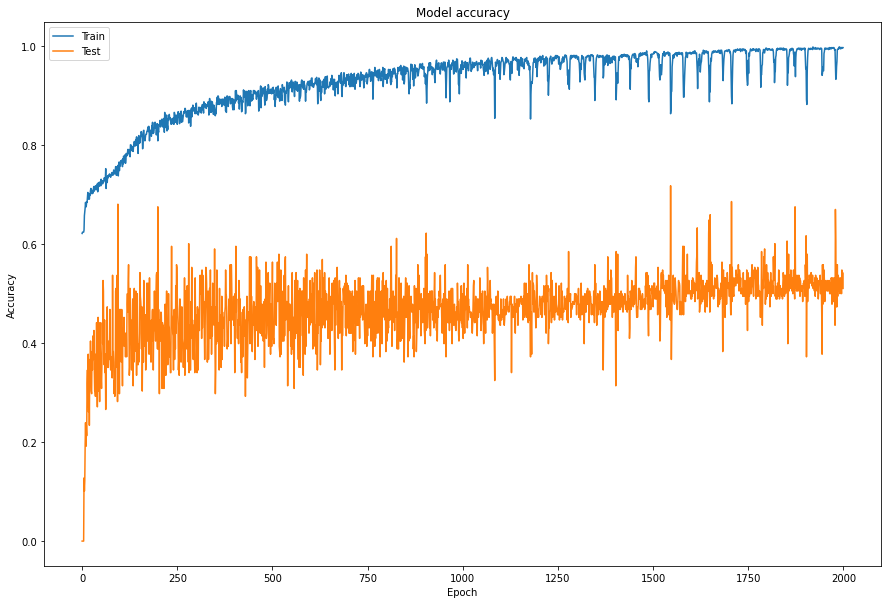

In [25]:
plt.figure(figsize=(15, 10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

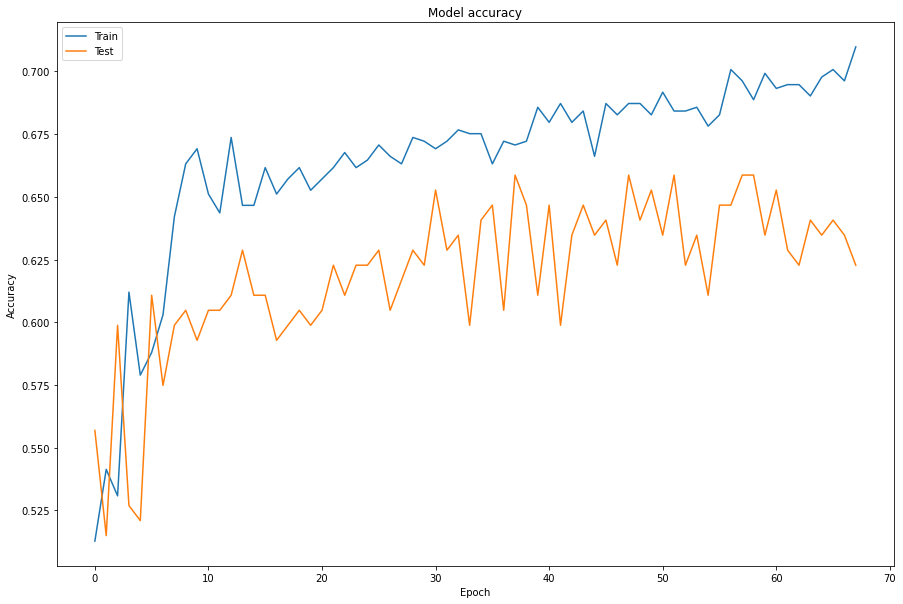

In [26]:
plt.figure(figsize=(15, 10))
plt.plot(history_final.history['accuracy'])
plt.plot(history_final.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [29]:
import matplotlib.pyplot as plt
def scatter_graph(y_test_nn, y_pred):
    xaxis = [_ for _ in range(208)]
    plt.scatter(xaxis, y_test_nn,  color='gray',)
    plt.plot(xaxis, y_pred, color='red', )
    plt.show()

def bar_graph(y_test_nn, y_pred):
    y_real = y_test_nn.to_numpy().ravel()
    df = pd.DataFrame({'Actual': y_real, 'Predicted': y_pred.ravel()})
    df1 = df.head(50)
    df1.plot(kind='bar',figsize=(10,8))
    plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
    plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
    plt.show()


In [30]:
%cd C:\Users\cmiri\Downloads\Alzheimer_Analysis\Alzheimer

[WinError 3] The system cannot find the path specified: 'C:\\Users\\cmiri\\Downloads\\Alzheimer_Analysis\\Alzheimer'
C:\Users\sowjanya\Desktop\Parkinson_ML\Parkinson_ML\Parkinson_MLDL


In [31]:
from tensorflow.keras.models import model_from_json
path = "./Model_V6_Final" # latest = V6
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights(path+".h5")
print("Loaded model from disk")

Loaded model from disk


In [32]:
loaded_model.weights[1]

<tf.Variable 'dense_36_1/bias:0' shape=(52,) dtype=float32, numpy=
array([ 0.04078676,  0.02434008,  0.00665231,  0.        ,  0.        ,
        0.        , -0.00481581,  0.04446471, -0.0194055 ,  0.        ,
        0.02103292,  0.01614545,  0.03111644, -0.02033091, -0.06729055,
       -0.02670926, -0.01992805, -0.00868707, -0.03323598, -0.01779947,
       -0.00306939, -0.00806968,  0.01826868,  0.04087083,  0.        ,
       -0.01597573,  0.03872039, -0.01195438,  0.00444782, -0.00377889,
        0.0485481 ,  0.03900342,  0.05238445,  0.05789867,  0.00292138,
        0.0356797 ,  0.        ,  0.        ,  0.04254753, -0.01941551,
        0.01036445,  0.05037722,  0.02297158,  0.        ,  0.04105462,
       -0.01221423,  0.04567537,  0.02597059,  0.01390309, -0.0139057 ,
       -0.01125564, -0.03396641], dtype=float32)>

In [33]:
all(loaded_model.predict(X_test_nn) == predictions)

True

##ROC and PR Analysis

In [34]:
nm = MinMaxScaler()
data_x_nn = data_x.copy(deep=True)
target_y_nn = y_class_info.copy(deep=True)
data_x_nn = nm.fit_transform(data_x_nn)
X_train_nn, X_test_nn, y_train_nn, y_test_nn = train_test_split(data_x_nn, target_y_nn, test_size = 0.20, random_state = 42)


In [35]:
one = 0
zero = 0
total =0
for ele in y_train_nn:
    if ele == 1:
        one+=1
    elif ele == 0:
        zero+=1
    total+=1
print(one, zero, total, one+zero)

418 414 832 832


In [36]:
one = 0
zero = 0
total =0
for ele in y_test_nn:
    if ele == 1:
        one+=1
    elif ele == 0:
        zero+=1
    total+=1
print(one, zero, total, one+zero)

102 106 208 208


In [37]:
predictions = loaded_model.predict(X_test_nn)
predictions_rounded = np.round_(predictions)

In [38]:
import seaborn as sn

array = confusion_matrix(y_test_nn, predictions_rounded)
tn_thr, fp_thr, fn_thr, tp_thr = confusion_matrix(y_test_nn, predictions_rounded).ravel()

df_cm = pd.DataFrame(array, index = [i for i in ["non - PD", "PD"]],
                  columns = [i for i in ["non-PD","PD"]])
accuracy_thr = accuracy_score(y_test_nn, predictions_rounded)
print("New accuracy ",accuracy_thr)
print("Average Accuracy : " ,(tp_thr+tn_thr)/(tp_thr+tn_thr+fp_thr+fn_thr))
print("Sensitivity: ",(tp_thr)/(tp_thr+fn_thr))
print("Specificity: ",(tn_thr)/(tn_thr+fp_thr))
print("MCC: ",matthews_corrcoef(y_test_nn, predictions_rounded))
print("F-measure: ", f1_score(y_test_nn, predictions_rounded))

plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)
sn.heatmap(df_cm, cmap="YlGnBu",annot=True,annot_kws={"fontsize":48})
plt.savefig("NN_Conf_orig_matrix.jpg", bbox_inches = "tight")

ModuleNotFoundError: No module named 'seaborn'

In [ ]:
print(len(y_test_nn), len(predictions))

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test_nn, predictions)
roc_auc = auc(fpr, tpr)
gmeans = sqrt(tpr * (1-fpr))
arg_g = argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[arg_g], gmeans[arg_g]))
best_threshold = thresholds[arg_g]
tn, fp, fn, tp = confusion_matrix(y_test_nn, predictions_rounded).ravel()
acc = accuracy_score(y_test_nn, predictions_rounded)
# tpr = tp/(tp+fn)
# fpr = fp/(fp+tn)
# tnr = tn/(fp+tn)
# fnr = fn/(tp+fn)

print("accuracy = ", acc, "\nroc_auc = ", roc_auc)

In [ ]:
i=0
roc_table = pd.DataFrame(columns=["Threshold", "TPR (Sensitivity)",
                                  "FPR (Fall-out)", "Specificity",
                                  " (LR+)" ,"Youden index","Sensitivity + Specificity",
                                  "G-mean"], index=[_ for _ in range(len(thresholds))])

for fp_rate, tp_rate, thresh in zip(fpr, tpr, thresholds):
    spec = 1-fp_rate
    lrplus = tp_rate/fp_rate
    y_ind = tp_rate - fp_rate
    sen_sp = tp_rate + spec
    g_mean =  (tp_rate*spec)**(1/2)
    roc_table.iloc[i] = [thresh, tp_rate, fp_rate, spec, lrplus, y_ind, sen_sp, g_mean ]
    i+=1

In [ ]:
%cd C:\Users\sowjanya\Desktop\Parkinson_ML\Parkinson_ML\Parkinson_MLDL

In [ ]:
pd.set_option("display.precision", 4)
roc_table
roc_table.to_csv("NN_ROC_Table.csv")

In [ ]:
plt.subplots(1, figsize=(7,7))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, marker = "." ,label = 'AUC = %0.2f' % roc_auc)
#plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'--', label = "No Skill")

plt.scatter(fpr[arg_g], tpr[arg_g], marker='o', color='black', label='Best')
# plt.xlim([0, 1])
# plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(["ROC", "No Skill"], loc ="lower right")

plt.savefig("NN_ROC.jpg", bbox_inches="tight")
plt.show()


In [ ]:
precision, recall, thresholds = precision_recall_curve(y_test_nn, predictions)

fscore_ = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = argmax(fscore_)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore_[ix]))

pr_table = pd.DataFrame(columns=["Threshold", "Precision",
                                  "Recall", "F-Measure"], 
                                index=[_ for _ in range(len(thresholds))])

i=0
for pre, rec, thresh in zip(precision, recall, thresholds):
    fscore = (2 * pre * rec) / (pre + rec)
    pr_table.iloc[i] = [thresh, pre, rec, fscore]
    i+=1

In [ ]:
pr_table.to_csv("NN_PR_Table.csv")
pr_table

In [ ]:
plt.subplots(1, figsize=(7,7))
plt.title('Precision-Recall Curve')
plt.plot(recall, precision)
plt.plot([0, 1], [0.725, 0.725], linestyle='--')
plt.legend(loc = 'lower right')
# plt.xlim([0, 1])
# plt.ylim([0, 1])
plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
# axis labels
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.legend(["PR","No Skill"], loc ="upper right")
plt.savefig("NN_PR.jpg", bbox_inches="tight")
plt.show()


In [ ]:
print("F-measure : ", f1_score(y_test_nn, predictions_rounded))

In [ ]:
y_pred_thr = [ 1 if _ >= best_threshold else 0 for _ in predictions]
print(best_threshold)
accuracy_thr = accuracy_score(y_test_nn, y_pred_thr)
print("New accuracy ",accuracy_thr)
tn_thr, fp_thr, fn_thr, tp_thr = confusion_matrix(y_test_nn, y_pred_thr).ravel()

print("Average Accuracy : " ,(tp_thr+tn_thr)/(tp_thr+tn_thr+fp_thr+fn_thr))
print("Sensitivity: ",(tp_thr)/(tp_thr+fn_thr))
print("Specificity: ",(tn_thr)/(tn_thr+fp_thr))
print("MCC: ",matthews_corrcoef(y_test_nn, y_pred_thr))
print("F-measure : ", f1_score(y_test_nn, y_pred_thr))


In [ ]:
import seaborn as sn

nm = MinMaxScaler()
data_x_nn = data_x.copy(deep=True)
target_y_nn = y_class_info.copy(deep=True)
data_x_nn = nm.fit_transform(data_x_nn)

X_train_nn, X_test_nn, y_train_nn, y_test_nn = train_test_split(data_x_nn, target_y_nn, test_size = 0.20, random_state = 42)
predictions_loaded_model  = loaded_model.predict(X_test_nn)

best_threshold = 0.5405
y_pred_thr = [ 1 if _ >= best_threshold else 0 for _ in predictions_loaded_model]
array = confusion_matrix(y_test_nn, y_pred_thr)
tn_thr, fp_thr, fn_thr, tp_thr = confusion_matrix(y_test_nn, y_pred_thr).ravel()

df_cm = pd.DataFrame(array, index = [i for i in ["non - PD", "PD"]],
                  columns = [i for i in ["non-PD","PD"]])
accuracy_thr = accuracy_score(y_test_nn, y_pred_thr)
print("New accuracy ",accuracy_thr)
print("Average Accuracy : " ,(tp_thr+tn_thr)/(tp_thr+tn_thr+fp_thr+fn_thr))
print("Sensitivity: ",(tp_thr)/(tp_thr+fn_thr))
print("Specificity: ",(tn_thr)/(tn_thr+fp_thr))
print("MCC: ",matthews_corrcoef(y_test_nn, y_pred_thr))

plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)
sn.heatmap(df_cm, cmap="YlGnBu",annot=True,annot_kws={"fontsize":48})
plt.savefig("NN_Conf_matrix.png", bbox_inches = "tight")

In [ ]:
count=0
for i, j in zip(y_pred_thr, y_test_nn):
    if i==1 and j==0:
        count+=1
print(count)